# Импорт библиотек

In [307]:
import numpy as np
import sys
sys.path.append('..\Python Scripts\pipeline')
import warnings
warnings.filterwarnings('ignore') 
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import pymssql
import sqlalchemy
import pickle
from scipy.stats import uniform
from sklearn.ensemble import RandomForestClassifier
import lightgbm
from scipy import stats
import urllib.parse
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from sklearn.model_selection import cross_val_score, StratifiedKFold
import sqlalchemy
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, validation_curve, KFold
from functools import reduce
import urllib.parse 
%store -r passw
quoted = urllib.parse.quote_plus('server=olimpus;database=wrk_rsk_anl;driver=sql server;Trusted Connection=yes;')
engine = pymssql.connect(server="olimpus",user=r'moscow\u_m1192', password=passw,database="wrk_rsk_anl") 
engine_hadoop = sqlalchemy.create_engine('hive://bda41node04:10000/' + 'u_m1192', connect_args={'auth': 'KERBEROS','kerberos_service_name': 'hive'})

# Функции

In [2]:
def read(name):
    '''
    Функция возвращает считанный из SQL датафрейм без некоторых полей, но с evtime
    '''
    df = pd.read_sql('select * from ' + name , engine)
    if 'submission_id' in df.columns:
        df = df.drop(['submission_id'], axis=1)  
    if  'NUMBER_AC' in df.columns:
        df = df.drop(['NUMBER_AC', 'NUMBER_AD', 'NUMBER_CC', 'NUMBER_CD' ] , axis=1)
    if 'APP_ID' in df.columns:
        df['app_id'] = df['APP_ID']
        df.drop(['APP_ID'], axis=1, inplace=True)
    if 'EVNUM' in df.columns:
        df['evnum'] = df['EVNUM']
        df.drop(['EVNUM'], axis=1, inplace=True)
    df = df.set_index('app_id')
    return df
def get_sample(dataframe):
    '''
    Функция возвращает разбиение выборки на train+test и out of time
    '''
        
    OOT_sample = dataframe[dataframe['prv_evtime_eom'].isin(['189', '190', '191'])].copy()
    OOT_sample.drop(['prv_evtime_eom'], axis=1, inplace=True)

    X_OOT = OOT_sample.iloc[:, ~OOT_sample.columns.isin(['target'])]
    y_OOT = OOT_sample.target

    intime_sample = dataframe[~dataframe['prv_evtime_eom'].isin(['189', '190', '191'])].copy()
    

    intime_sample.drop(['prv_evtime_eom'], axis=1, inplace=True)

    X = intime_sample.iloc[:, intime_sample.columns != 'target']
    y = intime_sample.target

    return X, y, X_OOT, y_OOT  
def get_sample_evtime(dataframe):
    dataframe['evtime'] = pd.to_datetime(dataframe['evtime'])
    dataframe['evtime_month'] = dataframe['evtime'].apply(lambda x: x.strftime("%y-%m"))

    OOT_sample = dataframe[dataframe['evtime_month'].isin(['18-02', '18-03', '18-04'])].copy()
    OOT_sample.drop(['evtime_month'], axis=1, inplace=True)

    X_OOT = OOT_sample.iloc[:, ~OOT_sample.columns.isin(['target'])]
    y_OOT = OOT_sample.target

    intime_sample = dataframe[~dataframe['evtime_month'].isin(['18-02', '18-03', '18-04'])].copy()


    intime_sample.drop(['evtime_month'], axis=1, inplace=True)

    X = intime_sample.iloc[:, intime_sample.columns != 'target']
    y = intime_sample.target

    X.drop(['evtime'], axis=1, inplace=True)
    X_OOT.drop(['evtime'], axis=1, inplace=True)
    
    return X, y, X_OOT, y_OOT
def merge(list_df):
    '''
    Функция делает последовательный merge таблиц по полю app_id
    '''    
    df = reduce(lambda left, right: pd.merge(left, right, on='app_id', how='left'), list_df)
    return df
def read_hdp(name):
    '''
    Функция читает таблички из хадупа
    '''
    df = pd.read_sql('select * from p_drr_anl.bay_ccbi_' + name , con=engine_hadoop)
    df = df.set_index('app_id')
    return df
def num_cat(df):
    '''
    Функция возвращает куски исходного датафрейма. Куски состоят из категориальных фич и из числовых
    '''
    categorical_features = df.select_dtypes(include = ["object"]).columns
    numerical_features = df.select_dtypes(exclude = ["object"]).columns
    if 'target' in numerical_features:
        numerical_features = numerical_features.drop('target')
    print("Numerical features : " + str(len(numerical_features)))
    print("Categorical features : " + str(len(categorical_features)))

    df_num = df[numerical_features]
    df_cat = df[categorical_features]
    return df_num, df_cat
def missing_values_table(df):
    '''
    Функция возвращает таблицу с количеством и долей пропущенных значений в датафрейме
    '''
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})

    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)

    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")
    return mis_val_table_ren_columns
def validate_hyperopt(X, y, X_OOT, y_OOT, epochs, params):
    
    '''
    Функция делает кросс-валидацию по 5 фолдам с кучей эпох, каждый раз обучая новыый классификатор. 
    Возвращает медиану Джини на тесте (использовала для тюнинга гиперпараметров на тесте при помощи гиперопта)
    '''
    
    list_gini_test = []
    list_gini_oot = []
    list_gini_train = []
    
    clfs=[]
    
    for epoch in range(epochs):
        skf = StratifiedKFold(n_splits=5, shuffle=True)

        for n_fold, (trn_idx, tst_idx) in enumerate(skf.split(X, y)):
                trn_x, trn_y = X.loc[:, X.columns].iloc[trn_idx], y.iloc[trn_idx]
                tst_x, tst_y = X.loc[:, X.columns].iloc[tst_idx], y.iloc[tst_idx]
                oot_x, oot_y = X_OOT.loc[:, X_OOT.columns], y_OOT


                clf = lightgbm.LGBMClassifier(n_estimators=params['n_estimators'],
                learning_rate=params['learning_rate'],
                num_leaves=params['num_leaves'],
                max_depth=params['max_depth'],
                min_child_weight=params['min_child_weight'],
                lambda_l1=params['lambda_l1'],
                lambda_l2=params['lambda_l2'],
                min_data_in_leaf=params['min_data_in_leaf'],
                min_sum_hessian_in_leaf=params['min_sum_hessian_in_leaf'],
                bagging_fraction=params['bagging_fraction'],
                max_bin=params['max_bin'],
                feature_fraction=params['feature_fraction'],
                bagging_freq=params['bagging_freq'],
                min_gain_to_split=params['min_gain_to_split'],                                                 
                n_jobs=60)

                clf.fit(trn_x, trn_y, 
                         eval_set= [(tst_x, tst_y)], 
                         eval_metric='auc', verbose=False, early_stopping_rounds=100  
#                         , categorical_feature=cats
                       )

                pred_test = clf.predict_proba(tst_x, num_iteration=clf.best_iteration_)[:, 1]
                pred_oot = clf.predict_proba(oot_x, num_iteration=clf.best_iteration_)[:, 1]
                pred_train = clf.predict_proba(trn_x, num_iteration=clf.best_iteration_)[:, 1]

                gini_test = 2 * roc_auc_score(tst_y, pred_test) - 1
                gini_oot = 2 * roc_auc_score(oot_y, pred_oot) - 1
                gini_train = 2 * roc_auc_score(trn_y, pred_train) - 1

                list_gini_test.append(gini_test)
                list_gini_oot.append(gini_oot)
                list_gini_train.append(gini_train)
                clfs.append(clf)

    print(round(np.median(list_gini_train), 3), round(np.median(list_gini_test), 3), round(np.median(list_gini_oot), 3))

    return np.median(list_gini_test)
def validate(X, y, X_OOT, y_OOT, epochs, params):
        
    '''
    Функция делает кросс-валидацию по 5 фолдам с кучей эпох, каждый раз обучая новыый классификатор. 
    Возвращает классификаторы, списки со всеми Джини, индексы трейна и теста для каждого разбиения
    '''
    
    q=0
    list_gini_test = []
    list_gini_oot = []
    list_gini_train = []
    trn_idxs = []
    tst_idxs = []
    
    clfs=[]
    
#     trn_idx = np.zeros((epochs*5, ))
    
    for epoch in range(epochs):
        skf = StratifiedKFold(n_splits=5, shuffle=True)

        for n_fold, (trn_idx, tst_idx) in enumerate(skf.split(X, y)):

            trn_x, trn_y = X.loc[:, X.columns].iloc[trn_idx], y.iloc[trn_idx]
            tst_x, tst_y = X.loc[:, X.columns].iloc[tst_idx], y.iloc[tst_idx]
            oot_x, oot_y = X_OOT.loc[:, X_OOT.columns], y_OOT


            clf = lightgbm.LGBMClassifier(**params)

            clf.fit(trn_x, trn_y, 
                    eval_metric='auc', verbose=False
#                         , categorical_feature=cats
                   )

            pred_test = clf.predict_proba(tst_x, num_iteration=clf.best_iteration_)[:, 1]
            pred_oot = clf.predict_proba(oot_x, num_iteration=clf.best_iteration_)[:, 1]
            pred_train = clf.predict_proba(trn_x, num_iteration=clf.best_iteration_)[:, 1]

            gini_test = 2 * roc_auc_score(tst_y, pred_test) - 1
            gini_oot = 2 * roc_auc_score(oot_y, pred_oot) - 1
            gini_train = 2 * roc_auc_score(trn_y, pred_train) - 1

            list_gini_test.append(gini_test)
            list_gini_oot.append(gini_oot)
            list_gini_train.append(gini_train)

            trn_idxs.append(trn_idx)
            tst_idxs.append(tst_idx) 



            clfs.append(clf)
            print(q, gini_train, gini_test, gini_oot)
            q+=1
                
    print(np.median(list_gini_train), np.median(list_gini_test), np.median(list_gini_oot))

    return  clfs, list_gini_train, list_gini_test, list_gini_oot, trn_idxs, tst_idxs
def validate_model(X, y, X_OOT, y_OOT, clf, epochs, params):
            
    '''
    Функция делает кросс-валидацию по 5 фолдам с кучей эпох для одного классификатора, который хотим потестить. 
    Возвращает классификаторы, списки со всеми Джини, индексы трейна и теста для каждого разбиения
    '''
    
    list_gini_test = []
    list_gini_oot = []
    list_gini_train = []
    q=0   
    for epoch in range(epochs):
        skf = StratifiedKFold(n_splits=5, shuffle=True)

        for n_fold, (trn_idx, tst_idx) in enumerate(skf.split(X, y)):
                trn_x, trn_y = X.loc[:, X.columns].iloc[trn_idx], y.iloc[trn_idx]
                tst_x, tst_y = X.loc[:, X.columns].iloc[tst_idx], y.iloc[tst_idx]
                oot_x, oot_y = X_OOT.loc[:, X_OOT.columns], y_OOT

                pred_test = clf.predict_proba(tst_x, num_iteration=clf.best_iteration_)[:, 1]
                pred_oot = clf.predict_proba(oot_x, num_iteration=clf.best_iteration_)[:, 1]
                pred_train = clf.predict_proba(trn_x, num_iteration=clf.best_iteration_)[:, 1]

                gini_test = 2 * roc_auc_score(tst_y, pred_test) - 1
                gini_oot = 2 * roc_auc_score(oot_y, pred_oot) - 1
                gini_train = 2 * roc_auc_score(trn_y, pred_train) - 1

                list_gini_test.append(gini_test)
                list_gini_oot.append(gini_oot)
                list_gini_train.append(gini_train)
                q+=1
                print(q, gini_train, gini_test, gini_oot)
                
    pred_train = clf.predict_proba(X, num_iteration=clf.best_iteration_)[:, 1]
    pred_oot = clf.predict_proba(X_OOT, num_iteration=clf.best_iteration_)[:, 1]
      
    
    print(np.median(list_gini_train), np.median(list_gini_test), np.median(list_gini_oot))

    return pred_train, pred_oot
def validate_result(X, y, X_OOT, y_OOT, epochs, params):
        
    '''
    Функция делает кросс-валидацию по 5 фолдам с кучей эпох, каждый раз обучая новый классификатор. 
    Возвращает медиану Джини на трейне, тесте, оот
    '''
    
    list_gini_test = []
    list_gini_oot = []
    list_gini_train = []
    
    for epoch in range(epochs):
        skf = StratifiedKFold(n_splits=5, shuffle=True)

        for n_fold, (trn_idx, tst_idx) in enumerate(skf.split(X, y)):
                trn_x, trn_y = X.loc[:, X.columns].iloc[trn_idx], y.iloc[trn_idx]
                tst_x, tst_y = X.loc[:, X.columns].iloc[tst_idx], y.iloc[tst_idx]
                oot_x, oot_y = X_OOT.loc[:, X_OOT.columns], y_OOT


                clf = lightgbm.LGBMClassifier(n_estimators=params['n_estimators'],
                learning_rate=params['learning_rate'],
                num_leaves=params['num_leaves'],
                max_depth=params['max_depth'],
                min_child_weight=params['min_child_weight'],
                lambda_l1=params['lambda_l1'],
                lambda_l2=params['lambda_l2'],
                min_data_in_leaf=params['min_data_in_leaf'],
                min_sum_hessian_in_leaf=params['min_sum_hessian_in_leaf'],
                bagging_fraction=params['bagging_fraction'],
                max_bin=params['max_bin'],
                feature_fraction=params['feature_fraction'],
                bagging_freq=params['bagging_freq'],
                min_gain_to_split=params['min_gain_to_split'],                                                 
                n_jobs=40)

                clf.fit(trn_x, trn_y, 
                        eval_set= [(tst_x, tst_y)], 
                        eval_metric='auc', verbose=False, early_stopping_rounds=30  #30
                       )

                pred_test = clf.predict_proba(tst_x, num_iteration=clf.best_iteration_)[:, 1]
                pred_oot = clf.predict_proba(oot_x, num_iteration=clf.best_iteration_)[:, 1]
                pred_train = clf.predict_proba(trn_x, num_iteration=clf.best_iteration_)[:, 1]

                gini_test = 2 * roc_auc_score(tst_y, pred_test) - 1
                gini_oot = 2 * roc_auc_score(oot_y, pred_oot) - 1
                gini_train = 2 * roc_auc_score(trn_y, pred_train) - 1

                list_gini_test.append(gini_test)
                list_gini_oot.append(gini_oot)
                list_gini_train.append(gini_train)
                
#     print(np.median(list_gini_train), np.median(list_gini_test), np.median(list_gini_oot))

    return  np.median(list_gini_train), np.median(list_gini_test), np.median(list_gini_oot)
def learn_lgbm(epochs, X, y, X_OOT, y_OOT, params, score=False):
        
    '''
    Функция делает кросс-валидацию по 5 фолдам с кучей эпох, каждый раз обучая новыый классификатор. 
    Возвращает кучу всего, да еще и feature importance считает
    '''
        
    feature_importance_df = pd.DataFrame()
    list_gini_test = []
    list_gini_oot = []
    list_gini_train = []
    
    if score == True:
        list_gini_baseline = []
        
        
    for epoch in range(epochs):
        skf = StratifiedKFold(n_splits=5, shuffle=True)

        if score == True:
            oof_preds = np.zeros(X.loc[:, X.columns != 'score'].shape[0])
            oot_preds = np.zeros(X_OOT.loc[:, X_OOT.columns != 'score'].shape[0])
        else:
            oof_preds = np.zeros(X.loc[:, X.columns].shape[0])
            oot_preds = np.zeros(X_OOT.loc[:, X_OOT.columns].shape[0])



        for n_fold, (trn_idx, tst_idx) in enumerate(skf.split(X, y)):

            # получила индексы разбиения на train и test
            if score == True:
                trn_x, trn_y = X.loc[:, X.columns != 'score'].iloc[trn_idx], y.iloc[trn_idx]
                tst_x, tst_y = X.loc[:, X.columns != 'score'].iloc[tst_idx], y.iloc[tst_idx]
                oot_x, oot_y = X_OOT.loc[:, X_OOT.columns != 'score'], y_OOT  

                tst_score = X['score'].iloc[tst_idx]
                trn_score = X['score'].iloc[trn_idx]
                oot_score = X_OOT['score']

            else:
                trn_x, trn_y = X.loc[:, X.columns].iloc[trn_idx], y.iloc[trn_idx]
                tst_x, tst_y = X.loc[:, X.columns].iloc[tst_idx], y.iloc[tst_idx]
                oot_x, oot_y = X_OOT.loc[:, X_OOT.columns], y_OOT



            #считаю бэдрейты

            bad_train = trn_y.sum()
            good_train = len(trn_y) - bad_train
            badrate_train = bad_train/(good_train+bad_train) 

            bad_test = tst_y.sum()
            good_test = len(tst_y) - bad_test
            badrate_test = bad_test/(good_test+bad_test) 

    #         print('badrate train: ', badrate_train, 'badrate_test: ',  badrate_test)

            clf = lightgbm.LGBMClassifier(n_estimators=params['n_estimators'],
                learning_rate=params['learning_rate'],
                num_leaves=params['num_leaves'],
                max_depth=params['max_depth'],
                min_child_weight=params['min_child_weight'],
                lambda_l1=params['lambda_l1'],
                lambda_l2=params['lambda_l2'],
                min_data_in_leaf=params['min_data_in_leaf'],
                min_sum_hessian_in_leaf=params['min_sum_hessian_in_leaf'],
                bagging_fraction=params['bagging_fraction'],
                max_bin=params['max_bin'],
                feature_fraction=params['feature_fraction'],
                bagging_freq=params['bagging_freq'],
                min_gain_to_split=params['min_gain_to_split'],                                                 
                n_jobs=10)

            clf.fit(trn_x, trn_y, 
                    eval_set= [(tst_x, tst_y)], 
                    eval_metric='auc', verbose=False, early_stopping_rounds=100  #30
                   )

            oof_preds[tst_idx] = clf.predict_proba(tst_x, num_iteration=clf.best_iteration_)[:, 1]
            oot_preds = clf.predict_proba(oot_x, num_iteration=clf.best_iteration_)[:, 1]
            pred_train = clf.predict_proba(trn_x, num_iteration=clf.best_iteration_)[:, 1]


            fold_importance_df = pd.DataFrame()

            if score == True:
                fold_importance_df["feature"] = X.loc[:, X.columns != 'score'].columns
            else:
                fold_importance_df["feature"] = X.loc[:, X.columns].columns

            fold_importance_df["importance"] = clf.feature_importances_
            fold_importance_df["fold"] = n_fold + 1
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

            gini_test = 2 * roc_auc_score(tst_y, oof_preds[tst_idx]) - 1
            gini_oot = 2 * roc_auc_score(oot_y, oot_preds) - 1
            gini_train = 2 * roc_auc_score(trn_y, pred_train) - 1

            if score == True:
                gini_baseline_train = 2 * roc_auc_score(trn_y, -trn_score) - 1
                gini_baseline_test = 2 * roc_auc_score(tst_y, -tst_score) - 1
                gini_baseline_oot = 2 * roc_auc_score(oot_y, -oot_score) - 1
                list_gini_baseline.append((gini_baseline_train, gini_baseline_test, gini_baseline_oot))

            list_gini_test.append(gini_test)
            list_gini_oot.append(gini_oot)
            list_gini_train.append(gini_train)


    try:
        list_gini_baseline
    except NameError:
        list_gini_baseline_exists = False
    else:
        list_gini_baseline_exists = True
        
    if list_gini_baseline_exists == True:
        return clf, feature_importance_df, list_gini_test, list_gini_oot, list_gini_train, list_gini_baseline, trn_idx, tst_idx
    else:
        return clf, feature_importance_df, list_gini_test, list_gini_oot, list_gini_train  
def learn_lgbm_(epochs, X, y,  params):
        
    '''
    Функция делает кросс-валидацию по 5 фолдам с кучей эпох, каждый раз обучая новыый классификатор. 
    Возвращает кучу всего, да еще и feature importance считает
    '''
        
    feature_importance_df = pd.DataFrame()
    list_gini_test = []
    list_gini_train = []
    

    for epoch in range(epochs):
        skf = StratifiedKFold(n_splits=5, shuffle=True)
        oof_preds = np.zeros(X.loc[:, X.columns].shape[0])

        for n_fold, (trn_idx, tst_idx) in enumerate(skf.split(X, y)):

            trn_x, trn_y = X.loc[:, X.columns].iloc[trn_idx], y.iloc[trn_idx]
            tst_x, tst_y = X.loc[:, X.columns].iloc[tst_idx], y.iloc[tst_idx]

            clf = lightgbm.LGBMClassifier(n_estimators=params['n_estimators'],
                learning_rate=params['learning_rate'],
                num_leaves=params['num_leaves'],
                max_depth=params['max_depth'],
                min_child_weight=params['min_child_weight'],
                lambda_l1=params['lambda_l1'],
                lambda_l2=params['lambda_l2'],
                min_data_in_leaf=params['min_data_in_leaf'],
                min_sum_hessian_in_leaf=params['min_sum_hessian_in_leaf'],
                bagging_fraction=params['bagging_fraction'],
                max_bin=params['max_bin'],
                feature_fraction=params['feature_fraction'],
                bagging_freq=params['bagging_freq'],
                min_gain_to_split=params['min_gain_to_split'],                                                 
                n_jobs=50)

            clf.fit(trn_x, trn_y, 
                    eval_set= [(tst_x, tst_y)], 
                    eval_metric='auc', verbose=False, early_stopping_rounds=100  #30
                   )

            oof_preds[tst_idx] = clf.predict_proba(tst_x, num_iteration=clf.best_iteration_)[:, 1]
            pred_train = clf.predict_proba(trn_x, num_iteration=clf.best_iteration_)[:, 1]


            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = X.loc[:, X.columns].columns
            fold_importance_df["importance"] = clf.feature_importances_
            fold_importance_df["fold"] = n_fold + 1
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

            gini_test = 2 * roc_auc_score(tst_y, oof_preds[tst_idx]) - 1
            gini_train = 2 * roc_auc_score(trn_y, pred_train) - 1

            list_gini_test.append(gini_test)
            list_gini_train.append(gini_train)
            print(gini_train, gini_test)
        print(np.median(list_gini_train), np.median(list_gini_test))
        return clf, feature_importance_df, list_gini_test,  list_gini_train  
def read_hadoop(name):
    '''
    Функция читает таблички из хадупа
    '''
    df = pd.read_sql('select * from p_drr_anl.' + name , con=engine_hadoop)
    df = df.set_index('app_id')
    return df

# Чтение данных

## SQL таблицы

In [1621]:
sample = read('wrk_RSK_ANL.dbo.bay_ccbi_sample_all')
pdcc = read('wrk_rsk_anl.dbo.bay_ccbi_vars_pd')
antifraud = read('wrk_rsk_anl.dbo.bay_ccbi_vars_antifraud')

list_dataframes = [sample, pdcc, antifraud]
df_sql = merge(list_dataframes)
df_sql = df_sql.replace(-999999, np.nan)
df_sql = df_sql.replace('None', np.nan)

def drop_x_y(df):
    for item in df.columns:
        if item[-2:] == '_x':
            df[item[:-2]] = df[item]
            print(item)
            df.drop(item, axis=1, inplace=True)
        if item[-2:] == '_y':
            df.drop(item, axis=1, inplace=True)

drop_x_y(df_sql)

df_sql.drop(['date_app_entry', 'eq_id', 'income', 'usd_rate', 'eur_rate', 'req_loan',
       'evnum', 'dt_start', 'dt_start_eom',
       'date_app_entry_eom', 'prv_evtime_eom' ], axis=1, inplace=True)
df_sql.drop(['pdscore18', 'pred_ml_score'],axis=1, inplace=True)

df_sql = df_sql.dropna(subset=['scoremarat'])

df_sql['prv_evtime_eom'] = df_sql['eom']
df_sql['MARITAL_STATUS'] = pd.to_numeric(df_sql['MARITAL_STATUS'])
df_sql['PRS_RELATIONSHIP'] = pd.to_numeric(df_sql['PRS_RELATIONSHIP'])

evtime_x
app_educ_rank_x
app_position_rank_x
JB38_x
JB59_2_x
JBB214_x
JB_cards26_x


In [1622]:
df_sql.drop(['eom'], axis=1, inplace=True)

In [1582]:
pd.DataFrame(df_sql.columns)

0
0                                           target
1                                         app_n049
2                                         app_n075
3                                              ami
4                                             JB65
5                                             JB85
6                                       JB_cards15
7                                       JB_cards76
8                                       JB_ilpil70
9                                         CDXXU009
10                                             UD2
11                                        JB1001_1
12                               CD_time_with_bank
13                                      scoremarat
14                                  app_n075_axtra
15                                  MARITAL_STATUS
16                                PRS_RELATIONSHIP
17                                   surname_match
18                              wrk_phone_start_79
19                                        pass_ch2
20                                JB_cards15_extra
21                                JB_cards76_extra
22                                  JB1001_1_extra
23                                 max_recent_util
24                                 cd_bal_to_debt3
25                         sum_inc_ad_cred_turn_m3
26                              sum_automort_outst
27                            cdjb_2_JB_notcards72
28     LOANS_AT_TIME_84_MONTH_bad_symbols_sh_0_avg
29      LOANS_AT_TIME_84_MONTH_all_symbols_cnt_sum
30                               sh_posit_tot_over
31  SPK_STATUS_COMP_DATE_DATE_APP_ENTRY_diff_extra
32                                          evtime
33                                   app_educ_rank
34                               app_position_rank
35                                            JB38
36                                          JB59_2
37                                          JBB214
38                                      JB_cards26

## Hadoop таблицы

In [1677]:
from datetime import datetime
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i minutes and %s seconds.' % (tmin, round(tsec, 2)))
def reduce_memory_usage(df):
    '''
    iterate through all the columns of a dataframe and modify the data type
    to reduce memory usage.
    '''
    start_mem = df.memory_usage().sum()/1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if (col_type != object) & (col_type != 'datetime64[ns]'):
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum()/1024**2
    print('Memory usage: Before|{:.2f} MB || After|{:.2f} MB || Decreased|{:.1f}%'.format(start_mem, end_mem, 100*(1 - end_mem/start_mem)))
    
    return df 

In [1675]:
names_hdp = ['client_uk',
        # click
         'epay_varsadd', 'epay_vars_since', 
         'epay_vars12', 'epay_vars6', 'epay_vars3', 'epay_vars1', 
         'epay_vars_3_12', 'epay_vars_1_6', 'epay_vars_1_3', 
         'epay_vars_greatest12', 'epay_vars_greatest6', 'epay_vars_greatest3', 'epay_vars_greatest1',
         
        # transactions
         'ctrvars12_v1','ctrvars12_v2', 'ctrvars12_v3', 'ctrvars12_v4',
         'ctrvars6_v1', 'ctrvars6_v2', 'ctrvars6_v3', 'ctrvars6_v4',
         'ctrvars3_v1', 'ctrvars3_v2', 'ctrvars3_v3', 'ctrvars3_v4',
         'ctrvars1_v1', 'ctrvars1_v2', 'ctrvars1_v3', 'ctrvars1_v4',
         'ctrvars_3_12_v1', 'ctrvars_3_12_v2', 'ctrvars_3_12_v3', 'ctrvars_3_12_v4',
         'ctrvars_1_3_v1', 'ctrvars_1_3_v2', 'ctrvars_1_3_v3', 'ctrvars_1_3_v4',
         'ctrvars_1_6_v1', 'ctrvars_1_6_v2', 'ctrvars_1_6_v3', 'ctrvars_1_6_v4',
         'ctrvars_since_v1', 'ctrvars_since_v2', 'ctrvars_since_v3', 'ctrvars_since_v4' ,
    
        # additional tables
         'ctrvars_badgood_adj', 'ctrvars_night', 'cardtrnopkind_uk_5880005493_cnt_1_3_com',
    
        # ocrm
         'OCRMvars1', 'OCRMvars1_YN', 'OCRMvars1_prod', 'OCRMvars3', 'OCRMvars3_YN', 
         'OCRMvars3_prod', 'OCRMvars6', 'OCRMvars6_YN', 'OCRMvars6_prod', 'OCRMvars6_last_accepted_vars'
        ]

In [160]:
tables_hdp2 = []

for i, name in enumerate(names_hdp):
    start_time = timer(None)
    print(i, '/56 ', name)
    temp = reduce_memory_usage(read_hdp(name))    
    tables_hdp2.append(temp)
    print('Shape: (%d, %d)' %(temp.shape[0], temp.shape[1]))
    timer(start_time)


0 /56  client_uk
Memory usage: Before|8.85 MB || After|6.08 MB || Decreased|31.2%
Shape: (290002, 3)

 Time taken: 0 minutes and 5.93 seconds.
1 /56  epay_varsadd
Memory usage: Before|116.99 MB || After|39.17 MB || Decreased|66.5%
Shape: (107233, 142)

 Time taken: 0 minutes and 32.7 seconds.
2 /56  epay_vars_since
Memory usage: Before|27.79 MB || After|7.05 MB || Decreased|74.6%
Shape: (104069, 34)

 Time taken: 0 minutes and 9.14 seconds.
3 /56  epay_vars12
Memory usage: Before|181.03 MB || After|59.25 MB || Decreased|67.3%
Shape: (104069, 227)

 Time taken: 0 minutes and 52.4 seconds.
4 /56  epay_vars6
Memory usage: Before|161.54 MB || After|52.52 MB || Decreased|67.5%
Shape: (92864, 227)

 Time taken: 0 minutes and 46.4 seconds.
5 /56  epay_vars3
Memory usage: Before|145.30 MB || After|46.60 MB || Decreased|67.9%
Shape: (83530, 227)

 Time taken: 0 minutes and 44.52 seconds.
6 /56  epay_vars1
Memory usage: Before|120.27 MB || After|37.98 MB || Decreased|68.4%
Shape: (69139, 227)

 

Memory usage: Before|19.94 MB || After|3.86 MB || Decreased|80.7%
Shape: (49308, 52)

 Time taken: 0 minutes and 6.4 seconds.
55 /56  OCRMvars6
Memory usage: Before|100.90 MB || After|19.35 MB || Decreased|80.8%
Shape: (128402, 102)

 Time taken: 0 minutes and 30.31 seconds.
56 /56  OCRMvars6_YN
Memory usage: Before|46.50 MB || After|9.53 MB || Decreased|79.5%
Shape: (121906, 49)

 Time taken: 0 minutes and 14.58 seconds.
57 /56  OCRMvars6_prod
Memory usage: Before|29.59 MB || After|5.77 MB || Decreased|80.5%
Shape: (65740, 58)

 Time taken: 0 minutes and 9.3 seconds.
58 /56  OCRMvars6_last_accepted_vars
Memory usage: Before|0.60 MB || After|0.60 MB || Decreased|0.0%
Shape: (39070, 1)

 Time taken: 0 minutes and 1.11 seconds.


In [161]:
l=0
for item in tables_hdp2:
    l+=item.shape[1]    
print(l)

11047 11401


In [183]:
df_hdp2 = tables_hdp2[0]
for q in range(1, len(tables_hdp2) ):
    df_hdp2 = df_hdp2.join(tables_hdp2[q], rsuffix='_x')
    print(q, ' joined, shape: ', df_hdp2.shape)
    

1  joined, shape:  (290002, 145)
2  joined, shape:  (290002, 179)
3  joined, shape:  (290002, 406)
4  joined, shape:  (290002, 633)
5  joined, shape:  (290002, 860)
6  joined, shape:  (290002, 1087)
7  joined, shape:  (290002, 1100)
8  joined, shape:  (290002, 1113)
9  joined, shape:  (290002, 1126)
10  joined, shape:  (290002, 1152)
11  joined, shape:  (290002, 1178)
12  joined, shape:  (290002, 1204)
13  joined, shape:  (290002, 1230)
14  joined, shape:  (290002, 1309)
15  joined, shape:  (290002, 1961)
16  joined, shape:  (290002, 2334)
17  joined, shape:  (290002, 2957)
18  joined, shape:  (290002, 3036)
19  joined, shape:  (290002, 3688)
20  joined, shape:  (290002, 4061)
21  joined, shape:  (290002, 4684)
22  joined, shape:  (290002, 4763)
23  joined, shape:  (290002, 5415)
24  joined, shape:  (290002, 5788)
25  joined, shape:  (290002, 6411)
26  joined, shape:  (290002, 6490)
27  joined, shape:  (290002, 7142)
28  joined, shape:  (290002, 7515)
29  joined, shape:  (290002, 8138)

In [ ]:
# df_hdp = merge(tables_hdp)

In [187]:
for item in df_hdp2.columns:
    if item[-2:] == '_x':
        print(item)

cnt_12_x
sum_12_x
max_12_x
min_12_x
avg_12_x
cnt_6_x
sum_6_x
max_6_x
min_6_x
avg_6_x
cnt_3_x
sum_3_x
max_3_x
min_3_x
avg_3_x
cnt_1_x
sum_1_x
max_1_x
min_1_x
avg_1_x
cnt_3_12_x
sum_3_12_x
avg_3_12_x
cnt_1_3_x
sum_1_3_x
avg_1_3_x
cnt_1_6_x
sum_1_6_x
avg_1_6_x
cardtrnopkind_uk_5880005493_cnt_1_3_x


## .csv

In [190]:
df_hdp2.to_csv('df_hdp.csv')

In [5]:
df = pd.read_csv('df_hdp.csv').set_index('app_id')

In [17]:
df_hdp_backup = df.copy()

In [224]:
df_hdp = df_hdp_backup.copy()

# EDA

## Очистка категориальных фичей

In [6]:
num, cat = num_cat(df)

Numerical features : 11399
Categorical features : 2


In [7]:
for item in cat.columns:
    df[item] = pd.Categorical(df[item])

In [ ]:
# df.drop(['eq_id'], axis=1, inplace=True)

## Удаление пропусков и константных фич

In [8]:
empty = list(set(df.columns) - set(df.dropna(how='all', axis=1).columns))
df = df.drop(empty, axis=1)
print('Columns dropped: ', len(empty))
print('Columns left: ', df.shape[1])

sh_df = pd.DataFrame(columns=['missings', 'miss_percent' , 'nunique', 'max_freq_uniq', 'is_not_object'], index=df.columns)

for col in df.columns:
    sh_df.loc[col]['missings'] = df[col].isnull().sum() 
    sh_df.loc[col]['miss_percent'] = round(len(df.index[df[col].isnull()])/df.shape[0]*100, 1)
    sh_df.loc[col]['nunique'] = df[col].nunique()
    sh_df.loc[col]['max_freq_uniq'] = round(max(df.groupby(by = col)[col].count())/df.shape[0]*100, 3)
    sh_df.loc[col]['is_not_object'] = (df[col].dtype != 'O')
sh_df = sh_df.sort_values(by='miss_percent', ascending=False)

cols_to_drop = sh_df.loc[(sh_df.miss_percent > 95) | 
                         (sh_df.max_freq_uniq > 98) & 
                         (sh_df.is_not_object) | 
                         (sh_df['nunique'] == 1)].index


df.drop(cols_to_drop, axis=1, inplace=True)
print('Columns dropped: ', len(cols_to_drop))
print('Columns left: ', df.shape[1])

Columns dropped:  30
Columns left:  11371
Columns dropped:  2051
Columns left:  9320


## Добавляем таргет

In [206]:
# df.replace(-999999, np.nan, inplace=True)
# df.replace('None', np.nan, inplace=True)

In [18]:
df = df.join(df_sql[['target']])

In [19]:
df.columns

Index(['eq_id', 'prv_evtime_eom', 'uk', 'currency_uk_5205610988_dummy_12',
       'currency_uk_5205610988_sum_12', 'currency_uk_5205610988_cnt_12',
       'currency_uk_5205610988_cnt_share_12', 'currency_uk_5205610988_dummy_6',
       'currency_uk_5205610988_sum_6', 'currency_uk_5205610988_cnt_6',
       ...
       'ocrm_prod_kct_cnt_distinct_t_y_6', 'ocrm_prod_kct_cnt_n_6',
       'ocrm_prod_kct_cnt_distinct_t_n_6', 'ocrm_prod_clck_cnt_6',
       'ocrm_prod_clck_cnt_distinct_t_6', 'ocrm_prod_clck_share_6',
       'ocrm_prod_clck_cnt_distinct_t_y_6',
       'ocrm_prod_clck_cnt_distinct_t_n_6', 'channel_mnemonic', 'target'],
      dtype='object', length=9321)

# Отбор переменных

## Random Forest

In [20]:
df.replace(np.nan, -99999, inplace=True)

In [23]:
clf_rf = RandomForestClassifier(min_samples_leaf=300, n_estimators=500, max_depth=4, max_leaf_nodes=10,
                                random_state=1, n_jobs=40)
clf_rf.fit(df.iloc[:, ~df.columns.isin(['eq_id', 'prv_evtime_eom', 
                                         'uk',  'target', 'channel_mnemonic'])], df['target'])   
print('useful variables:',(clf_rf.feature_importances_>0).sum())

useful variables: 1476


In [24]:
list_to_stay = list(df.iloc[:, ~df.columns.isin(['eq_id', 'prv_evtime_eom', 
                                         'uk', 'channel_mnemonic', 'target'])].columns[clf_rf.feature_importances_>0])
len(list_to_stay)

1476

In [25]:
import pickle
with open('rf_features.pickle', 'wb') as handle:
    b = pickle.dump(list_to_stay, handle)

## Boruta

Boruta is based on the following principal: 

- if a shuffled version of a feature has more importance than the original feature then you can start thinking it's noise. 
- if this happens on several runs (with different shuffling seed) then you can really doubt this feature makes sense at all

In [38]:
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

df.replace(np.nan, -999999, inplace=True)

X = df.drop(['target', 'evtime'], axis=1).values
y = df.target.values

rfc = RandomForestClassifier(n_estimators=200, n_jobs=40, max_depth=4)
boruta_selector = BorutaPy(rfc, n_estimators='auto', verbose=2)
boruta_selector.fit(X, y)

print ('\n Initial features: ', df.shape[1] )

# number of selected features
print ('\n Number of selected features:')
print (boruta_selector.n_features_)


feature_df = pd.DataFrame(df.drop(['target', 'evtime'], axis=1).columns.tolist(), columns=['features'])
feature_df['rank']=boruta_selector.ranking_
feature_df = feature_df.sort_values('rank', ascending=True).reset_index(drop=True)

print ('\n Top %d features:' % boruta_selector.n_features_)
print (feature_df.head(boruta_selector.n_features_))

# check ranking of features
print ('\n Feature ranking:')
print (boruta_selector.ranking_)

# check selected features
print ('\n Selected features:')
print (boruta_selector.support_)


##  Gradient Boosting Feature Importance

In [26]:
params = {
    'n_estimators': 200,
    'learning_rate': 0.1,
    'num_leaves': 20,
    'max_depth': 1,
    'min_child_weight': 10,
    'lambda_l1':2,
    'lambda_l2':3,
    'min_data_in_leaf' :10,
    'min_sum_hessian_in_leaf' : 0.0001,
    'bagging_fraction' : 0.8,
    'max_bin': 12,
    'feature_fraction' : 0.9,
    'bagging_freq' : 100,
    'min_gain_to_split': 0.1 }

In [28]:
df.replace(-99999, np.nan,  inplace=True)

In [31]:
df.drop(['eq_id', 'channel_mnemonic'], axis=1, inplace=True)

In [32]:
X = df.drop(['target', 'prv_evtime_eom'], axis=1)
y = df.target

In [33]:
clf, feature_importance, list_gini_test,  list_gini_train = learn_lgbm_(3, X, y, params)

0.3204829135093714 0.30347468577492775
0.3196536555112357 0.30426665331137404
0.3265166342834993 0.28830186384952716
0.32324859704461684 0.310927462919502
0.3264029002380717 0.2928995734526165
0.32324859704461684 0.30347468577492775


In [34]:
fimp = feature_importance[feature_importance['importance']>0].groupby('feature').agg('mean').drop('fold', axis=1).sort_values(by='importance', ascending=False).reset_index()

In [35]:
import pickle
with open('gb_features.pickle', 'wb') as handle:
    b = pickle.dump(fimp['feature'], handle)

## SHAP

In [36]:
%matplotlib inline
import shap

shap.initjs()
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)
# shap.summary_plot(shap_values, X, max_display=40)

shap_sum = np.abs(shap_values).mean(axis=0)

importance_df = pd.DataFrame([X.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df = importance_df.reset_index(drop=True)
sorted_shap_importance = importance_df[importance_df['shap_importance'] > 0]

shapp = sorted_shap_importance['column_name']

In [37]:
import pickle
with open('sh_features.pickle', 'wb') as handle:
    b = pickle.dump(shapp, handle)

## Пересечние фич трех способов 

In [38]:
feats_union = list(set(list_to_stay) | set(shapp) | set(fimp['feature']))

In [40]:
feats_union.remove('uk')

ValueError: list.remove(x): x not in list

In [41]:
len(feats_union)

1575

In [42]:
df = df[feats_union + ['prv_evtime_eom', 'target']]

In [43]:
df.to_csv('df_feature_selection.csv')

# Out of time

In [44]:
def get_gini(x):
    d = {}
    d['target_mean'] = x['target'].mean()
    d['target_sum'] = x['target'].sum()
    d['target_count'] = x['target'].count()
    return pd.Series(d, index=['target_mean', 'target_sum', 'target_count'])

In [45]:
df.groupby('prv_evtime_eom').apply(get_gini)

target_mean  target_sum  target_count
prv_evtime_eom                                       
178                0.036431       392.0       10760.0
179                0.031439       457.0       14536.0
180                0.032759       532.0       16240.0
181                0.031773       509.0       16020.0
182                0.027905       674.0       24153.0
183                0.025942       791.0       30491.0
184                0.026374       652.0       24721.0
185                0.028691       618.0       21540.0
186                0.028371       596.0       21007.0
187                0.033372      1071.0       32093.0
188                0.036317       742.0       20431.0
189                0.037981       721.0       18983.0
190                0.035093       881.0       25105.0
191                0.031676       441.0       13922.0

In [48]:
# df.drop(['uk'], axis=1, inplace=True)
X, y, X_OOT, y_OOT = get_sample(df)

# Отбор переменных по инд Джини и PSI 

In [49]:
def get_PSI(df, var_name, OOT_indx):
    df_for_psi = df.copy()
    df_for_psi.loc[OOT_indx, 'smpl'] = 'OOT'
    df_for_psi.loc[~df_for_psi.index.isin(OOT_indx), 'smpl'] = 'train and test'

    bins = pd.qcut(df_for_psi.loc[df_for_psi.smpl == 'train and test'][var_name], 10, retbins = True, duplicates='drop')[1]
    df_for_psi['binned_var'] = pd.cut(df_for_psi[var_name], bins = bins)

    psi = df_for_psi.groupby(['binned_var', 'smpl']).smpl.agg(len).unstack()
    psi.columns = ['train and test', 'OOT']
    psi /= psi.sum()

    return sum((psi['train and test'] - psi['OOT']) * np.log(psi['train and test'] / psi['OOT']))

def individual_gini(v, df, flag):
    df_ = df.fillna(-9999999)
    if df_[v].dtypes == 'O':
        x = pd.get_dummies(df_[v]).values
        obvious_gini = 0
    else:
        x = df_[v].values.reshape(-1, 1)    
        obvious_gini = abs(roc_auc_score(df_[flag].values, x) * 2 - 1)

    parameters = {'min_weight_fraction_leaf': [0.01, 0.025, 0.05, 0.1]}
    dt = DecisionTreeClassifier(random_state=1)
    cv = StratifiedKFold(4, random_state=1)
    clf = GridSearchCV(dt, parameters,cv=cv,scoring='roc_auc', n_jobs=30)
    clf.fit(x, df_[flag].values)
    true_gini = abs(clf.best_score_ * 2 - 1)
    return max(100 * obvious_gini, 100 * true_gini)

def get_gini_and_PSI( col):
    dict_tmp = {}
    dict_tmp['gini_OOT'] = individual_gini(col, df.loc[X_OOT.index, [col, 'target']], 'target')
    dict_tmp['gini_train'] = individual_gini(col, df.loc[~df.index.isin(X_OOT.index), [col, 'target']], 'target')
    dict_tmp['PSI_diff']  = get_PSI(df[[col, 'target']], col, X_OOT.index)
    print(col, '  ', dict_tmp, '\n')
    return dict_tmp

df_PSI_gini = pd.DataFrame()
import multiprocessing

with multiprocessing.Pool(30) as p:
    pool_res = list(p.imap(get_gini_and_PSI, feats_union))

    for idx, pool_res_dict in enumerate(pool_res):
        df_PSI_gini = pd.concat([df_PSI_gini, 
                               pd.DataFrame(pool_res_dict, index = [0], 
                               columns = [col_tmp for col_tmp in pool_res_dict.keys()])], 
                               axis=0, sort = False)

df_PSI_gini.index = feats_union
df_PSI_gini.sort_values(by=['PSI_diff'], ascending=False)

In [54]:
vars_after_PSI = list(df_PSI_gini.loc[~(((df_PSI_gini.gini_OOT/df_PSI_gini.gini_train < 0.7) 
                                                |(df_PSI_gini.gini_train - df_PSI_gini.gini_OOT > 1)
                                                |(df_PSI_gini.gini_OOT - df_PSI_gini.gini_train > 1))
                                                |(df_PSI_gini.PSI_diff > 0.09))].index)
len(vars_after_PSI)

732

In [55]:
df = df[vars_after_PSI + ['prv_evtime_eom', 'target']]

In [56]:
df.to_csv('df_psi_ind_gini.csv')

# Индивидуальный Джини

In [68]:
def individual_gini(i, df, feature):
    print(i, ' feature: ', feature)
    df = df.fillna(-9999999)
    
    if df[feature].dtypes == 'O':
        x = pd.get_dummies(df[feature]).values
        obvious_gini = 0
    else:
#         print('\t  Counting obvious gini...')
        x = df[feature].values.reshape(-1, 1)    
        obvious_gini = round(abs(roc_auc_score(df.target, x) * 2 - 1), 3)

#     print('\t  Now count gini using decision tree')    
    parameters = {'min_weight_fraction_leaf': [0.01, 0.025, 0.05, 0.1]}
    param_dist = {'min_weight_fraction_leaf': np.random.uniform(0.001, 0.1, 4) }
    dt = DecisionTreeClassifier(random_state=1)
        
    cv = StratifiedKFold(3, random_state=1)
    clf = GridSearchCV(dt, parameters,cv=cv,scoring='roc_auc', n_jobs=30)
    print('\t  Run grid search...')
#     clf = RandomizedSearchCV(dt, param_distributions=param_dist, cv=cv, verbose=0, n_jobs=10, scoring='roc_auc')
    clf.fit(x, df.target)
    
    true_gini = round(abs(clf.best_score_ * 2 - 1), 3)
    print('\t  True gini is ', true_gini)
    print('\t  Clf is fitted!\n-------------------------------------------')
    
    return max(obvious_gini, true_gini), obvious_gini, true_gini, obvious_gini > true_gini

In [69]:
df_gini = pd.DataFrame(index = df.columns.values, columns = ['max_gini', 'obvious', 'true_gini', 'obvious_is_max'])

for i, col in enumerate(df.columns):
    gini = individual_gini(i, df, col)
    df_gini.loc[[col], ['max_gini', 'obvious', 'true_gini', 'obvious_is_max']] = gini

0  feature:  avg_12_x
	  Run grid search...
	  True gini is  0.075
	  Clf is fitted!
-------------------------------------------
1  feature:  cardtrnmcc_uk_5880006531_med_3
	  Run grid search...
	  True gini is  0.1
	  Clf is fitted!
-------------------------------------------
2  feature:  cardtrnmcc_uk_5880005695_cnt_1
	  Run grid search...
	  True gini is  0.016
	  Clf is fitted!
-------------------------------------------
3  feature:  country_uk_5212617885_sum_3_12
	  Run grid search...
	  True gini is  0.089
	  Clf is fitted!
-------------------------------------------
4  feature:  good_cardtrnmcc_avg_12
	  Run grid search...
	  True gini is  0.029
	  Clf is fitted!
-------------------------------------------
5  feature:  cardtrnmcc_uk_5880006542_max_12
	  Run grid search...
	  True gini is  0.061
	  Clf is fitted!
-------------------------------------------
6  feature:  time_9_18_sum_3
	  Run grid search...
	  True gini is  0.062
	  Clf is fitted!
---------------------------------

	  Run grid search...
	  True gini is  0.042
	  Clf is fitted!
-------------------------------------------
54  feature:  alfaatm_uk_0_max_1
	  Run grid search...
	  True gini is  0.044
	  Clf is fitted!
-------------------------------------------
55  feature:  time_9_18_sum_share_12
	  Run grid search...
	  True gini is  0.01
	  Clf is fitted!
-------------------------------------------
56  feature:  cardtrnmcc_uk_5880006531_avg_12
	  Run grid search...
	  True gini is  0.119
	  Clf is fitted!
-------------------------------------------
57  feature:  ocrm_prod_brn_share_3
	  Run grid search...
	  True gini is  0.072
	  Clf is fitted!
-------------------------------------------
58  feature:  cardpaymentsystem_uk_29178708669_sum_1
	  Run grid search...
	  True gini is  0.016
	  Clf is fitted!
-------------------------------------------
59  feature:  cardtrnmcc_uk_5880005695_sum_share_6
	  Run grid search...
	  True gini is  0.046
	  Clf is fitted!
----------------------------------------

	  True gini is  0.035
	  Clf is fitted!
-------------------------------------------
107  feature:  cardtrnmcc_uk_5880005613_max_12
	  Run grid search...
	  True gini is  0.051
	  Clf is fitted!
-------------------------------------------
108  feature:  weekday_67_min_3
	  Run grid search...
	  True gini is  0.052
	  Clf is fitted!
-------------------------------------------
109  feature:  ocrm_pil_share_distinct_t_y_3
	  Run grid search...
	  True gini is  0.059
	  Clf is fitted!
-------------------------------------------
110  feature:  cardtrnterminaltype_uk_5850879915_since_last
	  Run grid search...
	  True gini is  0.048
	  Clf is fitted!
-------------------------------------------
111  feature:  ocrm_prod_brn_cnt_6
	  Run grid search...
	  True gini is  0.091
	  Clf is fitted!
-------------------------------------------
112  feature:  cardtrnopkind_uk_34590755271_sum_12
	  Run grid search...
	  True gini is  0.092
	  Clf is fitted!
-------------------------------------------
113

	  Run grid search...
	  True gini is  0.08
	  Clf is fitted!
-------------------------------------------
161  feature:  cardtrnmcc_uk_5880005638_sum_1
	  Run grid search...
	  True gini is  0.016
	  Clf is fitted!
-------------------------------------------
162  feature:  cardtrnmcc_uk_5880005638_cnt_1
	  Run grid search...
	  True gini is  0.017
	  Clf is fitted!
-------------------------------------------
163  feature:  cardtrnterminaltype_uk_5850879912_sum_share_12
	  Run grid search...
	  True gini is  0.056
	  Clf is fitted!
-------------------------------------------
164  feature:  cardtrnterminaltype_uk_5850879912_med_3
	  Run grid search...
	  True gini is  0.114
	  Clf is fitted!
-------------------------------------------
165  feature:  cardtrnterminaltype_uk_46078372330_min_1
	  Run grid search...
	  True gini is  0.058
	  Clf is fitted!
-------------------------------------------
166  feature:  cardtrnmcc_uk_5880005716_max_3
	  Run grid search...
	  True gini is  0.036
	  

	  Run grid search...
	  True gini is  0.078
	  Clf is fitted!
-------------------------------------------
214  feature:  ocrm_yn_cc_share_distinct_t_n_6
	  Run grid search...
	  True gini is  0.058
	  Clf is fitted!
-------------------------------------------
215  feature:  time_1_4_avg_1_3
	  Run grid search...
	  True gini is  0.037
	  Clf is fitted!
-------------------------------------------
216  feature:  cardtrnpaymind_uk_5850879920_min_6
	  Run grid search...
	  True gini is  0.033
	  Clf is fitted!
-------------------------------------------
217  feature:  ocrm_prod_cnt_distinct_t_6
	  Run grid search...
	  True gini is  0.093
	  Clf is fitted!
-------------------------------------------
218  feature:  cardtrnoptype_uk_5880005566_cnt_6
	  Run grid search...
	  True gini is  0.033
	  Clf is fitted!
-------------------------------------------
219  feature:  cardtrnregion_uk_5850879939_med_3_12
	  Run grid search...
	  True gini is  0.036
	  Clf is fitted!
-----------------------

	  Run grid search...
	  True gini is  0.053
	  Clf is fitted!
-------------------------------------------
268  feature:  cardtrnoptype_uk_27719464007_avg_12
	  Run grid search...
	  True gini is  0.076
	  Clf is fitted!
-------------------------------------------
269  feature:  tt8_share
	  Run grid search...
	  True gini is  0.092
	  Clf is fitted!
-------------------------------------------
270  feature:  cardtrnoptype_uk_5880005580_sum_3
	  Run grid search...
	  True gini is  0.055
	  Clf is fitted!
-------------------------------------------
271  feature:  cardtrnoptype_uk_5880005566_avg_3
	  Run grid search...
	  True gini is  0.034
	  Clf is fitted!
-------------------------------------------
272  feature:  cardtrnmrcname_nk_krasnoebeloe_sum_1_6
	  Run grid search...
	  True gini is  0.025
	  Clf is fitted!
-------------------------------------------
273  feature:  cardtrnmcc_uk_5880005613_min_12
	  Run grid search...
	  True gini is  0.051
	  Clf is fitted!
--------------------

	  True gini is  0.008
	  Clf is fitted!
-------------------------------------------
321  feature:  ocrm_prod_icc_share_3
	  Run grid search...
	  True gini is  0.071
	  Clf is fitted!
-------------------------------------------
322  feature:  cardtrnoptypegroup_uk_5880005523_sum_12
	  Run grid search...
	  True gini is  0.08
	  Clf is fitted!
-------------------------------------------
323  feature:  country_uk_5212617885_min_12
	  Run grid search...
	  True gini is  0.044
	  Clf is fitted!
-------------------------------------------
324  feature:  cardtrnoptype_uk_5880005566_sum_3_12
	  Run grid search...
	  True gini is  0.043
	  Clf is fitted!
-------------------------------------------
325  feature:  cardtrnmrcname_nk_apteka_cnt_share_12
	  Run grid search...
	  True gini is  0.054
	  Clf is fitted!
-------------------------------------------
326  feature:  cardtrnmcc_uk_5880005669_avg_12
	  Run grid search...
	  True gini is  0.023
	  Clf is fitted!
------------------------------

	  Run grid search...
	  True gini is  0.012
	  Clf is fitted!
-------------------------------------------
375  feature:  ocrm_prod_brn_cnt_n_3
	  Run grid search...
	  True gini is  0.029
	  Clf is fitted!
-------------------------------------------
376  feature:  cardtrnmcc_uk_5880005613_since_first
	  Run grid search...
	  True gini is  0.052
	  Clf is fitted!
-------------------------------------------
377  feature:  cardtrnoptype_uk_5880005566_avg_1_6
	  Run grid search...
	  True gini is  0.04
	  Clf is fitted!
-------------------------------------------
378  feature:  ocrm_prod_brn_cnt_distinct_t_6
	  Run grid search...
	  True gini is  0.091
	  Clf is fitted!
-------------------------------------------
379  feature:  cardtrnmcc_uk_5880005694_min_1
	  Run grid search...
	  True gini is  0.054
	  Clf is fitted!
-------------------------------------------
380  feature:  cardtrnmrcname_nk_aliexpress_max_12
	  Run grid search...
	  True gini is  0.024
	  Clf is fitted!
-------------

	  Run grid search...
	  True gini is  0.07
	  Clf is fitted!
-------------------------------------------
429  feature:  cardtrnterminaltype_uk_5850879914_since_first
	  Run grid search...
	  True gini is  0.04
	  Clf is fitted!
-------------------------------------------
430  feature:  time_1_4_cnt_share_6
	  Run grid search...
	  True gini is  0.051
	  Clf is fitted!
-------------------------------------------
431  feature:  ocrm_cc_share_distinct_t_y_6
	  Run grid search...
	  True gini is  0.06
	  Clf is fitted!
-------------------------------------------
432  feature:  acquirerinstitute_uk_29650452865_cnt_1_6
	  Run grid search...
	  True gini is  0.052
	  Clf is fitted!
-------------------------------------------
433  feature:  cardtrnopkind_uk_5880005493_sum_share_6
	  Run grid search...
	  True gini is  0.077
	  Clf is fitted!
-------------------------------------------
434  feature:  cardtrnterminaltype_uk_5850879915_min_1
	  Run grid search...
	  True gini is  0.047
	  Clf is

	  True gini is  0.024
	  Clf is fitted!
-------------------------------------------
482  feature:  cardtrnmcc_uk_5880006530_min_6
	  Run grid search...
	  True gini is  0.014
	  Clf is fitted!
-------------------------------------------
483  feature:  country_uk_not5212617885_avg_12
	  Run grid search...
	  True gini is  0.042
	  Clf is fitted!
-------------------------------------------
484  feature:  tt9_share
	  Run grid search...
	  True gini is  0.094
	  Clf is fitted!
-------------------------------------------
485  feature:  cardtrnoptype_uk_5880005566_since_last
	  Run grid search...
	  True gini is  0.042
	  Clf is fitted!
-------------------------------------------
486  feature:  cardtrnmcc_uk_5880005716_per_month
	  Run grid search...
	  True gini is  0.052
	  Clf is fitted!
-------------------------------------------
487  feature:  cardtrnregion_uk_5850879938_max_6
	  Run grid search...
	  True gini is  0.054
	  Clf is fitted!
-------------------------------------------
48

	  Run grid search...
	  True gini is  0.038
	  Clf is fitted!
-------------------------------------------
536  feature:  cardtrnmcc_uk_5880006516_cnt_3_12
	  Run grid search...
	  True gini is  0.045
	  Clf is fitted!
-------------------------------------------
537  feature:  time_1_4_months
	  Run grid search...
	  True gini is  0.03
	  Clf is fitted!
-------------------------------------------
538  feature:  cardtrnmrcname_nk_apteka_max_6
	  Run grid search...
	  True gini is  0.054
	  Clf is fitted!
-------------------------------------------
539  feature:  cardtrnopkind_uk_5880005493_avg_6
	  Run grid search...
	  True gini is  0.068
	  Clf is fitted!
-------------------------------------------
540  feature:  ocrm_prod_icc_cnt_6
	  Run grid search...
	  True gini is  0.091
	  Clf is fitted!
-------------------------------------------
541  feature:  country_uk_5212617885_avg_12
	  Run grid search...
	  True gini is  0.073
	  Clf is fitted!
------------------------------------------

	  Run grid search...
	  True gini is  0.068
	  Clf is fitted!
-------------------------------------------
590  feature:  cardtrnmcc_uk_5880005716_cnt_1_3
	  Run grid search...
	  True gini is  0.035
	  Clf is fitted!
-------------------------------------------
591  feature:  cardtrnmcc_uk_5880006536_cnt_share_12
	  Run grid search...
	  True gini is  0.041
	  Clf is fitted!
-------------------------------------------
592  feature:  ocrm_yn_cc_share_n_6
	  Run grid search...
	  True gini is  0.059
	  Clf is fitted!
-------------------------------------------
593  feature:  cardtrnmcc_uk_5880005647_min_12
	  Run grid search...
	  True gini is  0.043
	  Clf is fitted!
-------------------------------------------
594  feature:  time_1_4_min_6
	  Run grid search...
	  True gini is  0.04
	  Clf is fitted!
-------------------------------------------
595  feature:  cardtrnoptype_uk_5880005557_since_first
	  Run grid search...
	  True gini is  0.076
	  Clf is fitted!
---------------------------

	  Run grid search...
	  True gini is  0.044
	  Clf is fitted!
-------------------------------------------
643  feature:  cardtrnmcc_uk_5880005681_max_6
	  Run grid search...
	  True gini is  0.038
	  Clf is fitted!
-------------------------------------------
644  feature:  ocrm_ocrm_share_3
	  Run grid search...
	  True gini is  0.054
	  Clf is fitted!
-------------------------------------------
645  feature:  cardpaymentsystem_uk_29178708675_min_6
	  Run grid search...
	  True gini is  0.022
	  Clf is fitted!
-------------------------------------------
646  feature:  cardtrnoptype_uk_5880005566_sum_12
	  Run grid search...
	  True gini is  0.034
	  Clf is fitted!
-------------------------------------------
647  feature:  cardtrnmcc_uk_5880005820_since_first
	  Run grid search...
	  True gini is  0.043
	  Clf is fitted!
-------------------------------------------
648  feature:  ocrm_prod_kct_cnt_distinct_t_n_6
	  Run grid search...
	  True gini is  0.091
	  Clf is fitted!
------------

	  Run grid search...
	  True gini is  0.085
	  Clf is fitted!
-------------------------------------------
696  feature:  cardtrnmcc_uk_5880006531_avg_1
	  Run grid search...
	  True gini is  0.077
	  Clf is fitted!
-------------------------------------------
697  feature:  cardtrnmrcname_nk_apteka_med_6
	  Run grid search...
	  True gini is  0.049
	  Clf is fitted!
-------------------------------------------
698  feature:  cardtrnoptype_uk_5880005561_min_3
	  Run grid search...
	  True gini is  0.036
	  Clf is fitted!
-------------------------------------------
699  feature:  cardtrnmcc_uk_5880005716_med_1_6
	  Run grid search...
	  True gini is  0.038
	  Clf is fitted!
-------------------------------------------
700  feature:  weekday_15_avg_12
	  Run grid search...
	  True gini is  0.07
	  Clf is fitted!
-------------------------------------------
701  feature:  ocrm_prod_icc_cnt_distinct_t_n_3
	  Run grid search...
	  True gini is  0.07
	  Clf is fitted!
---------------------------

In [70]:
df_gini_all = pd.DataFrame(index =  df.columns.values, columns = ['max_gini', 'obvious', 'true_gini', 'obvious_is_max'])
gini_to_drop = list(df_gini.loc[df_gini.max_gini < 0.01].index)

In [71]:
df.drop(gini_to_drop, axis=1, inplace=True)
print('Columns dropped: ', len(gini_to_drop))
print('Columns left: ', df.shape[1])

Columns dropped:  5
Columns left:  729


# Корреляционный анализ

In [57]:
num, cat = num_cat(df) 

Numerical features : 733
Categorical features : 0


In [67]:
df.shape

(290002, 734)

In [ ]:
df_num_corr = num.corr()
df_num_corr_0_8 = df_num_corr.where(df_num_corr>0.8).copy()

for i in df_num_corr.index:
    j = i
    df_num_corr_0_8.loc[i, j] = np.nan
    
df_num_corr_0_8 = df_num_corr_0_8.where(df_num_corr>0.8).dropna(how='all', axis=0).copy()
df_num_corr_0_8.dropna(how='all', axis=1, inplace=True)

df_num_corrs = pd.DataFrame(columns = ['var1', 'var2', 'corr'])

for k, i in enumerate(df_num_corr_0_8.index):
    for j in df_num_corr_0_8.columns[k:]:
        if df_num_corr_0_8.loc[i, j] > 0:
            df_temp = pd.DataFrame(columns = ['var1', 'var2', 'corr'], data = [[i, j, df_num_corr_0_8.loc[i, j]]])
            df_num_corrs = df_num_corrs.append(df_temp, ignore_index=True)
df_num_corrs.sort_values(by='corr', inplace=True, ascending=False)

In [75]:
df_num_corrs

var1  \
116        acquirerinstitute_uk_29650452885_med_12   
731                    alfaatm_uk_correct_cnt_3_12   
770         cardtrnsttltype_uk_29650452892_cnt_1_6   
816                          alfaatm_uk_not0_min_3   
148          cardtrnsttltype_uk_29650452892_avg_12   
740                          alfaatm_uk_not0_med_6   
863         acquirerinstitute_uk_29650452885_med_3   
191            cardtrnopkind_uk_5880005493_cnt_1_3   
825           cardtrnsttltype_uk_29650452926_med_1   
673        acquirerinstitute_uk_29650452875_max_12   
577                                     tt_nunique   
951             currency_op_uk_5205611685_cnt_3_12   
932                   country_uk_5212617885_months   
362       cardtrnterminaltype_uk_5850879915_max_12   
579                                     tt_nunique   
652                                     cnt_3_12_x   
672         cardpaymentsystem_uk_29178708666_cnt_3   
654                                     cnt_3_12_x   
378                          ocrm_prod_atm_cnt_y_3   
482                                  tt_nunique_sh   
125            currency_op_uk_5205611685_months_sh   
122            currency_op_uk_5205611685_months_sh   
272              currency_op_uk_5205611685_sum_1_6   
396             cardtrnoptype_uk_5880005580_max_12   
416              cardtrnopkind_uk_5880005493_sum_6   
167        cardtrnterminaltype_uk_5850879915_avg_3   
795  cardtrnterminaltype_uk_5850879915_sum_share_6   
359       cardtrnterminaltype_uk_5850879915_max_12   
231                 cardtrnmcc_uk_5880006542_max_3   
911              cardtrnopkind_uk_5880005493_avg_6   
..                                             ...   
722        cardtrnoptype_uk_5880005566_cnt_share_6   
294                  ocrm_pil_share_distinct_t_y_3   
445                         ocrm_prod_clck_share_3   
123            currency_op_uk_5205611685_months_sh   
369            cardtrnoptype_uk_27719464007_sum_12   
9                                         avg_12_x   
910                 cardtrnmrcname_nk_apteka_max_6   
275              currency_op_uk_5205611685_sum_1_6   
873             cardtrnregion_uk_5850879938_max_12   
336                    country_uk_5212617885_min_6   
847              cardtrnoptype_uk_5880005561_avg_6   
393             cardtrnoptype_uk_5880005580_max_12   
526            cardtrnopkind_uk_5880005494_sum_1_6   
24                                 time_9_18_sum_3   
342        cardtrnterminaltype_uk_5850879915_med_3   
422              cardtrnopkind_uk_5880005493_sum_6   
670         cardpaymentsystem_uk_29178708666_cnt_3   
160                          ocrm_prod_brn_share_3   
564                            ocrm_prod_atm_cnt_3   
501        cardtrnterminaltype_uk_5850879915_sum_6   
323                            ocrm_prod_atm_cnt_6   
832                          ocrm_prod_atm_share_3   
726              cardtrnoptype_uk_5880005580_max_3   
698             cardtrnopkind_uk_33990077685_cnt_3   
785                 cardtrnmcc_uk_5880005694_min_1   
45               cardtrnoptype_uk_5880005577_med_1   
158                cardtrnmcc_uk_5880006531_avg_12   
981              cardtrnmcc_uk_5880006516_sum_3_12   
60               cardtrnoptype_uk_5880005561_min_6   
746       cardtrnopkind_uk_33990077685_cnt_share_6   

                                          var2      corr  
116      cardtrnsttltype_uk_29650452926_med_12  1.000000  
731                   alfaatm_uk_not0_cnt_3_12  1.000000  
770   acquirerinstitute_uk_29650452865_cnt_1_6  1.000000  
816                   alfaatm_uk_correct_min_3  1.000000  
148    acquirerinstitute_uk_29650452865_avg_12  1.000000  
740                   alfaatm_uk_correct_med_6  1.000000  
863       cardtrnsttltype_uk_29650452926_med_3  1.000000  
191      cardtrnopkind_uk_5880005493_cnt_1_3_x  1.000000  
825     acquirerinstitute_uk_29650452885_med_1  1.000000  
673      cardtrnsttltype_uk_29650452914_max_12  1.000000  
577               country_uk_5212617885_months  

In [76]:
to_drop_num = []
log = []
for i in df_num_corrs.values:
    v1 = i[0]
    v2 = i[1]

    if df_gini_all.loc[v1, 'max_gini'] > df_gini_all.loc[v2, 'max_gini'] :
        var_to_drop = v2
    else:
        var_to_drop = v1       
    var_to_leave = v2 if (v1==var_to_drop) else v1
    log.append([var_to_drop, var_to_leave, i[2]])
    to_drop_num.append(var_to_drop)
log = pd.DataFrame(columns=['drop', 'leave', 'corr'], data=log)
log

drop  \
0          acquirerinstitute_uk_29650452885_med_12   
1                      alfaatm_uk_correct_cnt_3_12   
2           cardtrnsttltype_uk_29650452892_cnt_1_6   
3                            alfaatm_uk_not0_min_3   
4            cardtrnsttltype_uk_29650452892_avg_12   
5                            alfaatm_uk_not0_med_6   
6           acquirerinstitute_uk_29650452885_med_3   
7              cardtrnopkind_uk_5880005493_cnt_1_3   
8             cardtrnsttltype_uk_29650452926_med_1   
9          acquirerinstitute_uk_29650452875_max_12   
10                                      tt_nunique   
11              currency_op_uk_5205611685_cnt_3_12   
12                    country_uk_5212617885_months   
13        cardtrnterminaltype_uk_5850879915_max_12   
14                                      tt_nunique   
15                                      cnt_3_12_x   
16          cardpaymentsystem_uk_29178708666_cnt_3   
17                                      cnt_3_12_x   
18                           ocrm_prod_atm_cnt_y_3   
19                                   tt_nunique_sh   
20             currency_op_uk_5205611685_months_sh   
21             currency_op_uk_5205611685_months_sh   
22               currency_op_uk_5205611685_sum_1_6   
23              cardtrnoptype_uk_5880005580_max_12   
24               cardtrnopkind_uk_5880005493_sum_6   
25         cardtrnterminaltype_uk_5850879915_avg_3   
26   cardtrnterminaltype_uk_5850879915_sum_share_6   
27        cardtrnterminaltype_uk_5850879915_max_12   
28                  cardtrnmcc_uk_5880006542_max_3   
29               cardtrnopkind_uk_5880005493_avg_6   
..                                             ...   
956        cardtrnoptype_uk_5880005566_cnt_share_6   
957                  ocrm_pil_share_distinct_t_y_3   
958                         ocrm_prod_clck_share_3   
959            currency_op_uk_5205611685_months_sh   
960            cardtrnoptype_uk_27719464007_sum_12   
961                                       avg_12_x   
962                 cardtrnmrcname_nk_apteka_max_6   
963              currency_op_uk_5205611685_sum_1_6   
964             cardtrnregion_uk_5850879938_max_12   
965                    country_uk_5212617885_min_6   
966              cardtrnoptype_uk_5880005561_avg_6   
967             cardtrnoptype_uk_5880005580_max_12   
968            cardtrnopkind_uk_5880005494_sum_1_6   
969                                time_9_18_sum_3   
970        cardtrnterminaltype_uk_5850879915_med_3   
971              cardtrnopkind_uk_5880005493_sum_6   
972         cardpaymentsystem_uk_29178708666_cnt_3   
973                          ocrm_prod_brn_share_3   
974                            ocrm_prod_atm_cnt_3   
975        cardtrnterminaltype_uk_5850879915_sum_6   
976                            ocrm_prod_atm_cnt_6   
977                          ocrm_prod_atm_share_3   
978              cardtrnoptype_uk_5880005580_max_3   
979             cardtrnopkind_uk_33990077685_cnt_3   
980                 cardtrnmcc_uk_5880005694_min_1   
981              cardtrnoptype_uk_5880005577_med_1   
982                cardtrnmcc_uk_5880006531_avg_12   
983              cardtrnmcc_uk_5880006516_sum_3_12   
984              cardtrnoptype_uk_5880005561_min_6   
985       cardtrnopkind_uk_33990077685_cnt_share_6   

                                         leave      corr  
0        cardtrnsttltype_uk_29650452926_med_12  1.000000  
1                     alfaatm_uk_not0_cnt_3_12  1.000000  
2     acquirerinstitute_uk_29650452865_cnt_1_6  1.000000  
3                     alfaatm_uk_correct_min_3  1.000000  
4      acquirerinstitute_uk_29650452865_avg_12  1.000000  
5                     alfaatm_uk_correct_med_6  1.000000  
6         cardtrnsttltype_uk_29650452926_med_3  1.000000  
7        cardtrnopkind_uk_5880005493_cnt_1_3_x  1.000000  
8       acquirerinstitute_uk_29650452885_med_1  1.000000  
9        cardtrnsttltype_uk_29650452914_max_12  1.000000  
10                country_uk_5212617885_months  

In [77]:
len(to_drop_num)

986

In [82]:
to_drop_num = list(set(to_drop_num))

In [83]:
df.drop(to_drop_num, axis = 1, inplace = True)
print('Numerical columns dropped: ', len(to_drop_num))
print('Columns left: ', df.shape[1])

Numerical columns dropped:  368
Columns left:  361


In [84]:
df.to_csv('df_hdp_clean.csv')

# SQL vs Hadoop

In [234]:
df = pd.read_csv('df_hdp_clean.csv').set_index('app_id')
df_hdp = df.copy()

In [ ]:
df_sql.drop(['pred_ml_score', 'pdscore18'], axis=1, inplace=True)

In [112]:
df = pd.merge(df, df_sql, how='right', on='app_id')

df['target'] = df['target_y']

df.drop(['target_x', 'target_y'], axis=1, inplace=True)

In [670]:
print('BI (Alfa clients): ', df_hdp.shape, '\nPD CC (all clients): ', df_sql.shape)

BI (Alfa clients):  (290002, 361) 
PD CC (all clients):  (406294, 40)


In [730]:
missing_values_table(df_hdp)

Your selected dataframe has 361 columns.
There are 359 columns that have missing values.


Missing Values  \
ocrm_yn_pil_share_distinct_t_y_1                         275388   
ocrm_prod_brn_cnt_n_3                                    273335   
cardtrnmcc_uk_5880006530_min_6                           273113   
good_cardtrnmcc_avg_12                                   273042   
good_cardtrnmcc_max_12                                   273042   
cardtrnpaymind_uk_5850879920_med_1_3                     271576   
cardtrnpaymind_uk_5850879920_avg_3                       271572   
cardtrnpaymind_uk_5850879920_cnt_1_3                     271572   
cardtrnoptype_uk_5880005561_med_1_3                      271437   
cardtrnoptype_uk_5880005561_min_3                        271436   
cardtrnmcc_uk_5880005669_avg_12                          271113   
cardtrnmrcname_nk_krasnoebeloe_min_3                     270769   
cardtrnmrcname_nk_visamoneytransfer_since_first          270539   
cardtrnmrcname_nk_visamoneytransfer_since_last           270539   
cardtrnmrcname_nk_visamoneytransfer_max_12               270539   
cardtrnmrcname_nk_visamoneytransfer_med_3_12             270539   
cardtrnmrcname_nk_visamoneytransfer_min_12               270539   
eoperationstatus_uk_29179189389_max_6                    270178   
eoperationstatus_uk_29179189389_min_6                    270178   
cardtrnmcc_uk_5880005650_avg_12                          269875   
cardtrnmrcname_nk_auchan_max_3                           268968   
cardtrnmcc_uk_5880006553_med_12                          268539   
cardtrnmcc_uk_5880006553_since_first                     268539   
cardtrnmrcname_nk_aliexpress_max_12                      268458   
cardtrnmcc_uk_5880006513_min_6                           268391   
currency_op_uk_not5205611685_max_6                       267979   
cardpaymentsystem_uk_29178708675_avg_1                   267086   
cardtrnmrcname_nk_krasnoebeloe_avg_1_6                   266027   
cardtrnmrcname_nk_krasnoebeloe_cnt_1_6                   266027   
cardtrnmrcname_nk_krasnoebeloe_max_6                     266027   
...                                                         ...   
cardtrnmcc_uk_5880005716_per_month                       127155   
cardtrnterminaltype_uk_46078372330_med_12                126152   
time_9_18_med_3_12                                       121804   
country_uk_5212617885_cnt_3_12                           119788   
cardtrnmcc_uk_5880005681_sum_12                          119735   
cardtrnmrcname_nk_pyaterochka_sum_12                     119735   
weekday_15_sum_share_12                                  119735   
cardtrnterminaltype_uk_5850879915_cnt_share_12           119735   
cardtrnoptype_uk_27719464007_sum_share_12                119735   
tt10_share                                               119735   
tt8_share                                                119735   
cardtrnterminaltype_uk_5850879912_sum_share_12           119735   
cardtrnoptype_uk_5880005566_sum_12                       119735   
cardtrnmrcname_nk_apteka_cnt_share_12                    119735   
time_9_18_cnt_share_12                                   119735   
weekday_67_sum_12                                        119735   
cardtrnoptype_uk_5880005566_cnt_12                       119735   
cardtrnopkind_uk_33990077685_sum_share_12                119735   
cardtrnregion_uk_5850879939_sum_12                       119735   
country_uk_not5212617885_sum_share_12                    119735   
tt5_share                                                119735   
cardtrnoptype_uk_5880005580_sum_12                       119735   
cardtrnoptypegroup_uk_5880005523_sum_share_12            119735   
time_other_cnt_share_12                                  119735   
time_1_4_months                                          119735   
currency_op_uk_5205611685_months                         119735   
tt9_share                                                119735   
cardtrnmcc_uk_5880005695_sum_share_12                    119735   
cardtrnoptypegroup_uk_5880005

# Только клиенты Альфы (те, у кого есть данные BI)

## Склеить логрегом скоры Марата и отдельно BI вместе

In [417]:
df_hdp_score = pd.merge(df_sql[['scoremarat']], df_hdp, how='right', on='app_id')

### Forward только на фичах BI

In [671]:
X, y, X_OOT, y_OOT = get_sample(df_hdp)

In [677]:
def forward_validaion(df, vars_list, all_vars, X, y, X_OOT, y_OOT):
    res=[]
    q=0
    for item in list(set(all_vars) - set(vars_list)):
        q+=1
        vars_stay = vars_list + [item]
        tr, te, oot = validate_result(X[vars_stay], y, X_OOT[vars_stay], y_OOT, 1, params)
        res.append([item, tr, te, oot])
        print(q, ' feature: ', item, '\ttrain: ', round(tr, 3),  '\ttest: ', round(te, 3), '\toot:', round(oot, 3))
    df_forward = pd.DataFrame(res, columns = ['feature', 'train', 'test', 'OOT'])

    return df_forward.sort_values(by='train', ascending=False).reset_index(drop=True).loc[:0, :]

columns_forward = list(df_hdp.columns.drop([ 'target', 'prv_evtime_eom']))

list_to_add = columns_forward.copy()
list_start = []
temp_df_bi = pd.DataFrame(columns=['feature', 'train', 'test', 'OOT'])


while len(list_to_add) > 320:
    
    forward_iteration = forward_validaion(df_hdp, list_start, columns_forward, X, y, X_OOT, y_OOT)
    temp_df_bi = temp_df_bi.append(forward_iteration, ignore_index=True)
    print(temp_df_bi)
    var = forward_iteration.values[0][0]
    list_start.append(var)
    list_to_add.remove(var)
    print(var)

1  feature:  good_cardtrnmcc_avg_12 	train:  0.03 	test:  0.032 	oot: 0.029
2  feature:  ocrm_prod_brn_cnt_n_3 	train:  0.028 	test:  0.027 	oot: 0.033
3  feature:  eoperationtype_uk_29178715243_cnt_6 	train:  0.021 	test:  0.018 	oot: 0.017
4  feature:  alfaatm_uk_correct_min_3 	train:  0.049 	test:  0.049 	oot: 0.053
5  feature:  cardtrnmcc_uk_5880005613_since_first 	train:  0.051 	test:  0.049 	oot: 0.057
6  feature:  cardtrnoptypegroup_uk_5880005521_sum_share_12 	train:  0.082 	test:  0.09 	oot: 0.072
7  feature:  cardtrnoptype_uk_5880005597_cnt_1 	train:  0.039 	test:  0.04 	oot: 0.024
8  feature:  time_other_med_1 	train:  0.056 	test:  0.062 	oot: 0.047
9  feature:  cardtrnoptype_uk_5880005557_max_3 	train:  0.064 	test:  0.065 	oot: 0.067
10  feature:  weekend_sum_12 	train:  0.038 	test:  0.034 	oot: 0.049
11  feature:  cardtrnmcc_uk_5880005638_cnt_share_1 	train:  0.03 	test:  0.038 	oot: 0.008
12  feature:  cardtrnmcc_uk_5880006531_med_6 	train:  0.12 	test:  0.11 	oot: 0.09

96  feature:  cardtrnsttltype_uk_29650452914_max_12 	train:  0.056 	test:  0.05 	oot: 0.051
97  feature:  cardtrnterminaltype_uk_46078372330_med_12 	train:  0.124 	test:  0.114 	oot: 0.105
98  feature:  cardtrnoptype_uk_5880005561_med_1_6 	train:  0.036 	test:  0.035 	oot: 0.044
99  feature:  cardtrnmrcname_nk_krasnoebeloe_max_6 	train:  0.025 	test:  0.026 	oot: 0.023
100  feature:  cardtrnoptypegroup_uk_5880005523_sum_share_12 	train:  0.084 	test:  0.085 	oot: 0.071
101  feature:  cardtrnterminaltype_uk_5850879915_med_1 	train:  0.053 	test:  0.054 	oot: 0.044
102  feature:  cardtrnopkind_uk_5880005493_med_1_3 	train:  0.051 	test:  0.047 	oot: 0.057
103  feature:  cardtrnmcc_uk_5880005695_sum_share_12 	train:  0.051 	test:  0.042 	oot: 0.027
104  feature:  cardtrnopkind_uk_5880005494_med_12 	train:  0.146 	test:  0.139 	oot: 0.133
105  feature:  cardtrnmcc_uk_5880005694_min_6 	train:  0.054 	test:  0.057 	oot: 0.062
106  feature:  ocrm_prod_cnt_n_1 	train:  0.048 	test:  0.048 	oot

190  feature:  cardtrnmcc_uk_5880005820_since_last 	train:  0.044 	test:  0.041 	oot: 0.045
191  feature:  cardtrnoptype_uk_5880005566_sum_share_6 	train:  0.05 	test:  0.056 	oot: 0.027
192  feature:  time_other_cnt_share_12 	train:  0.055 	test:  0.051 	oot: 0.061
193  feature:  night_dummy_12 	train:  0.027 	test:  0.028 	oot: 0.028
194  feature:  cardtrnoptype_uk_5880005597_sum_1_3 	train:  0.034 	test:  0.033 	oot: 0.043
195  feature:  cardtrnmcc_uk_5880005681_sum_3_12 	train:  0.048 	test:  0.049 	oot: 0.046
196  feature:  cardtrnterminaltype_uk_46078372330_sum_share_6 	train:  0.089 	test:  0.085 	oot: 0.095
197  feature:  cardtrnmcc_uk_5880005820_med_3_12 	train:  0.043 	test:  0.042 	oot: 0.045
198  feature:  cardtrnmcc_uk_5880005647_since_first 	train:  0.044 	test:  0.041 	oot: 0.046
199  feature:  acquirerinstitute_uk_29650452861_cnt_3_12 	train:  0.016 	test:  0.016 	oot: 0.02
200  feature:  ocrm_pil_cnt_n_1 	train:  0.033 	test:  0.034 	oot: 0.03
201  feature:  cardtrnmcc

284  feature:  cardtrnmrcname_nk_apteka_med_6 	train:  0.053 	test:  0.055 	oot: 0.046
285  feature:  cardtrnterminaltype_uk_5850879913_avg_1 	train:  0.018 	test:  0.018 	oot: 0.01
286  feature:  time_other_med_3 	train:  0.076 	test:  0.073 	oot: 0.061
287  feature:  cardtrnmcc_uk_5880005716_since_last 	train:  0.036 	test:  0.032 	oot: 0.037
288  feature:  ocrm_yn_pil_share_6 	train:  0.079 	test:  0.079 	oot: 0.063
289  feature:  cardtrnoptype_uk_5880005561_min_3 	train:  0.034 	test:  0.031 	oot: 0.039
290  feature:  cardtrnoptype_uk_5880005597_med_6 	train:  0.032 	test:  0.032 	oot: 0.04
291  feature:  cardtrnoptype_uk_5880005580_sum_12 	train:  0.067 	test:  0.07 	oot: 0.07
292  feature:  module_uk_8655268866_avg_6 	train:  0.039 	test:  0.037 	oot: 0.036
293  feature:  cardtrnopkind_uk_5880005493_avg_1_3 	train:  0.049 	test:  0.052 	oot: 0.058
294  feature:  time_1_4_sum_3 	train:  0.043 	test:  0.043 	oot: 0.039
295  feature:  cardtrnmcc_uk_5880005716_med_1_6 	train:  0.037 

18  feature:  cardtrnterminaltype_uk_5850879915_sum_1_6 	train:  0.161 	test:  0.15 	oot: 0.142
19  feature:  cardtrnmcc_uk_5880005820_avg_12 	train:  0.159 	test:  0.153 	oot: 0.146
20  feature:  cardtrnmcc_uk_5880005638_min_1 	train:  0.143 	test:  0.148 	oot: 0.131
21  feature:  cardtrnmcc_uk_5880005617_since_first 	train:  0.165 	test:  0.165 	oot: 0.155
22  feature:  cardpaymentsystem_uk_29178708675_avg_1 	train:  0.152 	test:  0.15 	oot: 0.149
23  feature:  ocrm_prod_clck_cnt_distinct_t_n_3 	train:  0.176 	test:  0.17 	oot: 0.166
24  feature:  cardtrnopkind_uk_33990077685_sum_6 	train:  0.159 	test:  0.162 	oot: 0.138
25  feature:  cardtrnmcc_uk_5880005638_avg_3_12 	train:  0.146 	test:  0.143 	oot: 0.124
26  feature:  cardtrnoptype_uk_5880005580_dummy_3 	train:  0.153 	test:  0.144 	oot: 0.136
27  feature:  cardtrnmcc_uk_5880005613_cnt_3_12 	train:  0.157 	test:  0.162 	oot: 0.158
28  feature:  cardtrnmcc_uk_5880005632_since_first 	train:  0.158 	test:  0.159 	oot: 0.145
29  fea

112  feature:  cardtrnterminaltype_uk_5850879914_since_first 	train:  0.156 	test:  0.156 	oot: 0.147
113  feature:  time_1_4_cnt_share_6 	train:  0.159 	test:  0.159 	oot: 0.149
114  feature:  cardtrnmcc_uk_5880006536_since_last 	train:  0.146 	test:  0.143 	oot: 0.127
115  feature:  weekday_67_sum_share_6 	train:  0.163 	test:  0.168 	oot: 0.132
116  feature:  cardtrnmrcname_nk_krasnoebeloe_since_first 	train:  0.149 	test:  0.143 	oot: 0.129
117  feature:  cardtrnterminaltype_uk_5850879915_min_1 	train:  0.148 	test:  0.145 	oot: 0.127
118  feature:  ocrm_prod_cnt_6 	train:  0.188 	test:  0.19 	oot: 0.172
119  feature:  eoperationstatus_uk_29179189388_min_3 	train:  0.15 	test:  0.147 	oot: 0.134
120  feature:  cardtrnoptype_uk_5880005597_avg_1 	train:  0.152 	test:  0.148 	oot: 0.135
121  feature:  cardtrnpaymind_uk_0_med_1 	train:  0.144 	test:  0.143 	oot: 0.124
122  feature:  ocrm_prod_atm_share_6 	train:  0.196 	test:  0.193 	oot: 0.183
123  feature:  ocrm_atm_cnt_distinct_t_n_

206  feature:  cardtrnmcc_uk_5880005716_avg_3_12 	train:  0.16 	test:  0.161 	oot: 0.13
207  feature:  cardtrnoptypegroup_uk_5880005521_sum_3 	train:  0.16 	test:  0.161 	oot: 0.147
208  feature:  cardtrnmcc_uk_5880005613_med_3_12 	train:  0.163 	test:  0.15 	oot: 0.157
209  feature:  cardtrnmcc_uk_5880005636_med_12 	train:  0.159 	test:  0.15 	oot: 0.147
210  feature:  cardtrnmcc_uk_5880005820_sum_3_12 	train:  0.16 	test:  0.162 	oot: 0.152
211  feature:  cardtrnoptypegroup_uk_5880005523_sum_3 	train:  0.15 	test:  0.151 	oot: 0.138
212  feature:  eoperationstatus_uk_29179189389_min_6 	train:  0.154 	test:  0.156 	oot: 0.138
213  feature:  cardtrnmcc_uk_5880006530_min_6 	train:  0.151 	test:  0.147 	oot: 0.139
214  feature:  cardtrnmcc_uk_5880005613_med_12 	train:  0.16 	test:  0.157 	oot: 0.155
215  feature:  cardtrnopkind_uk_33990077685_cnt_1 	train:  0.16 	test:  0.16 	oot: 0.142
216  feature:  country_uk_not5212617885_avg_12 	train:  0.148 	test:  0.149 	oot: 0.137
217  feature: 

301  feature:  cardtrnmcc_uk_5880005716_med_3_12 	train:  0.158 	test:  0.157 	oot: 0.13
302  feature:  cardtrnmcc_uk_5880006516_avg_3_12 	train:  0.158 	test:  0.16 	oot: 0.156
303  feature:  cardtrnmcc_uk_5880005638_sum_1 	train:  0.145 	test:  0.151 	oot: 0.119
304  feature:  ocrm_cc_share_y_6 	train:  0.176 	test:  0.174 	oot: 0.175
305  feature:  sum5000_since_last 	train:  0.147 	test:  0.148 	oot: 0.135
306  feature:  cardtrnmcc_uk_5880005634_avg_12 	train:  0.156 	test:  0.145 	oot: 0.139
307  feature:  cardtrnterminaltype_uk_5850879912_sum_share_12 	train:  0.155 	test:  0.153 	oot: 0.146
308  feature:  ocrm_prod_kct_cnt_distinct_t_n_3 	train:  0.176 	test:  0.173 	oot: 0.166
309  feature:  cardtrnmrcname_nk_visamoneytransfer_since_last 	train:  0.152 	test:  0.145 	oot: 0.137
310  feature:  cardtrnterminaltype_uk_5850879912_max_3 	train:  0.148 	test:  0.145 	oot: 0.149
311  feature:  cardtrnpaymind_uk_5850879934_med_12 	train:  0.152 	test:  0.143 	oot: 0.134
312  feature:  

35  feature:  cardtrnterminaltype_uk_5850879914_med_3_12 	train:  0.209 	test:  0.21 	oot: 0.19
36  feature:  ocrm_prod_kct_cnt_distinct_t_y_3 	train:  0.209 	test:  0.205 	oot: 0.188
37  feature:  eoperationstatus_29179189389388_cnt_share_6 	train:  0.214 	test:  0.221 	oot: 0.196
38  feature:  cardtrnmcc_uk_5880005620_min_12 	train:  0.212 	test:  0.219 	oot: 0.186
39  feature:  cardtrnpaymind_uk_5850879920_max_6 	train:  0.213 	test:  0.216 	oot: 0.195
40  feature:  cardtrnterminaltype_uk_46078372330_avg_1 	train:  0.212 	test:  0.21 	oot: 0.192
41  feature:  time_1_4_avg_1_3 	train:  0.216 	test:  0.217 	oot: 0.197
42  feature:  time_1_4_cnt_3 	train:  0.218 	test:  0.225 	oot: 0.2
43  feature:  ocrm_prod_since_first 	train:  0.213 	test:  0.211 	oot: 0.191
44  feature:  cardtrnmcc_uk_5880006542_min_1 	train:  0.214 	test:  0.217 	oot: 0.194
45  feature:  cardtrnmcc_uk_5880005820_avg_3_12 	train:  0.22 	test:  0.206 	oot: 0.201
46  feature:  cardtrnmcc_uk_5880005636_min_6 	train:  

129  feature:  cardtrnoptype_uk_27719464007_avg_12 	train:  0.213 	test:  0.212 	oot: 0.192
130  feature:  cardtrnmcc_uk_5880005681_med_6 	train:  0.213 	test:  0.213 	oot: 0.192
131  feature:  alfaatm_uk_0_min_1 	train:  0.211 	test:  0.209 	oot: 0.189
132  feature:  tt8_share 	train:  0.213 	test:  0.209 	oot: 0.202
133  feature:  ocrm_prod_kct_share_6 	train:  0.208 	test:  0.204 	oot: 0.187
134  feature:  ocrm_cnt_distinct_t_y_6 	train:  0.215 	test:  0.202 	oot: 0.193
135  feature:  cardtrnoptype_uk_5880005566_dummy_6 	train:  0.219 	test:  0.216 	oot: 0.199
136  feature:  cardtrnregion_uk_5850879939_sum_12 	train:  0.211 	test:  0.202 	oot: 0.194
137  feature:  cardtrnoptype_uk_27719464007_max_12 	train:  0.21 	test:  0.216 	oot: 0.193
138  feature:  eoperationstatus_uk_29179189389_max_6 	train:  0.215 	test:  0.208 	oot: 0.198
139  feature:  ocrm_cc_share_3 	train:  0.209 	test:  0.205 	oot: 0.19
140  feature:  cardtrnoptype_uk_5880005566_max_12 	train:  0.213 	test:  0.209 	oot

223  feature:  country_uk_not5212617885_sum_share_12 	train:  0.214 	test:  0.217 	oot: 0.196
224  feature:  time_1_4_med_3 	train:  0.214 	test:  0.209 	oot: 0.197
225  feature:  cardtrnmrcname_nk_krasnoebeloe_since_last 	train:  0.208 	test:  0.211 	oot: 0.188
226  feature:  ocrm_prod_icc_cnt_1 	train:  0.207 	test:  0.209 	oot: 0.188
227  feature:  ocrm_icc_cnt_y_6 	train:  0.213 	test:  0.214 	oot: 0.193
228  feature:  cardtrnoptype_uk_5880005597_sum_share_1 	train:  0.214 	test:  0.216 	oot: 0.199
229  feature:  ocrm_prod_clck_cnt_distinct_t_n_6 	train:  0.209 	test:  0.205 	oot: 0.189
230  feature:  time_9_18_med_3_12 	train:  0.213 	test:  0.215 	oot: 0.196
231  feature:  cardtrnoptype_uk_5880005566_med_1_6 	train:  0.21 	test:  0.214 	oot: 0.192
232  feature:  ocrm_pil_share_n_3 	train:  0.215 	test:  0.209 	oot: 0.197
233  feature:  alfaatm_uk_not0_months_sh 	train:  0.211 	test:  0.214 	oot: 0.196
234  feature:  weekday_15_sum_share_12 	train:  0.219 	test:  0.217 	oot: 0.194

318  feature:  ocrm_pil_cnt_y_6 	train:  0.21 	test:  0.214 	oot: 0.191
319  feature:  cardtrnopkind_uk_5880005493_max_12 	train:  0.221 	test:  0.227 	oot: 0.199
320  feature:  cardtrnoptype_uk_5880005577_avg_6 	train:  0.214 	test:  0.211 	oot: 0.191
321  feature:  ocrm_yn_pil_cnt_3 	train:  0.211 	test:  0.209 	oot: 0.187
322  feature:  cardtrnmcc_uk_5880005681_max_12 	train:  0.211 	test:  0.21 	oot: 0.197
323  feature:  cardtrnmrcname_nk_visamoneytransfer_med_3_12 	train:  0.214 	test:  0.204 	oot: 0.189
324  feature:  cardtrnmcc_uk_5880005626_max_12 	train:  0.214 	test:  0.208 	oot: 0.192
325  feature:  cardtrnpaymind_uk_5850879934_cnt_1_6 	train:  0.209 	test:  0.211 	oot: 0.192
326  feature:  cardtrnoptype_uk_5880005556_med_6 	train:  0.209 	test:  0.204 	oot: 0.188
327  feature:  cardtrnmcc_uk_5880005636_sum_6 	train:  0.216 	test:  0.214 	oot: 0.2
328  feature:  cardtrnpaymind_uk_5850879920_med_1_3 	train:  0.211 	test:  0.219 	oot: 0.193
329  feature:  cardtrnmcc_uk_5880005

53  feature:  eoperationtype_uk_29178715243_sum_3 	train:  0.22 	test:  0.227 	oot: 0.199
54  feature:  cardtrnmcc_uk_5880005694_sum_share_3 	train:  0.223 	test:  0.227 	oot: 0.204
55  feature:  cardtrnoptype_uk_5880005566_sum_1_3 	train:  0.226 	test:  0.223 	oot: 0.205
56  feature:  cardtrnmcc_uk_5880005681_since_last 	train:  0.225 	test:  0.222 	oot: 0.206
57  feature:  ocrm_share_y_3 	train:  0.226 	test:  0.222 	oot: 0.209
58  feature:  eoperationtype_uk_29619427082_cnt_3 	train:  0.223 	test:  0.225 	oot: 0.206
59  feature:  cardtrnmcc_uk_5880006531_max_12 	train:  0.225 	test:  0.23 	oot: 0.207
60  feature:  weekday_67_sum_12 	train:  0.225 	test:  0.23 	oot: 0.204
61  feature:  time_1_4_cnt_1_3 	train:  0.224 	test:  0.232 	oot: 0.205
62  feature:  cardtrnmcc_uk_5880006536_max_6 	train:  0.219 	test:  0.221 	oot: 0.195
63  feature:  min_3_x 	train:  0.223 	test:  0.226 	oot: 0.198
64  feature:  cardtrnoptype_uk_5880005566_cnt_3_12 	train:  0.226 	test:  0.222 	oot: 0.204
65  

147  feature:  cardtrnoptype_uk_5880005566_cnt_12 	train:  0.221 	test:  0.224 	oot: 0.203
148  feature:  other_sum_12 	train:  0.225 	test:  0.226 	oot: 0.201
149  feature:  ocrm_pil_cnt_3 	train:  0.221 	test:  0.223 	oot: 0.202
150  feature:  cardtrnmcc_uk_5880005716_min_12 	train:  0.222 	test:  0.223 	oot: 0.201
151  feature:  cardtrnterminaltype_uk_5850879915_cnt_1_3 	train:  0.225 	test:  0.225 	oot: 0.203
152  feature:  cardtrnmcc_uk_5880005681_sum_12 	train:  0.227 	test:  0.221 	oot: 0.208
153  feature:  cardtrnmcc_uk_5880006512_cnt_3_12 	train:  0.231 	test:  0.224 	oot: 0.214
154  feature:  ocrm_yn_pil_share_distinct_t_y_1 	train:  0.223 	test:  0.221 	oot: 0.201
155  feature:  cardtrnmrcname_nk_magnit_max_12 	train:  0.22 	test:  0.215 	oot: 0.205
156  feature:  acquirerinstitute_uk_29650452865_med_3_12 	train:  0.223 	test:  0.226 	oot: 0.201
157  feature:  cardtrnmcc_uk_5880005634_med_6 	train:  0.22 	test:  0.219 	oot: 0.202
158  feature:  cardtrnmcc_uk_5880005650_avg_1

241  feature:  cardtrnmcc_uk_5880006512_avg_3_12 	train:  0.227 	test:  0.23 	oot: 0.21
242  feature:  good_cardtrnmcc_max_12 	train:  0.221 	test:  0.22 	oot: 0.206
243  feature:  cardtrnmcc_uk_5880005634_since_first 	train:  0.222 	test:  0.224 	oot: 0.203
244  feature:  cardtrnmcc_uk_5880005716_max_6 	train:  0.226 	test:  0.216 	oot: 0.202
245  feature:  cardtrnopkind_uk_33990077685_sum_1 	train:  0.223 	test:  0.228 	oot: 0.203
246  feature:  ocrm_prod_brn_cnt_distinct_t_y_3 	train:  0.218 	test:  0.205 	oot: 0.199
247  feature:  ocrm_prod_atm_cnt_distinct_t_1 	train:  0.221 	test:  0.223 	oot: 0.199
248  feature:  cardtrnpaymind_uk_5850879920_cnt_1_3 	train:  0.224 	test:  0.222 	oot: 0.204
249  feature:  cardtrnoptype_uk_27719464007_per_month 	train:  0.219 	test:  0.218 	oot: 0.201
250  feature:  cardtrnopkind_uk_33990077685_sum_share_12 	train:  0.226 	test:  0.224 	oot: 0.211
251  feature:  weekend_min_1 	train:  0.222 	test:  0.225 	oot: 0.202
252  feature:  cardtrnpaymind_u

336  feature:  cardtrnmrcname_nk_auchan_max_3 	train:  0.22 	test:  0.222 	oot: 0.197
337  feature:  acquirerinstitute_uk_29650452886_cnt_1_3 	train:  0.22 	test:  0.222 	oot: 0.198
338  feature:  cardtrnsttltype_uk_29650452892_med_3 	train:  0.221 	test:  0.22 	oot: 0.2
339  feature:  cardtrnmrcname_nk_krasnoebeloe_cnt_1_6 	train:  0.219 	test:  0.222 	oot: 0.196
340  feature:  ocrm_prod_icc_cnt_6 	train:  0.227 	test:  0.223 	oot: 0.201
341  feature:  cardtrnmrcname_nk_krasnoebeloe_sum_3_12 	train:  0.225 	test:  0.22 	oot: 0.197
342  feature:  time_9_18_cnt_share_12 	train:  0.223 	test:  0.218 	oot: 0.201
343  feature:  ocrm_prod_brn_cnt_3 	train:  0.22 	test:  0.213 	oot: 0.201
344  feature:  cardtrnmcc_uk_5880006542_max_6 	train:  0.221 	test:  0.228 	oot: 0.203
345  feature:  module_uk_8655268866_min_1 	train:  0.227 	test:  0.227 	oot: 0.201
346  feature:  cardtrnmcc_uk_5880006536_med_1_3 	train:  0.222 	test:  0.232 	oot: 0.205
347  feature:  cardtrnterminaltype_uk_5850879915_

71  feature:  time_1_4_min_6 	train:  0.235 	test:  0.235 	oot: 0.216
72  feature:  cardtrnoptype_uk_5880005557_since_first 	train:  0.234 	test:  0.232 	oot: 0.22
73  feature:  currency_op_uk_not5205611685_max_6 	train:  0.235 	test:  0.23 	oot: 0.214
74  feature:  ocrm_prod_brn_cnt_1 	train:  0.232 	test:  0.234 	oot: 0.213
75  feature:  cardtrnmrcname_nk_pyaterochka_sum_12 	train:  0.234 	test:  0.233 	oot: 0.211
76  feature:  cardtrnmcc_uk_5880006525_med_12 	train:  0.234 	test:  0.236 	oot: 0.215
77  feature:  cardtrnmcc_uk_5880005647_med_3_12 	train:  0.232 	test:  0.233 	oot: 0.22
78  feature:  ocrm_prod_atm_cnt_distinct_t_y_6 	train:  0.232 	test:  0.221 	oot: 0.21
79  feature:  cardtrnmcc_uk_5880006536_avg_3_12 	train:  0.23 	test:  0.227 	oot: 0.213
80  feature:  cardtrnopkind_uk_5880005494_min_3 	train:  0.235 	test:  0.224 	oot: 0.213
81  feature:  cardpaymentsystem_uk_29178708669_sum_1 	train:  0.229 	test:  0.224 	oot: 0.214
82  feature:  alfaatm_uk_not0_per_month 	train:

165  feature:  cardpaymentsystem_uk_29178708675_min_6 	train:  0.234 	test:  0.229 	oot: 0.213
166  feature:  cardtrnoptype_uk_5880005566_sum_12 	train:  0.239 	test:  0.235 	oot: 0.221
167  feature:  cardtrnmcc_uk_5880005820_since_first 	train:  0.235 	test:  0.229 	oot: 0.214
168  feature:  weekday_67_min_3 	train:  0.234 	test:  0.225 	oot: 0.21
169  feature:  cardtrnoptype_uk_27719464007_sum_share_12 	train:  0.234 	test:  0.235 	oot: 0.225
170  feature:  ocrm_prod_kct_cnt_distinct_t_n_6 	train:  0.234 	test:  0.236 	oot: 0.214
171  feature:  cardtrnmcc_uk_5880005626_med_12 	train:  0.234 	test:  0.236 	oot: 0.219
172  feature:  cardtrnterminaltype_uk_5850879915_cnt_share_12 	train:  0.241 	test:  0.23 	oot: 0.222
173  feature:  cardtrnoptype_uk_5880005566_med_3 	train:  0.232 	test:  0.227 	oot: 0.215
174  feature:  tt5_share 	train:  0.231 	test:  0.227 	oot: 0.212
175  feature:  cardtrnsttltype_uk_29650452926_med_6 	train:  0.231 	test:  0.231 	oot: 0.213
176  feature:  cardtrnm

258  feature:  ocrm_topup_cnt_y_3 	train:  0.232 	test:  0.223 	oot: 0.214
259  feature:  cardtrnmrcname_nk_apteka_per_month 	train:  0.231 	test:  0.226 	oot: 0.21
260  feature:  ocrm_prod_icc_share_3 	train:  0.231 	test:  0.233 	oot: 0.214
261  feature:  time_9_18_cnt_share_1 	train:  0.233 	test:  0.235 	oot: 0.21
262  feature:  cardtrnmcc_uk_5880006542_avg_3 	train:  0.235 	test:  0.236 	oot: 0.214
263  feature:  cardtrnopkind_uk_5880005493_since_last 	train:  0.24 	test:  0.229 	oot: 0.221
264  feature:  cardtrnopkind_uk_5880005493_cnt_1_3_com 	train:  0.243 	test:  0.241 	oot: 0.221
265  feature:  cardtrnmrcname_nk_apteka_cnt_share_12 	train:  0.229 	test:  0.227 	oot: 0.21
266  feature:  cardtrnmcc_uk_5880005669_avg_12 	train:  0.238 	test:  0.231 	oot: 0.217
267  feature:  cardtrnmrcname_nk_dixy_dummy_3 	train:  0.234 	test:  0.233 	oot: 0.211
268  feature:  cardtrnmcc_uk_5880006536_cnt_3 	train:  0.233 	test:  0.235 	oot: 0.212
269  feature:  night_avg_12 	train:  0.236 	test

353  feature:  weekend_avg_3 	train:  0.235 	test:  0.234 	oot: 0.218
354  feature:  cardtrnmcc_uk_5880006512_since_last 	train:  0.234 	test:  0.229 	oot: 0.222
355  feature:  cardtrnregion_uk_5850879938_sum_share_3 	train:  0.231 	test:  0.246 	oot: 0.215
                              feature     train      test       OOT
0  cardtrnopkind_uk_5880005494_med_12  0.145981  0.138637  0.132540
1              ocrm_prod_ocrm_share_6  0.208566  0.208409  0.187850
2                time_1_4_cnt_share_6  0.225224  0.218766  0.203846
3      cardtrnmcc_uk_5880005636_sum_6  0.234063  0.236288  0.215577
4  cardtrnopkind_uk_33990077685_sum_6  0.245185  0.228331  0.219873
cardtrnopkind_uk_33990077685_sum_6
1  feature:  good_cardtrnmcc_avg_12 	train:  0.245 	test:  0.244 	oot: 0.223
2  feature:  ocrm_prod_brn_cnt_n_3 	train:  0.242 	test:  0.243 	oot: 0.224
3  feature:  eoperationtype_uk_29178715243_cnt_6 	train:  0.243 	test:  0.231 	oot: 0.221
4  feature:  alfaatm_uk_correct_min_3 	train:  0.245 	te

88  feature:  currency_op_uk_5205611685_min_6 	train:  0.241 	test:  0.245 	oot: 0.223
89  feature:  cardtrnmcc_uk_5880006542_min_12 	train:  0.244 	test:  0.242 	oot: 0.22
90  feature:  cardtrnmcc_uk_5880005692_avg_12 	train:  0.24 	test:  0.241 	oot: 0.222
91  feature:  cardtrnmcc_uk_5880005634_cnt_1_3 	train:  0.242 	test:  0.238 	oot: 0.221
92  feature:  cardtrnmcc_uk_5880006536_med_3_12 	train:  0.243 	test:  0.238 	oot: 0.222
93  feature:  cardtrnoptype_uk_5880005566_avg_1_3 	train:  0.241 	test:  0.243 	oot: 0.225
94  feature:  cardtrnregion_uk_5850879938_cnt_share_1 	train:  0.24 	test:  0.244 	oot: 0.22
95  feature:  cardtrnsttltype_uk_29650452914_max_12 	train:  0.243 	test:  0.241 	oot: 0.222
96  feature:  cardtrnterminaltype_uk_46078372330_med_12 	train:  0.246 	test:  0.243 	oot: 0.221
97  feature:  cardtrnoptype_uk_5880005561_med_1_6 	train:  0.242 	test:  0.241 	oot: 0.222
98  feature:  cardtrnmrcname_nk_krasnoebeloe_max_6 	train:  0.239 	test:  0.247 	oot: 0.219
99  fea

182  feature:  tt10_share 	train:  0.24 	test:  0.235 	oot: 0.227
183  feature:  cardtrnoptype_uk_5880005597_max_6 	train:  0.241 	test:  0.239 	oot: 0.223
184  feature:  cardinttype_uk_29982308025_per_month 	train:  0.239 	test:  0.241 	oot: 0.222
185  feature:  cardtrnoptypegroup_uk_5880005521_med_3 	train:  0.24 	test:  0.243 	oot: 0.219
186  feature:  cardtrnmcc_uk_5880005820_since_last 	train:  0.245 	test:  0.245 	oot: 0.221
187  feature:  cardtrnoptype_uk_5880005566_sum_share_6 	train:  0.246 	test:  0.241 	oot: 0.226
188  feature:  time_other_cnt_share_12 	train:  0.243 	test:  0.241 	oot: 0.218
189  feature:  night_dummy_12 	train:  0.241 	test:  0.243 	oot: 0.22
190  feature:  cardtrnoptype_uk_5880005597_sum_1_3 	train:  0.242 	test:  0.241 	oot: 0.224
191  feature:  cardtrnmcc_uk_5880005681_sum_3_12 	train:  0.242 	test:  0.247 	oot: 0.221
192  feature:  cardtrnterminaltype_uk_46078372330_sum_share_6 	train:  0.242 	test:  0.24 	oot: 0.226
193  feature:  cardtrnmcc_uk_588000

276  feature:  ocrm_prod_since_last 	train:  0.242 	test:  0.237 	oot: 0.225
277  feature:  cardtrnmcc_uk_5880006531_avg_1 	train:  0.243 	test:  0.235 	oot: 0.223
278  feature:  cardtrnmcc_uk_5880006516_min_12 	train:  0.244 	test:  0.242 	oot: 0.225
279  feature:  cardtrnopkind_uk_5880005493_cnt_share_1 	train:  0.241 	test:  0.249 	oot: 0.223
280  feature:  cardtrnmrcname_nk_apteka_med_6 	train:  0.242 	test:  0.238 	oot: 0.223
281  feature:  cardtrnterminaltype_uk_5850879913_avg_1 	train:  0.242 	test:  0.244 	oot: 0.222
282  feature:  time_other_med_3 	train:  0.242 	test:  0.234 	oot: 0.219
283  feature:  cardtrnmcc_uk_5880005716_since_last 	train:  0.241 	test:  0.239 	oot: 0.217
284  feature:  ocrm_yn_pil_share_6 	train:  0.242 	test:  0.234 	oot: 0.224
285  feature:  cardtrnoptype_uk_5880005561_min_3 	train:  0.241 	test:  0.239 	oot: 0.22
286  feature:  cardtrnoptype_uk_5880005597_med_6 	train:  0.24 	test:  0.24 	oot: 0.22
287  feature:  cardtrnoptype_uk_5880005580_sum_12 	t

12  feature:  cardtrnmcc_uk_5880006531_med_6 	train:  0.244 	test:  0.25 	oot: 0.222
13  feature:  cardtrnmcc_uk_5880006536_cnt_1_3 	train:  0.248 	test:  0.244 	oot: 0.222
14  feature:  cardtrnoptype_uk_5880005561_avg_1_6 	train:  0.249 	test:  0.248 	oot: 0.225
15  feature:  cardtrnmrcname_nk_aliexpress_max_12 	train:  0.252 	test:  0.243 	oot: 0.227
16  feature:  cardtrnopkind_uk_5880005496_max_6 	train:  0.244 	test:  0.241 	oot: 0.22
17  feature:  cardtrnmcc_uk_5880006516_med_3_12 	train:  0.246 	test:  0.239 	oot: 0.228
18  feature:  cardtrnterminaltype_uk_5850879915_sum_1_6 	train:  0.247 	test:  0.239 	oot: 0.223
19  feature:  cardtrnmcc_uk_5880005820_avg_12 	train:  0.249 	test:  0.244 	oot: 0.227
20  feature:  cardtrnmcc_uk_5880005638_min_1 	train:  0.248 	test:  0.244 	oot: 0.22
21  feature:  cardtrnmcc_uk_5880005617_since_first 	train:  0.249 	test:  0.24 	oot: 0.23
22  feature:  cardpaymentsystem_uk_29178708675_avg_1 	train:  0.252 	test:  0.254 	oot: 0.227
23  feature:  o

106  feature:  cardtrnterminaltype_uk_46078372330_months_sh 	train:  0.246 	test:  0.243 	oot: 0.225
107  feature:  cardtrnmrcname_nk_visamoneytransfer_since_first 	train:  0.25 	test:  0.24 	oot: 0.222
108  feature:  ocrm_pil_share_y_3 	train:  0.25 	test:  0.246 	oot: 0.227
109  feature:  ocrm_prod_clck_cnt_distinct_t_y_3 	train:  0.247 	test:  0.245 	oot: 0.224
110  feature:  acquirerinstitute_uk_29650452865_cnt_1_6 	train:  0.247 	test:  0.246 	oot: 0.225
111  feature:  cardtrnterminaltype_uk_5850879914_since_first 	train:  0.25 	test:  0.244 	oot: 0.228
112  feature:  cardtrnmcc_uk_5880006536_since_last 	train:  0.251 	test:  0.244 	oot: 0.226
113  feature:  weekday_67_sum_share_6 	train:  0.249 	test:  0.247 	oot: 0.225
114  feature:  cardtrnmrcname_nk_krasnoebeloe_since_first 	train:  0.247 	test:  0.254 	oot: 0.222
115  feature:  cardtrnterminaltype_uk_5850879915_min_1 	train:  0.25 	test:  0.244 	oot: 0.225
116  feature:  ocrm_prod_cnt_6 	train:  0.249 	test:  0.249 	oot: 0.22

200  feature:  cardtrnoptype_uk_5880005566_since_first 	train:  0.245 	test:  0.243 	oot: 0.226
201  feature:  cardtrnoptype_uk_5880005566_med_3_12 	train:  0.25 	test:  0.247 	oot: 0.226
202  feature:  ocrm_yn_cc_share_6 	train:  0.251 	test:  0.245 	oot: 0.227
203  feature:  cardtrnmcc_uk_5880005716_avg_3_12 	train:  0.249 	test:  0.25 	oot: 0.215
204  feature:  cardtrnoptypegroup_uk_5880005521_sum_3 	train:  0.25 	test:  0.243 	oot: 0.225
205  feature:  cardtrnmcc_uk_5880005613_med_3_12 	train:  0.245 	test:  0.239 	oot: 0.225
206  feature:  cardtrnmcc_uk_5880005636_med_12 	train:  0.244 	test:  0.248 	oot: 0.227
207  feature:  cardtrnmcc_uk_5880005820_sum_3_12 	train:  0.25 	test:  0.256 	oot: 0.227
208  feature:  cardtrnoptypegroup_uk_5880005523_sum_3 	train:  0.248 	test:  0.246 	oot: 0.224
209  feature:  eoperationstatus_uk_29179189389_min_6 	train:  0.247 	test:  0.243 	oot: 0.224
210  feature:  cardtrnmcc_uk_5880006530_min_6 	train:  0.249 	test:  0.24 	oot: 0.225
211  feature

295  feature:  ocrm_prod_icc_cnt_distinct_t_n_3 	train:  0.246 	test:  0.243 	oot: 0.223
296  feature:  cardpaymentsystem_uk_29178708644_sum_share_12 	train:  0.249 	test:  0.246 	oot: 0.226
297  feature:  currency_op_uk_5205611685_months 	train:  0.25 	test:  0.242 	oot: 0.228
298  feature:  cardtrnmcc_uk_5880005716_med_3_12 	train:  0.25 	test:  0.251 	oot: 0.218
299  feature:  cardtrnmcc_uk_5880006516_avg_3_12 	train:  0.248 	test:  0.254 	oot: 0.23
300  feature:  cardtrnmcc_uk_5880005638_sum_1 	train:  0.248 	test:  0.251 	oot: 0.223
301  feature:  ocrm_cc_share_y_6 	train:  0.252 	test:  0.247 	oot: 0.228
302  feature:  sum5000_since_last 	train:  0.246 	test:  0.239 	oot: 0.221
303  feature:  cardtrnmcc_uk_5880005634_avg_12 	train:  0.246 	test:  0.243 	oot: 0.222
304  feature:  cardtrnterminaltype_uk_5850879912_sum_share_12 	train:  0.248 	test:  0.247 	oot: 0.221
305  feature:  ocrm_prod_kct_cnt_distinct_t_n_3 	train:  0.243 	test:  0.245 	oot: 0.222
306  feature:  cardtrnmrcna

29  feature:  country_uk_5212617885_months_sh 	train:  0.255 	test:  0.247 	oot: 0.233
30  feature:  cardtrnopkind_uk_34590755271_since_first 	train:  0.254 	test:  0.249 	oot: 0.234
31  feature:  module_uk_8655268866_cnt_share_1 	train:  0.257 	test:  0.26 	oot: 0.229
32  feature:  cardtrnopkind_uk_5880005494_sum_6 	train:  0.257 	test:  0.252 	oot: 0.232
33  feature:  cardtrnopkind_uk_5880005493_med_1_6 	train:  0.256 	test:  0.26 	oot: 0.233
34  feature:  cardtrnterminaltype_uk_5850879914_med_3_12 	train:  0.256 	test:  0.255 	oot: 0.235
35  feature:  ocrm_prod_kct_cnt_distinct_t_y_3 	train:  0.253 	test:  0.248 	oot: 0.232
36  feature:  eoperationstatus_29179189389388_cnt_share_6 	train:  0.257 	test:  0.24 	oot: 0.232
37  feature:  cardtrnmcc_uk_5880005620_min_12 	train:  0.26 	test:  0.249 	oot: 0.233
38  feature:  cardtrnpaymind_uk_5850879920_max_6 	train:  0.259 	test:  0.253 	oot: 0.23
39  feature:  cardtrnterminaltype_uk_46078372330_avg_1 	train:  0.259 	test:  0.257 	oot: 0.

123  feature:  cardtrnmrcname_nk_apteka_avg_1_6 	train:  0.256 	test:  0.244 	oot: 0.23
124  feature:  cardtrnopkind_uk_5880005494_avg_1 	train:  0.257 	test:  0.259 	oot: 0.233
125  feature:  cardtrnmcc_uk_5880006516_since_last 	train:  0.257 	test:  0.255 	oot: 0.239
126  feature:  cardtrnopkind_uk_5880005494_sum_share_3 	train:  0.257 	test:  0.263 	oot: 0.233
127  feature:  cardtrnoptype_uk_27719464007_avg_12 	train:  0.262 	test:  0.252 	oot: 0.235
128  feature:  cardtrnmcc_uk_5880005681_med_6 	train:  0.256 	test:  0.252 	oot: 0.234
129  feature:  alfaatm_uk_0_min_1 	train:  0.257 	test:  0.251 	oot: 0.23
130  feature:  tt8_share 	train:  0.254 	test:  0.257 	oot: 0.234
131  feature:  ocrm_prod_kct_share_6 	train:  0.257 	test:  0.251 	oot: 0.228
132  feature:  ocrm_cnt_distinct_t_y_6 	train:  0.255 	test:  0.249 	oot: 0.236
133  feature:  cardtrnoptype_uk_5880005566_dummy_6 	train:  0.257 	test:  0.256 	oot: 0.231
134  feature:  cardtrnregion_uk_5850879939_sum_12 	train:  0.256 

217  feature:  cardtrnoptype_uk_5880005566_since_last 	train:  0.252 	test:  0.252 	oot: 0.231
218  feature:  ocrm_topup_cnt_n_3 	train:  0.255 	test:  0.245 	oot: 0.229
219  feature:  cardtrnmcc_uk_5880005716_per_month 	train:  0.256 	test:  0.246 	oot: 0.225
220  feature:  cardtrnopkind_uk_5880005493_med_3_12 	train:  0.25 	test:  0.24 	oot: 0.229
221  feature:  country_uk_not5212617885_sum_share_12 	train:  0.252 	test:  0.25 	oot: 0.231
222  feature:  time_1_4_med_3 	train:  0.255 	test:  0.247 	oot: 0.229
223  feature:  cardtrnmrcname_nk_krasnoebeloe_since_last 	train:  0.254 	test:  0.253 	oot: 0.23
224  feature:  ocrm_prod_icc_cnt_1 	train:  0.256 	test:  0.247 	oot: 0.229
225  feature:  ocrm_icc_cnt_y_6 	train:  0.258 	test:  0.251 	oot: 0.23
226  feature:  cardtrnoptype_uk_5880005597_sum_share_1 	train:  0.258 	test:  0.256 	oot: 0.232
227  feature:  ocrm_prod_clck_cnt_distinct_t_n_6 	train:  0.251 	test:  0.251 	oot: 0.229
228  feature:  time_9_18_med_3_12 	train:  0.254 	tes

312  feature:  ocrm_cc_cnt_n_6 	train:  0.257 	test:  0.251 	oot: 0.234
313  feature:  cardtrnterminaltype_uk_46078372330_min_3 	train:  0.255 	test:  0.254 	oot: 0.228
314  feature:  ocrm_prod_brn_share_6 	train:  0.252 	test:  0.254 	oot: 0.23
315  feature:  ocrm_pil_cnt_y_6 	train:  0.255 	test:  0.256 	oot: 0.232
316  feature:  cardtrnoptype_uk_5880005577_avg_6 	train:  0.253 	test:  0.252 	oot: 0.23
317  feature:  ocrm_yn_pil_cnt_3 	train:  0.254 	test:  0.251 	oot: 0.228
318  feature:  cardtrnmcc_uk_5880005681_max_12 	train:  0.256 	test:  0.244 	oot: 0.234
319  feature:  cardtrnmrcname_nk_visamoneytransfer_med_3_12 	train:  0.254 	test:  0.249 	oot: 0.232
320  feature:  cardtrnmcc_uk_5880005626_max_12 	train:  0.25 	test:  0.267 	oot: 0.234
321  feature:  cardtrnpaymind_uk_5850879934_cnt_1_6 	train:  0.255 	test:  0.254 	oot: 0.228
322  feature:  cardtrnoptype_uk_5880005556_med_6 	train:  0.253 	test:  0.25 	oot: 0.231
323  feature:  cardtrnpaymind_uk_5850879920_med_1_3 	train: 

47  feature:  ocrm_prod_cnt_distinct_t_6 	train:  0.262 	test:  0.257 	oot: 0.239
48  feature:  cardtrnregion_uk_5850879939_med_3_12 	train:  0.26 	test:  0.255 	oot: 0.236
49  feature:  cardtrnregion_uk_5850879938_min_6 	train:  0.261 	test:  0.252 	oot: 0.236
50  feature:  ocrm_cc_share_n_6 	train:  0.26 	test:  0.261 	oot: 0.241
51  feature:  cardtrnmcc_uk_5880005638_med_3_12 	train:  0.26 	test:  0.255 	oot: 0.235
52  feature:  eoperationtype_uk_29178715243_sum_3 	train:  0.259 	test:  0.259 	oot: 0.236
53  feature:  cardtrnmcc_uk_5880005694_sum_share_3 	train:  0.258 	test:  0.248 	oot: 0.236
54  feature:  cardtrnoptype_uk_5880005566_sum_1_3 	train:  0.262 	test:  0.255 	oot: 0.235
55  feature:  cardtrnmcc_uk_5880005681_since_last 	train:  0.263 	test:  0.258 	oot: 0.239
56  feature:  ocrm_share_y_3 	train:  0.26 	test:  0.248 	oot: 0.238
57  feature:  eoperationtype_uk_29619427082_cnt_3 	train:  0.26 	test:  0.258 	oot: 0.237
58  feature:  cardtrnmcc_uk_5880006531_max_12 	train: 

141  feature:  cardtrnoptype_uk_5880005566_avg_3_12 	train:  0.261 	test:  0.252 	oot: 0.237
142  feature:  ocrm_prod_clck_cnt_distinct_t_3 	train:  0.259 	test:  0.256 	oot: 0.237
143  feature:  cardtrnmrcname_nk_visamoneytransfer_min_12 	train:  0.259 	test:  0.259 	oot: 0.235
144  feature:  ocrm_prod_atm_cnt_n_3 	train:  0.258 	test:  0.262 	oot: 0.239
145  feature:  cardtrnoptype_uk_5880005566_cnt_12 	train:  0.26 	test:  0.255 	oot: 0.237
146  feature:  other_sum_12 	train:  0.26 	test:  0.259 	oot: 0.238
147  feature:  ocrm_pil_cnt_3 	train:  0.261 	test:  0.251 	oot: 0.237
148  feature:  cardtrnmcc_uk_5880005716_min_12 	train:  0.262 	test:  0.257 	oot: 0.238
149  feature:  cardtrnterminaltype_uk_5850879915_cnt_1_3 	train:  0.259 	test:  0.259 	oot: 0.236
150  feature:  cardtrnmcc_uk_5880005681_sum_12 	train:  0.259 	test:  0.247 	oot: 0.239
151  feature:  cardtrnmcc_uk_5880006512_cnt_3_12 	train:  0.261 	test:  0.252 	oot: 0.239
152  feature:  ocrm_yn_pil_share_distinct_t_y_1 	

235  feature:  cardtrnopkind_uk_5880005493_min_6 	train:  0.259 	test:  0.257 	oot: 0.239
236  feature:  cardtrnmcc_uk_5880005636_since_first 	train:  0.26 	test:  0.258 	oot: 0.238
237  feature:  cardtrnoptype_uk_5880005566_min_6 	train:  0.26 	test:  0.252 	oot: 0.236
238  feature:  cardtrnmrcname_nk_mcdonalds_sum_3_12 	train:  0.257 	test:  0.257 	oot: 0.234
239  feature:  cardtrnmcc_uk_5880006512_avg_3_12 	train:  0.26 	test:  0.258 	oot: 0.24
240  feature:  good_cardtrnmcc_max_12 	train:  0.263 	test:  0.253 	oot: 0.24
241  feature:  cardtrnmcc_uk_5880005634_since_first 	train:  0.26 	test:  0.259 	oot: 0.237
242  feature:  cardtrnmcc_uk_5880005716_max_6 	train:  0.262 	test:  0.252 	oot: 0.23
243  feature:  cardtrnopkind_uk_33990077685_sum_1 	train:  0.261 	test:  0.268 	oot: 0.237
244  feature:  ocrm_prod_brn_cnt_distinct_t_y_3 	train:  0.259 	test:  0.258 	oot: 0.237
245  feature:  ocrm_prod_atm_cnt_distinct_t_1 	train:  0.258 	test:  0.259 	oot: 0.237
246  feature:  cardtrnpay

330  feature:  cardtrnterminaltype_uk_5850879915_med_1_3 	train:  0.26 	test:  0.256 	oot: 0.238
331  feature:  cardtrnmrcname_nk_auchan_max_3 	train:  0.253 	test:  0.26 	oot: 0.236
332  feature:  acquirerinstitute_uk_29650452886_cnt_1_3 	train:  0.259 	test:  0.254 	oot: 0.234
333  feature:  cardtrnsttltype_uk_29650452892_med_3 	train:  0.257 	test:  0.257 	oot: 0.236
334  feature:  cardtrnmrcname_nk_krasnoebeloe_cnt_1_6 	train:  0.261 	test:  0.256 	oot: 0.235
335  feature:  ocrm_prod_icc_cnt_6 	train:  0.261 	test:  0.253 	oot: 0.237
336  feature:  cardtrnmrcname_nk_krasnoebeloe_sum_3_12 	train:  0.259 	test:  0.256 	oot: 0.235
337  feature:  time_9_18_cnt_share_12 	train:  0.26 	test:  0.26 	oot: 0.238
338  feature:  ocrm_prod_brn_cnt_3 	train:  0.263 	test:  0.257 	oot: 0.239
339  feature:  cardtrnmcc_uk_5880006542_max_6 	train:  0.259 	test:  0.253 	oot: 0.238
340  feature:  module_uk_8655268866_min_1 	train:  0.26 	test:  0.265 	oot: 0.237
341  feature:  cardtrnmcc_uk_588000653

65  feature:  cardtrnmcc_uk_5880006531_avg_3_12 	train:  0.263 	test:  0.255 	oot: 0.237
66  feature:  ocrm_prod_clck_share_1 	train:  0.263 	test:  0.26 	oot: 0.237
67  feature:  cardtrnmcc_uk_5880006536_cnt_share_12 	train:  0.26 	test:  0.252 	oot: 0.237
68  feature:  ocrm_yn_cc_share_n_6 	train:  0.265 	test:  0.256 	oot: 0.243
69  feature:  cardtrnmcc_uk_5880005647_min_12 	train:  0.262 	test:  0.254 	oot: 0.243
70  feature:  time_1_4_min_6 	train:  0.261 	test:  0.258 	oot: 0.238
71  feature:  cardtrnoptype_uk_5880005557_since_first 	train:  0.258 	test:  0.261 	oot: 0.24
72  feature:  currency_op_uk_not5205611685_max_6 	train:  0.264 	test:  0.255 	oot: 0.237
73  feature:  ocrm_prod_brn_cnt_1 	train:  0.261 	test:  0.264 	oot: 0.239
74  feature:  cardtrnmrcname_nk_pyaterochka_sum_12 	train:  0.262 	test:  0.256 	oot: 0.238
75  feature:  cardtrnmcc_uk_5880006525_med_12 	train:  0.263 	test:  0.253 	oot: 0.237
76  feature:  cardtrnmcc_uk_5880005647_med_3_12 	train:  0.26 	test:  0

159  feature:  alfaatm_uk_correct_med_6 	train:  0.262 	test:  0.26 	oot: 0.238
160  feature:  min_12 	train:  0.259 	test:  0.257 	oot: 0.237
161  feature:  cardtrnmrcname_nk_apteka_max_12 	train:  0.262 	test:  0.26 	oot: 0.24
162  feature:  cardtrnoptype_uk_5880005561_med_1_3 	train:  0.264 	test:  0.262 	oot: 0.239
163  feature:  cardpaymentsystem_uk_29178708675_min_6 	train:  0.26 	test:  0.263 	oot: 0.239
164  feature:  cardtrnoptype_uk_5880005566_sum_12 	train:  0.263 	test:  0.261 	oot: 0.239
165  feature:  cardtrnmcc_uk_5880005820_since_first 	train:  0.263 	test:  0.259 	oot: 0.243
166  feature:  weekday_67_min_3 	train:  0.261 	test:  0.258 	oot: 0.234
167  feature:  cardtrnoptype_uk_27719464007_sum_share_12 	train:  0.265 	test:  0.256 	oot: 0.24
168  feature:  ocrm_prod_kct_cnt_distinct_t_n_6 	train:  0.265 	test:  0.254 	oot: 0.242
169  feature:  cardtrnmcc_uk_5880005626_med_12 	train:  0.263 	test:  0.256 	oot: 0.241
170  feature:  cardtrnterminaltype_uk_5850879915_cnt_s

253  feature:  cardtrnmrcname_nk_krasnoebeloe_months_sh 	train:  0.263 	test:  0.253 	oot: 0.239
254  feature:  cardtrnpaymind_uk_5850879920_avg_3 	train:  0.261 	test:  0.259 	oot: 0.24
255  feature:  country_uk_5212617885_cnt_3_12 	train:  0.261 	test:  0.255 	oot: 0.239
256  feature:  ocrm_topup_cnt_y_3 	train:  0.262 	test:  0.261 	oot: 0.237
257  feature:  cardtrnmrcname_nk_apteka_per_month 	train:  0.26 	test:  0.256 	oot: 0.237
258  feature:  ocrm_prod_icc_share_3 	train:  0.259 	test:  0.258 	oot: 0.237
259  feature:  time_9_18_cnt_share_1 	train:  0.262 	test:  0.249 	oot: 0.237
260  feature:  cardtrnmcc_uk_5880006542_avg_3 	train:  0.263 	test:  0.256 	oot: 0.242
261  feature:  cardtrnopkind_uk_5880005493_since_last 	train:  0.263 	test:  0.262 	oot: 0.239
262  feature:  cardtrnmrcname_nk_apteka_cnt_share_12 	train:  0.261 	test:  0.251 	oot: 0.237
263  feature:  cardtrnmcc_uk_5880005669_avg_12 	train:  0.263 	test:  0.26 	oot: 0.239
264  feature:  cardtrnmrcname_nk_dixy_dumm

348  feature:  weekend_avg_3 	train:  0.26 	test:  0.269 	oot: 0.238
349  feature:  cardtrnmcc_uk_5880006512_since_last 	train:  0.26 	test:  0.262 	oot: 0.242
350  feature:  cardtrnregion_uk_5850879938_sum_share_3 	train:  0.257 	test:  0.258 	oot: 0.235
                                   feature     train      test       OOT
0       cardtrnopkind_uk_5880005494_med_12  0.145981  0.138637  0.132540
1                   ocrm_prod_ocrm_share_6  0.208566  0.208409  0.187850
2                     time_1_4_cnt_share_6  0.225224  0.218766  0.203846
3           cardtrnmcc_uk_5880005636_sum_6  0.234063  0.236288  0.215577
4       cardtrnopkind_uk_33990077685_sum_6  0.245185  0.228331  0.219873
5       cardtrnopkind_uk_5880005493_max_12  0.249705  0.238838  0.223473
6  cardtrnopkind_uk_5880005493_cnt_1_3_com  0.254981  0.251682  0.230542
7      cardtrnoptype_uk_27719464007_max_12  0.262286  0.256091  0.235935
8     cardinttype_uk_29982308025_months_sh  0.267421  0.246903  0.238412
9        cardt

84  feature:  cardtrnmcc_uk_5880006553_med_12 	train:  0.264 	test:  0.265 	oot: 0.243
85  feature:  cardtrnoptype_uk_5880005557_max_12 	train:  0.268 	test:  0.256 	oot: 0.244
86  feature:  cardtrnopkind_uk_5880005494_max_1 	train:  0.263 	test:  0.258 	oot: 0.246
87  feature:  acquirerinstitute_uk_29650452885_med_1 	train:  0.264 	test:  0.259 	oot: 0.244
88  feature:  currency_op_uk_5205611685_min_6 	train:  0.262 	test:  0.254 	oot: 0.239
89  feature:  cardtrnmcc_uk_5880006542_min_12 	train:  0.264 	test:  0.261 	oot: 0.242
90  feature:  cardtrnmcc_uk_5880005692_avg_12 	train:  0.265 	test:  0.258 	oot: 0.241
91  feature:  cardtrnmcc_uk_5880005634_cnt_1_3 	train:  0.261 	test:  0.267 	oot: 0.244
92  feature:  cardtrnmcc_uk_5880006536_med_3_12 	train:  0.263 	test:  0.263 	oot: 0.243
93  feature:  cardtrnoptype_uk_5880005566_avg_1_3 	train:  0.267 	test:  0.257 	oot: 0.243
94  feature:  cardtrnregion_uk_5850879938_cnt_share_1 	train:  0.261 	test:  0.256 	oot: 0.245
95  feature:  ca

178  feature:  cardtrnmcc_uk_5880006513_min_6 	train:  0.262 	test:  0.264 	oot: 0.244
179  feature:  cardpaymentsystem_uk_29178708669_sum_3 	train:  0.262 	test:  0.254 	oot: 0.244
180  feature:  cardtrnterminaltype_uk_5850879915_avg_6 	train:  0.261 	test:  0.26 	oot: 0.245
181  feature:  tt10_share 	train:  0.263 	test:  0.257 	oot: 0.244
182  feature:  cardtrnoptype_uk_5880005597_max_6 	train:  0.26 	test:  0.263 	oot: 0.242
183  feature:  cardinttype_uk_29982308025_per_month 	train:  0.266 	test:  0.262 	oot: 0.242
184  feature:  cardtrnoptypegroup_uk_5880005521_med_3 	train:  0.265 	test:  0.256 	oot: 0.244
185  feature:  cardtrnmcc_uk_5880005820_since_last 	train:  0.267 	test:  0.256 	oot: 0.242
186  feature:  cardtrnoptype_uk_5880005566_sum_share_6 	train:  0.266 	test:  0.254 	oot: 0.244
187  feature:  time_other_cnt_share_12 	train:  0.265 	test:  0.271 	oot: 0.244
188  feature:  night_dummy_12 	train:  0.261 	test:  0.26 	oot: 0.246
189  feature:  cardtrnoptype_uk_588000559

272  feature:  cardtrnoptype_uk_5880005577_med_3 	train:  0.263 	test:  0.263 	oot: 0.244
273  feature:  ocrm_prod_since_last 	train:  0.266 	test:  0.255 	oot: 0.244
274  feature:  cardtrnmcc_uk_5880006531_avg_1 	train:  0.263 	test:  0.251 	oot: 0.242
275  feature:  cardtrnmcc_uk_5880006516_min_12 	train:  0.262 	test:  0.256 	oot: 0.248
276  feature:  cardtrnopkind_uk_5880005493_cnt_share_1 	train:  0.267 	test:  0.258 	oot: 0.24
277  feature:  cardtrnmrcname_nk_apteka_med_6 	train:  0.266 	test:  0.265 	oot: 0.245
278  feature:  cardtrnterminaltype_uk_5850879913_avg_1 	train:  0.267 	test:  0.254 	oot: 0.243
279  feature:  time_other_med_3 	train:  0.268 	test:  0.253 	oot: 0.243
280  feature:  cardtrnmcc_uk_5880005716_since_last 	train:  0.267 	test:  0.26 	oot: 0.235
281  feature:  ocrm_yn_pil_share_6 	train:  0.263 	test:  0.256 	oot: 0.243
282  feature:  cardtrnoptype_uk_5880005561_min_3 	train:  0.267 	test:  0.263 	oot: 0.243
283  feature:  cardtrnoptype_uk_5880005597_med_6 	

7  feature:  cardtrnoptype_uk_5880005597_cnt_1 	train:  0.272 	test:  0.263 	oot: 0.247
8  feature:  time_other_med_1 	train:  0.27 	test:  0.263 	oot: 0.245
9  feature:  cardtrnoptype_uk_5880005557_max_3 	train:  0.267 	test:  0.261 	oot: 0.243
10  feature:  weekend_sum_12 	train:  0.269 	test:  0.264 	oot: 0.245
11  feature:  cardtrnmcc_uk_5880005638_cnt_share_1 	train:  0.269 	test:  0.266 	oot: 0.243
12  feature:  cardtrnmcc_uk_5880006531_med_6 	train:  0.264 	test:  0.265 	oot: 0.238
13  feature:  cardtrnmcc_uk_5880006536_cnt_1_3 	train:  0.268 	test:  0.262 	oot: 0.245
14  feature:  cardtrnoptype_uk_5880005561_avg_1_6 	train:  0.27 	test:  0.26 	oot: 0.245
15  feature:  cardtrnmrcname_nk_aliexpress_max_12 	train:  0.265 	test:  0.256 	oot: 0.244
16  feature:  cardtrnopkind_uk_5880005496_max_6 	train:  0.267 	test:  0.251 	oot: 0.247
17  feature:  cardtrnmcc_uk_5880006516_med_3_12 	train:  0.27 	test:  0.263 	oot: 0.251
18  feature:  cardtrnterminaltype_uk_5850879915_sum_1_6 	trai

101  feature:  cardtrnmcc_uk_5880005695_sum_share_12 	train:  0.269 	test:  0.265 	oot: 0.244
102  feature:  cardtrnmcc_uk_5880005694_min_6 	train:  0.268 	test:  0.267 	oot: 0.245
103  feature:  ocrm_prod_cnt_n_1 	train:  0.267 	test:  0.261 	oot: 0.246
104  feature:  cardtrnmcc_uk_5880005636_med_3 	train:  0.266 	test:  0.262 	oot: 0.246
105  feature:  cardtrnterminaltype_uk_46078372330_months_sh 	train:  0.269 	test:  0.26 	oot: 0.244
106  feature:  cardtrnmrcname_nk_visamoneytransfer_since_first 	train:  0.27 	test:  0.267 	oot: 0.247
107  feature:  ocrm_pil_share_y_3 	train:  0.268 	test:  0.264 	oot: 0.247
108  feature:  ocrm_prod_clck_cnt_distinct_t_y_3 	train:  0.268 	test:  0.262 	oot: 0.242
109  feature:  acquirerinstitute_uk_29650452865_cnt_1_6 	train:  0.266 	test:  0.268 	oot: 0.246
110  feature:  cardtrnterminaltype_uk_5850879914_since_first 	train:  0.272 	test:  0.265 	oot: 0.248
111  feature:  cardtrnmcc_uk_5880006536_since_last 	train:  0.264 	test:  0.261 	oot: 0.241

195  feature:  cardtrnoptype_uk_27719464007_sum_3_12 	train:  0.27 	test:  0.26 	oot: 0.244
196  feature:  cardtrnoptype_uk_5880005580_per_month 	train:  0.267 	test:  0.268 	oot: 0.248
197  feature:  cardtrnoptype_uk_5880005566_since_first 	train:  0.273 	test:  0.262 	oot: 0.247
198  feature:  cardtrnoptype_uk_5880005566_med_3_12 	train:  0.267 	test:  0.268 	oot: 0.243
199  feature:  ocrm_yn_cc_share_6 	train:  0.268 	test:  0.254 	oot: 0.247
200  feature:  cardtrnmcc_uk_5880005716_avg_3_12 	train:  0.268 	test:  0.266 	oot: 0.238
201  feature:  cardtrnoptypegroup_uk_5880005521_sum_3 	train:  0.269 	test:  0.265 	oot: 0.246
202  feature:  cardtrnmcc_uk_5880005613_med_3_12 	train:  0.267 	test:  0.268 	oot: 0.246
203  feature:  cardtrnmcc_uk_5880005636_med_12 	train:  0.268 	test:  0.267 	oot: 0.243
204  feature:  cardtrnmcc_uk_5880005820_sum_3_12 	train:  0.271 	test:  0.257 	oot: 0.243
205  feature:  cardtrnoptypegroup_uk_5880005523_sum_3 	train:  0.27 	test:  0.258 	oot: 0.245
206

290  feature:  ocrm_prod_icc_cnt_distinct_t_n_3 	train:  0.266 	test:  0.262 	oot: 0.243
291  feature:  cardpaymentsystem_uk_29178708644_sum_share_12 	train:  0.272 	test:  0.267 	oot: 0.245
292  feature:  currency_op_uk_5205611685_months 	train:  0.27 	test:  0.26 	oot: 0.246
293  feature:  cardtrnmcc_uk_5880005716_med_3_12 	train:  0.269 	test:  0.264 	oot: 0.241
294  feature:  cardtrnmcc_uk_5880006516_avg_3_12 	train:  0.269 	test:  0.261 	oot: 0.249
295  feature:  cardtrnmcc_uk_5880005638_sum_1 	train:  0.264 	test:  0.271 	oot: 0.243
296  feature:  ocrm_cc_share_y_6 	train:  0.268 	test:  0.253 	oot: 0.246
297  feature:  sum5000_since_last 	train:  0.266 	test:  0.256 	oot: 0.243
298  feature:  cardtrnmcc_uk_5880005634_avg_12 	train:  0.269 	test:  0.265 	oot: 0.245
299  feature:  cardtrnterminaltype_uk_5850879912_sum_share_12 	train:  0.269 	test:  0.263 	oot: 0.244
300  feature:  ocrm_prod_kct_cnt_distinct_t_n_3 	train:  0.268 	test:  0.265 	oot: 0.245
301  feature:  cardtrnmrcn

25  feature:  cardtrnoptype_uk_5880005580_dummy_3 	train:  0.269 	test:  0.267 	oot: 0.245
26  feature:  cardtrnmcc_uk_5880005613_cnt_3_12 	train:  0.271 	test:  0.268 	oot: 0.249
27  feature:  cardtrnmcc_uk_5880005632_since_first 	train:  0.27 	test:  0.265 	oot: 0.244
28  feature:  country_uk_5212617885_months_sh 	train:  0.273 	test:  0.267 	oot: 0.246
29  feature:  cardtrnopkind_uk_34590755271_since_first 	train:  0.267 	test:  0.257 	oot: 0.247
30  feature:  module_uk_8655268866_cnt_share_1 	train:  0.272 	test:  0.271 	oot: 0.244
31  feature:  cardtrnopkind_uk_5880005494_sum_6 	train:  0.271 	test:  0.263 	oot: 0.244
32  feature:  cardtrnopkind_uk_5880005493_med_1_6 	train:  0.269 	test:  0.269 	oot: 0.247
33  feature:  cardtrnterminaltype_uk_5850879914_med_3_12 	train:  0.269 	test:  0.271 	oot: 0.245
34  feature:  ocrm_prod_kct_cnt_distinct_t_y_3 	train:  0.271 	test:  0.268 	oot: 0.245
35  feature:  eoperationstatus_29179189389388_cnt_share_6 	train:  0.269 	test:  0.256 	oot:

119  feature:  ocrm_prod_atm_share_6 	train:  0.269 	test:  0.267 	oot: 0.245
120  feature:  ocrm_atm_cnt_distinct_t_n_3 	train:  0.268 	test:  0.265 	oot: 0.244
121  feature:  cardtrnmrcname_nk_visamoneytransfer_max_12 	train:  0.267 	test:  0.265 	oot: 0.241
122  feature:  cardtrnmrcname_nk_apteka_avg_1_6 	train:  0.27 	test:  0.268 	oot: 0.246
123  feature:  cardtrnopkind_uk_5880005494_avg_1 	train:  0.274 	test:  0.268 	oot: 0.248
124  feature:  cardtrnmcc_uk_5880006516_since_last 	train:  0.269 	test:  0.263 	oot: 0.248
125  feature:  cardtrnopkind_uk_5880005494_sum_share_3 	train:  0.27 	test:  0.271 	oot: 0.25
126  feature:  cardtrnoptype_uk_27719464007_avg_12 	train:  0.272 	test:  0.264 	oot: 0.246
127  feature:  cardtrnmcc_uk_5880005681_med_6 	train:  0.269 	test:  0.264 	oot: 0.246
128  feature:  alfaatm_uk_0_min_1 	train:  0.272 	test:  0.27 	oot: 0.246
129  feature:  tt8_share 	train:  0.27 	test:  0.265 	oot: 0.246
130  feature:  ocrm_prod_kct_share_6 	train:  0.268 	test

213  feature:  cardtrnoptype_uk_5880005566_since_last 	train:  0.273 	test:  0.26 	oot: 0.246
214  feature:  ocrm_topup_cnt_n_3 	train:  0.269 	test:  0.273 	oot: 0.244
215  feature:  cardtrnmcc_uk_5880005716_per_month 	train:  0.27 	test:  0.271 	oot: 0.243
216  feature:  cardtrnopkind_uk_5880005493_med_3_12 	train:  0.27 	test:  0.267 	oot: 0.246
217  feature:  country_uk_not5212617885_sum_share_12 	train:  0.268 	test:  0.263 	oot: 0.246
218  feature:  time_1_4_med_3 	train:  0.272 	test:  0.265 	oot: 0.245
219  feature:  cardtrnmrcname_nk_krasnoebeloe_since_last 	train:  0.272 	test:  0.266 	oot: 0.244
220  feature:  ocrm_prod_icc_cnt_1 	train:  0.273 	test:  0.258 	oot: 0.245
221  feature:  ocrm_icc_cnt_y_6 	train:  0.273 	test:  0.265 	oot: 0.246
222  feature:  cardtrnoptype_uk_5880005597_sum_share_1 	train:  0.273 	test:  0.26 	oot: 0.244
223  feature:  ocrm_prod_clck_cnt_distinct_t_n_6 	train:  0.269 	test:  0.264 	oot: 0.248
224  feature:  time_9_18_med_3_12 	train:  0.273 	te

308  feature:  cardtrnterminaltype_uk_46078372330_min_3 	train:  0.272 	test:  0.267 	oot: 0.244
309  feature:  ocrm_prod_brn_share_6 	train:  0.267 	test:  0.27 	oot: 0.244
310  feature:  ocrm_pil_cnt_y_6 	train:  0.269 	test:  0.269 	oot: 0.246
311  feature:  cardtrnoptype_uk_5880005577_avg_6 	train:  0.272 	test:  0.268 	oot: 0.247
312  feature:  ocrm_yn_pil_cnt_3 	train:  0.271 	test:  0.259 	oot: 0.247
313  feature:  cardtrnmcc_uk_5880005681_max_12 	train:  0.273 	test:  0.271 	oot: 0.246
314  feature:  cardtrnmrcname_nk_visamoneytransfer_med_3_12 	train:  0.265 	test:  0.261 	oot: 0.243
315  feature:  cardtrnmcc_uk_5880005626_max_12 	train:  0.27 	test:  0.275 	oot: 0.246
316  feature:  cardtrnpaymind_uk_5850879934_cnt_1_6 	train:  0.273 	test:  0.266 	oot: 0.245
317  feature:  cardtrnoptype_uk_5880005556_med_6 	train:  0.27 	test:  0.263 	oot: 0.245
318  feature:  cardtrnpaymind_uk_5850879920_med_1_3 	train:  0.272 	test:  0.271 	oot: 0.245
319  feature:  cardtrnmcc_uk_588000561

43  feature:  cardtrnmcc_uk_5880005636_min_6 	train:  0.273 	test:  0.263 	oot: 0.249
44  feature:  cardtrnpaymind_uk_5850879920_min_6 	train:  0.268 	test:  0.254 	oot: 0.253
45  feature:  ocrm_prod_cnt_distinct_t_6 	train:  0.274 	test:  0.271 	oot: 0.253
46  feature:  cardtrnregion_uk_5850879939_med_3_12 	train:  0.274 	test:  0.269 	oot: 0.25
47  feature:  cardtrnregion_uk_5850879938_min_6 	train:  0.276 	test:  0.272 	oot: 0.252
48  feature:  ocrm_cc_share_n_6 	train:  0.275 	test:  0.259 	oot: 0.252
49  feature:  cardtrnmcc_uk_5880005638_med_3_12 	train:  0.269 	test:  0.276 	oot: 0.247
50  feature:  eoperationtype_uk_29178715243_sum_3 	train:  0.276 	test:  0.275 	oot: 0.249
51  feature:  cardtrnmcc_uk_5880005694_sum_share_3 	train:  0.272 	test:  0.267 	oot: 0.247
52  feature:  cardtrnoptype_uk_5880005566_sum_1_3 	train:  0.273 	test:  0.263 	oot: 0.249
53  feature:  cardtrnmcc_uk_5880005681_since_last 	train:  0.274 	test:  0.266 	oot: 0.249
54  feature:  ocrm_share_y_3 	train

138  feature:  cardtrnoptype_uk_5880005561_months_sh 	train:  0.274 	test:  0.266 	oot: 0.249
139  feature:  cardtrnoptype_uk_5880005566_avg_3_12 	train:  0.274 	test:  0.272 	oot: 0.25
140  feature:  ocrm_prod_clck_cnt_distinct_t_3 	train:  0.271 	test:  0.267 	oot: 0.248
141  feature:  cardtrnmrcname_nk_visamoneytransfer_min_12 	train:  0.276 	test:  0.261 	oot: 0.25
142  feature:  ocrm_prod_atm_cnt_n_3 	train:  0.274 	test:  0.274 	oot: 0.254
143  feature:  cardtrnoptype_uk_5880005566_cnt_12 	train:  0.276 	test:  0.269 	oot: 0.251
144  feature:  other_sum_12 	train:  0.27 	test:  0.267 	oot: 0.25
145  feature:  ocrm_pil_cnt_3 	train:  0.273 	test:  0.262 	oot: 0.252
146  feature:  cardtrnmcc_uk_5880005716_min_12 	train:  0.272 	test:  0.262 	oot: 0.247
147  feature:  cardtrnterminaltype_uk_5850879915_cnt_1_3 	train:  0.274 	test:  0.27 	oot: 0.249
148  feature:  cardtrnmcc_uk_5880005681_sum_12 	train:  0.273 	test:  0.268 	oot: 0.248
149  feature:  cardtrnmcc_uk_5880006512_cnt_3_12

232  feature:  cardtrnmcc_uk_5880005636_since_first 	train:  0.274 	test:  0.269 	oot: 0.248
233  feature:  cardtrnoptype_uk_5880005566_min_6 	train:  0.269 	test:  0.264 	oot: 0.249
234  feature:  cardtrnmrcname_nk_mcdonalds_sum_3_12 	train:  0.274 	test:  0.27 	oot: 0.25
235  feature:  cardtrnmcc_uk_5880006512_avg_3_12 	train:  0.274 	test:  0.271 	oot: 0.251
236  feature:  good_cardtrnmcc_max_12 	train:  0.273 	test:  0.269 	oot: 0.251
237  feature:  cardtrnmcc_uk_5880005634_since_first 	train:  0.271 	test:  0.263 	oot: 0.25
238  feature:  cardtrnmcc_uk_5880005716_max_6 	train:  0.274 	test:  0.268 	oot: 0.247
239  feature:  cardtrnopkind_uk_33990077685_sum_1 	train:  0.269 	test:  0.269 	oot: 0.249
240  feature:  ocrm_prod_brn_cnt_distinct_t_y_3 	train:  0.274 	test:  0.269 	oot: 0.248
241  feature:  ocrm_prod_atm_cnt_distinct_t_1 	train:  0.272 	test:  0.27 	oot: 0.251
242  feature:  cardtrnpaymind_uk_5850879920_cnt_1_3 	train:  0.272 	test:  0.269 	oot: 0.251
243  feature:  card

327  feature:  acquirerinstitute_uk_29650452886_cnt_1_3 	train:  0.275 	test:  0.264 	oot: 0.252
328  feature:  cardtrnsttltype_uk_29650452892_med_3 	train:  0.273 	test:  0.263 	oot: 0.25
329  feature:  cardtrnmrcname_nk_krasnoebeloe_cnt_1_6 	train:  0.27 	test:  0.278 	oot: 0.248
330  feature:  ocrm_prod_icc_cnt_6 	train:  0.274 	test:  0.269 	oot: 0.251
331  feature:  cardtrnmrcname_nk_krasnoebeloe_sum_3_12 	train:  0.274 	test:  0.267 	oot: 0.247
332  feature:  time_9_18_cnt_share_12 	train:  0.271 	test:  0.254 	oot: 0.246
333  feature:  ocrm_prod_brn_cnt_3 	train:  0.274 	test:  0.264 	oot: 0.252
334  feature:  cardtrnmcc_uk_5880006542_max_6 	train:  0.273 	test:  0.277 	oot: 0.251
335  feature:  module_uk_8655268866_min_1 	train:  0.272 	test:  0.269 	oot: 0.25
336  feature:  cardtrnmcc_uk_5880006536_med_1_3 	train:  0.272 	test:  0.277 	oot: 0.252
337  feature:  cardtrnterminaltype_uk_5850879915_cnt_3 	train:  0.269 	test:  0.27 	oot: 0.251
338  feature:  cardtrnopkind_uk_58800

63  feature:  ocrm_prod_clck_share_1 	train:  0.275 	test:  0.273 	oot: 0.251
64  feature:  cardtrnmcc_uk_5880006536_cnt_share_12 	train:  0.273 	test:  0.267 	oot: 0.247
65  feature:  ocrm_yn_cc_share_n_6 	train:  0.277 	test:  0.264 	oot: 0.255
66  feature:  cardtrnmcc_uk_5880005647_min_12 	train:  0.276 	test:  0.264 	oot: 0.252
67  feature:  time_1_4_min_6 	train:  0.276 	test:  0.262 	oot: 0.248
68  feature:  cardtrnoptype_uk_5880005557_since_first 	train:  0.277 	test:  0.271 	oot: 0.251
69  feature:  currency_op_uk_not5205611685_max_6 	train:  0.273 	test:  0.278 	oot: 0.253
70  feature:  ocrm_prod_brn_cnt_1 	train:  0.272 	test:  0.262 	oot: 0.249
71  feature:  cardtrnmrcname_nk_pyaterochka_sum_12 	train:  0.271 	test:  0.265 	oot: 0.249
72  feature:  cardtrnmcc_uk_5880006525_med_12 	train:  0.273 	test:  0.271 	oot: 0.252
73  feature:  cardtrnmcc_uk_5880005647_med_3_12 	train:  0.276 	test:  0.261 	oot: 0.256
74  feature:  ocrm_prod_atm_cnt_distinct_t_y_6 	train:  0.274 	test:

157  feature:  min_12 	train:  0.271 	test:  0.264 	oot: 0.248
158  feature:  cardtrnmrcname_nk_apteka_max_12 	train:  0.274 	test:  0.27 	oot: 0.253
159  feature:  cardpaymentsystem_uk_29178708675_min_6 	train:  0.275 	test:  0.273 	oot: 0.25
160  feature:  cardtrnoptype_uk_5880005566_sum_12 	train:  0.274 	test:  0.27 	oot: 0.253
161  feature:  cardtrnmcc_uk_5880005820_since_first 	train:  0.273 	test:  0.266 	oot: 0.25
162  feature:  weekday_67_min_3 	train:  0.274 	test:  0.265 	oot: 0.246
163  feature:  cardtrnoptype_uk_27719464007_sum_share_12 	train:  0.276 	test:  0.271 	oot: 0.254
164  feature:  ocrm_prod_kct_cnt_distinct_t_n_6 	train:  0.274 	test:  0.271 	oot: 0.252
165  feature:  cardtrnmcc_uk_5880005626_med_12 	train:  0.275 	test:  0.265 	oot: 0.251
166  feature:  cardtrnterminaltype_uk_5850879915_cnt_share_12 	train:  0.27 	test:  0.26 	oot: 0.248
167  feature:  cardtrnoptype_uk_5880005566_med_3 	train:  0.27 	test:  0.263 	oot: 0.25
168  feature:  tt5_share 	train:  0.2

251  feature:  ocrm_topup_cnt_y_3 	train:  0.275 	test:  0.268 	oot: 0.25
252  feature:  cardtrnmrcname_nk_apteka_per_month 	train:  0.273 	test:  0.272 	oot: 0.252
253  feature:  ocrm_prod_icc_share_3 	train:  0.275 	test:  0.272 	oot: 0.248
254  feature:  time_9_18_cnt_share_1 	train:  0.273 	test:  0.268 	oot: 0.248
255  feature:  cardtrnmcc_uk_5880006542_avg_3 	train:  0.271 	test:  0.27 	oot: 0.25
256  feature:  cardtrnopkind_uk_5880005493_since_last 	train:  0.273 	test:  0.261 	oot: 0.251
257  feature:  cardtrnmrcname_nk_apteka_cnt_share_12 	train:  0.274 	test:  0.273 	oot: 0.248
258  feature:  cardtrnmcc_uk_5880005669_avg_12 	train:  0.274 	test:  0.269 	oot: 0.251
259  feature:  cardtrnmrcname_nk_dixy_dummy_3 	train:  0.275 	test:  0.276 	oot: 0.251
260  feature:  cardtrnmcc_uk_5880006536_cnt_3 	train:  0.275 	test:  0.272 	oot: 0.251
261  feature:  night_avg_12 	train:  0.271 	test:  0.274 	oot: 0.251
262  feature:  cardtrnterminaltype_uk_5850879915_max_1 	train:  0.273 	tes

1  feature:  good_cardtrnmcc_avg_12 	train:  0.277 	test:  0.27 	oot: 0.252
2  feature:  ocrm_prod_brn_cnt_n_3 	train:  0.276 	test:  0.261 	oot: 0.252
3  feature:  eoperationtype_uk_29178715243_cnt_6 	train:  0.275 	test:  0.281 	oot: 0.25
4  feature:  alfaatm_uk_correct_min_3 	train:  0.273 	test:  0.26 	oot: 0.249
5  feature:  cardtrnmcc_uk_5880005613_since_first 	train:  0.276 	test:  0.267 	oot: 0.252
6  feature:  cardtrnoptypegroup_uk_5880005521_sum_share_12 	train:  0.273 	test:  0.261 	oot: 0.246
7  feature:  cardtrnoptype_uk_5880005597_cnt_1 	train:  0.275 	test:  0.271 	oot: 0.249
8  feature:  time_other_med_1 	train:  0.267 	test:  0.272 	oot: 0.248
9  feature:  weekend_sum_12 	train:  0.276 	test:  0.26 	oot: 0.249
10  feature:  cardtrnmcc_uk_5880005638_cnt_share_1 	train:  0.278 	test:  0.266 	oot: 0.247
11  feature:  cardtrnmcc_uk_5880006531_med_6 	train:  0.272 	test:  0.268 	oot: 0.247
12  feature:  cardtrnmcc_uk_5880006536_cnt_1_3 	train:  0.273 	test:  0.27 	oot: 0.25

96  feature:  cardtrnoptypegroup_uk_5880005523_sum_share_12 	train:  0.272 	test:  0.267 	oot: 0.247
97  feature:  cardtrnterminaltype_uk_5850879915_med_1 	train:  0.273 	test:  0.264 	oot: 0.248
98  feature:  cardtrnopkind_uk_5880005493_med_1_3 	train:  0.271 	test:  0.261 	oot: 0.251
99  feature:  cardtrnmcc_uk_5880005695_sum_share_12 	train:  0.273 	test:  0.271 	oot: 0.249
100  feature:  cardtrnmcc_uk_5880005694_min_6 	train:  0.273 	test:  0.274 	oot: 0.251
101  feature:  ocrm_prod_cnt_n_1 	train:  0.275 	test:  0.272 	oot: 0.253
102  feature:  cardtrnmcc_uk_5880005636_med_3 	train:  0.273 	test:  0.274 	oot: 0.251
103  feature:  cardtrnterminaltype_uk_46078372330_months_sh 	train:  0.275 	test:  0.263 	oot: 0.251
104  feature:  cardtrnmrcname_nk_visamoneytransfer_since_first 	train:  0.277 	test:  0.27 	oot: 0.254
105  feature:  ocrm_pil_share_y_3 	train:  0.274 	test:  0.272 	oot: 0.253
106  feature:  ocrm_prod_clck_cnt_distinct_t_y_3 	train:  0.276 	test:  0.262 	oot: 0.25
107 

190  feature:  ocrm_pil_cnt_n_1 	train:  0.273 	test:  0.267 	oot: 0.253
191  feature:  cardtrnmcc_uk_5880005617_sum_3_12 	train:  0.274 	test:  0.27 	oot: 0.251
192  feature:  cardtrnoptype_uk_27719464007_sum_3_12 	train:  0.272 	test:  0.277 	oot: 0.249
193  feature:  cardtrnoptype_uk_5880005580_per_month 	train:  0.271 	test:  0.27 	oot: 0.252
194  feature:  cardtrnoptype_uk_5880005566_since_first 	train:  0.272 	test:  0.271 	oot: 0.25
195  feature:  cardtrnoptype_uk_5880005566_med_3_12 	train:  0.274 	test:  0.264 	oot: 0.248
196  feature:  ocrm_yn_cc_share_6 	train:  0.271 	test:  0.275 	oot: 0.253
197  feature:  cardtrnmcc_uk_5880005716_avg_3_12 	train:  0.274 	test:  0.272 	oot: 0.247
198  feature:  cardtrnoptypegroup_uk_5880005521_sum_3 	train:  0.272 	test:  0.263 	oot: 0.251
199  feature:  cardtrnmcc_uk_5880005613_med_3_12 	train:  0.274 	test:  0.264 	oot: 0.252
200  feature:  cardtrnmcc_uk_5880005636_med_12 	train:  0.274 	test:  0.278 	oot: 0.249
201  feature:  cardtrnmcc

285  feature:  ocrm_prod_icc_cnt_distinct_t_y_3 	train:  0.272 	test:  0.263 	oot: 0.25
286  feature:  ocrm_prod_icc_cnt_distinct_t_n_3 	train:  0.276 	test:  0.266 	oot: 0.25
287  feature:  cardpaymentsystem_uk_29178708644_sum_share_12 	train:  0.274 	test:  0.27 	oot: 0.249
288  feature:  currency_op_uk_5205611685_months 	train:  0.269 	test:  0.266 	oot: 0.248
289  feature:  cardtrnmcc_uk_5880005716_med_3_12 	train:  0.275 	test:  0.275 	oot: 0.25
290  feature:  cardtrnmcc_uk_5880006516_avg_3_12 	train:  0.273 	test:  0.268 	oot: 0.253
291  feature:  cardtrnmcc_uk_5880005638_sum_1 	train:  0.273 	test:  0.269 	oot: 0.25
292  feature:  ocrm_cc_share_y_6 	train:  0.274 	test:  0.268 	oot: 0.252
293  feature:  sum5000_since_last 	train:  0.272 	test:  0.271 	oot: 0.25
294  feature:  cardtrnmcc_uk_5880005634_avg_12 	train:  0.275 	test:  0.272 	oot: 0.248
295  feature:  cardtrnterminaltype_uk_5850879912_sum_share_12 	train:  0.276 	test:  0.264 	oot: 0.252
296  feature:  ocrm_prod_kct_c

21  feature:  ocrm_prod_clck_cnt_distinct_t_n_3 	train:  0.275 	test:  0.272 	oot: 0.248
22  feature:  cardtrnmcc_uk_5880005638_avg_3_12 	train:  0.273 	test:  0.268 	oot: 0.248
23  feature:  cardtrnoptype_uk_5880005580_dummy_3 	train:  0.273 	test:  0.269 	oot: 0.248
24  feature:  cardtrnmcc_uk_5880005613_cnt_3_12 	train:  0.275 	test:  0.268 	oot: 0.25
25  feature:  cardtrnmcc_uk_5880005632_since_first 	train:  0.275 	test:  0.267 	oot: 0.25
26  feature:  country_uk_5212617885_months_sh 	train:  0.272 	test:  0.27 	oot: 0.249
27  feature:  cardtrnopkind_uk_34590755271_since_first 	train:  0.272 	test:  0.276 	oot: 0.246
28  feature:  module_uk_8655268866_cnt_share_1 	train:  0.276 	test:  0.272 	oot: 0.248
29  feature:  cardtrnopkind_uk_5880005494_sum_6 	train:  0.274 	test:  0.267 	oot: 0.248
30  feature:  cardtrnopkind_uk_5880005493_med_1_6 	train:  0.271 	test:  0.277 	oot: 0.253
31  feature:  cardtrnterminaltype_uk_5850879914_med_3_12 	train:  0.273 	test:  0.278 	oot: 0.248
32  

115  feature:  cardtrnoptype_uk_5880005597_avg_1 	train:  0.276 	test:  0.27 	oot: 0.248
116  feature:  cardtrnpaymind_uk_0_med_1 	train:  0.276 	test:  0.272 	oot: 0.248
117  feature:  ocrm_prod_atm_share_6 	train:  0.272 	test:  0.268 	oot: 0.25
118  feature:  ocrm_atm_cnt_distinct_t_n_3 	train:  0.275 	test:  0.267 	oot: 0.251
119  feature:  cardtrnmrcname_nk_visamoneytransfer_max_12 	train:  0.275 	test:  0.261 	oot: 0.248
120  feature:  cardtrnmrcname_nk_apteka_avg_1_6 	train:  0.274 	test:  0.266 	oot: 0.25
121  feature:  cardtrnopkind_uk_5880005494_avg_1 	train:  0.277 	test:  0.261 	oot: 0.249
122  feature:  cardtrnmcc_uk_5880006516_since_last 	train:  0.267 	test:  0.272 	oot: 0.249
123  feature:  cardtrnopkind_uk_5880005494_sum_share_3 	train:  0.275 	test:  0.269 	oot: 0.25
124  feature:  cardtrnoptype_uk_27719464007_avg_12 	train:  0.274 	test:  0.262 	oot: 0.249
125  feature:  cardtrnmcc_uk_5880005681_med_6 	train:  0.275 	test:  0.269 	oot: 0.251
126  feature:  alfaatm_uk

209  feature:  tt9_share 	train:  0.272 	test:  0.28 	oot: 0.249
210  feature:  cardtrnmcc_uk_5880005636_cnt_share_6 	train:  0.274 	test:  0.26 	oot: 0.248
211  feature:  cardtrnoptype_uk_5880005566_since_last 	train:  0.274 	test:  0.273 	oot: 0.251
212  feature:  ocrm_topup_cnt_n_3 	train:  0.273 	test:  0.267 	oot: 0.25
213  feature:  cardtrnmcc_uk_5880005716_per_month 	train:  0.276 	test:  0.269 	oot: 0.246
214  feature:  cardtrnopkind_uk_5880005493_med_3_12 	train:  0.272 	test:  0.268 	oot: 0.25
215  feature:  country_uk_not5212617885_sum_share_12 	train:  0.274 	test:  0.265 	oot: 0.247
216  feature:  time_1_4_med_3 	train:  0.272 	test:  0.27 	oot: 0.249
217  feature:  cardtrnmrcname_nk_krasnoebeloe_since_last 	train:  0.268 	test:  0.26 	oot: 0.247
218  feature:  ocrm_prod_icc_cnt_1 	train:  0.271 	test:  0.263 	oot: 0.247
219  feature:  ocrm_icc_cnt_y_6 	train:  0.274 	test:  0.27 	oot: 0.248
220  feature:  cardtrnoptype_uk_5880005597_sum_share_1 	train:  0.277 	test:  0.26

304  feature:  ocrm_cc_cnt_n_6 	train:  0.276 	test:  0.272 	oot: 0.254
305  feature:  cardtrnterminaltype_uk_46078372330_min_3 	train:  0.275 	test:  0.266 	oot: 0.246
306  feature:  ocrm_prod_brn_share_6 	train:  0.276 	test:  0.264 	oot: 0.251
307  feature:  ocrm_pil_cnt_y_6 	train:  0.276 	test:  0.267 	oot: 0.249
308  feature:  cardtrnoptype_uk_5880005577_avg_6 	train:  0.276 	test:  0.275 	oot: 0.248
309  feature:  ocrm_yn_pil_cnt_3 	train:  0.275 	test:  0.267 	oot: 0.25
310  feature:  cardtrnmcc_uk_5880005681_max_12 	train:  0.275 	test:  0.265 	oot: 0.248
311  feature:  cardtrnmrcname_nk_visamoneytransfer_med_3_12 	train:  0.276 	test:  0.269 	oot: 0.251
312  feature:  cardtrnmcc_uk_5880005626_max_12 	train:  0.272 	test:  0.269 	oot: 0.249
313  feature:  cardtrnpaymind_uk_5850879934_cnt_1_6 	train:  0.272 	test:  0.267 	oot: 0.248
314  feature:  cardtrnoptype_uk_5880005556_med_6 	train:  0.276 	test:  0.262 	oot: 0.25
315  feature:  cardtrnpaymind_uk_5850879920_med_1_3 	train

40  feature:  cardtrnmcc_uk_5880006542_min_1 	train:  0.266 	test:  0.264 	oot: 0.246
41  feature:  cardtrnmcc_uk_5880005820_avg_3_12 	train:  0.276 	test:  0.256 	oot: 0.248
42  feature:  cardtrnmcc_uk_5880005636_min_6 	train:  0.275 	test:  0.264 	oot: 0.25
43  feature:  cardtrnpaymind_uk_5850879920_min_6 	train:  0.275 	test:  0.269 	oot: 0.252
44  feature:  ocrm_prod_cnt_distinct_t_6 	train:  0.279 	test:  0.269 	oot: 0.254
45  feature:  cardtrnregion_uk_5850879939_med_3_12 	train:  0.276 	test:  0.271 	oot: 0.248
46  feature:  cardtrnregion_uk_5850879938_min_6 	train:  0.276 	test:  0.274 	oot: 0.249
47  feature:  ocrm_cc_share_n_6 	train:  0.268 	test:  0.265 	oot: 0.25
48  feature:  cardtrnmcc_uk_5880005638_med_3_12 	train:  0.273 	test:  0.265 	oot: 0.248
49  feature:  eoperationtype_uk_29178715243_sum_3 	train:  0.28 	test:  0.268 	oot: 0.25
50  feature:  cardtrnmcc_uk_5880005694_sum_share_3 	train:  0.277 	test:  0.268 	oot: 0.249
51  feature:  cardtrnoptype_uk_5880005566_sum

135  feature:  cardtrnoptype_uk_5880005597_dummy_3 	train:  0.275 	test:  0.275 	oot: 0.251
136  feature:  cardtrnmcc_uk_5880005638_cnt_3 	train:  0.275 	test:  0.267 	oot: 0.249
137  feature:  cardtrnoptype_uk_5880005561_months_sh 	train:  0.275 	test:  0.267 	oot: 0.25
138  feature:  cardtrnoptype_uk_5880005566_avg_3_12 	train:  0.275 	test:  0.272 	oot: 0.249
139  feature:  ocrm_prod_clck_cnt_distinct_t_3 	train:  0.275 	test:  0.264 	oot: 0.248
140  feature:  cardtrnmrcname_nk_visamoneytransfer_min_12 	train:  0.274 	test:  0.276 	oot: 0.251
141  feature:  ocrm_prod_atm_cnt_n_3 	train:  0.274 	test:  0.258 	oot: 0.252
142  feature:  cardtrnoptype_uk_5880005566_cnt_12 	train:  0.277 	test:  0.268 	oot: 0.251
143  feature:  other_sum_12 	train:  0.276 	test:  0.273 	oot: 0.248
144  feature:  ocrm_pil_cnt_3 	train:  0.277 	test:  0.268 	oot: 0.249
145  feature:  cardtrnmcc_uk_5880005716_min_12 	train:  0.276 	test:  0.267 	oot: 0.25
146  feature:  cardtrnterminaltype_uk_5850879915_cnt

229  feature:  cardtrnterminaltype_uk_5850879915_dummy_6 	train:  0.274 	test:  0.262 	oot: 0.249
230  feature:  cardtrnopkind_uk_5880005493_min_6 	train:  0.275 	test:  0.268 	oot: 0.252
231  feature:  cardtrnmcc_uk_5880005636_since_first 	train:  0.277 	test:  0.27 	oot: 0.246
232  feature:  cardtrnoptype_uk_5880005566_min_6 	train:  0.276 	test:  0.264 	oot: 0.248
233  feature:  cardtrnmrcname_nk_mcdonalds_sum_3_12 	train:  0.268 	test:  0.267 	oot: 0.249
234  feature:  cardtrnmcc_uk_5880006512_avg_3_12 	train:  0.27 	test:  0.261 	oot: 0.249
235  feature:  good_cardtrnmcc_max_12 	train:  0.275 	test:  0.265 	oot: 0.249
236  feature:  cardtrnmcc_uk_5880005634_since_first 	train:  0.275 	test:  0.266 	oot: 0.25
237  feature:  cardtrnmcc_uk_5880005716_max_6 	train:  0.272 	test:  0.266 	oot: 0.242
238  feature:  cardtrnopkind_uk_33990077685_sum_1 	train:  0.273 	test:  0.267 	oot: 0.245
239  feature:  ocrm_prod_brn_cnt_distinct_t_y_3 	train:  0.276 	test:  0.273 	oot: 0.248
240  featu

324  feature:  acquirerinstitute_uk_29650452886_cnt_1_3 	train:  0.277 	test:  0.27 	oot: 0.25
325  feature:  cardtrnsttltype_uk_29650452892_med_3 	train:  0.274 	test:  0.265 	oot: 0.25
326  feature:  cardtrnmrcname_nk_krasnoebeloe_cnt_1_6 	train:  0.275 	test:  0.27 	oot: 0.249
327  feature:  ocrm_prod_icc_cnt_6 	train:  0.271 	test:  0.259 	oot: 0.248
328  feature:  cardtrnmrcname_nk_krasnoebeloe_sum_3_12 	train:  0.275 	test:  0.27 	oot: 0.249
329  feature:  time_9_18_cnt_share_12 	train:  0.275 	test:  0.272 	oot: 0.246
330  feature:  ocrm_prod_brn_cnt_3 	train:  0.277 	test:  0.265 	oot: 0.248
331  feature:  cardtrnmcc_uk_5880006542_max_6 	train:  0.274 	test:  0.258 	oot: 0.247
332  feature:  module_uk_8655268866_min_1 	train:  0.273 	test:  0.271 	oot: 0.247
333  feature:  cardtrnmcc_uk_5880006536_med_1_3 	train:  0.278 	test:  0.268 	oot: 0.254
334  feature:  cardtrnterminaltype_uk_5850879915_cnt_3 	train:  0.274 	test:  0.268 	oot: 0.251
335  feature:  cardtrnopkind_uk_588000

61  feature:  cardtrnmcc_uk_5880006531_avg_3_12 	train:  0.276 	test:  0.266 	oot: 0.247
62  feature:  ocrm_prod_clck_share_1 	train:  0.276 	test:  0.27 	oot: 0.248
63  feature:  cardtrnmcc_uk_5880006536_cnt_share_12 	train:  0.277 	test:  0.271 	oot: 0.247
64  feature:  ocrm_yn_cc_share_n_6 	train:  0.276 	test:  0.279 	oot: 0.252
65  feature:  cardtrnmcc_uk_5880005647_min_12 	train:  0.278 	test:  0.267 	oot: 0.253
66  feature:  time_1_4_min_6 	train:  0.276 	test:  0.269 	oot: 0.248
67  feature:  cardtrnoptype_uk_5880005557_since_first 	train:  0.27 	test:  0.267 	oot: 0.247
68  feature:  currency_op_uk_not5205611685_max_6 	train:  0.277 	test:  0.272 	oot: 0.25
69  feature:  ocrm_prod_brn_cnt_1 	train:  0.272 	test:  0.27 	oot: 0.249
70  feature:  cardtrnmrcname_nk_pyaterochka_sum_12 	train:  0.275 	test:  0.268 	oot: 0.248
71  feature:  cardtrnmcc_uk_5880006525_med_12 	train:  0.277 	test:  0.274 	oot: 0.25
72  feature:  cardtrnmcc_uk_5880005647_med_3_12 	train:  0.274 	test:  0.

155  feature:  alfaatm_uk_correct_med_6 	train:  0.273 	test:  0.28 	oot: 0.249
156  feature:  min_12 	train:  0.278 	test:  0.266 	oot: 0.251
157  feature:  cardtrnmrcname_nk_apteka_max_12 	train:  0.276 	test:  0.276 	oot: 0.249
158  feature:  cardpaymentsystem_uk_29178708675_min_6 	train:  0.275 	test:  0.268 	oot: 0.253
159  feature:  cardtrnoptype_uk_5880005566_sum_12 	train:  0.277 	test:  0.266 	oot: 0.248
160  feature:  cardtrnmcc_uk_5880005820_since_first 	train:  0.276 	test:  0.266 	oot: 0.249
161  feature:  weekday_67_min_3 	train:  0.277 	test:  0.273 	oot: 0.249
162  feature:  cardtrnoptype_uk_27719464007_sum_share_12 	train:  0.275 	test:  0.265 	oot: 0.251
163  feature:  ocrm_prod_kct_cnt_distinct_t_n_6 	train:  0.271 	test:  0.282 	oot: 0.249
164  feature:  cardtrnmcc_uk_5880005626_med_12 	train:  0.276 	test:  0.269 	oot: 0.249
165  feature:  cardtrnterminaltype_uk_5850879915_cnt_share_12 	train:  0.272 	test:  0.264 	oot: 0.246
166  feature:  cardtrnoptype_uk_5880005

249  feature:  ocrm_topup_cnt_y_3 	train:  0.275 	test:  0.272 	oot: 0.248
250  feature:  cardtrnmrcname_nk_apteka_per_month 	train:  0.274 	test:  0.268 	oot: 0.246
251  feature:  ocrm_prod_icc_share_3 	train:  0.27 	test:  0.271 	oot: 0.248
252  feature:  time_9_18_cnt_share_1 	train:  0.276 	test:  0.262 	oot: 0.25
253  feature:  cardtrnmcc_uk_5880006542_avg_3 	train:  0.275 	test:  0.265 	oot: 0.25
254  feature:  cardtrnopkind_uk_5880005493_since_last 	train:  0.277 	test:  0.271 	oot: 0.251
255  feature:  cardtrnmrcname_nk_apteka_cnt_share_12 	train:  0.277 	test:  0.267 	oot: 0.25
256  feature:  cardtrnmrcname_nk_dixy_dummy_3 	train:  0.274 	test:  0.272 	oot: 0.25
257  feature:  cardtrnmcc_uk_5880006536_cnt_3 	train:  0.277 	test:  0.268 	oot: 0.252
258  feature:  night_avg_12 	train:  0.276 	test:  0.263 	oot: 0.249
259  feature:  cardtrnterminaltype_uk_5850879915_max_1 	train:  0.274 	test:  0.272 	oot: 0.247
260  feature:  cardtrnmcc_uk_5880006553_since_first 	train:  0.277 	

1  feature:  good_cardtrnmcc_avg_12 	train:  0.279 	test:  0.266 	oot: 0.248
2  feature:  ocrm_prod_brn_cnt_n_3 	train:  0.277 	test:  0.273 	oot: 0.247
3  feature:  eoperationtype_uk_29178715243_cnt_6 	train:  0.275 	test:  0.268 	oot: 0.245
4  feature:  alfaatm_uk_correct_min_3 	train:  0.272 	test:  0.266 	oot: 0.244
5  feature:  cardtrnmcc_uk_5880005613_since_first 	train:  0.279 	test:  0.272 	oot: 0.247
6  feature:  cardtrnoptypegroup_uk_5880005521_sum_share_12 	train:  0.276 	test:  0.264 	oot: 0.245
7  feature:  cardtrnoptype_uk_5880005597_cnt_1 	train:  0.278 	test:  0.278 	oot: 0.246
8  feature:  time_other_med_1 	train:  0.276 	test:  0.264 	oot: 0.247
9  feature:  weekend_sum_12 	train:  0.276 	test:  0.267 	oot: 0.245
10  feature:  cardtrnmcc_uk_5880005638_cnt_share_1 	train:  0.274 	test:  0.262 	oot: 0.244
11  feature:  cardtrnmcc_uk_5880006536_cnt_1_3 	train:  0.276 	test:  0.274 	oot: 0.245
12  feature:  cardtrnoptype_uk_5880005561_avg_1_6 	train:  0.276 	test:  0.26 	

96  feature:  cardtrnopkind_uk_5880005493_med_1_3 	train:  0.278 	test:  0.275 	oot: 0.245
97  feature:  cardtrnmcc_uk_5880005695_sum_share_12 	train:  0.277 	test:  0.265 	oot: 0.248
98  feature:  cardtrnmcc_uk_5880005694_min_6 	train:  0.275 	test:  0.262 	oot: 0.248
99  feature:  ocrm_prod_cnt_n_1 	train:  0.275 	test:  0.273 	oot: 0.251
100  feature:  cardtrnmcc_uk_5880005636_med_3 	train:  0.278 	test:  0.268 	oot: 0.245
101  feature:  cardtrnterminaltype_uk_46078372330_months_sh 	train:  0.272 	test:  0.27 	oot: 0.24
102  feature:  cardtrnmrcname_nk_visamoneytransfer_since_first 	train:  0.279 	test:  0.26 	oot: 0.246
103  feature:  ocrm_pil_share_y_3 	train:  0.274 	test:  0.262 	oot: 0.248
104  feature:  ocrm_prod_clck_cnt_distinct_t_y_3 	train:  0.274 	test:  0.274 	oot: 0.247
105  feature:  acquirerinstitute_uk_29650452865_cnt_1_6 	train:  0.278 	test:  0.269 	oot: 0.248
106  feature:  cardtrnterminaltype_uk_5850879914_since_first 	train:  0.278 	test:  0.271 	oot: 0.247
107 

190  feature:  cardtrnoptype_uk_27719464007_sum_3_12 	train:  0.274 	test:  0.269 	oot: 0.245
191  feature:  cardtrnoptype_uk_5880005580_per_month 	train:  0.276 	test:  0.264 	oot: 0.247
192  feature:  cardtrnoptype_uk_5880005566_since_first 	train:  0.275 	test:  0.263 	oot: 0.245
193  feature:  cardtrnoptype_uk_5880005566_med_3_12 	train:  0.275 	test:  0.267 	oot: 0.245
194  feature:  ocrm_yn_cc_share_6 	train:  0.276 	test:  0.273 	oot: 0.25
195  feature:  cardtrnmcc_uk_5880005716_avg_3_12 	train:  0.27 	test:  0.264 	oot: 0.243
196  feature:  cardtrnoptypegroup_uk_5880005521_sum_3 	train:  0.277 	test:  0.264 	oot: 0.244
197  feature:  cardtrnmcc_uk_5880005613_med_3_12 	train:  0.278 	test:  0.264 	oot: 0.247
198  feature:  cardtrnmcc_uk_5880005636_med_12 	train:  0.276 	test:  0.269 	oot: 0.246
199  feature:  cardtrnmcc_uk_5880005820_sum_3_12 	train:  0.279 	test:  0.265 	oot: 0.245
200  feature:  cardtrnoptypegroup_uk_5880005523_sum_3 	train:  0.278 	test:  0.272 	oot: 0.246
20

285  feature:  currency_op_uk_5205611685_months 	train:  0.277 	test:  0.262 	oot: 0.246
286  feature:  cardtrnmcc_uk_5880005716_med_3_12 	train:  0.278 	test:  0.27 	oot: 0.243
287  feature:  cardtrnmcc_uk_5880006516_avg_3_12 	train:  0.275 	test:  0.273 	oot: 0.248
288  feature:  cardtrnmcc_uk_5880005638_sum_1 	train:  0.276 	test:  0.263 	oot: 0.247
289  feature:  ocrm_cc_share_y_6 	train:  0.279 	test:  0.269 	oot: 0.25
290  feature:  sum5000_since_last 	train:  0.276 	test:  0.267 	oot: 0.244
291  feature:  cardtrnmcc_uk_5880005634_avg_12 	train:  0.276 	test:  0.274 	oot: 0.247
292  feature:  cardtrnterminaltype_uk_5850879912_sum_share_12 	train:  0.278 	test:  0.269 	oot: 0.249
293  feature:  ocrm_prod_kct_cnt_distinct_t_n_3 	train:  0.277 	test:  0.269 	oot: 0.246
294  feature:  cardtrnmrcname_nk_visamoneytransfer_since_last 	train:  0.277 	test:  0.274 	oot: 0.247
295  feature:  cardtrnterminaltype_uk_5850879912_max_3 	train:  0.277 	test:  0.275 	oot: 0.25
296  feature:  card

22  feature:  cardtrnoptype_uk_5880005580_dummy_3 	train:  0.278 	test:  0.271 	oot: 0.246
23  feature:  cardtrnmcc_uk_5880005613_cnt_3_12 	train:  0.28 	test:  0.271 	oot: 0.25
24  feature:  cardtrnmcc_uk_5880005632_since_first 	train:  0.279 	test:  0.281 	oot: 0.247
25  feature:  country_uk_5212617885_months_sh 	train:  0.275 	test:  0.271 	oot: 0.246
26  feature:  cardtrnopkind_uk_34590755271_since_first 	train:  0.275 	test:  0.271 	oot: 0.245
27  feature:  module_uk_8655268866_cnt_share_1 	train:  0.278 	test:  0.27 	oot: 0.245
28  feature:  cardtrnopkind_uk_5880005494_sum_6 	train:  0.277 	test:  0.27 	oot: 0.246
29  feature:  cardtrnopkind_uk_5880005493_med_1_6 	train:  0.276 	test:  0.276 	oot: 0.247
30  feature:  cardtrnterminaltype_uk_5850879914_med_3_12 	train:  0.277 	test:  0.267 	oot: 0.246
31  feature:  ocrm_prod_kct_cnt_distinct_t_y_3 	train:  0.276 	test:  0.275 	oot: 0.248
32  feature:  eoperationstatus_29179189389388_cnt_share_6 	train:  0.278 	test:  0.277 	oot: 0.

116  feature:  ocrm_atm_cnt_distinct_t_n_3 	train:  0.279 	test:  0.278 	oot: 0.248
117  feature:  cardtrnmrcname_nk_visamoneytransfer_max_12 	train:  0.277 	test:  0.269 	oot: 0.247
118  feature:  cardtrnmrcname_nk_apteka_avg_1_6 	train:  0.279 	test:  0.263 	oot: 0.246
119  feature:  cardtrnopkind_uk_5880005494_avg_1 	train:  0.279 	test:  0.274 	oot: 0.248
120  feature:  cardtrnmcc_uk_5880006516_since_last 	train:  0.273 	test:  0.268 	oot: 0.25
121  feature:  cardtrnopkind_uk_5880005494_sum_share_3 	train:  0.275 	test:  0.271 	oot: 0.247
122  feature:  cardtrnoptype_uk_27719464007_avg_12 	train:  0.278 	test:  0.272 	oot: 0.247
123  feature:  cardtrnmcc_uk_5880005681_med_6 	train:  0.274 	test:  0.265 	oot: 0.248
124  feature:  alfaatm_uk_0_min_1 	train:  0.276 	test:  0.27 	oot: 0.246
125  feature:  tt8_share 	train:  0.274 	test:  0.258 	oot: 0.244
126  feature:  ocrm_prod_kct_share_6 	train:  0.278 	test:  0.277 	oot: 0.246
127  feature:  ocrm_cnt_distinct_t_y_6 	train:  0.281 

210  feature:  cardtrnmcc_uk_5880005716_per_month 	train:  0.275 	test:  0.273 	oot: 0.244
211  feature:  cardtrnopkind_uk_5880005493_med_3_12 	train:  0.275 	test:  0.27 	oot: 0.247
212  feature:  country_uk_not5212617885_sum_share_12 	train:  0.279 	test:  0.271 	oot: 0.243
213  feature:  time_1_4_med_3 	train:  0.278 	test:  0.272 	oot: 0.247
214  feature:  cardtrnmrcname_nk_krasnoebeloe_since_last 	train:  0.279 	test:  0.27 	oot: 0.246
215  feature:  ocrm_prod_icc_cnt_1 	train:  0.274 	test:  0.272 	oot: 0.246
216  feature:  ocrm_icc_cnt_y_6 	train:  0.279 	test:  0.272 	oot: 0.247
217  feature:  cardtrnoptype_uk_5880005597_sum_share_1 	train:  0.281 	test:  0.276 	oot: 0.247
218  feature:  ocrm_prod_clck_cnt_distinct_t_n_6 	train:  0.277 	test:  0.268 	oot: 0.246
219  feature:  time_9_18_med_3_12 	train:  0.276 	test:  0.279 	oot: 0.245
220  feature:  cardtrnoptype_uk_5880005566_med_1_6 	train:  0.277 	test:  0.273 	oot: 0.245
221  feature:  ocrm_pil_share_n_3 	train:  0.278 	tes

305  feature:  ocrm_yn_pil_cnt_3 	train:  0.276 	test:  0.274 	oot: 0.246
306  feature:  cardtrnmcc_uk_5880005681_max_12 	train:  0.275 	test:  0.272 	oot: 0.247
307  feature:  cardtrnmrcname_nk_visamoneytransfer_med_3_12 	train:  0.277 	test:  0.276 	oot: 0.248
308  feature:  cardtrnmcc_uk_5880005626_max_12 	train:  0.278 	test:  0.27 	oot: 0.244
309  feature:  cardtrnpaymind_uk_5850879934_cnt_1_6 	train:  0.276 	test:  0.266 	oot: 0.244
310  feature:  cardtrnoptype_uk_5880005556_med_6 	train:  0.279 	test:  0.276 	oot: 0.246
311  feature:  cardtrnpaymind_uk_5850879920_med_1_3 	train:  0.279 	test:  0.275 	oot: 0.246
312  feature:  cardtrnmcc_uk_5880005611_avg_12 	train:  0.275 	test:  0.27 	oot: 0.246
313  feature:  ocrm_cnt_y_3 	train:  0.277 	test:  0.268 	oot: 0.247
314  feature:  cardtrnmcc_uk_5880005638_sum_3 	train:  0.278 	test:  0.269 	oot: 0.247
315  feature:  cardtrnterminaltype_uk_46078372330_min_6 	train:  0.277 	test:  0.273 	oot: 0.248
316  feature:  cardtrnterminaltype

42  feature:  ocrm_prod_cnt_distinct_t_6 	train:  0.276 	test:  0.272 	oot: 0.252
43  feature:  cardtrnregion_uk_5850879939_med_3_12 	train:  0.281 	test:  0.283 	oot: 0.249
44  feature:  cardtrnregion_uk_5850879938_min_6 	train:  0.278 	test:  0.271 	oot: 0.249
45  feature:  ocrm_cc_share_n_6 	train:  0.277 	test:  0.265 	oot: 0.25
46  feature:  cardtrnmcc_uk_5880005638_med_3_12 	train:  0.281 	test:  0.27 	oot: 0.249
47  feature:  cardtrnmcc_uk_5880005694_sum_share_3 	train:  0.278 	test:  0.269 	oot: 0.249
48  feature:  cardtrnoptype_uk_5880005566_sum_1_3 	train:  0.278 	test:  0.271 	oot: 0.248
49  feature:  cardtrnmcc_uk_5880005681_since_last 	train:  0.279 	test:  0.272 	oot: 0.248
50  feature:  ocrm_share_y_3 	train:  0.276 	test:  0.277 	oot: 0.249
51  feature:  eoperationtype_uk_29619427082_cnt_3 	train:  0.273 	test:  0.278 	oot: 0.246
52  feature:  cardtrnmcc_uk_5880006531_max_12 	train:  0.28 	test:  0.27 	oot: 0.248
53  feature:  weekday_67_sum_12 	train:  0.282 	test:  0.

137  feature:  cardtrnmrcname_nk_visamoneytransfer_min_12 	train:  0.278 	test:  0.271 	oot: 0.248
138  feature:  ocrm_prod_atm_cnt_n_3 	train:  0.278 	test:  0.267 	oot: 0.253
139  feature:  cardtrnoptype_uk_5880005566_cnt_12 	train:  0.279 	test:  0.269 	oot: 0.246
140  feature:  other_sum_12 	train:  0.28 	test:  0.272 	oot: 0.248
141  feature:  ocrm_pil_cnt_3 	train:  0.28 	test:  0.272 	oot: 0.247
142  feature:  cardtrnmcc_uk_5880005716_min_12 	train:  0.279 	test:  0.278 	oot: 0.248
143  feature:  cardtrnterminaltype_uk_5850879915_cnt_1_3 	train:  0.28 	test:  0.272 	oot: 0.251
144  feature:  cardtrnmcc_uk_5880005681_sum_12 	train:  0.279 	test:  0.276 	oot: 0.25
145  feature:  cardtrnmcc_uk_5880006512_cnt_3_12 	train:  0.28 	test:  0.27 	oot: 0.249
146  feature:  ocrm_yn_pil_share_distinct_t_y_1 	train:  0.279 	test:  0.271 	oot: 0.248
147  feature:  cardtrnmrcname_nk_magnit_max_12 	train:  0.279 	test:  0.27 	oot: 0.247
148  feature:  acquirerinstitute_uk_29650452865_med_3_12 	

231  feature:  good_cardtrnmcc_max_12 	train:  0.28 	test:  0.27 	oot: 0.249
232  feature:  cardtrnmcc_uk_5880005634_since_first 	train:  0.281 	test:  0.268 	oot: 0.249
233  feature:  cardtrnmcc_uk_5880005716_max_6 	train:  0.281 	test:  0.271 	oot: 0.248
234  feature:  cardtrnopkind_uk_33990077685_sum_1 	train:  0.279 	test:  0.273 	oot: 0.25
235  feature:  ocrm_prod_brn_cnt_distinct_t_y_3 	train:  0.278 	test:  0.27 	oot: 0.247
236  feature:  ocrm_prod_atm_cnt_distinct_t_1 	train:  0.279 	test:  0.27 	oot: 0.246
237  feature:  cardtrnpaymind_uk_5850879920_cnt_1_3 	train:  0.278 	test:  0.27 	oot: 0.248
238  feature:  cardtrnopkind_uk_33990077685_sum_share_12 	train:  0.28 	test:  0.268 	oot: 0.25
239  feature:  weekend_min_1 	train:  0.279 	test:  0.272 	oot: 0.249
240  feature:  cardtrnpaymind_uk_5850879934_med_1_6 	train:  0.279 	test:  0.278 	oot: 0.249
241  feature:  cardtrnsttltype_uk_29650452892_months_sh 	train:  0.279 	test:  0.273 	oot: 0.247
242  feature:  night_sum_share_

326  feature:  ocrm_prod_brn_cnt_3 	train:  0.28 	test:  0.273 	oot: 0.251
327  feature:  cardtrnmcc_uk_5880006542_max_6 	train:  0.281 	test:  0.267 	oot: 0.248
328  feature:  module_uk_8655268866_min_1 	train:  0.277 	test:  0.268 	oot: 0.248
329  feature:  cardtrnmcc_uk_5880006536_med_1_3 	train:  0.278 	test:  0.273 	oot: 0.249
330  feature:  cardtrnterminaltype_uk_5850879915_cnt_3 	train:  0.277 	test:  0.269 	oot: 0.246
331  feature:  cardtrnopkind_uk_5880005494_avg_3 	train:  0.282 	test:  0.271 	oot: 0.25
332  feature:  cardtrnmcc_uk_5880005617_med_3_12 	train:  0.278 	test:  0.273 	oot: 0.249
333  feature:  ocrm_cnt_n_1 	train:  0.281 	test:  0.271 	oot: 0.247
334  feature:  cardtrnmrcname_nk_auchan_min_12 	train:  0.281 	test:  0.271 	oot: 0.248
335  feature:  ocrm_prod_brn_cnt_distinct_t_1 	train:  0.279 	test:  0.269 	oot: 0.248
336  feature:  weekend_avg_3 	train:  0.281 	test:  0.265 	oot: 0.249
337  feature:  cardtrnmcc_uk_5880006512_since_last 	train:  0.278 	test:  0.2

60  feature:  ocrm_prod_clck_share_1 	train:  0.281 	test:  0.27 	oot: 0.249
61  feature:  cardtrnmcc_uk_5880006536_cnt_share_12 	train:  0.28 	test:  0.274 	oot: 0.249
62  feature:  ocrm_yn_cc_share_n_6 	train:  0.28 	test:  0.28 	oot: 0.253
63  feature:  cardtrnmcc_uk_5880005647_min_12 	train:  0.282 	test:  0.269 	oot: 0.253
64  feature:  time_1_4_min_6 	train:  0.282 	test:  0.279 	oot: 0.251
65  feature:  cardtrnoptype_uk_5880005557_since_first 	train:  0.28 	test:  0.273 	oot: 0.251
66  feature:  currency_op_uk_not5205611685_max_6 	train:  0.28 	test:  0.262 	oot: 0.248
67  feature:  ocrm_prod_brn_cnt_1 	train:  0.281 	test:  0.271 	oot: 0.25
68  feature:  cardtrnmrcname_nk_pyaterochka_sum_12 	train:  0.283 	test:  0.277 	oot: 0.252
69  feature:  cardtrnmcc_uk_5880006525_med_12 	train:  0.278 	test:  0.281 	oot: 0.251
70  feature:  cardtrnmcc_uk_5880005647_med_3_12 	train:  0.282 	test:  0.262 	oot: 0.254
71  feature:  ocrm_prod_atm_cnt_distinct_t_y_6 	train:  0.28 	test:  0.276 

154  feature:  min_12 	train:  0.282 	test:  0.274 	oot: 0.252
155  feature:  cardtrnmrcname_nk_apteka_max_12 	train:  0.28 	test:  0.276 	oot: 0.251
156  feature:  cardpaymentsystem_uk_29178708675_min_6 	train:  0.28 	test:  0.268 	oot: 0.25
157  feature:  cardtrnoptype_uk_5880005566_sum_12 	train:  0.277 	test:  0.27 	oot: 0.251
158  feature:  cardtrnmcc_uk_5880005820_since_first 	train:  0.279 	test:  0.275 	oot: 0.251
159  feature:  weekday_67_min_3 	train:  0.279 	test:  0.272 	oot: 0.25
160  feature:  cardtrnoptype_uk_27719464007_sum_share_12 	train:  0.281 	test:  0.273 	oot: 0.255
161  feature:  cardtrnmcc_uk_5880005626_med_12 	train:  0.279 	test:  0.278 	oot: 0.249
162  feature:  cardtrnterminaltype_uk_5850879915_cnt_share_12 	train:  0.276 	test:  0.269 	oot: 0.25
163  feature:  cardtrnoptype_uk_5880005566_med_3 	train:  0.28 	test:  0.27 	oot: 0.252
164  feature:  tt5_share 	train:  0.28 	test:  0.279 	oot: 0.253
165  feature:  cardtrnsttltype_uk_29650452926_med_6 	train:  

248  feature:  ocrm_prod_icc_share_3 	train:  0.281 	test:  0.279 	oot: 0.253
249  feature:  time_9_18_cnt_share_1 	train:  0.278 	test:  0.274 	oot: 0.248
250  feature:  cardtrnmcc_uk_5880006542_avg_3 	train:  0.28 	test:  0.276 	oot: 0.252
251  feature:  cardtrnopkind_uk_5880005493_since_last 	train:  0.278 	test:  0.267 	oot: 0.251
252  feature:  cardtrnmrcname_nk_apteka_cnt_share_12 	train:  0.282 	test:  0.272 	oot: 0.25
253  feature:  cardtrnmrcname_nk_dixy_dummy_3 	train:  0.283 	test:  0.275 	oot: 0.253
254  feature:  cardtrnmcc_uk_5880006536_cnt_3 	train:  0.277 	test:  0.27 	oot: 0.248
255  feature:  night_avg_12 	train:  0.283 	test:  0.269 	oot: 0.25
256  feature:  cardtrnterminaltype_uk_5850879915_max_1 	train:  0.279 	test:  0.278 	oot: 0.252
257  feature:  cardtrnmcc_uk_5880006553_since_first 	train:  0.283 	test:  0.267 	oot: 0.248
258  feature:  min_1_6 	train:  0.28 	test:  0.273 	oot: 0.253
259  feature:  time_1_4_since_last 	train:  0.28 	test:  0.272 	oot: 0.249
26

1  feature:  ocrm_prod_brn_cnt_n_3 	train:  0.281 	test:  0.27 	oot: 0.253
2  feature:  eoperationtype_uk_29178715243_cnt_6 	train:  0.283 	test:  0.271 	oot: 0.251
3  feature:  alfaatm_uk_correct_min_3 	train:  0.283 	test:  0.274 	oot: 0.254
4  feature:  cardtrnmcc_uk_5880005613_since_first 	train:  0.284 	test:  0.27 	oot: 0.256
5  feature:  cardtrnoptypegroup_uk_5880005521_sum_share_12 	train:  0.283 	test:  0.271 	oot: 0.251
6  feature:  cardtrnoptype_uk_5880005597_cnt_1 	train:  0.285 	test:  0.274 	oot: 0.254
7  feature:  time_other_med_1 	train:  0.283 	test:  0.273 	oot: 0.254
8  feature:  weekend_sum_12 	train:  0.284 	test:  0.274 	oot: 0.255
9  feature:  cardtrnmcc_uk_5880005638_cnt_share_1 	train:  0.284 	test:  0.279 	oot: 0.252
10  feature:  cardtrnmcc_uk_5880006536_cnt_1_3 	train:  0.283 	test:  0.282 	oot: 0.253
11  feature:  cardtrnoptype_uk_5880005561_avg_1_6 	train:  0.281 	test:  0.273 	oot: 0.249
12  feature:  cardtrnmrcname_nk_aliexpress_max_12 	train:  0.284 	te

95  feature:  cardtrnmcc_uk_5880005695_sum_share_12 	train:  0.282 	test:  0.273 	oot: 0.254
96  feature:  cardtrnmcc_uk_5880005694_min_6 	train:  0.282 	test:  0.274 	oot: 0.256
97  feature:  ocrm_prod_cnt_n_1 	train:  0.28 	test:  0.279 	oot: 0.251
98  feature:  cardtrnmcc_uk_5880005636_med_3 	train:  0.281 	test:  0.262 	oot: 0.252
99  feature:  cardtrnterminaltype_uk_46078372330_months_sh 	train:  0.278 	test:  0.27 	oot: 0.252
100  feature:  cardtrnmrcname_nk_visamoneytransfer_since_first 	train:  0.283 	test:  0.275 	oot: 0.253
101  feature:  ocrm_pil_share_y_3 	train:  0.278 	test:  0.268 	oot: 0.256
102  feature:  ocrm_prod_clck_cnt_distinct_t_y_3 	train:  0.283 	test:  0.284 	oot: 0.252
103  feature:  acquirerinstitute_uk_29650452865_cnt_1_6 	train:  0.28 	test:  0.279 	oot: 0.252
104  feature:  cardtrnterminaltype_uk_5850879914_since_first 	train:  0.279 	test:  0.264 	oot: 0.253
105  feature:  cardtrnmcc_uk_5880006536_since_last 	train:  0.28 	test:  0.275 	oot: 0.256
106  f

189  feature:  cardtrnoptype_uk_5880005566_since_first 	train:  0.28 	test:  0.268 	oot: 0.251
190  feature:  cardtrnoptype_uk_5880005566_med_3_12 	train:  0.281 	test:  0.275 	oot: 0.254
191  feature:  ocrm_yn_cc_share_6 	train:  0.279 	test:  0.278 	oot: 0.255
192  feature:  cardtrnmcc_uk_5880005716_avg_3_12 	train:  0.281 	test:  0.278 	oot: 0.25
193  feature:  cardtrnoptypegroup_uk_5880005521_sum_3 	train:  0.284 	test:  0.279 	oot: 0.254
194  feature:  cardtrnmcc_uk_5880005613_med_3_12 	train:  0.28 	test:  0.275 	oot: 0.254
195  feature:  cardtrnmcc_uk_5880005636_med_12 	train:  0.283 	test:  0.268 	oot: 0.252
196  feature:  cardtrnmcc_uk_5880005820_sum_3_12 	train:  0.28 	test:  0.278 	oot: 0.251
197  feature:  cardtrnoptypegroup_uk_5880005523_sum_3 	train:  0.283 	test:  0.276 	oot: 0.255
198  feature:  eoperationstatus_uk_29179189389_min_6 	train:  0.281 	test:  0.282 	oot: 0.253
199  feature:  cardtrnmcc_uk_5880006530_min_6 	train:  0.282 	test:  0.27 	oot: 0.251
200  feature

284  feature:  cardtrnmcc_uk_5880005638_sum_1 	train:  0.283 	test:  0.269 	oot: 0.252
285  feature:  ocrm_cc_share_y_6 	train:  0.282 	test:  0.276 	oot: 0.253
286  feature:  sum5000_since_last 	train:  0.277 	test:  0.271 	oot: 0.25
287  feature:  cardtrnmcc_uk_5880005634_avg_12 	train:  0.282 	test:  0.278 	oot: 0.253
288  feature:  cardtrnterminaltype_uk_5850879912_sum_share_12 	train:  0.282 	test:  0.27 	oot: 0.25
289  feature:  ocrm_prod_kct_cnt_distinct_t_n_3 	train:  0.282 	test:  0.272 	oot: 0.251
290  feature:  cardtrnmrcname_nk_visamoneytransfer_since_last 	train:  0.282 	test:  0.28 	oot: 0.256
291  feature:  cardtrnterminaltype_uk_5850879912_max_3 	train:  0.28 	test:  0.285 	oot: 0.254
292  feature:  cardtrnpaymind_uk_5850879934_med_12 	train:  0.282 	test:  0.269 	oot: 0.253
293  feature:  cardtrnmrcname_nk_krasnoebeloe_avg_1_6 	train:  0.282 	test:  0.277 	oot: 0.254
294  feature:  cardpaymentsystem_uk_29178708666_sum_share_6 	train:  0.282 	test:  0.271 	oot: 0.252
29

17  feature:  cardtrnmcc_uk_5880005638_min_1 	train:  0.281 	test:  0.277 	oot: 0.252
18  feature:  cardpaymentsystem_uk_29178708675_avg_1 	train:  0.286 	test:  0.279 	oot: 0.255
19  feature:  ocrm_prod_clck_cnt_distinct_t_n_3 	train:  0.278 	test:  0.287 	oot: 0.25
20  feature:  cardtrnmcc_uk_5880005638_avg_3_12 	train:  0.281 	test:  0.276 	oot: 0.252
21  feature:  cardtrnoptype_uk_5880005580_dummy_3 	train:  0.28 	test:  0.284 	oot: 0.256
22  feature:  cardtrnmcc_uk_5880005613_cnt_3_12 	train:  0.28 	test:  0.278 	oot: 0.253
23  feature:  cardtrnmcc_uk_5880005632_since_first 	train:  0.284 	test:  0.279 	oot: 0.252
24  feature:  country_uk_5212617885_months_sh 	train:  0.283 	test:  0.28 	oot: 0.252
25  feature:  cardtrnopkind_uk_34590755271_since_first 	train:  0.282 	test:  0.275 	oot: 0.255
26  feature:  module_uk_8655268866_cnt_share_1 	train:  0.282 	test:  0.278 	oot: 0.254
27  feature:  cardtrnopkind_uk_5880005494_sum_6 	train:  0.284 	test:  0.279 	oot: 0.253
28  feature:  

111  feature:  cardtrnpaymind_uk_0_med_1 	train:  0.283 	test:  0.275 	oot: 0.249
112  feature:  ocrm_prod_atm_share_6 	train:  0.277 	test:  0.293 	oot: 0.255
113  feature:  ocrm_atm_cnt_distinct_t_n_3 	train:  0.285 	test:  0.274 	oot: 0.253
114  feature:  cardtrnmrcname_nk_visamoneytransfer_max_12 	train:  0.283 	test:  0.281 	oot: 0.255
115  feature:  cardtrnmrcname_nk_apteka_avg_1_6 	train:  0.283 	test:  0.278 	oot: 0.254
116  feature:  cardtrnopkind_uk_5880005494_avg_1 	train:  0.282 	test:  0.285 	oot: 0.255
117  feature:  cardtrnmcc_uk_5880006516_since_last 	train:  0.284 	test:  0.279 	oot: 0.254
118  feature:  cardtrnopkind_uk_5880005494_sum_share_3 	train:  0.282 	test:  0.271 	oot: 0.252
119  feature:  cardtrnoptype_uk_27719464007_avg_12 	train:  0.282 	test:  0.274 	oot: 0.255
120  feature:  cardtrnmcc_uk_5880005681_med_6 	train:  0.283 	test:  0.278 	oot: 0.253
121  feature:  alfaatm_uk_0_min_1 	train:  0.285 	test:  0.277 	oot: 0.251
122  feature:  tt8_share 	train:  0.

205  feature:  cardtrnoptype_uk_5880005566_since_last 	train:  0.284 	test:  0.275 	oot: 0.256
206  feature:  ocrm_topup_cnt_n_3 	train:  0.283 	test:  0.277 	oot: 0.254
207  feature:  cardtrnmcc_uk_5880005716_per_month 	train:  0.283 	test:  0.276 	oot: 0.252
208  feature:  cardtrnopkind_uk_5880005493_med_3_12 	train:  0.284 	test:  0.273 	oot: 0.254
209  feature:  country_uk_not5212617885_sum_share_12 	train:  0.28 	test:  0.269 	oot: 0.252
210  feature:  time_1_4_med_3 	train:  0.284 	test:  0.276 	oot: 0.253
211  feature:  cardtrnmrcname_nk_krasnoebeloe_since_last 	train:  0.284 	test:  0.271 	oot: 0.252
212  feature:  ocrm_prod_icc_cnt_1 	train:  0.283 	test:  0.274 	oot: 0.255
213  feature:  ocrm_icc_cnt_y_6 	train:  0.285 	test:  0.279 	oot: 0.257
214  feature:  cardtrnoptype_uk_5880005597_sum_share_1 	train:  0.283 	test:  0.278 	oot: 0.256
215  feature:  ocrm_prod_clck_cnt_distinct_t_n_6 	train:  0.284 	test:  0.278 	oot: 0.252
216  feature:  time_9_18_med_3_12 	train:  0.284 

301  feature:  ocrm_yn_pil_cnt_3 	train:  0.282 	test:  0.282 	oot: 0.251
302  feature:  cardtrnmcc_uk_5880005681_max_12 	train:  0.283 	test:  0.275 	oot: 0.252
303  feature:  cardtrnmrcname_nk_visamoneytransfer_med_3_12 	train:  0.283 	test:  0.275 	oot: 0.256
304  feature:  cardtrnmcc_uk_5880005626_max_12 	train:  0.285 	test:  0.273 	oot: 0.253
305  feature:  cardtrnpaymind_uk_5850879934_cnt_1_6 	train:  0.284 	test:  0.276 	oot: 0.253
306  feature:  cardtrnoptype_uk_5880005556_med_6 	train:  0.284 	test:  0.27 	oot: 0.254
307  feature:  cardtrnpaymind_uk_5850879920_med_1_3 	train:  0.281 	test:  0.268 	oot: 0.251
308  feature:  cardtrnmcc_uk_5880005611_avg_12 	train:  0.283 	test:  0.271 	oot: 0.253
309  feature:  ocrm_cnt_y_3 	train:  0.283 	test:  0.28 	oot: 0.252
310  feature:  cardtrnmcc_uk_5880005638_sum_3 	train:  0.282 	test:  0.267 	oot: 0.254
311  feature:  cardtrnterminaltype_uk_46078372330_min_6 	train:  0.285 	test:  0.277 	oot: 0.255
312  feature:  cardtrnterminaltype

KeyboardInterrupt: 

In [678]:
temp_df_bi

feature     train      test  \
0              cardtrnopkind_uk_5880005494_med_12  0.145981  0.138637   
1                          ocrm_prod_ocrm_share_6  0.208566  0.208409   
2                            time_1_4_cnt_share_6  0.225224  0.218766   
3                  cardtrnmcc_uk_5880005636_sum_6  0.234063  0.236288   
4              cardtrnopkind_uk_33990077685_sum_6  0.245185  0.228331   
5              cardtrnopkind_uk_5880005493_max_12  0.249705  0.238838   
6         cardtrnopkind_uk_5880005493_cnt_1_3_com  0.254981  0.251682   
7             cardtrnoptype_uk_27719464007_max_12  0.262286  0.256091   
8            cardinttype_uk_29982308025_months_sh  0.267421  0.246903   
9               cardtrnmcc_uk_5880005820_med_3_12  0.267103  0.258803   
10                     module_uk_8655268866_max_6  0.269805  0.263206   
11            cardtrnoptype_uk_5880005561_med_1_3  0.274016  0.261326   
12           cardtrnmcc_uk_5880005617_since_first  0.274458  0.269539   
13              cardtrnoptype_uk_5880005557_max_3  0.276692  0.268175   
14         cardtrnoptype_uk_27719464007_per_month  0.278748  0.262170   
15           cardtrnmrcname_nk_krasnoebeloe_min_3  0.278345  0.262439   
16                cardtrnmcc_uk_5880005669_avg_12  0.279292  0.269006   
17            eoperationtype_uk_29178715243_sum_3  0.279548  0.268083   
18                 cardtrnmcc_uk_5880006531_med_6  0.280139  0.264836   
19               ocrm_prod_kct_cnt_distinct_t_n_6  0.281054  0.268508   
20                         good_cardtrnmcc_avg_12  0.281842  0.264286   
21  cardpaymentsystem_uk_29178708644_sum_share_12  0.282680  0.272342   
22              cardtrnopkind_uk_5880005494_max_1  0.285612  0.269166   
23    eoperationstatus_29179189389388_cnt_share_6  0.285787  0.277510   
24                              weekday_67_sum_12  0.287301  0.267725   

         OOT  
0   0.132540  
1   0.187850  
2   0.203846  
3   0.215577  
4   0.219873  
5   0.223473  
6   0.230542  
7   0.235935  
8   0.238412  
9   0.243693  
10  0.243260  
11  0.244203  
12  0.247542  
13  0.252248  
14  0.250917  
15  0.249227  
16  0.250386  
17  0.249612  
18  0.246896  
19  0.247930  
20  0.247527  
21  0.249849  
22  0.253259  
23  0.254114  
24  0.253257

In [706]:
forward_hdp = temp_df_bi[:23]['feature'].tolist()

data_forward_hadoop = df_hdp[forward_hdp + ['target', 'prv_evtime_eom']].copy()

X, y, X_OOT, y_OOT = get_sample(data_forward_hadoop)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.3, random_state=0)

lgb = lightgbm.LGBMClassifier(**params_k)
lgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], 
                        eval_metric='auc', verbose=False, early_stopping_rounds=100,) 

tr = roc_auc_score(y_train, lgb.predict_proba(X_train)[:,1]) * 2 - 1
te = roc_auc_score(y_test, lgb.predict_proba(X_test)[:,1]) * 2 - 1
oot = roc_auc_score(y_OOT, lgb.predict_proba(X_OOT)[:,1]) * 2 - 1

print('Score on BI features: ', tr, te, oot)

Score on BI features:  0.29199760278246223 0.2734775597810337 0.25514915828528095


### Склейка скоров

In [707]:
X = data_forward_hadoop.drop(['target', 'prv_evtime_eom'], axis=1)
y = data_forward_hadoop['target']

score_hdp = np.array(lgb.predict_proba(X)[:,1])

sc = pd.DataFrame([X.index, score_hdp]).T.set_index(0)
sc.columns = ['score_hadoop']
sc['score_hadoop'] = 28.85 * np.log(np.array((1 - sc['score_hadoop'].values)/sc['score_hadoop'].values, dtype=float)) + 133.57

df_scores_marat_hdp = sc.join(df_hdp_score[['scoremarat', 'target']], how='right').copy()

logreg = LogisticRegression()

X = df_scores_marat_hdp[['scoremarat', 'score_hadoop']]
y = df_scores_marat_hdp['target']

from sklearn import preprocessing
standart_scaler = preprocessing.StandardScaler()
X = standart_scaler.fit_transform(X)

logreg.fit(X, y) 
d = pd.DataFrame([roc_auc_score(df_scores_marat_hdp['target'], -df_scores_marat_hdp['scoremarat']) * 2 - 1, 
                  roc_auc_score(y, logreg.predict_proba(X)[:,1]) * 2 - 1]).T
d.columns = ['PD CC', 'PD CC + BI']
d

PD CC  PD CC + BI
0  0.53923    0.555067

## Forward (без cv) к скору PD CC (scoremarat)

In [419]:
def forward(vars_list, all_vars, X_train, X_test, y_train, y_test, X_OOT, y_OOT, params):
    res=[]
    q=0
    for i in list(set(all_vars) - set(vars_list)):
        q+=1
        vars_stay = vars_list + [i]
        lgb = lightgbm.LGBMClassifier(**params)
        lgb.fit(X_train[vars_stay], y_train, eval_set=[(X_test[vars_stay], y_test)], 
                        eval_metric='auc', verbose=False, early_stopping_rounds=100,) 
        tr = roc_auc_score(y_train, lgb.predict_proba(X_train[vars_stay])[:,1]) * 2 - 1
        te = roc_auc_score(y_test, lgb.predict_proba(X_test[vars_stay])[:,1]) * 2 - 1
        oot = roc_auc_score(y_OOT, lgb.predict_proba(X_OOT[vars_stay])[:,1]) * 2 - 1
        res.append([i, tr, te, oot])
        print(q, ' feature: ', i,  '\ttrain: ', round(tr, 3),  '\ttest: ', round(te, 3),  '\toot: ', round(oot, 3))
    forw = pd.DataFrame(res, columns = ['feature', 'train', 'test', 'OOT'])
    forw['train_test_mean'] = forw['train']

    return forw.sort_values(by='train_test_mean', ascending=False)[['feature', 'train', 'test', 'OOT']].reset_index(drop=True).loc[:0, :]

In [420]:
columns_forward = list(df_hdp_score.columns.drop(['target', 'prv_evtime_eom']))

list_to_add = columns_forward.copy()
list_start = []
temp_df_score = pd.DataFrame(columns=['feature', 'train', 'test', 'OOT'])

X, y, X_OOT, y_OOT = get_sample(df_hdp_score)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.3, random_state=0)

In [421]:
while len(list_to_add) != 0:
    forward_iteration = forward(list_start, columns_forward, X_train, X_test, y_train, y_test, X_OOT, y_OOT, params)

    temp_df_score = temp_df_score.append(forward_iteration, ignore_index=True)
    print(temp_df_score)
    var = forward_iteration.values[0][0]
    list_start.append(var)
    list_to_add.remove(var)
    print(var)

1  feature:  good_cardtrnmcc_avg_12 	train:  0.03 	test:  0.03 	oot:  0.029
2  feature:  ocrm_prod_brn_cnt_n_3 	train:  0.03 	test:  0.024 	oot:  0.033
3  feature:  eoperationtype_uk_29178715243_cnt_6 	train:  0.027 	test:  0.02 	oot:  0.029
4  feature:  alfaatm_uk_correct_min_3 	train:  0.05 	test:  0.048 	oot:  0.053
5  feature:  cardtrnmcc_uk_5880005613_since_first 	train:  0.048 	test:  0.056 	oot:  0.057
6  feature:  cardtrnoptypegroup_uk_5880005521_sum_share_12 	train:  0.084 	test:  0.086 	oot:  0.071
7  feature:  cardtrnoptype_uk_5880005597_cnt_1 	train:  0.043 	test:  0.033 	oot:  0.024
8  feature:  time_other_med_1 	train:  0.066 	test:  0.04 	oot:  0.05
9  feature:  cardtrnoptype_uk_5880005557_max_3 	train:  0.066 	test:  0.06 	oot:  0.066
10  feature:  weekend_sum_12 	train:  0.038 	test:  0.043 	oot:  0.047
11  feature:  cardtrnmcc_uk_5880005638_cnt_share_1 	train:  0.037 	test:  0.036 	oot:  0.008
12  feature:  cardtrnmcc_uk_5880006531_med_6 	train:  0.12 	test:  0.111 	o

95  feature:  cardtrnregion_uk_5850879938_cnt_share_1 	train:  0.041 	test:  0.029 	oot:  0.046
96  feature:  cardtrnsttltype_uk_29650452914_max_12 	train:  0.054 	test:  0.055 	oot:  0.051
97  feature:  cardtrnterminaltype_uk_46078372330_med_12 	train:  0.125 	test:  0.12 	oot:  0.104
98  feature:  cardtrnoptype_uk_5880005561_med_1_6 	train:  0.033 	test:  0.043 	oot:  0.044
99  feature:  cardtrnmrcname_nk_krasnoebeloe_max_6 	train:  0.027 	test:  0.021 	oot:  0.023
100  feature:  cardtrnoptypegroup_uk_5880005523_sum_share_12 	train:  0.084 	test:  0.086 	oot:  0.07
101  feature:  cardtrnterminaltype_uk_5850879915_med_1 	train:  0.049 	test:  0.064 	oot:  0.034
102  feature:  cardtrnopkind_uk_5880005493_med_1_3 	train:  0.048 	test:  0.053 	oot:  0.058
103  feature:  cardtrnmcc_uk_5880005695_sum_share_12 	train:  0.051 	test:  0.061 	oot:  0.027
104  feature:  cardtrnopkind_uk_5880005494_med_12 	train:  0.147 	test:  0.139 	oot:  0.128
105  feature:  cardtrnmcc_uk_5880005694_min_6 	tr

188  feature:  cardinttype_uk_29982308025_per_month 	train:  0.014 	test:  0.006 	oot:  0.012
189  feature:  cardtrnoptypegroup_uk_5880005521_med_3 	train:  0.08 	test:  0.076 	oot:  0.054
190  feature:  cardtrnmcc_uk_5880005820_since_last 	train:  0.042 	test:  0.047 	oot:  0.045
191  feature:  cardtrnoptype_uk_5880005566_sum_share_6 	train:  0.053 	test:  0.046 	oot:  0.027
192  feature:  time_other_cnt_share_12 	train:  0.057 	test:  0.06 	oot:  0.061
193  feature:  night_dummy_12 	train:  0.032 	test:  0.017 	oot:  0.028
194  feature:  cardtrnoptype_uk_5880005597_sum_1_3 	train:  0.036 	test:  0.029 	oot:  0.042
195  feature:  cardtrnmcc_uk_5880005681_sum_3_12 	train:  0.049 	test:  0.049 	oot:  0.047
196  feature:  cardtrnterminaltype_uk_46078372330_sum_share_6 	train:  0.091 	test:  0.082 	oot:  0.095
197  feature:  cardtrnmcc_uk_5880005820_med_3_12 	train:  0.041 	test:  0.047 	oot:  0.045
198  feature:  cardtrnmcc_uk_5880005647_since_first 	train:  0.044 	test:  0.043 	oot:  0.

281  feature:  cardtrnmcc_uk_5880006531_avg_1 	train:  0.083 	test:  0.062 	oot:  0.069
282  feature:  cardtrnmcc_uk_5880006516_min_12 	train:  0.047 	test:  0.035 	oot:  0.048
283  feature:  cardtrnopkind_uk_5880005493_cnt_share_1 	train:  0.057 	test:  0.071 	oot:  0.046
284  feature:  cardtrnmrcname_nk_apteka_med_6 	train:  0.049 	test:  0.071 	oot:  0.048
285  feature:  cardtrnterminaltype_uk_5850879913_avg_1 	train:  0.009 	test:  0.002 	oot:  0.003
286  feature:  time_other_med_3 	train:  0.075 	test:  0.072 	oot:  0.05
287  feature:  cardtrnmcc_uk_5880005716_since_last 	train:  0.033 	test:  0.043 	oot:  0.039
288  feature:  ocrm_yn_pil_share_6 	train:  0.081 	test:  0.067 	oot:  0.063
289  feature:  cardtrnoptype_uk_5880005561_min_3 	train:  0.031 	test:  0.041 	oot:  0.039
290  feature:  cardtrnoptype_uk_5880005597_med_6 	train:  0.035 	test:  0.026 	oot:  0.039
291  feature:  scoremarat 	train:  0.53 	test:  0.525 	oot:  0.53
292  feature:  cardtrnoptype_uk_5880005580_sum_12 

14  feature:  cardtrnoptype_uk_5880005561_avg_1_6 	train:  0.532 	test:  0.528 	oot:  0.531
15  feature:  cardtrnmrcname_nk_aliexpress_max_12 	train:  0.532 	test:  0.525 	oot:  0.531
16  feature:  cardtrnopkind_uk_5880005496_max_6 	train:  0.531 	test:  0.526 	oot:  0.53
17  feature:  cardtrnmcc_uk_5880006516_med_3_12 	train:  0.532 	test:  0.524 	oot:  0.532
18  feature:  cardtrnterminaltype_uk_5850879915_sum_1_6 	train:  0.535 	test:  0.529 	oot:  0.535
19  feature:  cardtrnmcc_uk_5880005820_avg_12 	train:  0.531 	test:  0.527 	oot:  0.531
20  feature:  cardtrnmcc_uk_5880005638_min_1 	train:  0.532 	test:  0.526 	oot:  0.531
21  feature:  cardtrnmcc_uk_5880005617_since_first 	train:  0.533 	test:  0.525 	oot:  0.532
22  feature:  cardpaymentsystem_uk_29178708675_avg_1 	train:  0.531 	test:  0.525 	oot:  0.531
23  feature:  ocrm_prod_clck_cnt_distinct_t_n_3 	train:  0.532 	test:  0.526 	oot:  0.532
24  feature:  cardtrnopkind_uk_33990077685_sum_6 	train:  0.534 	test:  0.531 	oot:  0

107  feature:  cardtrnmcc_uk_5880005636_med_3 	train:  0.532 	test:  0.528 	oot:  0.533
108  feature:  cardtrnterminaltype_uk_46078372330_months_sh 	train:  0.534 	test:  0.529 	oot:  0.532
109  feature:  cardtrnmrcname_nk_visamoneytransfer_since_first 	train:  0.532 	test:  0.526 	oot:  0.532
110  feature:  ocrm_pil_share_y_3 	train:  0.533 	test:  0.527 	oot:  0.531
111  feature:  ocrm_prod_clck_cnt_distinct_t_y_3 	train:  0.532 	test:  0.526 	oot:  0.532
112  feature:  acquirerinstitute_uk_29650452865_cnt_1_6 	train:  0.534 	test:  0.529 	oot:  0.534
113  feature:  cardtrnterminaltype_uk_5850879914_since_first 	train:  0.531 	test:  0.525 	oot:  0.53
114  feature:  time_1_4_cnt_share_6 	train:  0.534 	test:  0.53 	oot:  0.534
115  feature:  cardtrnmcc_uk_5880006536_since_last 	train:  0.533 	test:  0.528 	oot:  0.534
116  feature:  weekday_67_sum_share_6 	train:  0.534 	test:  0.529 	oot:  0.532
117  feature:  cardtrnmrcname_nk_krasnoebeloe_since_first 	train:  0.532 	test:  0.528 	

200  feature:  ocrm_pil_cnt_n_1 	train:  0.532 	test:  0.525 	oot:  0.531
201  feature:  cardtrnmcc_uk_5880005617_sum_3_12 	train:  0.532 	test:  0.526 	oot:  0.531
202  feature:  cardtrnoptype_uk_27719464007_sum_3_12 	train:  0.533 	test:  0.526 	oot:  0.531
203  feature:  cardtrnoptype_uk_5880005580_per_month 	train:  0.536 	test:  0.53 	oot:  0.535
204  feature:  cardtrnoptype_uk_5880005566_since_first 	train:  0.534 	test:  0.529 	oot:  0.532
205  feature:  cardtrnoptype_uk_5880005566_med_3_12 	train:  0.534 	test:  0.529 	oot:  0.533
206  feature:  ocrm_yn_cc_share_6 	train:  0.532 	test:  0.525 	oot:  0.53
207  feature:  cardtrnmcc_uk_5880005716_avg_3_12 	train:  0.532 	test:  0.528 	oot:  0.529
208  feature:  cardtrnoptypegroup_uk_5880005521_sum_3 	train:  0.535 	test:  0.529 	oot:  0.533
209  feature:  cardtrnmcc_uk_5880005613_med_3_12 	train:  0.531 	test:  0.527 	oot:  0.532
210  feature:  cardtrnmcc_uk_5880005636_med_12 	train:  0.533 	test:  0.528 	oot:  0.533
211  feature:

294  feature:  time_1_4_sum_3 	train:  0.534 	test:  0.529 	oot:  0.533
295  feature:  cardtrnmcc_uk_5880005716_med_1_6 	train:  0.533 	test:  0.528 	oot:  0.53
296  feature:  time_1_4_med_1_3 	train:  0.533 	test:  0.528 	oot:  0.534
297  feature:  ocrm_prod_icc_cnt_distinct_t_y_3 	train:  0.532 	test:  0.526 	oot:  0.532
298  feature:  cardinttype_uk_29982308025_months_sh 	train:  0.532 	test:  0.525 	oot:  0.53
299  feature:  ocrm_prod_icc_cnt_distinct_t_n_3 	train:  0.532 	test:  0.526 	oot:  0.531
300  feature:  cardpaymentsystem_uk_29178708644_sum_share_12 	train:  0.532 	test:  0.528 	oot:  0.532
301  feature:  currency_op_uk_5205611685_months 	train:  0.534 	test:  0.528 	oot:  0.534
302  feature:  cardtrnmcc_uk_5880005716_med_3_12 	train:  0.533 	test:  0.529 	oot:  0.532
303  feature:  cardtrnmcc_uk_5880006516_avg_3_12 	train:  0.532 	test:  0.525 	oot:  0.532
304  feature:  cardtrnmcc_uk_5880005638_sum_1 	train:  0.533 	test:  0.528 	oot:  0.53
305  feature:  ocrm_cc_share_y

27  feature:  cardtrnmcc_uk_5880005613_cnt_3_12 	train:  0.537 	test:  0.527 	oot:  0.532
28  feature:  cardtrnmcc_uk_5880005632_since_first 	train:  0.538 	test:  0.527 	oot:  0.533
29  feature:  module_uk_8655268866_max_6 	train:  0.538 	test:  0.527 	oot:  0.532
30  feature:  country_uk_5212617885_months_sh 	train:  0.539 	test:  0.529 	oot:  0.535
31  feature:  cardtrnopkind_uk_34590755271_since_first 	train:  0.537 	test:  0.527 	oot:  0.533
32  feature:  module_uk_8655268866_cnt_share_1 	train:  0.538 	test:  0.527 	oot:  0.534
33  feature:  cardtrnopkind_uk_5880005494_sum_6 	train:  0.54 	test:  0.529 	oot:  0.536
34  feature:  cardtrnopkind_uk_5880005493_med_1_6 	train:  0.541 	test:  0.531 	oot:  0.537
35  feature:  cardtrnterminaltype_uk_5850879914_med_3_12 	train:  0.537 	test:  0.526 	oot:  0.531
36  feature:  ocrm_prod_kct_cnt_distinct_t_y_3 	train:  0.537 	test:  0.526 	oot:  0.532
37  feature:  eoperationstatus_29179189389388_cnt_share_6 	train:  0.539 	test:  0.529 	oot

120  feature:  eoperationstatus_uk_29179189388_min_3 	train:  0.54 	test:  0.528 	oot:  0.533
121  feature:  cardtrnoptype_uk_5880005597_avg_1 	train:  0.54 	test:  0.528 	oot:  0.533
122  feature:  cardtrnpaymind_uk_0_med_1 	train:  0.538 	test:  0.527 	oot:  0.533
123  feature:  ocrm_prod_atm_share_6 	train:  0.538 	test:  0.527 	oot:  0.532
124  feature:  ocrm_atm_cnt_distinct_t_n_3 	train:  0.538 	test:  0.527 	oot:  0.533
125  feature:  cardtrnmrcname_nk_visamoneytransfer_max_12 	train:  0.539 	test:  0.527 	oot:  0.533
126  feature:  cardtrnmrcname_nk_apteka_avg_1_6 	train:  0.537 	test:  0.527 	oot:  0.532
127  feature:  cardtrnopkind_uk_5880005494_avg_1 	train:  0.54 	test:  0.529 	oot:  0.536
128  feature:  cardtrnmcc_uk_5880006516_since_last 	train:  0.538 	test:  0.527 	oot:  0.534
129  feature:  cardtrnopkind_uk_5880005494_sum_share_3 	train:  0.541 	test:  0.529 	oot:  0.536
130  feature:  cardtrnoptype_uk_27719464007_avg_12 	train:  0.538 	test:  0.527 	oot:  0.533
131  f

213  feature:  cardtrnmcc_uk_5880006530_min_6 	train:  0.538 	test:  0.526 	oot:  0.532
214  feature:  cardtrnmcc_uk_5880005613_med_12 	train:  0.537 	test:  0.527 	oot:  0.532
215  feature:  cardtrnopkind_uk_33990077685_cnt_1 	train:  0.54 	test:  0.53 	oot:  0.535
216  feature:  country_uk_not5212617885_avg_12 	train:  0.538 	test:  0.526 	oot:  0.532
217  feature:  cardtrnmcc_uk_5880006516_since_first 	train:  0.538 	test:  0.527 	oot:  0.534
218  feature:  tt9_share 	train:  0.539 	test:  0.529 	oot:  0.535
219  feature:  cardtrnmcc_uk_5880005636_cnt_share_6 	train:  0.539 	test:  0.53 	oot:  0.535
220  feature:  cardtrnoptype_uk_5880005566_since_last 	train:  0.541 	test:  0.53 	oot:  0.536
221  feature:  ocrm_topup_cnt_n_3 	train:  0.538 	test:  0.527 	oot:  0.533
222  feature:  cardtrnmcc_uk_5880005716_per_month 	train:  0.539 	test:  0.53 	oot:  0.535
223  feature:  cardtrnopkind_uk_5880005493_med_3_12 	train:  0.541 	test:  0.531 	oot:  0.538
224  feature:  country_uk_not52126

307  feature:  cardtrnterminaltype_uk_5850879912_sum_share_12 	train:  0.541 	test:  0.53 	oot:  0.537
308  feature:  ocrm_prod_kct_cnt_distinct_t_n_3 	train:  0.537 	test:  0.526 	oot:  0.532
309  feature:  cardtrnmrcname_nk_visamoneytransfer_since_last 	train:  0.539 	test:  0.527 	oot:  0.533
310  feature:  cardtrnterminaltype_uk_5850879912_max_3 	train:  0.54 	test:  0.529 	oot:  0.537
311  feature:  cardtrnpaymind_uk_5850879934_med_12 	train:  0.541 	test:  0.53 	oot:  0.537
312  feature:  cardtrnmrcname_nk_krasnoebeloe_avg_1_6 	train:  0.539 	test:  0.528 	oot:  0.533
313  feature:  cardpaymentsystem_uk_29178708666_sum_share_6 	train:  0.539 	test:  0.529 	oot:  0.533
314  feature:  time_1_4_dummy_6 	train:  0.539 	test:  0.529 	oot:  0.536
315  feature:  weekend_min_3 	train:  0.538 	test:  0.527 	oot:  0.534
316  feature:  ocrm_cc_cnt_n_6 	train:  0.538 	test:  0.527 	oot:  0.534
317  feature:  cardtrnterminaltype_uk_46078372330_min_3 	train:  0.541 	test:  0.53 	oot:  0.535
31

38  feature:  cardtrnmcc_uk_5880005620_min_12 	train:  0.544 	test:  0.534 	oot:  0.538
39  feature:  cardtrnpaymind_uk_5850879920_max_6 	train:  0.544 	test:  0.534 	oot:  0.538
40  feature:  cardtrnterminaltype_uk_46078372330_avg_1 	train:  0.545 	test:  0.533 	oot:  0.539
41  feature:  time_1_4_avg_1_3 	train:  0.543 	test:  0.533 	oot:  0.538
42  feature:  time_1_4_cnt_3 	train:  0.544 	test:  0.533 	oot:  0.537
43  feature:  ocrm_prod_since_first 	train:  0.543 	test:  0.533 	oot:  0.538
44  feature:  cardtrnmcc_uk_5880006542_min_1 	train:  0.544 	test:  0.533 	oot:  0.539
45  feature:  cardtrnmcc_uk_5880005820_avg_3_12 	train:  0.543 	test:  0.534 	oot:  0.538
46  feature:  cardtrnmcc_uk_5880005636_min_6 	train:  0.544 	test:  0.533 	oot:  0.538
47  feature:  cardtrnpaymind_uk_5850879920_min_6 	train:  0.544 	test:  0.534 	oot:  0.538
48  feature:  ocrm_prod_cnt_distinct_t_6 	train:  0.543 	test:  0.533 	oot:  0.538
49  feature:  cardtrnregion_uk_5850879939_med_3_12 	train:  0.54

131  feature:  cardtrnmcc_uk_5880005681_med_6 	train:  0.543 	test:  0.533 	oot:  0.538
132  feature:  alfaatm_uk_0_min_1 	train:  0.543 	test:  0.533 	oot:  0.539
133  feature:  tt8_share 	train:  0.544 	test:  0.533 	oot:  0.538
134  feature:  ocrm_prod_kct_share_6 	train:  0.543 	test:  0.533 	oot:  0.537
135  feature:  ocrm_cnt_distinct_t_y_6 	train:  0.543 	test:  0.533 	oot:  0.538
136  feature:  cardtrnoptype_uk_5880005566_dummy_6 	train:  0.544 	test:  0.533 	oot:  0.538
137  feature:  cardtrnregion_uk_5850879939_sum_12 	train:  0.543 	test:  0.533 	oot:  0.537
138  feature:  cardtrnoptype_uk_27719464007_max_12 	train:  0.544 	test:  0.533 	oot:  0.537
139  feature:  eoperationstatus_uk_29179189389_max_6 	train:  0.544 	test:  0.533 	oot:  0.538
140  feature:  ocrm_cc_share_3 	train:  0.543 	test:  0.533 	oot:  0.537
141  feature:  cardtrnoptype_uk_5880005566_max_12 	train:  0.544 	test:  0.533 	oot:  0.538
142  feature:  cardtrnoptype_uk_5880005597_dummy_3 	train:  0.544 	test

224  feature:  country_uk_not5212617885_sum_share_12 	train:  0.544 	test:  0.534 	oot:  0.539
225  feature:  time_1_4_med_3 	train:  0.544 	test:  0.534 	oot:  0.539
226  feature:  cardtrnmrcname_nk_krasnoebeloe_since_last 	train:  0.544 	test:  0.533 	oot:  0.537
227  feature:  ocrm_prod_icc_cnt_1 	train:  0.543 	test:  0.533 	oot:  0.537
228  feature:  ocrm_icc_cnt_y_6 	train:  0.543 	test:  0.533 	oot:  0.538
229  feature:  cardtrnoptype_uk_5880005597_sum_share_1 	train:  0.544 	test:  0.533 	oot:  0.538
230  feature:  ocrm_prod_clck_cnt_distinct_t_n_6 	train:  0.543 	test:  0.533 	oot:  0.537
231  feature:  time_9_18_med_3_12 	train:  0.543 	test:  0.533 	oot:  0.537
232  feature:  cardtrnoptype_uk_5880005566_med_1_6 	train:  0.544 	test:  0.533 	oot:  0.538
233  feature:  ocrm_pil_share_n_3 	train:  0.544 	test:  0.533 	oot:  0.539
234  feature:  alfaatm_uk_not0_months_sh 	train:  0.544 	test:  0.533 	oot:  0.538
235  feature:  weekday_15_sum_share_12 	train:  0.543 	test:  0.532

318  feature:  ocrm_prod_brn_share_6 	train:  0.543 	test:  0.533 	oot:  0.538
319  feature:  ocrm_pil_cnt_y_6 	train:  0.543 	test:  0.533 	oot:  0.538
320  feature:  cardtrnopkind_uk_5880005493_max_12 	train:  0.545 	test:  0.534 	oot:  0.538
321  feature:  cardtrnoptype_uk_5880005577_avg_6 	train:  0.544 	test:  0.533 	oot:  0.54
322  feature:  ocrm_yn_pil_cnt_3 	train:  0.543 	test:  0.533 	oot:  0.538
323  feature:  cardtrnmcc_uk_5880005681_max_12 	train:  0.543 	test:  0.533 	oot:  0.538
324  feature:  cardtrnmrcname_nk_visamoneytransfer_med_3_12 	train:  0.543 	test:  0.533 	oot:  0.538
325  feature:  cardtrnmcc_uk_5880005626_max_12 	train:  0.544 	test:  0.533 	oot:  0.539
326  feature:  cardtrnpaymind_uk_5850879934_cnt_1_6 	train:  0.542 	test:  0.533 	oot:  0.539
327  feature:  cardtrnoptype_uk_5880005556_med_6 	train:  0.544 	test:  0.533 	oot:  0.537
328  feature:  cardtrnmcc_uk_5880005636_sum_6 	train:  0.544 	test:  0.534 	oot:  0.539
329  feature:  cardtrnpaymind_uk_5850

50  feature:  cardtrnregion_uk_5850879938_min_6 	train:  0.546 	test:  0.534 	oot:  0.54
51  feature:  ocrm_cc_share_n_6 	train:  0.546 	test:  0.534 	oot:  0.54
52  feature:  cardtrnmcc_uk_5880005638_med_3_12 	train:  0.545 	test:  0.534 	oot:  0.54
53  feature:  eoperationtype_uk_29178715243_sum_3 	train:  0.545 	test:  0.534 	oot:  0.541
54  feature:  cardtrnmcc_uk_5880005694_sum_share_3 	train:  0.544 	test:  0.534 	oot:  0.541
55  feature:  cardtrnoptype_uk_5880005566_sum_1_3 	train:  0.546 	test:  0.534 	oot:  0.54
56  feature:  cardtrnmcc_uk_5880005681_since_last 	train:  0.546 	test:  0.534 	oot:  0.541
57  feature:  ocrm_share_y_3 	train:  0.545 	test:  0.534 	oot:  0.541
58  feature:  eoperationtype_uk_29619427082_cnt_3 	train:  0.547 	test:  0.535 	oot:  0.541
59  feature:  cardtrnmcc_uk_5880006531_max_12 	train:  0.546 	test:  0.534 	oot:  0.54
60  feature:  weekday_67_sum_12 	train:  0.545 	test:  0.534 	oot:  0.54
61  feature:  time_1_4_cnt_1_3 	train:  0.545 	test:  0.53

143  feature:  cardtrnmcc_uk_5880005638_cnt_3 	train:  0.545 	test:  0.534 	oot:  0.54
144  feature:  cardtrnoptype_uk_5880005561_months_sh 	train:  0.546 	test:  0.535 	oot:  0.541
145  feature:  cardtrnoptype_uk_5880005566_avg_3_12 	train:  0.546 	test:  0.535 	oot:  0.54
146  feature:  ocrm_prod_clck_cnt_distinct_t_3 	train:  0.544 	test:  0.534 	oot:  0.541
147  feature:  cardtrnmrcname_nk_visamoneytransfer_min_12 	train:  0.546 	test:  0.534 	oot:  0.541
148  feature:  ocrm_prod_atm_cnt_n_3 	train:  0.546 	test:  0.535 	oot:  0.541
149  feature:  cardtrnoptype_uk_5880005566_cnt_12 	train:  0.546 	test:  0.534 	oot:  0.54
150  feature:  other_sum_12 	train:  0.545 	test:  0.534 	oot:  0.541
151  feature:  ocrm_pil_cnt_3 	train:  0.544 	test:  0.534 	oot:  0.541
152  feature:  cardtrnmcc_uk_5880005716_min_12 	train:  0.547 	test:  0.535 	oot:  0.54
153  feature:  cardtrnterminaltype_uk_5850879915_cnt_1_3 	train:  0.546 	test:  0.534 	oot:  0.54
154  feature:  cardtrnmcc_uk_588000568

236  feature:  cardtrnmcc_uk_5880006531_max_1 	train:  0.545 	test:  0.534 	oot:  0.541
237  feature:  cardtrnoptype_uk_5880005597_months_sh 	train:  0.544 	test:  0.533 	oot:  0.54
238  feature:  cardtrnterminaltype_uk_5850879915_dummy_6 	train:  0.545 	test:  0.534 	oot:  0.54
239  feature:  cardtrnopkind_uk_5880005493_min_6 	train:  0.545 	test:  0.534 	oot:  0.54
240  feature:  cardtrnmcc_uk_5880005636_since_first 	train:  0.546 	test:  0.534 	oot:  0.539
241  feature:  cardtrnoptype_uk_5880005566_min_6 	train:  0.546 	test:  0.535 	oot:  0.54
242  feature:  cardtrnmrcname_nk_mcdonalds_sum_3_12 	train:  0.544 	test:  0.534 	oot:  0.541
243  feature:  cardtrnmcc_uk_5880006512_avg_3_12 	train:  0.546 	test:  0.535 	oot:  0.541
244  feature:  good_cardtrnmcc_max_12 	train:  0.545 	test:  0.534 	oot:  0.541
245  feature:  cardtrnmcc_uk_5880005634_since_first 	train:  0.544 	test:  0.534 	oot:  0.541
246  feature:  cardtrnmcc_uk_5880005716_max_6 	train:  0.547 	test:  0.535 	oot:  0.539

329  feature:  cardtrnpaymind_uk_5850879920_med_1_3 	train:  0.545 	test:  0.534 	oot:  0.54
330  feature:  cardtrnmcc_uk_5880005611_avg_12 	train:  0.545 	test:  0.534 	oot:  0.54
331  feature:  ocrm_cnt_y_3 	train:  0.545 	test:  0.534 	oot:  0.541
332  feature:  cardtrnmcc_uk_5880005638_sum_3 	train:  0.545 	test:  0.534 	oot:  0.54
333  feature:  cardtrnterminaltype_uk_46078372330_min_6 	train:  0.546 	test:  0.534 	oot:  0.539
334  feature:  cardtrnterminaltype_uk_46078372330_max_1 	train:  0.546 	test:  0.534 	oot:  0.54
335  feature:  time_1_4_months 	train:  0.546 	test:  0.534 	oot:  0.541
336  feature:  weekday_15_avg_6 	train:  0.546 	test:  0.534 	oot:  0.54
337  feature:  cardtrnterminaltype_uk_5850879915_med_1_3 	train:  0.546 	test:  0.534 	oot:  0.54
338  feature:  cardtrnmrcname_nk_auchan_max_3 	train:  0.545 	test:  0.534 	oot:  0.541
339  feature:  acquirerinstitute_uk_29650452886_cnt_1_3 	train:  0.545 	test:  0.533 	oot:  0.54
340  feature:  cardtrnsttltype_uk_2965

62  feature:  cardtrnmcc_uk_5880006536_max_6 	train:  0.547 	test:  0.535 	oot:  0.54
63  feature:  min_3_x 	train:  0.548 	test:  0.535 	oot:  0.54
64  feature:  cardtrnoptype_uk_5880005566_cnt_3_12 	train:  0.546 	test:  0.536 	oot:  0.542
65  feature:  module_uk_8655268866_sum_6 	train:  0.547 	test:  0.535 	oot:  0.541
66  feature:  cardtrnmcc_uk_5880006531_avg_3_12 	train:  0.547 	test:  0.535 	oot:  0.542
67  feature:  ocrm_prod_clck_share_1 	train:  0.547 	test:  0.535 	oot:  0.541
68  feature:  cardtrnmcc_uk_5880006536_cnt_share_12 	train:  0.547 	test:  0.535 	oot:  0.541
69  feature:  ocrm_yn_cc_share_n_6 	train:  0.547 	test:  0.535 	oot:  0.541
70  feature:  cardtrnmcc_uk_5880005647_min_12 	train:  0.547 	test:  0.535 	oot:  0.542
71  feature:  time_1_4_min_6 	train:  0.548 	test:  0.536 	oot:  0.541
72  feature:  cardtrnoptype_uk_5880005557_since_first 	train:  0.548 	test:  0.536 	oot:  0.541
73  feature:  currency_op_uk_not5205611685_max_6 	train:  0.547 	test:  0.535 	o

155  feature:  cardtrnmcc_uk_5880006512_cnt_3_12 	train:  0.547 	test:  0.536 	oot:  0.542
156  feature:  ocrm_yn_pil_share_distinct_t_y_1 	train:  0.547 	test:  0.535 	oot:  0.541
157  feature:  cardtrnmrcname_nk_magnit_max_12 	train:  0.547 	test:  0.535 	oot:  0.541
158  feature:  acquirerinstitute_uk_29650452865_med_3_12 	train:  0.547 	test:  0.535 	oot:  0.541
159  feature:  cardtrnmcc_uk_5880005634_med_6 	train:  0.546 	test:  0.535 	oot:  0.541
160  feature:  cardtrnmcc_uk_5880005650_avg_12 	train:  0.547 	test:  0.535 	oot:  0.541
161  feature:  ocrm_prod_cnt_1 	train:  0.548 	test:  0.535 	oot:  0.541
162  feature:  ocrm_ocrm_share_3 	train:  0.547 	test:  0.535 	oot:  0.541
163  feature:  alfaatm_uk_correct_med_6 	train:  0.548 	test:  0.536 	oot:  0.541
164  feature:  min_12 	train:  0.548 	test:  0.535 	oot:  0.54
165  feature:  cardtrnmrcname_nk_apteka_max_12 	train:  0.547 	test:  0.535 	oot:  0.541
166  feature:  cardtrnoptype_uk_5880005561_med_1_3 	train:  0.546 	test:

248  feature:  ocrm_prod_atm_cnt_distinct_t_1 	train:  0.547 	test:  0.535 	oot:  0.541
249  feature:  cardtrnpaymind_uk_5850879920_cnt_1_3 	train:  0.548 	test:  0.535 	oot:  0.541
250  feature:  cardtrnoptype_uk_27719464007_per_month 	train:  0.548 	test:  0.535 	oot:  0.541
251  feature:  cardtrnopkind_uk_33990077685_sum_share_12 	train:  0.546 	test:  0.535 	oot:  0.541
252  feature:  weekend_min_1 	train:  0.548 	test:  0.535 	oot:  0.541
253  feature:  cardtrnpaymind_uk_5850879934_med_1_6 	train:  0.547 	test:  0.535 	oot:  0.541
254  feature:  cardtrnsttltype_uk_29650452892_months_sh 	train:  0.548 	test:  0.535 	oot:  0.541
255  feature:  night_sum_share_6 	train:  0.547 	test:  0.535 	oot:  0.541
256  feature:  cardtrnmrcname_nk_krasnoebeloe_months_sh 	train:  0.548 	test:  0.535 	oot:  0.54
257  feature:  cardtrnpaymind_uk_5850879920_avg_3 	train:  0.547 	test:  0.535 	oot:  0.541
258  feature:  country_uk_5212617885_cnt_3_12 	train:  0.547 	test:  0.535 	oot:  0.542
259  fea

342  feature:  cardtrnmrcname_nk_krasnoebeloe_sum_3_12 	train:  0.548 	test:  0.535 	oot:  0.54
343  feature:  time_9_18_cnt_share_12 	train:  0.548 	test:  0.536 	oot:  0.541
344  feature:  ocrm_prod_brn_cnt_3 	train:  0.547 	test:  0.535 	oot:  0.541
345  feature:  cardtrnmcc_uk_5880006542_max_6 	train:  0.547 	test:  0.535 	oot:  0.541
346  feature:  module_uk_8655268866_min_1 	train:  0.548 	test:  0.535 	oot:  0.54
347  feature:  cardtrnmcc_uk_5880006536_med_1_3 	train:  0.546 	test:  0.535 	oot:  0.542
348  feature:  cardtrnmcc_uk_5880005617_med_3_12 	train:  0.547 	test:  0.534 	oot:  0.543
349  feature:  ocrm_cnt_n_1 	train:  0.548 	test:  0.535 	oot:  0.54
350  feature:  cardtrnmrcname_nk_auchan_min_12 	train:  0.547 	test:  0.535 	oot:  0.541
351  feature:  cardtrnmrcname_nk_krasnoebeloe_min_3 	train:  0.547 	test:  0.535 	oot:  0.54
352  feature:  ocrm_prod_brn_cnt_distinct_t_1 	train:  0.547 	test:  0.535 	oot:  0.541
353  feature:  weekend_avg_3 	train:  0.548 	test:  0.53

76  feature:  cardtrnmcc_uk_5880006525_med_12 	train:  0.549 	test:  0.537 	oot:  0.541
77  feature:  cardtrnmcc_uk_5880005647_med_3_12 	train:  0.55 	test:  0.537 	oot:  0.542
78  feature:  ocrm_prod_atm_cnt_distinct_t_y_6 	train:  0.55 	test:  0.537 	oot:  0.541
79  feature:  cardtrnmcc_uk_5880006536_avg_3_12 	train:  0.549 	test:  0.537 	oot:  0.541
80  feature:  cardtrnopkind_uk_5880005494_min_3 	train:  0.549 	test:  0.536 	oot:  0.541
81  feature:  cardpaymentsystem_uk_29178708669_sum_1 	train:  0.549 	test:  0.537 	oot:  0.541
82  feature:  alfaatm_uk_not0_per_month 	train:  0.55 	test:  0.537 	oot:  0.541
83  feature:  cardtrnmcc_uk_5880005820_max_12 	train:  0.55 	test:  0.538 	oot:  0.542
84  feature:  cardtrnoptype_uk_5880005597_cnt_share_3 	train:  0.55 	test:  0.537 	oot:  0.541
85  feature:  cardtrnmcc_uk_5880006553_med_12 	train:  0.55 	test:  0.537 	oot:  0.542
86  feature:  cardtrnoptype_uk_5880005557_max_12 	train:  0.549 	test:  0.537 	oot:  0.541
87  feature:  cardt

169  feature:  cardtrnmcc_uk_5880005820_since_first 	train:  0.55 	test:  0.538 	oot:  0.542
170  feature:  weekday_67_min_3 	train:  0.549 	test:  0.537 	oot:  0.542
171  feature:  cardtrnoptype_uk_27719464007_sum_share_12 	train:  0.549 	test:  0.537 	oot:  0.541
172  feature:  ocrm_prod_kct_cnt_distinct_t_n_6 	train:  0.55 	test:  0.537 	oot:  0.542
173  feature:  cardtrnmcc_uk_5880005626_med_12 	train:  0.55 	test:  0.537 	oot:  0.542
174  feature:  cardtrnterminaltype_uk_5850879915_cnt_share_12 	train:  0.55 	test:  0.537 	oot:  0.541
175  feature:  cardtrnoptype_uk_5880005566_med_3 	train:  0.549 	test:  0.537 	oot:  0.541
176  feature:  tt5_share 	train:  0.55 	test:  0.537 	oot:  0.541
177  feature:  cardtrnsttltype_uk_29650452926_med_6 	train:  0.549 	test:  0.537 	oot:  0.541
178  feature:  cardtrnmcc_uk_5880005638_med_1_6 	train:  0.549 	test:  0.537 	oot:  0.541
179  feature:  cardtrnmcc_uk_5880006516_max_12 	train:  0.55 	test:  0.536 	oot:  0.543
180  feature:  cardtrnter

262  feature:  time_9_18_cnt_share_1 	train:  0.55 	test:  0.537 	oot:  0.541
263  feature:  cardtrnmcc_uk_5880006542_avg_3 	train:  0.549 	test:  0.537 	oot:  0.542
264  feature:  cardtrnopkind_uk_5880005493_since_last 	train:  0.549 	test:  0.537 	oot:  0.542
265  feature:  cardtrnopkind_uk_5880005493_cnt_1_3_com 	train:  0.551 	test:  0.538 	oot:  0.542
266  feature:  cardtrnmrcname_nk_apteka_cnt_share_12 	train:  0.55 	test:  0.537 	oot:  0.541
267  feature:  cardtrnmcc_uk_5880005669_avg_12 	train:  0.55 	test:  0.537 	oot:  0.542
268  feature:  cardtrnmrcname_nk_dixy_dummy_3 	train:  0.55 	test:  0.537 	oot:  0.541
269  feature:  cardtrnmcc_uk_5880006536_cnt_3 	train:  0.55 	test:  0.537 	oot:  0.541
270  feature:  night_avg_12 	train:  0.55 	test:  0.537 	oot:  0.541
271  feature:  cardtrnterminaltype_uk_5850879915_max_1 	train:  0.549 	test:  0.537 	oot:  0.541
272  feature:  cardtrnmcc_uk_5880006553_since_first 	train:  0.55 	test:  0.537 	oot:  0.543
273  feature:  min_1_6 	tr

1  feature:  good_cardtrnmcc_avg_12 	train:  0.552 	test:  0.538 	oot:  0.542
2  feature:  ocrm_prod_brn_cnt_n_3 	train:  0.551 	test:  0.538 	oot:  0.542
3  feature:  eoperationtype_uk_29178715243_cnt_6 	train:  0.551 	test:  0.538 	oot:  0.542
4  feature:  alfaatm_uk_correct_min_3 	train:  0.551 	test:  0.538 	oot:  0.542
5  feature:  cardtrnmcc_uk_5880005613_since_first 	train:  0.551 	test:  0.538 	oot:  0.543
6  feature:  cardtrnoptypegroup_uk_5880005521_sum_share_12 	train:  0.551 	test:  0.537 	oot:  0.542
7  feature:  cardtrnoptype_uk_5880005597_cnt_1 	train:  0.551 	test:  0.537 	oot:  0.542
8  feature:  time_other_med_1 	train:  0.551 	test:  0.537 	oot:  0.541
9  feature:  cardtrnoptype_uk_5880005557_max_3 	train:  0.551 	test:  0.538 	oot:  0.542
10  feature:  weekend_sum_12 	train:  0.551 	test:  0.538 	oot:  0.542
11  feature:  cardtrnmcc_uk_5880005638_cnt_share_1 	train:  0.551 	test:  0.538 	oot:  0.541
12  feature:  cardtrnmcc_uk_5880006531_med_6 	train:  0.551 	test: 

95  feature:  cardtrnregion_uk_5850879938_cnt_share_1 	train:  0.551 	test:  0.537 	oot:  0.542
96  feature:  cardtrnsttltype_uk_29650452914_max_12 	train:  0.551 	test:  0.539 	oot:  0.542
97  feature:  cardtrnterminaltype_uk_46078372330_med_12 	train:  0.55 	test:  0.538 	oot:  0.542
98  feature:  cardtrnoptype_uk_5880005561_med_1_6 	train:  0.551 	test:  0.538 	oot:  0.541
99  feature:  cardtrnmrcname_nk_krasnoebeloe_max_6 	train:  0.551 	test:  0.537 	oot:  0.541
100  feature:  cardtrnoptypegroup_uk_5880005523_sum_share_12 	train:  0.551 	test:  0.537 	oot:  0.542
101  feature:  cardtrnterminaltype_uk_5850879915_med_1 	train:  0.551 	test:  0.537 	oot:  0.541
102  feature:  cardtrnopkind_uk_5880005493_med_1_3 	train:  0.551 	test:  0.537 	oot:  0.541
103  feature:  cardtrnmcc_uk_5880005695_sum_share_12 	train:  0.551 	test:  0.538 	oot:  0.542
104  feature:  cardtrnopkind_uk_5880005494_med_12 	train:  0.55 	test:  0.538 	oot:  0.542
105  feature:  cardtrnmcc_uk_5880005694_min_6 	tr

187  feature:  cardinttype_uk_29982308025_per_month 	train:  0.552 	test:  0.538 	oot:  0.542
188  feature:  cardtrnoptypegroup_uk_5880005521_med_3 	train:  0.551 	test:  0.538 	oot:  0.542
189  feature:  cardtrnmcc_uk_5880005820_since_last 	train:  0.551 	test:  0.539 	oot:  0.542
190  feature:  cardtrnoptype_uk_5880005566_sum_share_6 	train:  0.551 	test:  0.538 	oot:  0.542
191  feature:  time_other_cnt_share_12 	train:  0.551 	test:  0.537 	oot:  0.542
192  feature:  night_dummy_12 	train:  0.551 	test:  0.538 	oot:  0.542
193  feature:  cardtrnoptype_uk_5880005597_sum_1_3 	train:  0.551 	test:  0.537 	oot:  0.542
194  feature:  cardtrnmcc_uk_5880005681_sum_3_12 	train:  0.551 	test:  0.539 	oot:  0.542
195  feature:  cardtrnterminaltype_uk_46078372330_sum_share_6 	train:  0.551 	test:  0.537 	oot:  0.542
196  feature:  cardtrnmcc_uk_5880005820_med_3_12 	train:  0.551 	test:  0.539 	oot:  0.542
197  feature:  cardtrnmcc_uk_5880005647_since_first 	train:  0.552 	test:  0.538 	oot:  

280  feature:  cardtrnopkind_uk_5880005493_cnt_share_1 	train:  0.551 	test:  0.538 	oot:  0.542
281  feature:  cardtrnmrcname_nk_apteka_med_6 	train:  0.551 	test:  0.538 	oot:  0.542
282  feature:  cardtrnterminaltype_uk_5850879913_avg_1 	train:  0.552 	test:  0.537 	oot:  0.541
283  feature:  time_other_med_3 	train:  0.551 	test:  0.537 	oot:  0.541
284  feature:  cardtrnmcc_uk_5880005716_since_last 	train:  0.551 	test:  0.538 	oot:  0.542
285  feature:  ocrm_yn_pil_share_6 	train:  0.552 	test:  0.537 	oot:  0.542
286  feature:  cardtrnoptype_uk_5880005561_min_3 	train:  0.551 	test:  0.538 	oot:  0.542
287  feature:  cardtrnoptype_uk_5880005597_med_6 	train:  0.551 	test:  0.538 	oot:  0.542
288  feature:  cardtrnoptype_uk_5880005580_sum_12 	train:  0.551 	test:  0.537 	oot:  0.542
289  feature:  module_uk_8655268866_avg_6 	train:  0.551 	test:  0.538 	oot:  0.542
290  feature:  cardtrnopkind_uk_5880005493_avg_1_3 	train:  0.551 	test:  0.538 	oot:  0.542
291  feature:  time_1_4

13  feature:  cardtrnmcc_uk_5880006536_cnt_1_3 	train:  0.552 	test:  0.537 	oot:  0.544
14  feature:  cardtrnoptype_uk_5880005561_avg_1_6 	train:  0.552 	test:  0.537 	oot:  0.544
15  feature:  cardtrnmrcname_nk_aliexpress_max_12 	train:  0.553 	test:  0.537 	oot:  0.544
16  feature:  cardtrnopkind_uk_5880005496_max_6 	train:  0.552 	test:  0.537 	oot:  0.544
17  feature:  cardtrnmcc_uk_5880006516_med_3_12 	train:  0.552 	test:  0.537 	oot:  0.544
18  feature:  cardtrnterminaltype_uk_5850879915_sum_1_6 	train:  0.551 	test:  0.537 	oot:  0.544
19  feature:  cardtrnmcc_uk_5880005820_avg_12 	train:  0.553 	test:  0.538 	oot:  0.545
20  feature:  cardtrnmcc_uk_5880005638_min_1 	train:  0.553 	test:  0.538 	oot:  0.544
21  feature:  cardtrnmcc_uk_5880005617_since_first 	train:  0.553 	test:  0.538 	oot:  0.546
22  feature:  cardpaymentsystem_uk_29178708675_avg_1 	train:  0.553 	test:  0.537 	oot:  0.545
23  feature:  ocrm_prod_clck_cnt_distinct_t_n_3 	train:  0.552 	test:  0.537 	oot:  0.

106  feature:  ocrm_prod_cnt_n_1 	train:  0.552 	test:  0.537 	oot:  0.544
107  feature:  cardtrnmcc_uk_5880005636_med_3 	train:  0.552 	test:  0.537 	oot:  0.544
108  feature:  cardtrnterminaltype_uk_46078372330_months_sh 	train:  0.552 	test:  0.537 	oot:  0.544
109  feature:  cardtrnmrcname_nk_visamoneytransfer_since_first 	train:  0.551 	test:  0.537 	oot:  0.544
110  feature:  ocrm_pil_share_y_3 	train:  0.552 	test:  0.538 	oot:  0.544
111  feature:  ocrm_prod_clck_cnt_distinct_t_y_3 	train:  0.552 	test:  0.537 	oot:  0.544
112  feature:  acquirerinstitute_uk_29650452865_cnt_1_6 	train:  0.552 	test:  0.538 	oot:  0.544
113  feature:  cardtrnterminaltype_uk_5850879914_since_first 	train:  0.552 	test:  0.537 	oot:  0.544
114  feature:  time_1_4_cnt_share_6 	train:  0.552 	test:  0.538 	oot:  0.544
115  feature:  cardtrnmcc_uk_5880006536_since_last 	train:  0.552 	test:  0.537 	oot:  0.544
116  feature:  weekday_67_sum_share_6 	train:  0.552 	test:  0.538 	oot:  0.544
117  featur

199  feature:  cardtrnmcc_uk_5880005617_sum_3_12 	train:  0.553 	test:  0.537 	oot:  0.545
200  feature:  cardtrnoptype_uk_27719464007_sum_3_12 	train:  0.551 	test:  0.537 	oot:  0.544
201  feature:  cardtrnoptype_uk_5880005580_per_month 	train:  0.552 	test:  0.537 	oot:  0.544
202  feature:  cardtrnoptype_uk_5880005566_since_first 	train:  0.553 	test:  0.537 	oot:  0.543
203  feature:  cardtrnoptype_uk_5880005566_med_3_12 	train:  0.548 	test:  0.537 	oot:  0.545
204  feature:  ocrm_yn_cc_share_6 	train:  0.552 	test:  0.537 	oot:  0.544
205  feature:  cardtrnmcc_uk_5880005716_avg_3_12 	train:  0.552 	test:  0.538 	oot:  0.544
206  feature:  cardtrnoptypegroup_uk_5880005521_sum_3 	train:  0.552 	test:  0.537 	oot:  0.544
207  feature:  cardtrnmcc_uk_5880005613_med_3_12 	train:  0.552 	test:  0.538 	oot:  0.544
208  feature:  cardtrnmcc_uk_5880005636_med_12 	train:  0.553 	test:  0.538 	oot:  0.544
209  feature:  cardtrnmcc_uk_5880005820_sum_3_12 	train:  0.552 	test:  0.538 	oot:  

293  feature:  ocrm_prod_icc_cnt_distinct_t_y_3 	train:  0.552 	test:  0.537 	oot:  0.544
294  feature:  cardinttype_uk_29982308025_months_sh 	train:  0.552 	test:  0.538 	oot:  0.544
295  feature:  ocrm_prod_icc_cnt_distinct_t_n_3 	train:  0.552 	test:  0.537 	oot:  0.544
296  feature:  cardpaymentsystem_uk_29178708644_sum_share_12 	train:  0.553 	test:  0.538 	oot:  0.545
297  feature:  currency_op_uk_5205611685_months 	train:  0.552 	test:  0.538 	oot:  0.544
298  feature:  cardtrnmcc_uk_5880005716_med_3_12 	train:  0.552 	test:  0.538 	oot:  0.544
299  feature:  cardtrnmcc_uk_5880006516_avg_3_12 	train:  0.552 	test:  0.537 	oot:  0.544
300  feature:  cardtrnmcc_uk_5880005638_sum_1 	train:  0.552 	test:  0.537 	oot:  0.544
301  feature:  ocrm_cc_share_y_6 	train:  0.552 	test:  0.537 	oot:  0.544
302  feature:  sum5000_since_last 	train:  0.552 	test:  0.537 	oot:  0.544
303  feature:  cardtrnmcc_uk_5880005634_avg_12 	train:  0.552 	test:  0.537 	oot:  0.544
304  feature:  cardtrnt

26  feature:  cardtrnoptype_uk_5880005580_dummy_3 	train:  0.553 	test:  0.537 	oot:  0.545
27  feature:  cardtrnmcc_uk_5880005613_cnt_3_12 	train:  0.553 	test:  0.537 	oot:  0.545
28  feature:  cardtrnmcc_uk_5880005632_since_first 	train:  0.552 	test:  0.538 	oot:  0.545
29  feature:  module_uk_8655268866_max_6 	train:  0.553 	test:  0.537 	oot:  0.545
30  feature:  country_uk_5212617885_months_sh 	train:  0.553 	test:  0.537 	oot:  0.545
31  feature:  cardtrnopkind_uk_34590755271_since_first 	train:  0.553 	test:  0.537 	oot:  0.545
32  feature:  module_uk_8655268866_cnt_share_1 	train:  0.553 	test:  0.537 	oot:  0.545
33  feature:  cardtrnopkind_uk_5880005494_sum_6 	train:  0.553 	test:  0.537 	oot:  0.545
34  feature:  cardtrnopkind_uk_5880005493_med_1_6 	train:  0.551 	test:  0.537 	oot:  0.546
35  feature:  cardtrnterminaltype_uk_5850879914_med_3_12 	train:  0.553 	test:  0.537 	oot:  0.545
36  feature:  ocrm_prod_kct_cnt_distinct_t_y_3 	train:  0.553 	test:  0.537 	oot:  0.54

119  feature:  ocrm_prod_cnt_6 	train:  0.553 	test:  0.537 	oot:  0.545
120  feature:  eoperationstatus_uk_29179189388_min_3 	train:  0.553 	test:  0.537 	oot:  0.545
121  feature:  cardtrnoptype_uk_5880005597_avg_1 	train:  0.553 	test:  0.537 	oot:  0.545
122  feature:  cardtrnpaymind_uk_0_med_1 	train:  0.553 	test:  0.537 	oot:  0.545
123  feature:  ocrm_prod_atm_share_6 	train:  0.553 	test:  0.537 	oot:  0.545
124  feature:  ocrm_atm_cnt_distinct_t_n_3 	train:  0.553 	test:  0.537 	oot:  0.545
125  feature:  cardtrnmrcname_nk_visamoneytransfer_max_12 	train:  0.553 	test:  0.538 	oot:  0.546
126  feature:  cardtrnmrcname_nk_apteka_avg_1_6 	train:  0.553 	test:  0.538 	oot:  0.545
127  feature:  cardtrnopkind_uk_5880005494_avg_1 	train:  0.553 	test:  0.538 	oot:  0.546
128  feature:  cardtrnopkind_uk_5880005494_sum_share_3 	train:  0.553 	test:  0.537 	oot:  0.545
129  feature:  cardtrnoptype_uk_27719464007_avg_12 	train:  0.553 	test:  0.537 	oot:  0.545
130  feature:  cardtrnm

212  feature:  cardtrnmcc_uk_5880005613_med_12 	train:  0.553 	test:  0.537 	oot:  0.545
213  feature:  country_uk_not5212617885_avg_12 	train:  0.553 	test:  0.538 	oot:  0.545
214  feature:  cardtrnmcc_uk_5880006516_since_first 	train:  0.553 	test:  0.538 	oot:  0.545
215  feature:  tt9_share 	train:  0.553 	test:  0.537 	oot:  0.545
216  feature:  cardtrnmcc_uk_5880005636_cnt_share_6 	train:  0.553 	test:  0.538 	oot:  0.545
217  feature:  cardtrnoptype_uk_5880005566_since_last 	train:  0.553 	test:  0.538 	oot:  0.545
218  feature:  ocrm_topup_cnt_n_3 	train:  0.553 	test:  0.537 	oot:  0.545
219  feature:  cardtrnmcc_uk_5880005716_per_month 	train:  0.553 	test:  0.538 	oot:  0.546
220  feature:  cardtrnopkind_uk_5880005493_med_3_12 	train:  0.551 	test:  0.537 	oot:  0.545
221  feature:  country_uk_not5212617885_sum_share_12 	train:  0.553 	test:  0.538 	oot:  0.545
222  feature:  time_1_4_med_3 	train:  0.551 	test:  0.538 	oot:  0.545
223  feature:  cardtrnmrcname_nk_krasnoebe

306  feature:  cardtrnterminaltype_uk_5850879912_max_3 	train:  0.552 	test:  0.537 	oot:  0.545
307  feature:  cardtrnpaymind_uk_5850879934_med_12 	train:  0.553 	test:  0.538 	oot:  0.546
308  feature:  cardtrnmrcname_nk_krasnoebeloe_avg_1_6 	train:  0.553 	test:  0.538 	oot:  0.545
309  feature:  cardpaymentsystem_uk_29178708666_sum_share_6 	train:  0.553 	test:  0.538 	oot:  0.545
310  feature:  time_1_4_dummy_6 	train:  0.553 	test:  0.538 	oot:  0.545
311  feature:  weekend_min_3 	train:  0.553 	test:  0.537 	oot:  0.545
312  feature:  ocrm_cc_cnt_n_6 	train:  0.553 	test:  0.538 	oot:  0.546
313  feature:  cardtrnterminaltype_uk_46078372330_min_3 	train:  0.55 	test:  0.537 	oot:  0.545
314  feature:  ocrm_prod_brn_share_6 	train:  0.553 	test:  0.537 	oot:  0.545
315  feature:  ocrm_pil_cnt_y_6 	train:  0.553 	test:  0.538 	oot:  0.545
316  feature:  cardtrnoptype_uk_5880005577_avg_6 	train:  0.553 	test:  0.538 	oot:  0.545
317  feature:  ocrm_yn_pil_cnt_3 	train:  0.553 	test

39  feature:  cardtrnpaymind_uk_5850879920_max_6 	train:  0.554 	test:  0.538 	oot:  0.544
40  feature:  cardtrnterminaltype_uk_46078372330_avg_1 	train:  0.554 	test:  0.537 	oot:  0.545
41  feature:  time_1_4_avg_1_3 	train:  0.552 	test:  0.538 	oot:  0.544
42  feature:  time_1_4_cnt_3 	train:  0.551 	test:  0.538 	oot:  0.544
43  feature:  ocrm_prod_since_first 	train:  0.554 	test:  0.538 	oot:  0.544
44  feature:  cardtrnmcc_uk_5880006542_min_1 	train:  0.553 	test:  0.538 	oot:  0.544
45  feature:  cardtrnmcc_uk_5880005820_avg_3_12 	train:  0.554 	test:  0.538 	oot:  0.544
46  feature:  cardtrnmcc_uk_5880005636_min_6 	train:  0.554 	test:  0.538 	oot:  0.544
47  feature:  cardtrnpaymind_uk_5850879920_min_6 	train:  0.554 	test:  0.538 	oot:  0.545
48  feature:  ocrm_prod_cnt_distinct_t_6 	train:  0.554 	test:  0.538 	oot:  0.544
49  feature:  cardtrnregion_uk_5850879939_med_3_12 	train:  0.554 	test:  0.538 	oot:  0.544
50  feature:  cardtrnregion_uk_5850879938_min_6 	train:  0.

132  feature:  tt8_share 	train:  0.554 	test:  0.537 	oot:  0.544
133  feature:  ocrm_prod_kct_share_6 	train:  0.554 	test:  0.538 	oot:  0.544
134  feature:  ocrm_cnt_distinct_t_y_6 	train:  0.554 	test:  0.538 	oot:  0.545
135  feature:  cardtrnoptype_uk_5880005566_dummy_6 	train:  0.554 	test:  0.538 	oot:  0.544
136  feature:  cardtrnregion_uk_5850879939_sum_12 	train:  0.554 	test:  0.538 	oot:  0.544
137  feature:  cardtrnoptype_uk_27719464007_max_12 	train:  0.554 	test:  0.538 	oot:  0.544
138  feature:  eoperationstatus_uk_29179189389_max_6 	train:  0.554 	test:  0.538 	oot:  0.544
139  feature:  ocrm_cc_share_3 	train:  0.554 	test:  0.538 	oot:  0.544
140  feature:  cardtrnoptype_uk_5880005566_max_12 	train:  0.553 	test:  0.538 	oot:  0.544
141  feature:  cardtrnoptype_uk_5880005597_dummy_3 	train:  0.554 	test:  0.538 	oot:  0.544
142  feature:  cardtrnmcc_uk_5880005638_cnt_3 	train:  0.554 	test:  0.537 	oot:  0.544
143  feature:  cardtrnoptype_uk_5880005561_months_sh 	

225  feature:  ocrm_icc_cnt_y_6 	train:  0.554 	test:  0.538 	oot:  0.544
226  feature:  cardtrnoptype_uk_5880005597_sum_share_1 	train:  0.554 	test:  0.538 	oot:  0.545
227  feature:  ocrm_prod_clck_cnt_distinct_t_n_6 	train:  0.554 	test:  0.538 	oot:  0.544
228  feature:  time_9_18_med_3_12 	train:  0.554 	test:  0.538 	oot:  0.544
229  feature:  cardtrnoptype_uk_5880005566_med_1_6 	train:  0.554 	test:  0.538 	oot:  0.544
230  feature:  ocrm_pil_share_n_3 	train:  0.554 	test:  0.538 	oot:  0.544
231  feature:  alfaatm_uk_not0_months_sh 	train:  0.554 	test:  0.538 	oot:  0.544
232  feature:  weekday_15_sum_share_12 	train:  0.554 	test:  0.537 	oot:  0.544
233  feature:  cardtrnmcc_uk_5880006531_max_1 	train:  0.554 	test:  0.537 	oot:  0.545
234  feature:  cardtrnoptype_uk_5880005597_months_sh 	train:  0.554 	test:  0.537 	oot:  0.544
235  feature:  cardtrnterminaltype_uk_5850879915_dummy_6 	train:  0.554 	test:  0.537 	oot:  0.544
236  feature:  cardtrnopkind_uk_5880005493_min_

319  feature:  cardtrnmcc_uk_5880005626_max_12 	train:  0.554 	test:  0.538 	oot:  0.544
320  feature:  cardtrnpaymind_uk_5850879934_cnt_1_6 	train:  0.552 	test:  0.537 	oot:  0.544
321  feature:  cardtrnoptype_uk_5880005556_med_6 	train:  0.554 	test:  0.538 	oot:  0.545
322  feature:  cardtrnmcc_uk_5880005636_sum_6 	train:  0.554 	test:  0.538 	oot:  0.544
323  feature:  cardtrnpaymind_uk_5850879920_med_1_3 	train:  0.554 	test:  0.538 	oot:  0.545
324  feature:  cardtrnmcc_uk_5880005611_avg_12 	train:  0.553 	test:  0.538 	oot:  0.544
325  feature:  ocrm_cnt_y_3 	train:  0.554 	test:  0.538 	oot:  0.545
326  feature:  cardtrnmcc_uk_5880005638_sum_3 	train:  0.554 	test:  0.537 	oot:  0.544
327  feature:  cardtrnterminaltype_uk_46078372330_min_6 	train:  0.553 	test:  0.537 	oot:  0.544
328  feature:  cardtrnterminaltype_uk_46078372330_max_1 	train:  0.553 	test:  0.537 	oot:  0.544
329  feature:  time_1_4_months 	train:  0.553 	test:  0.538 	oot:  0.544
330  feature:  weekday_15_av

52  feature:  cardtrnmcc_uk_5880005638_med_3_12 	train:  0.555 	test:  0.538 	oot:  0.544
53  feature:  eoperationtype_uk_29178715243_sum_3 	train:  0.555 	test:  0.538 	oot:  0.544
54  feature:  cardtrnmcc_uk_5880005694_sum_share_3 	train:  0.554 	test:  0.538 	oot:  0.544
55  feature:  cardtrnoptype_uk_5880005566_sum_1_3 	train:  0.554 	test:  0.538 	oot:  0.544
56  feature:  cardtrnmcc_uk_5880005681_since_last 	train:  0.555 	test:  0.538 	oot:  0.544
57  feature:  ocrm_share_y_3 	train:  0.555 	test:  0.538 	oot:  0.545
58  feature:  eoperationtype_uk_29619427082_cnt_3 	train:  0.554 	test:  0.538 	oot:  0.545
59  feature:  cardtrnmcc_uk_5880006531_max_12 	train:  0.554 	test:  0.538 	oot:  0.544
60  feature:  weekday_67_sum_12 	train:  0.555 	test:  0.538 	oot:  0.544
61  feature:  time_1_4_cnt_1_3 	train:  0.554 	test:  0.538 	oot:  0.544
62  feature:  cardtrnmcc_uk_5880006536_max_6 	train:  0.555 	test:  0.538 	oot:  0.544
63  feature:  min_3_x 	train:  0.554 	test:  0.538 	oot:

145  feature:  cardtrnmrcname_nk_visamoneytransfer_min_12 	train:  0.555 	test:  0.538 	oot:  0.544
146  feature:  ocrm_prod_atm_cnt_n_3 	train:  0.554 	test:  0.539 	oot:  0.545
147  feature:  cardtrnoptype_uk_5880005566_cnt_12 	train:  0.555 	test:  0.538 	oot:  0.544
148  feature:  other_sum_12 	train:  0.555 	test:  0.538 	oot:  0.544
149  feature:  ocrm_pil_cnt_3 	train:  0.554 	test:  0.538 	oot:  0.544
150  feature:  cardtrnmcc_uk_5880005716_min_12 	train:  0.555 	test:  0.538 	oot:  0.544
151  feature:  cardtrnterminaltype_uk_5850879915_cnt_1_3 	train:  0.554 	test:  0.538 	oot:  0.544
152  feature:  cardtrnmcc_uk_5880005681_sum_12 	train:  0.554 	test:  0.538 	oot:  0.544
153  feature:  cardtrnmcc_uk_5880006512_cnt_3_12 	train:  0.554 	test:  0.538 	oot:  0.545
154  feature:  ocrm_yn_pil_share_distinct_t_y_1 	train:  0.554 	test:  0.538 	oot:  0.544
155  feature:  cardtrnmrcname_nk_magnit_max_12 	train:  0.554 	test:  0.538 	oot:  0.544
156  feature:  acquirerinstitute_uk_2965

238  feature:  cardtrnmrcname_nk_mcdonalds_sum_3_12 	train:  0.554 	test:  0.538 	oot:  0.544
239  feature:  cardtrnmcc_uk_5880006512_avg_3_12 	train:  0.554 	test:  0.538 	oot:  0.545
240  feature:  good_cardtrnmcc_max_12 	train:  0.555 	test:  0.538 	oot:  0.544
241  feature:  cardtrnmcc_uk_5880005634_since_first 	train:  0.554 	test:  0.538 	oot:  0.544
242  feature:  cardtrnopkind_uk_33990077685_sum_1 	train:  0.554 	test:  0.538 	oot:  0.544
243  feature:  ocrm_prod_brn_cnt_distinct_t_y_3 	train:  0.554 	test:  0.538 	oot:  0.544
244  feature:  ocrm_prod_atm_cnt_distinct_t_1 	train:  0.554 	test:  0.538 	oot:  0.544
245  feature:  cardtrnpaymind_uk_5850879920_cnt_1_3 	train:  0.554 	test:  0.538 	oot:  0.545
246  feature:  cardtrnoptype_uk_27719464007_per_month 	train:  0.554 	test:  0.538 	oot:  0.544
247  feature:  cardtrnopkind_uk_33990077685_sum_share_12 	train:  0.554 	test:  0.538 	oot:  0.544
248  feature:  weekend_min_1 	train:  0.554 	test:  0.538 	oot:  0.544
249  featur

332  feature:  acquirerinstitute_uk_29650452886_cnt_1_3 	train:  0.555 	test:  0.538 	oot:  0.545
333  feature:  cardtrnsttltype_uk_29650452892_med_3 	train:  0.554 	test:  0.538 	oot:  0.544
334  feature:  cardtrnmrcname_nk_krasnoebeloe_cnt_1_6 	train:  0.555 	test:  0.538 	oot:  0.544
335  feature:  ocrm_prod_icc_cnt_6 	train:  0.554 	test:  0.538 	oot:  0.544
336  feature:  cardtrnmrcname_nk_krasnoebeloe_sum_3_12 	train:  0.555 	test:  0.538 	oot:  0.544
337  feature:  time_9_18_cnt_share_12 	train:  0.554 	test:  0.538 	oot:  0.545
338  feature:  ocrm_prod_brn_cnt_3 	train:  0.554 	test:  0.538 	oot:  0.544
339  feature:  cardtrnmcc_uk_5880006542_max_6 	train:  0.554 	test:  0.538 	oot:  0.544
340  feature:  module_uk_8655268866_min_1 	train:  0.555 	test:  0.538 	oot:  0.544
341  feature:  cardtrnmcc_uk_5880006536_med_1_3 	train:  0.554 	test:  0.538 	oot:  0.544
342  feature:  cardtrnmcc_uk_5880005617_med_3_12 	train:  0.554 	test:  0.538 	oot:  0.544
343  feature:  ocrm_cnt_n_1 

66  feature:  cardtrnmcc_uk_5880006531_avg_3_12 	train:  0.555 	test:  0.538 	oot:  0.544
67  feature:  ocrm_prod_clck_share_1 	train:  0.555 	test:  0.538 	oot:  0.544
68  feature:  cardtrnmcc_uk_5880006536_cnt_share_12 	train:  0.555 	test:  0.538 	oot:  0.545
69  feature:  ocrm_yn_cc_share_n_6 	train:  0.555 	test:  0.538 	oot:  0.545
70  feature:  cardtrnmcc_uk_5880005647_min_12 	train:  0.555 	test:  0.539 	oot:  0.545
71  feature:  time_1_4_min_6 	train:  0.555 	test:  0.539 	oot:  0.545
72  feature:  cardtrnoptype_uk_5880005557_since_first 	train:  0.555 	test:  0.538 	oot:  0.544
73  feature:  currency_op_uk_not5205611685_max_6 	train:  0.555 	test:  0.538 	oot:  0.544
74  feature:  ocrm_prod_brn_cnt_1 	train:  0.555 	test:  0.538 	oot:  0.544
75  feature:  cardtrnmrcname_nk_pyaterochka_sum_12 	train:  0.555 	test:  0.538 	oot:  0.544
76  feature:  cardtrnmcc_uk_5880006525_med_12 	train:  0.555 	test:  0.538 	oot:  0.545
77  feature:  cardtrnmcc_uk_5880005647_med_3_12 	train:  

158  feature:  cardtrnmcc_uk_5880005650_avg_12 	train:  0.555 	test:  0.538 	oot:  0.544
159  feature:  ocrm_prod_cnt_1 	train:  0.555 	test:  0.538 	oot:  0.544
160  feature:  ocrm_ocrm_share_3 	train:  0.555 	test:  0.538 	oot:  0.544
161  feature:  alfaatm_uk_correct_med_6 	train:  0.555 	test:  0.538 	oot:  0.544
162  feature:  min_12 	train:  0.555 	test:  0.538 	oot:  0.544
163  feature:  cardtrnmrcname_nk_apteka_max_12 	train:  0.555 	test:  0.538 	oot:  0.544
164  feature:  cardtrnoptype_uk_5880005561_med_1_3 	train:  0.555 	test:  0.538 	oot:  0.544
165  feature:  cardpaymentsystem_uk_29178708675_min_6 	train:  0.555 	test:  0.538 	oot:  0.545
166  feature:  cardtrnoptype_uk_5880005566_sum_12 	train:  0.555 	test:  0.538 	oot:  0.544
167  feature:  cardtrnmcc_uk_5880005820_since_first 	train:  0.555 	test:  0.538 	oot:  0.544
168  feature:  weekday_67_min_3 	train:  0.555 	test:  0.538 	oot:  0.544
169  feature:  cardtrnoptype_uk_27719464007_sum_share_12 	train:  0.555 	test: 

250  feature:  night_sum_share_6 	train:  0.555 	test:  0.538 	oot:  0.544
251  feature:  cardtrnmrcname_nk_krasnoebeloe_months_sh 	train:  0.555 	test:  0.538 	oot:  0.544
252  feature:  cardtrnpaymind_uk_5850879920_avg_3 	train:  0.555 	test:  0.538 	oot:  0.544
253  feature:  country_uk_5212617885_cnt_3_12 	train:  0.555 	test:  0.538 	oot:  0.544
254  feature:  ocrm_topup_cnt_y_3 	train:  0.555 	test:  0.538 	oot:  0.544
255  feature:  cardtrnmrcname_nk_apteka_per_month 	train:  0.555 	test:  0.538 	oot:  0.544
256  feature:  ocrm_prod_icc_share_3 	train:  0.555 	test:  0.538 	oot:  0.544
257  feature:  time_9_18_cnt_share_1 	train:  0.555 	test:  0.538 	oot:  0.544
258  feature:  cardtrnmcc_uk_5880006542_avg_3 	train:  0.555 	test:  0.538 	oot:  0.544
259  feature:  cardtrnopkind_uk_5880005493_since_last 	train:  0.555 	test:  0.538 	oot:  0.545
260  feature:  cardtrnmrcname_nk_apteka_cnt_share_12 	train:  0.555 	test:  0.538 	oot:  0.544
261  feature:  cardtrnmcc_uk_5880005669_av

344  feature:  cardtrnmrcname_nk_krasnoebeloe_min_3 	train:  0.555 	test:  0.539 	oot:  0.544
345  feature:  ocrm_prod_brn_cnt_distinct_t_1 	train:  0.555 	test:  0.538 	oot:  0.544
346  feature:  weekend_avg_3 	train:  0.555 	test:  0.538 	oot:  0.545
347  feature:  cardtrnmcc_uk_5880006512_since_last 	train:  0.555 	test:  0.539 	oot:  0.545
348  feature:  cardtrnregion_uk_5850879938_sum_share_3 	train:  0.555 	test:  0.538 	oot:  0.544
                                     feature     train      test       OOT
0                                 scoremarat  0.530202  0.524754  0.529919
1                     ocrm_prod_ocrm_share_6  0.537136  0.525403  0.531603
2    cardtrnterminaltype_uk_5850879915_cnt_3  0.542712  0.532796  0.538156
3          cardtrnopkind_uk_5880005494_avg_3  0.545432  0.533828  0.540183
4         cardtrnopkind_uk_33990077685_cnt_1  0.547712  0.535002  0.540618
5         cardtrnopkind_uk_5880005493_max_12  0.549521  0.536637  0.541194
6    cardtrnopkind_uk_5880005493

78  feature:  ocrm_prod_atm_cnt_distinct_t_y_6 	train:  0.556 	test:  0.538 	oot:  0.545
79  feature:  cardtrnmcc_uk_5880006536_avg_3_12 	train:  0.555 	test:  0.538 	oot:  0.545
80  feature:  cardtrnopkind_uk_5880005494_min_3 	train:  0.555 	test:  0.538 	oot:  0.544
81  feature:  cardpaymentsystem_uk_29178708669_sum_1 	train:  0.556 	test:  0.538 	oot:  0.545
82  feature:  alfaatm_uk_not0_per_month 	train:  0.555 	test:  0.538 	oot:  0.545
83  feature:  cardtrnmcc_uk_5880005820_max_12 	train:  0.556 	test:  0.539 	oot:  0.545
84  feature:  cardtrnoptype_uk_5880005597_cnt_share_3 	train:  0.556 	test:  0.538 	oot:  0.545
85  feature:  cardtrnmcc_uk_5880006553_med_12 	train:  0.556 	test:  0.539 	oot:  0.546
86  feature:  cardtrnoptype_uk_5880005557_max_12 	train:  0.556 	test:  0.538 	oot:  0.545
87  feature:  cardtrnopkind_uk_5880005494_max_1 	train:  0.556 	test:  0.538 	oot:  0.545
88  feature:  acquirerinstitute_uk_29650452885_med_1 	train:  0.555 	test:  0.538 	oot:  0.545
89  fe

170  feature:  ocrm_prod_kct_cnt_distinct_t_n_6 	train:  0.556 	test:  0.538 	oot:  0.545
171  feature:  cardtrnmcc_uk_5880005626_med_12 	train:  0.555 	test:  0.538 	oot:  0.545
172  feature:  cardtrnterminaltype_uk_5850879915_cnt_share_12 	train:  0.556 	test:  0.538 	oot:  0.545
173  feature:  cardtrnoptype_uk_5880005566_med_3 	train:  0.556 	test:  0.538 	oot:  0.545
174  feature:  tt5_share 	train:  0.556 	test:  0.538 	oot:  0.545
175  feature:  cardtrnsttltype_uk_29650452926_med_6 	train:  0.556 	test:  0.538 	oot:  0.546
176  feature:  cardtrnmcc_uk_5880005638_med_1_6 	train:  0.556 	test:  0.538 	oot:  0.545
177  feature:  cardtrnmcc_uk_5880006516_max_12 	train:  0.555 	test:  0.538 	oot:  0.545
178  feature:  cardtrnterminaltype_uk_5850879915_sum_share_3 	train:  0.556 	test:  0.538 	oot:  0.545
179  feature:  ocrm_prod_kct_cnt_distinct_t_1 	train:  0.556 	test:  0.538 	oot:  0.545
180  feature:  cardtrnmcc_uk_5880006513_min_6 	train:  0.556 	test:  0.538 	oot:  0.546
181  fe

262  feature:  cardtrnmrcname_nk_dixy_dummy_3 	train:  0.556 	test:  0.538 	oot:  0.545
263  feature:  cardtrnmcc_uk_5880006536_cnt_3 	train:  0.556 	test:  0.538 	oot:  0.545
264  feature:  night_avg_12 	train:  0.556 	test:  0.538 	oot:  0.545
265  feature:  cardtrnterminaltype_uk_5850879915_max_1 	train:  0.555 	test:  0.538 	oot:  0.545
266  feature:  cardtrnmcc_uk_5880006553_since_first 	train:  0.555 	test:  0.538 	oot:  0.546
267  feature:  min_1_6 	train:  0.556 	test:  0.538 	oot:  0.545
268  feature:  time_1_4_since_last 	train:  0.556 	test:  0.538 	oot:  0.545
269  feature:  weekday_67_max_12 	train:  0.547 	test:  0.537 	oot:  0.543
270  feature:  cardtrnoptype_uk_5880005577_avg_1 	train:  0.556 	test:  0.538 	oot:  0.545
271  feature:  cardtrnoptype_uk_5880005577_med_3 	train:  0.556 	test:  0.538 	oot:  0.545
272  feature:  ocrm_prod_since_last 	train:  0.556 	test:  0.538 	oot:  0.545
273  feature:  cardtrnmcc_uk_5880006531_avg_1 	train:  0.556 	test:  0.538 	oot:  0.54

1  feature:  good_cardtrnmcc_avg_12 	train:  0.556 	test:  0.538 	oot:  0.545
2  feature:  ocrm_prod_brn_cnt_n_3 	train:  0.556 	test:  0.538 	oot:  0.545
3  feature:  eoperationtype_uk_29178715243_cnt_6 	train:  0.556 	test:  0.538 	oot:  0.545
4  feature:  alfaatm_uk_correct_min_3 	train:  0.556 	test:  0.538 	oot:  0.545
5  feature:  cardtrnmcc_uk_5880005613_since_first 	train:  0.556 	test:  0.538 	oot:  0.545
6  feature:  cardtrnoptypegroup_uk_5880005521_sum_share_12 	train:  0.556 	test:  0.538 	oot:  0.545
7  feature:  cardtrnoptype_uk_5880005597_cnt_1 	train:  0.556 	test:  0.538 	oot:  0.545
8  feature:  time_other_med_1 	train:  0.556 	test:  0.538 	oot:  0.545
9  feature:  cardtrnoptype_uk_5880005557_max_3 	train:  0.556 	test:  0.538 	oot:  0.545
10  feature:  weekend_sum_12 	train:  0.556 	test:  0.538 	oot:  0.545
11  feature:  cardtrnmcc_uk_5880005638_cnt_share_1 	train:  0.556 	test:  0.539 	oot:  0.546
12  feature:  cardtrnmcc_uk_5880006531_med_6 	train:  0.556 	test: 

95  feature:  cardtrnsttltype_uk_29650452914_max_12 	train:  0.556 	test:  0.538 	oot:  0.545
96  feature:  cardtrnterminaltype_uk_46078372330_med_12 	train:  0.556 	test:  0.539 	oot:  0.545
97  feature:  cardtrnoptype_uk_5880005561_med_1_6 	train:  0.555 	test:  0.538 	oot:  0.545
98  feature:  cardtrnmrcname_nk_krasnoebeloe_max_6 	train:  0.556 	test:  0.538 	oot:  0.545
99  feature:  cardtrnoptypegroup_uk_5880005523_sum_share_12 	train:  0.556 	test:  0.538 	oot:  0.545
100  feature:  cardtrnterminaltype_uk_5850879915_med_1 	train:  0.556 	test:  0.538 	oot:  0.545
101  feature:  cardtrnopkind_uk_5880005493_med_1_3 	train:  0.556 	test:  0.538 	oot:  0.545
102  feature:  cardtrnmcc_uk_5880005695_sum_share_12 	train:  0.556 	test:  0.538 	oot:  0.545
103  feature:  cardtrnopkind_uk_5880005494_med_12 	train:  0.556 	test:  0.538 	oot:  0.545
104  feature:  cardtrnmcc_uk_5880005694_min_6 	train:  0.556 	test:  0.538 	oot:  0.545
105  feature:  ocrm_prod_cnt_n_1 	train:  0.556 	test:  

187  feature:  cardtrnoptype_uk_5880005566_sum_share_6 	train:  0.556 	test:  0.538 	oot:  0.546
188  feature:  time_other_cnt_share_12 	train:  0.556 	test:  0.538 	oot:  0.545
189  feature:  night_dummy_12 	train:  0.556 	test:  0.538 	oot:  0.545
190  feature:  cardtrnoptype_uk_5880005597_sum_1_3 	train:  0.556 	test:  0.538 	oot:  0.545
191  feature:  cardtrnmcc_uk_5880005681_sum_3_12 	train:  0.556 	test:  0.538 	oot:  0.546
192  feature:  cardtrnterminaltype_uk_46078372330_sum_share_6 	train:  0.556 	test:  0.538 	oot:  0.545
193  feature:  cardtrnmcc_uk_5880005820_med_3_12 	train:  0.556 	test:  0.538 	oot:  0.545
194  feature:  cardtrnmcc_uk_5880005647_since_first 	train:  0.556 	test:  0.538 	oot:  0.546
195  feature:  acquirerinstitute_uk_29650452861_cnt_3_12 	train:  0.556 	test:  0.538 	oot:  0.545
196  feature:  ocrm_pil_cnt_n_1 	train:  0.556 	test:  0.538 	oot:  0.545
197  feature:  cardtrnoptype_uk_27719464007_sum_3_12 	train:  0.556 	test:  0.538 	oot:  0.545
198  feat

280  feature:  cardtrnoptype_uk_5880005561_min_3 	train:  0.556 	test:  0.538 	oot:  0.545
281  feature:  cardtrnoptype_uk_5880005597_med_6 	train:  0.556 	test:  0.538 	oot:  0.545
282  feature:  cardtrnoptype_uk_5880005580_sum_12 	train:  0.556 	test:  0.538 	oot:  0.545
283  feature:  module_uk_8655268866_avg_6 	train:  0.556 	test:  0.538 	oot:  0.545
284  feature:  cardtrnopkind_uk_5880005493_avg_1_3 	train:  0.556 	test:  0.538 	oot:  0.545
285  feature:  time_1_4_sum_3 	train:  0.556 	test:  0.538 	oot:  0.545
286  feature:  cardtrnmcc_uk_5880005716_med_1_6 	train:  0.556 	test:  0.538 	oot:  0.545
287  feature:  time_1_4_med_1_3 	train:  0.556 	test:  0.539 	oot:  0.546
288  feature:  ocrm_prod_icc_cnt_distinct_t_y_3 	train:  0.556 	test:  0.538 	oot:  0.545
289  feature:  cardinttype_uk_29982308025_months_sh 	train:  0.556 	test:  0.538 	oot:  0.545
290  feature:  ocrm_prod_icc_cnt_distinct_t_n_3 	train:  0.556 	test:  0.538 	oot:  0.545
291  feature:  cardpaymentsystem_uk_291

14  feature:  cardtrnoptype_uk_5880005561_avg_1_6 	train:  0.555 	test:  0.538 	oot:  0.546
15  feature:  cardtrnmrcname_nk_aliexpress_max_12 	train:  0.556 	test:  0.538 	oot:  0.546
16  feature:  cardtrnopkind_uk_5880005496_max_6 	train:  0.556 	test:  0.538 	oot:  0.546
17  feature:  cardtrnmcc_uk_5880006516_med_3_12 	train:  0.557 	test:  0.538 	oot:  0.546
18  feature:  cardtrnterminaltype_uk_5850879915_sum_1_6 	train:  0.555 	test:  0.538 	oot:  0.546
19  feature:  cardtrnmcc_uk_5880005820_avg_12 	train:  0.555 	test:  0.538 	oot:  0.546
20  feature:  cardtrnmcc_uk_5880005638_min_1 	train:  0.557 	test:  0.539 	oot:  0.546
21  feature:  cardtrnmcc_uk_5880005617_since_first 	train:  0.555 	test:  0.538 	oot:  0.546
22  feature:  cardpaymentsystem_uk_29178708675_avg_1 	train:  0.557 	test:  0.538 	oot:  0.547
23  feature:  ocrm_prod_clck_cnt_distinct_t_n_3 	train:  0.555 	test:  0.538 	oot:  0.546
24  feature:  cardtrnopkind_uk_33990077685_sum_6 	train:  0.556 	test:  0.539 	oot:  

107  feature:  cardtrnmrcname_nk_visamoneytransfer_since_first 	train:  0.557 	test:  0.538 	oot:  0.546
108  feature:  ocrm_pil_share_y_3 	train:  0.555 	test:  0.538 	oot:  0.546
109  feature:  ocrm_prod_clck_cnt_distinct_t_y_3 	train:  0.555 	test:  0.538 	oot:  0.546
110  feature:  acquirerinstitute_uk_29650452865_cnt_1_6 	train:  0.556 	test:  0.538 	oot:  0.546
111  feature:  cardtrnterminaltype_uk_5850879914_since_first 	train:  0.555 	test:  0.538 	oot:  0.546
112  feature:  time_1_4_cnt_share_6 	train:  0.557 	test:  0.539 	oot:  0.546
113  feature:  cardtrnmcc_uk_5880006536_since_last 	train:  0.556 	test:  0.538 	oot:  0.546
114  feature:  weekday_67_sum_share_6 	train:  0.556 	test:  0.538 	oot:  0.546
115  feature:  cardtrnmrcname_nk_krasnoebeloe_since_first 	train:  0.557 	test:  0.538 	oot:  0.546
116  feature:  cardtrnterminaltype_uk_5850879915_min_1 	train:  0.555 	test:  0.538 	oot:  0.546
117  feature:  ocrm_prod_cnt_6 	train:  0.555 	test:  0.538 	oot:  0.546
118  f

200  feature:  ocrm_yn_cc_share_6 	train:  0.555 	test:  0.538 	oot:  0.546
201  feature:  cardtrnmcc_uk_5880005716_avg_3_12 	train:  0.555 	test:  0.539 	oot:  0.546
202  feature:  cardtrnoptypegroup_uk_5880005521_sum_3 	train:  0.548 	test:  0.538 	oot:  0.544
203  feature:  cardtrnmcc_uk_5880005613_med_3_12 	train:  0.555 	test:  0.538 	oot:  0.546
204  feature:  cardtrnmcc_uk_5880005636_med_12 	train:  0.557 	test:  0.539 	oot:  0.546
205  feature:  cardtrnmcc_uk_5880005820_sum_3_12 	train:  0.557 	test:  0.538 	oot:  0.546
206  feature:  cardtrnoptypegroup_uk_5880005523_sum_3 	train:  0.555 	test:  0.538 	oot:  0.546
207  feature:  eoperationstatus_uk_29179189389_min_6 	train:  0.557 	test:  0.538 	oot:  0.546
208  feature:  cardtrnmcc_uk_5880006530_min_6 	train:  0.555 	test:  0.538 	oot:  0.546
209  feature:  cardtrnmcc_uk_5880005613_med_12 	train:  0.555 	test:  0.538 	oot:  0.546
210  feature:  country_uk_not5212617885_avg_12 	train:  0.556 	test:  0.538 	oot:  0.546
211  feat

294  feature:  cardtrnmcc_uk_5880005638_sum_1 	train:  0.557 	test:  0.538 	oot:  0.546
295  feature:  ocrm_cc_share_y_6 	train:  0.555 	test:  0.538 	oot:  0.546
296  feature:  sum5000_since_last 	train:  0.555 	test:  0.538 	oot:  0.546
297  feature:  cardtrnmcc_uk_5880005634_avg_12 	train:  0.555 	test:  0.538 	oot:  0.546
298  feature:  cardtrnterminaltype_uk_5850879912_sum_share_12 	train:  0.555 	test:  0.538 	oot:  0.546
299  feature:  ocrm_prod_kct_cnt_distinct_t_n_3 	train:  0.555 	test:  0.538 	oot:  0.546
300  feature:  cardtrnmrcname_nk_visamoneytransfer_since_last 	train:  0.557 	test:  0.538 	oot:  0.546
301  feature:  cardtrnterminaltype_uk_5850879912_max_3 	train:  0.555 	test:  0.538 	oot:  0.546
302  feature:  cardtrnpaymind_uk_5850879934_med_12 	train:  0.557 	test:  0.538 	oot:  0.546
303  feature:  cardtrnmrcname_nk_krasnoebeloe_avg_1_6 	train:  0.556 	test:  0.538 	oot:  0.546
304  feature:  cardpaymentsystem_uk_29178708666_sum_share_6 	train:  0.556 	test:  0.538

28  feature:  module_uk_8655268866_max_6 	train:  0.556 	test:  0.538 	oot:  0.545
29  feature:  country_uk_5212617885_months_sh 	train:  0.556 	test:  0.538 	oot:  0.545
30  feature:  cardtrnopkind_uk_34590755271_since_first 	train:  0.556 	test:  0.538 	oot:  0.545
31  feature:  module_uk_8655268866_cnt_share_1 	train:  0.557 	test:  0.538 	oot:  0.545
32  feature:  cardtrnopkind_uk_5880005494_sum_6 	train:  0.556 	test:  0.538 	oot:  0.545
33  feature:  cardtrnopkind_uk_5880005493_med_1_6 	train:  0.556 	test:  0.538 	oot:  0.545
34  feature:  cardtrnterminaltype_uk_5850879914_med_3_12 	train:  0.556 	test:  0.538 	oot:  0.545
35  feature:  ocrm_prod_kct_cnt_distinct_t_y_3 	train:  0.556 	test:  0.538 	oot:  0.545
36  feature:  eoperationstatus_29179189389388_cnt_share_6 	train:  0.556 	test:  0.538 	oot:  0.545
37  feature:  cardtrnmcc_uk_5880005620_min_12 	train:  0.557 	test:  0.539 	oot:  0.545
38  feature:  cardtrnpaymind_uk_5850879920_max_6 	train:  0.557 	test:  0.538 	oot:  

121  feature:  ocrm_atm_cnt_distinct_t_n_3 	train:  0.556 	test:  0.538 	oot:  0.545
122  feature:  cardtrnmrcname_nk_visamoneytransfer_max_12 	train:  0.557 	test:  0.539 	oot:  0.545
123  feature:  cardtrnmrcname_nk_apteka_avg_1_6 	train:  0.556 	test:  0.538 	oot:  0.545
124  feature:  cardtrnopkind_uk_5880005494_avg_1 	train:  0.556 	test:  0.538 	oot:  0.545
125  feature:  cardtrnopkind_uk_5880005494_sum_share_3 	train:  0.556 	test:  0.538 	oot:  0.545
126  feature:  cardtrnoptype_uk_27719464007_avg_12 	train:  0.556 	test:  0.538 	oot:  0.545
127  feature:  cardtrnmcc_uk_5880005681_med_6 	train:  0.557 	test:  0.538 	oot:  0.545
128  feature:  alfaatm_uk_0_min_1 	train:  0.556 	test:  0.538 	oot:  0.545
129  feature:  tt8_share 	train:  0.557 	test:  0.538 	oot:  0.545
130  feature:  ocrm_prod_kct_share_6 	train:  0.556 	test:  0.538 	oot:  0.545
131  feature:  ocrm_cnt_distinct_t_y_6 	train:  0.556 	test:  0.538 	oot:  0.545
132  feature:  cardtrnoptype_uk_5880005566_dummy_6 	t

214  feature:  ocrm_topup_cnt_n_3 	train:  0.556 	test:  0.538 	oot:  0.545
215  feature:  cardtrnmcc_uk_5880005716_per_month 	train:  0.557 	test:  0.538 	oot:  0.546
216  feature:  cardtrnopkind_uk_5880005493_med_3_12 	train:  0.557 	test:  0.538 	oot:  0.545
217  feature:  country_uk_not5212617885_sum_share_12 	train:  0.557 	test:  0.538 	oot:  0.545
218  feature:  time_1_4_med_3 	train:  0.556 	test:  0.539 	oot:  0.546
219  feature:  cardtrnmrcname_nk_krasnoebeloe_since_last 	train:  0.557 	test:  0.538 	oot:  0.544
220  feature:  ocrm_prod_icc_cnt_1 	train:  0.556 	test:  0.538 	oot:  0.545
221  feature:  ocrm_icc_cnt_y_6 	train:  0.556 	test:  0.538 	oot:  0.545
222  feature:  cardtrnoptype_uk_5880005597_sum_share_1 	train:  0.556 	test:  0.538 	oot:  0.545
223  feature:  ocrm_prod_clck_cnt_distinct_t_n_6 	train:  0.556 	test:  0.538 	oot:  0.545
224  feature:  time_9_18_med_3_12 	train:  0.556 	test:  0.538 	oot:  0.545
225  feature:  cardtrnoptype_uk_5880005566_med_1_6 	train

308  feature:  ocrm_prod_brn_share_6 	train:  0.556 	test:  0.538 	oot:  0.545
309  feature:  ocrm_pil_cnt_y_6 	train:  0.556 	test:  0.538 	oot:  0.545
310  feature:  cardtrnoptype_uk_5880005577_avg_6 	train:  0.557 	test:  0.538 	oot:  0.545
311  feature:  ocrm_yn_pil_cnt_3 	train:  0.556 	test:  0.538 	oot:  0.545
312  feature:  cardtrnmcc_uk_5880005681_max_12 	train:  0.557 	test:  0.538 	oot:  0.545
313  feature:  cardtrnmrcname_nk_visamoneytransfer_med_3_12 	train:  0.557 	test:  0.538 	oot:  0.545
314  feature:  cardtrnmcc_uk_5880005626_max_12 	train:  0.557 	test:  0.538 	oot:  0.545
315  feature:  cardtrnpaymind_uk_5850879934_cnt_1_6 	train:  0.557 	test:  0.538 	oot:  0.545
316  feature:  cardtrnoptype_uk_5880005556_med_6 	train:  0.557 	test:  0.538 	oot:  0.545
317  feature:  cardtrnmcc_uk_5880005636_sum_6 	train:  0.557 	test:  0.539 	oot:  0.545
318  feature:  cardtrnpaymind_uk_5850879920_med_1_3 	train:  0.556 	test:  0.538 	oot:  0.546
319  feature:  cardtrnmcc_uk_58800

42  feature:  cardtrnmcc_uk_5880006542_min_1 	train:  0.557 	test:  0.538 	oot:  0.545
43  feature:  cardtrnmcc_uk_5880005820_avg_3_12 	train:  0.557 	test:  0.538 	oot:  0.545
44  feature:  cardtrnmcc_uk_5880005636_min_6 	train:  0.557 	test:  0.538 	oot:  0.545
45  feature:  cardtrnpaymind_uk_5850879920_min_6 	train:  0.557 	test:  0.538 	oot:  0.545
46  feature:  ocrm_prod_cnt_distinct_t_6 	train:  0.557 	test:  0.538 	oot:  0.545
47  feature:  cardtrnregion_uk_5850879939_med_3_12 	train:  0.557 	test:  0.538 	oot:  0.546
48  feature:  cardtrnregion_uk_5850879938_min_6 	train:  0.557 	test:  0.538 	oot:  0.545
49  feature:  ocrm_cc_share_n_6 	train:  0.557 	test:  0.538 	oot:  0.546
50  feature:  cardtrnmcc_uk_5880005638_med_3_12 	train:  0.557 	test:  0.538 	oot:  0.544
51  feature:  eoperationtype_uk_29178715243_sum_3 	train:  0.557 	test:  0.538 	oot:  0.545
52  feature:  cardtrnmcc_uk_5880005694_sum_share_3 	train:  0.557 	test:  0.538 	oot:  0.545
53  feature:  cardtrnoptype_uk

135  feature:  ocrm_cc_share_3 	train:  0.557 	test:  0.538 	oot:  0.545
136  feature:  cardtrnoptype_uk_5880005566_max_12 	train:  0.558 	test:  0.538 	oot:  0.546
137  feature:  cardtrnoptype_uk_5880005597_dummy_3 	train:  0.557 	test:  0.538 	oot:  0.545
138  feature:  cardtrnmcc_uk_5880005638_cnt_3 	train:  0.557 	test:  0.538 	oot:  0.545
139  feature:  cardtrnoptype_uk_5880005561_months_sh 	train:  0.557 	test:  0.538 	oot:  0.546
140  feature:  cardtrnoptype_uk_5880005566_avg_3_12 	train:  0.557 	test:  0.538 	oot:  0.546
141  feature:  ocrm_prod_clck_cnt_distinct_t_3 	train:  0.557 	test:  0.538 	oot:  0.545
142  feature:  cardtrnmrcname_nk_visamoneytransfer_min_12 	train:  0.557 	test:  0.537 	oot:  0.545
143  feature:  ocrm_prod_atm_cnt_n_3 	train:  0.557 	test:  0.538 	oot:  0.546
144  feature:  cardtrnoptype_uk_5880005566_cnt_12 	train:  0.558 	test:  0.538 	oot:  0.546
145  feature:  other_sum_12 	train:  0.557 	test:  0.538 	oot:  0.545
146  feature:  ocrm_pil_cnt_3 	trai

228  feature:  cardtrnoptype_uk_5880005597_months_sh 	train:  0.557 	test:  0.538 	oot:  0.545
229  feature:  cardtrnterminaltype_uk_5850879915_dummy_6 	train:  0.558 	test:  0.538 	oot:  0.545
230  feature:  cardtrnopkind_uk_5880005493_min_6 	train:  0.557 	test:  0.538 	oot:  0.545
231  feature:  cardtrnmcc_uk_5880005636_since_first 	train:  0.557 	test:  0.538 	oot:  0.545
232  feature:  cardtrnoptype_uk_5880005566_min_6 	train:  0.557 	test:  0.538 	oot:  0.545
233  feature:  cardtrnmrcname_nk_mcdonalds_sum_3_12 	train:  0.557 	test:  0.538 	oot:  0.545
234  feature:  cardtrnmcc_uk_5880006512_avg_3_12 	train:  0.557 	test:  0.538 	oot:  0.546
235  feature:  good_cardtrnmcc_max_12 	train:  0.557 	test:  0.538 	oot:  0.545
236  feature:  cardtrnmcc_uk_5880005634_since_first 	train:  0.557 	test:  0.538 	oot:  0.545
237  feature:  cardtrnopkind_uk_33990077685_sum_1 	train:  0.557 	test:  0.538 	oot:  0.545
238  feature:  ocrm_prod_brn_cnt_distinct_t_y_3 	train:  0.557 	test:  0.538 	o

321  feature:  cardtrnterminaltype_uk_46078372330_min_6 	train:  0.557 	test:  0.538 	oot:  0.545
322  feature:  cardtrnterminaltype_uk_46078372330_max_1 	train:  0.557 	test:  0.538 	oot:  0.545
323  feature:  time_1_4_months 	train:  0.556 	test:  0.538 	oot:  0.545
324  feature:  weekday_15_avg_6 	train:  0.557 	test:  0.538 	oot:  0.545
325  feature:  cardtrnterminaltype_uk_5850879915_med_1_3 	train:  0.557 	test:  0.538 	oot:  0.545
326  feature:  cardtrnmrcname_nk_auchan_max_3 	train:  0.557 	test:  0.538 	oot:  0.545
327  feature:  cardtrnsttltype_uk_29650452892_med_3 	train:  0.557 	test:  0.538 	oot:  0.545
328  feature:  cardtrnmrcname_nk_krasnoebeloe_cnt_1_6 	train:  0.557 	test:  0.538 	oot:  0.545
329  feature:  ocrm_prod_icc_cnt_6 	train:  0.557 	test:  0.538 	oot:  0.545
330  feature:  cardtrnmrcname_nk_krasnoebeloe_sum_3_12 	train:  0.557 	test:  0.538 	oot:  0.545
331  feature:  time_9_18_cnt_share_12 	train:  0.557 	test:  0.538 	oot:  0.545
332  feature:  ocrm_prod_b

55  feature:  eoperationtype_uk_29619427082_cnt_3 	train:  0.557 	test:  0.539 	oot:  0.545
56  feature:  cardtrnmcc_uk_5880006531_max_12 	train:  0.558 	test:  0.538 	oot:  0.546
57  feature:  weekday_67_sum_12 	train:  0.557 	test:  0.538 	oot:  0.545
58  feature:  time_1_4_cnt_1_3 	train:  0.557 	test:  0.539 	oot:  0.545
59  feature:  cardtrnmcc_uk_5880006536_max_6 	train:  0.555 	test:  0.538 	oot:  0.545
60  feature:  min_3_x 	train:  0.557 	test:  0.538 	oot:  0.545
61  feature:  cardtrnoptype_uk_5880005566_cnt_3_12 	train:  0.557 	test:  0.538 	oot:  0.546
62  feature:  module_uk_8655268866_sum_6 	train:  0.558 	test:  0.538 	oot:  0.546
63  feature:  cardtrnmcc_uk_5880006531_avg_3_12 	train:  0.558 	test:  0.538 	oot:  0.546
64  feature:  ocrm_prod_clck_share_1 	train:  0.558 	test:  0.538 	oot:  0.546
65  feature:  cardtrnmcc_uk_5880006536_cnt_share_12 	train:  0.557 	test:  0.538 	oot:  0.546
66  feature:  ocrm_yn_cc_share_n_6 	train:  0.557 	test:  0.538 	oot:  0.546
67  fe

148  feature:  cardtrnmcc_uk_5880005681_sum_12 	train:  0.558 	test:  0.538 	oot:  0.546
149  feature:  cardtrnmcc_uk_5880006512_cnt_3_12 	train:  0.557 	test:  0.539 	oot:  0.545
150  feature:  ocrm_yn_pil_share_distinct_t_y_1 	train:  0.558 	test:  0.538 	oot:  0.546
151  feature:  cardtrnmrcname_nk_magnit_max_12 	train:  0.558 	test:  0.538 	oot:  0.546
152  feature:  acquirerinstitute_uk_29650452865_med_3_12 	train:  0.558 	test:  0.538 	oot:  0.546
153  feature:  cardtrnmcc_uk_5880005634_med_6 	train:  0.558 	test:  0.538 	oot:  0.546
154  feature:  cardtrnmcc_uk_5880005650_avg_12 	train:  0.558 	test:  0.538 	oot:  0.546
155  feature:  ocrm_prod_cnt_1 	train:  0.558 	test:  0.538 	oot:  0.546
156  feature:  ocrm_ocrm_share_3 	train:  0.558 	test:  0.538 	oot:  0.546
157  feature:  alfaatm_uk_correct_med_6 	train:  0.557 	test:  0.538 	oot:  0.546
158  feature:  min_12 	train:  0.557 	test:  0.538 	oot:  0.545
159  feature:  cardtrnmrcname_nk_apteka_max_12 	train:  0.558 	test:  0

240  feature:  cardtrnoptype_uk_27719464007_per_month 	train:  0.558 	test:  0.538 	oot:  0.546
241  feature:  cardtrnopkind_uk_33990077685_sum_share_12 	train:  0.558 	test:  0.538 	oot:  0.546
242  feature:  weekend_min_1 	train:  0.558 	test:  0.538 	oot:  0.546
243  feature:  cardtrnpaymind_uk_5850879934_med_1_6 	train:  0.558 	test:  0.538 	oot:  0.545
244  feature:  cardtrnsttltype_uk_29650452892_months_sh 	train:  0.558 	test:  0.538 	oot:  0.546
245  feature:  night_sum_share_6 	train:  0.557 	test:  0.538 	oot:  0.545
246  feature:  cardtrnmrcname_nk_krasnoebeloe_months_sh 	train:  0.557 	test:  0.538 	oot:  0.545
247  feature:  cardtrnpaymind_uk_5850879920_avg_3 	train:  0.557 	test:  0.539 	oot:  0.545
248  feature:  country_uk_5212617885_cnt_3_12 	train:  0.557 	test:  0.538 	oot:  0.545
249  feature:  ocrm_topup_cnt_y_3 	train:  0.558 	test:  0.538 	oot:  0.546
250  feature:  cardtrnmrcname_nk_apteka_per_month 	train:  0.558 	test:  0.538 	oot:  0.546
251  feature:  ocrm_p

334  feature:  cardtrnmcc_uk_5880006536_med_1_3 	train:  0.557 	test:  0.538 	oot:  0.545
335  feature:  cardtrnmcc_uk_5880005617_med_3_12 	train:  0.558 	test:  0.538 	oot:  0.546
336  feature:  ocrm_cnt_n_1 	train:  0.558 	test:  0.538 	oot:  0.546
337  feature:  cardtrnmrcname_nk_auchan_min_12 	train:  0.557 	test:  0.538 	oot:  0.545
338  feature:  cardtrnmrcname_nk_krasnoebeloe_min_3 	train:  0.557 	test:  0.539 	oot:  0.545
339  feature:  ocrm_prod_brn_cnt_distinct_t_1 	train:  0.558 	test:  0.538 	oot:  0.546
340  feature:  weekend_avg_3 	train:  0.557 	test:  0.538 	oot:  0.546
341  feature:  cardtrnmcc_uk_5880006512_since_last 	train:  0.557 	test:  0.539 	oot:  0.546
342  feature:  cardtrnregion_uk_5850879938_sum_share_3 	train:  0.558 	test:  0.538 	oot:  0.546
                                     feature     train      test       OOT
0                                 scoremarat  0.530202  0.524754  0.529919
1                     ocrm_prod_ocrm_share_6  0.537136  0.525403  0

69  feature:  currency_op_uk_not5205611685_max_6 	train:  0.557 	test:  0.539 	oot:  0.546
70  feature:  ocrm_prod_brn_cnt_1 	train:  0.557 	test:  0.539 	oot:  0.546
71  feature:  cardtrnmrcname_nk_pyaterochka_sum_12 	train:  0.557 	test:  0.539 	oot:  0.546
72  feature:  cardtrnmcc_uk_5880006525_med_12 	train:  0.557 	test:  0.539 	oot:  0.546
73  feature:  cardtrnmcc_uk_5880005647_med_3_12 	train:  0.557 	test:  0.539 	oot:  0.546
74  feature:  ocrm_prod_atm_cnt_distinct_t_y_6 	train:  0.557 	test:  0.539 	oot:  0.546
75  feature:  cardtrnmcc_uk_5880006536_avg_3_12 	train:  0.557 	test:  0.538 	oot:  0.546
76  feature:  cardtrnopkind_uk_5880005494_min_3 	train:  0.556 	test:  0.538 	oot:  0.545
77  feature:  cardpaymentsystem_uk_29178708669_sum_1 	train:  0.557 	test:  0.539 	oot:  0.546
78  feature:  alfaatm_uk_not0_per_month 	train:  0.557 	test:  0.539 	oot:  0.546
79  feature:  cardtrnmcc_uk_5880005820_max_12 	train:  0.557 	test:  0.539 	oot:  0.546
80  feature:  cardtrnoptype_

162  feature:  cardtrnmcc_uk_5880005820_since_first 	train:  0.557 	test:  0.539 	oot:  0.546
163  feature:  weekday_67_min_3 	train:  0.557 	test:  0.539 	oot:  0.546
164  feature:  cardtrnoptype_uk_27719464007_sum_share_12 	train:  0.557 	test:  0.539 	oot:  0.546
165  feature:  ocrm_prod_kct_cnt_distinct_t_n_6 	train:  0.557 	test:  0.539 	oot:  0.546
166  feature:  cardtrnmcc_uk_5880005626_med_12 	train:  0.557 	test:  0.539 	oot:  0.546
167  feature:  cardtrnterminaltype_uk_5850879915_cnt_share_12 	train:  0.556 	test:  0.539 	oot:  0.546
168  feature:  cardtrnoptype_uk_5880005566_med_3 	train:  0.557 	test:  0.539 	oot:  0.546
169  feature:  tt5_share 	train:  0.557 	test:  0.538 	oot:  0.545
170  feature:  cardtrnsttltype_uk_29650452926_med_6 	train:  0.557 	test:  0.538 	oot:  0.546
171  feature:  cardtrnmcc_uk_5880005638_med_1_6 	train:  0.558 	test:  0.538 	oot:  0.546
172  feature:  cardtrnmcc_uk_5880006516_max_12 	train:  0.557 	test:  0.539 	oot:  0.546
173  feature:  card

254  feature:  cardtrnmrcname_nk_apteka_cnt_share_12 	train:  0.557 	test:  0.539 	oot:  0.546
255  feature:  cardtrnmcc_uk_5880005669_avg_12 	train:  0.557 	test:  0.539 	oot:  0.546
256  feature:  cardtrnmrcname_nk_dixy_dummy_3 	train:  0.557 	test:  0.539 	oot:  0.546
257  feature:  cardtrnmcc_uk_5880006536_cnt_3 	train:  0.557 	test:  0.539 	oot:  0.546
258  feature:  night_avg_12 	train:  0.557 	test:  0.538 	oot:  0.546
259  feature:  cardtrnterminaltype_uk_5850879915_max_1 	train:  0.557 	test:  0.539 	oot:  0.546
260  feature:  cardtrnmcc_uk_5880006553_since_first 	train:  0.556 	test:  0.539 	oot:  0.546
261  feature:  min_1_6 	train:  0.557 	test:  0.539 	oot:  0.546
262  feature:  time_1_4_since_last 	train:  0.556 	test:  0.539 	oot:  0.546
263  feature:  weekday_67_max_12 	train:  0.557 	test:  0.538 	oot:  0.545
264  feature:  cardtrnoptype_uk_5880005577_avg_1 	train:  0.557 	test:  0.539 	oot:  0.546
265  feature:  cardtrnoptype_uk_5880005577_med_3 	train:  0.557 	test: 

1  feature:  good_cardtrnmcc_avg_12 	train:  0.558 	test:  0.539 	oot:  0.545
2  feature:  eoperationtype_uk_29178715243_cnt_6 	train:  0.558 	test:  0.539 	oot:  0.546
3  feature:  alfaatm_uk_correct_min_3 	train:  0.558 	test:  0.539 	oot:  0.546
4  feature:  cardtrnmcc_uk_5880005613_since_first 	train:  0.558 	test:  0.539 	oot:  0.546
5  feature:  cardtrnoptypegroup_uk_5880005521_sum_share_12 	train:  0.558 	test:  0.539 	oot:  0.546
6  feature:  cardtrnoptype_uk_5880005597_cnt_1 	train:  0.557 	test:  0.539 	oot:  0.545
7  feature:  time_other_med_1 	train:  0.558 	test:  0.539 	oot:  0.546
8  feature:  cardtrnoptype_uk_5880005557_max_3 	train:  0.558 	test:  0.539 	oot:  0.546
9  feature:  weekend_sum_12 	train:  0.558 	test:  0.539 	oot:  0.546
10  feature:  cardtrnmcc_uk_5880005638_cnt_share_1 	train:  0.558 	test:  0.539 	oot:  0.546
11  feature:  cardtrnmcc_uk_5880006536_cnt_1_3 	train:  0.558 	test:  0.539 	oot:  0.545
12  feature:  cardtrnoptype_uk_5880005561_avg_1_6 	train

94  feature:  cardtrnterminaltype_uk_5850879915_med_1 	train:  0.558 	test:  0.539 	oot:  0.546
95  feature:  cardtrnopkind_uk_5880005493_med_1_3 	train:  0.558 	test:  0.539 	oot:  0.546
96  feature:  cardtrnmcc_uk_5880005695_sum_share_12 	train:  0.558 	test:  0.539 	oot:  0.546
97  feature:  cardtrnopkind_uk_5880005494_med_12 	train:  0.558 	test:  0.539 	oot:  0.546
98  feature:  cardtrnmcc_uk_5880005694_min_6 	train:  0.558 	test:  0.539 	oot:  0.546
99  feature:  ocrm_prod_cnt_n_1 	train:  0.558 	test:  0.539 	oot:  0.546
100  feature:  cardtrnmcc_uk_5880005636_med_3 	train:  0.558 	test:  0.539 	oot:  0.546
101  feature:  cardtrnterminaltype_uk_46078372330_months_sh 	train:  0.558 	test:  0.539 	oot:  0.546
102  feature:  cardtrnmrcname_nk_visamoneytransfer_since_first 	train:  0.558 	test:  0.539 	oot:  0.545
103  feature:  ocrm_pil_share_y_3 	train:  0.558 	test:  0.539 	oot:  0.546
104  feature:  ocrm_prod_clck_cnt_distinct_t_y_3 	train:  0.558 	test:  0.539 	oot:  0.546
105 

KeyboardInterrupt: 

In [422]:
temp_df_score

feature     train      test       OOT
0                                 scoremarat  0.530202  0.524754  0.529919
1                     ocrm_prod_ocrm_share_6  0.537136  0.525403  0.531603
2    cardtrnterminaltype_uk_5850879915_cnt_3  0.542712  0.532796  0.538156
3          cardtrnopkind_uk_5880005494_avg_3  0.545432  0.533828  0.540183
4         cardtrnopkind_uk_33990077685_cnt_1  0.547712  0.535002  0.540618
5         cardtrnopkind_uk_5880005493_max_12  0.549521  0.536637  0.541194
6    cardtrnopkind_uk_5880005493_cnt_1_3_com  0.551167  0.537632  0.541784
7        cardtrnmcc_uk_5880006516_since_last  0.552399  0.536995  0.543967
8          cardtrnmcc_uk_5880005617_sum_3_12  0.552968  0.537293  0.545074
9             cardtrnmcc_uk_5880005716_max_6  0.553913  0.537633  0.544257
10           cardtrnmcc_uk_5880006542_min_12  0.554449  0.537639  0.544025
11                        ocrm_pil_share_n_3  0.555101  0.538340  0.544510
12  acquirerinstitute_uk_29650452886_cnt_1_3  0.555726  0.538156  0.545009
13      cardinttype_uk_29982308025_per_month  0.556095  0.538317  0.545357
14  cardtrnterminaltype_uk_46078372330_avg_1  0.556655  0.538056  0.546256
15            cardtrnmcc_uk_5880006531_med_6  0.557149  0.538183  0.545436
16           currency_op_uk_5205611685_min_6  0.557562  0.537950  0.545300
17                     ocrm_prod_brn_cnt_n_3  0.557607  0.538333  0.545591
18    cardpaymentsystem_uk_29178708675_avg_1  0.557751  0.538236  0.546004
19       cardtrnmrcname_nk_aliexpress_max_12  0.557871  0.538982  0.545908

In [428]:
df_hdp_score.dropna(subset=['scoremarat'], inplace=True)

In [430]:
X, y, X_OOT, y_OOT = get_sample(df_hdp_score)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.3, random_state=0)

Скор только на данных альфы (290000)

In [431]:
print(roc_auc_score(df_hdp_score['target'], -df_hdp_score['scoremarat']) * 2 - 1)

print(roc_auc_score(y_train, -X_train['scoremarat']) * 2 - 1,
    roc_auc_score(y_test, -X_test['scoremarat']) * 2 - 1,
    roc_auc_score(y_OOT, -X_OOT['scoremarat']) * 2 - 1)

0.539229584972226
0.5398821564244907 0.5353189557729343 0.5417411806154375


##### Из форварда к скору получили ортогональные фичи

In [709]:
features_uplift_score = temp_df_score['feature'].loc[1:].tolist()

In [1388]:
df_sql.drop(['pdscore18', 'pred_ml_score'],axis=1, inplace=True)

df_sql = df_sql.dropna(subset=['scoremarat'])

## Hyperopt BI + scoremarat

In [834]:
df_score_bi = df_hdp_score[features_uplift_score + ['scoremarat', 'target', 'prv_evtime_eom']]

In [835]:
X_bi, y_bi, X_OOT_bi, y_OOT_bi = get_sample(df_score_bi)
X_train_bi, X_test_bi, y_train_bi, y_test_bi = train_test_split(X_bi, y_bi,
                                                    stratify = y_bi, 
                                                    test_size = 0.3,
                                                    random_state = 0)

In [838]:
params = {
    'n_estimators': 200,
    'learning_rate': 0.1,
    'num_leaves': 20,
    'max_depth': 1,
    'min_child_weight': 10,
    'lambda_l1':2,
    'lambda_l2':3,
    'min_data_in_leaf' :10,
    'min_sum_hessian_in_leaf' : 0.0001,
    'bagging_fraction' : 0.8,
    'max_bin': 12,
    'feature_fraction' : 0.9,
    'bagging_freq' : 100,
    'min_gain_to_split': 0.1}

def objective_bi(params):
    params = {
    'n_estimators': int(params['n_estimators']),
    'learning_rate': params['learning_rate'],
    'num_leaves': int(params['num_leaves']),
    'max_depth': 1,
    'min_child_weight': int(params['min_child_weight']),
    'lambda_l1':params['lambda_l1'],
    'lambda_l2':params['lambda_l2'],
    'min_data_in_leaf' :int(params['min_data_in_leaf']),
    'min_sum_hessian_in_leaf' : params['min_sum_hessian_in_leaf'],
    'bagging_fraction' : params['bagging_fraction'],
    'max_bin': int(params['max_bin']),
    'feature_fraction' : params['feature_fraction'],
    'bagging_freq' : int(params['bagging_freq']),
    'min_gain_to_split': params['min_gain_to_split']
    }

    gini_test = validate_hyperopt(X_bi, y_bi, X_OOT_bi, y_OOT_bi, 1, params)
    
    score = gini_test
    print("Gini ", round(score, 3) , '   params: ', params)
    return -score

space = {
    'n_estimators': hp.quniform('n_estimators', 190, 250, 1),
    'num_leaves': hp.quniform('num_leaves', 5, 80, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 70, 1),
    'learning_rate': hp.uniform('learning_rate', 0.1, 0.3),
    'max_bin': hp.quniform('max_bin', 9, 40, 1),
    'min_data_in_leaf': hp.quniform('min_data_in_leaf', 10, 50, 1), 
    'lambda_l1': hp.uniform('lambda_l1', 0, 3), 
    'lambda_l2': hp.uniform('lambda_l2', 0, 3),
    'min_data_in_leaf' :hp.quniform('min_data_in_leaf', 5, 50, 1),
    'min_sum_hessian_in_leaf' : hp.uniform('min_sum_hessian_in_leaf', 0, 0.01),
    'bagging_fraction' : hp.uniform('bagging_fraction', 0, 0.9),
    'max_bin': hp.quniform('max_bin', 10, 30, 1),
    'feature_fraction' : hp.uniform('feature_fraction', 0, 0.9),
    'bagging_freq' : hp.quniform('bagging_freq', 10, 1000, 10),
    'min_gain_to_split': hp.uniform('min_gain_to_split', 0.1, 1),     
}

In [840]:
best_bi = fmin(fn=objective_bi,
            space=space,
            algo=tpe.suggest,
            max_evals=50)

0.552 0.55 0.546
Gini  0.55    params:  {'n_estimators': 236, 'learning_rate': 0.15277991604731542, 'num_leaves': 34, 'max_depth': 1, 'min_child_weight': 37, 'lambda_l1': 1.9620421579006426, 'lambda_l2': 1.3762160551624256, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 0.004906021196665506, 'bagging_fraction': 0.25700845761353636, 'max_bin': 15, 'feature_fraction': 0.15594840826765416, 'bagging_freq': 430, 'min_gain_to_split': 0.48358517237108056}
0.542 0.537 0.541
Gini  0.537    params:  {'n_estimators': 235, 'learning_rate': 0.1382113485393783, 'num_leaves': 65, 'max_depth': 1, 'min_child_weight': 20, 'lambda_l1': 2.796336166813245, 'lambda_l2': 1.8244100065537392, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 0.009844826890179506, 'bagging_fraction': 0.060678710982982824, 'max_bin': 28, 'feature_fraction': 0.6298610956906114, 'bagging_freq': 970, 'min_gain_to_split': 0.39250756811060095}
0.555 0.55 0.548
Gini  0.55    params:  {'n_estimators': 193, 'learning_rate': 0.13379

0.524 0.516 0.512
Gini  0.516    params:  {'n_estimators': 210, 'learning_rate': 0.20430054365883366, 'num_leaves': 38, 'max_depth': 1, 'min_child_weight': 55, 'lambda_l1': 1.4930585872672064, 'lambda_l2': 1.2858663353665842, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 0.00023247453870984036, 'bagging_fraction': 0.026301904603703886, 'max_bin': 25, 'feature_fraction': 0.19185642554972934, 'bagging_freq': 600, 'min_gain_to_split': 0.9950844618650024}
0.537 0.535 0.523
Gini  0.535    params:  {'n_estimators': 211, 'learning_rate': 0.15462376566765357, 'num_leaves': 6, 'max_depth': 1, 'min_child_weight': 35, 'lambda_l1': 0.8565139135495045, 'lambda_l2': 0.962432272964134, 'min_data_in_leaf': 31, 'min_sum_hessian_in_leaf': 0.009764876029884897, 'bagging_fraction': 0.46272749647826994, 'max_bin': 19, 'feature_fraction': 0.061641647363031626, 'bagging_freq': 500, 'min_gain_to_split': 0.22570261739842207}
0.562 0.553 0.55
Gini  0.553    params:  {'n_estimators': 227, 'learning_rate': 0.

0.561 0.556 0.552
Gini  0.556    params:  {'n_estimators': 232, 'learning_rate': 0.19545032421703873, 'num_leaves': 38, 'max_depth': 1, 'min_child_weight': 31, 'lambda_l1': 1.8957310737869013, 'lambda_l2': 2.807674279957009, 'min_data_in_leaf': 32, 'min_sum_hessian_in_leaf': 0.007199641652733879, 'bagging_fraction': 0.8250056801448811, 'max_bin': 26, 'feature_fraction': 0.5980678957434229, 'bagging_freq': 900, 'min_gain_to_split': 0.6039902288286061}
0.559 0.551 0.55
Gini  0.551    params:  {'n_estimators': 233, 'learning_rate': 0.12207457326285587, 'num_leaves': 39, 'max_depth': 1, 'min_child_weight': 32, 'lambda_l1': 1.8215785540193503, 'lambda_l2': 2.8206922489431476, 'min_data_in_leaf': 33, 'min_sum_hessian_in_leaf': 0.009544812884907113, 'bagging_fraction': 0.8226281653754144, 'max_bin': 17, 'feature_fraction': 0.7830567665815422, 'bagging_freq': 910, 'min_gain_to_split': 0.46394849707499}
0.555 0.554 0.55
Gini  0.554    params:  {'n_estimators': 239, 'learning_rate': 0.1694450483

In [850]:
best_bi = {'n_estimators': 232, 'learning_rate': 0.19545032421703873, 'num_leaves': 38, 'max_depth': 1, 'min_child_weight': 31, 'lambda_l1': 1.8957310737869013, 'lambda_l2': 2.807674279957009, 'min_data_in_leaf': 32, 'min_sum_hessian_in_leaf': 0.007199641652733879, 'bagging_fraction': 0.8250056801448811, 'max_bin': 26, 'feature_fraction': 0.5980678957434229, 'bagging_freq': 900, 'min_gain_to_split': 0.6039902288286061}

In [851]:
clf_bi = lightgbm.LGBMClassifier(n_estimators=best_bi['n_estimators'],
learning_rate=best_bi['learning_rate'],
num_leaves=best_bi['num_leaves'],
max_depth=1,
min_child_weight=best_bi['min_child_weight'],
lambda_l1=best_bi['lambda_l1'],
lambda_l2=best_bi['lambda_l2'],
min_data_in_leaf=best_bi['min_data_in_leaf'],
min_sum_hessian_in_leaf=best_bi['min_sum_hessian_in_leaf'],
bagging_fraction=best_bi['bagging_fraction'],
max_bin=best_bi['max_bin'],
feature_fraction=best_bi['feature_fraction'],
bagging_freq=best_bi['bagging_freq'],
min_gain_to_split=best_bi['min_gain_to_split'],                                                 
n_jobs=60)

clf_bi.fit(X_bi, y_bi, 
         eval_metric='auc', verbose=False
       )

LGBMClassifier(bagging_fraction=0.8250056801448811, bagging_freq=900,
        boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        feature_fraction=0.5980678957434229, importance_type='split',
        lambda_l1=1.8957310737869013, lambda_l2=2.807674279957009,
        learning_rate=0.19545032421703873, max_bin=26, max_depth=1,
        min_child_samples=20, min_child_weight=31, min_data_in_leaf=32,
        min_gain_to_split=0.6039902288286061, min_split_gain=0.0,
        min_sum_hessian_in_leaf=0.007199641652733879, n_estimators=232,
        n_jobs=60, num_leaves=38, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

In [852]:
pred_train_bi = clf_bi.predict_proba(X_train_bi, num_iteration=clf_bi.best_iteration_)[:, 1]
pred_test_bi = clf_bi.predict_proba(X_test_bi, num_iteration=clf_bi.best_iteration_)[:, 1]
pred_oot_bi = clf_bi.predict_proba(X_OOT_bi, num_iteration=clf_bi.best_iteration_)[:, 1]

gini_train_bi = 2 * roc_auc_score(y_train_bi, pred_train_bi) - 1
gini_test_bi = 2 * roc_auc_score(y_test_bi, pred_test_bi) - 1
gini_oot_bi = 2 * roc_auc_score(y_OOT_bi, pred_oot_bi) - 1

In [ ]:
	0.557871	0.538982	0.545908

In [853]:
print(gini_train_bi, gini_test_bi, gini_oot_bi)

0.5651992292640537 0.5519995410102045 0.5533244123055245


# Описание и univariate фичей, ортогональных к скору

In [940]:
df_orthogonal = df_hdp_score[features_uplift_score + ['prv_evtime_eom', 'target']]

In [941]:
X_final, y_final, X_OOT_final, y_OOT_final = get_sample(df_orthogonal)
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_final, y_final,
                                                    stratify = y_final, 
                                                    test_size = 0.3,
                                                    random_state = 0)

In [896]:
pd.set_option('max_colwidth', 150)

In [934]:
lst = ['доля откликов на вторичные преложения за 6 месяцев', 'количесто операций в банкоматах (ATM) за 3 месяца', 'средняя сумма покупок за 3 месяца',       'количество переводов с карты на карту за месяц',       'максимальная сумма выдачи наличных в банкомате (через ATM) за год',       'отношение количества транзакций с комиссией за 1 месяц к 3 месяцам',       'максимальное время c последней транзакции в магазине вещей и аксессуаров',       'отношение суммы транзакций в магазине одежды за 3 месяца к 12 месяцам',       'максимальная сумма транзакции MoneySend Intacountry за 6 месяцев',       'минимальная сумма транзакции на Service stations за год',       'доля отказов на предложения по пилам за 3 месяца',       'отношение количества транзакций институт эквайера NSPC BASE за 1 месяц к 3 месяцам',       'количество транзакций по определенным картам в месяц (Visa Classic, Visa Gold, Visa Platinum и т.п.)',       'средняя сумма транзакции в ATM + Банкомат (ATM) за месяц',       '0.5-квантиль транзакций в супермаркетах за 6 месяцев',       'минимальная транзакция в рублях за 6 месяцев',       'количество не откликов на вторичные предложения в отделения + отделения (исходящие звонки) за 3 месяца',       'средняя сумма транзакции через какую-то платежную систему за месяц',       'максимальная транзакция на алике'      ]

In [935]:
pd.DataFrame([features_uplift_score, lst]).T

0  \
0                     ocrm_prod_ocrm_share_6   
1    cardtrnterminaltype_uk_5850879915_cnt_3   
2          cardtrnopkind_uk_5880005494_avg_3   
3         cardtrnopkind_uk_33990077685_cnt_1   
4         cardtrnopkind_uk_5880005493_max_12   
5    cardtrnopkind_uk_5880005493_cnt_1_3_com   
6        cardtrnmcc_uk_5880006516_since_last   
7          cardtrnmcc_uk_5880005617_sum_3_12   
8             cardtrnmcc_uk_5880005716_max_6   
9            cardtrnmcc_uk_5880006542_min_12   
10                        ocrm_pil_share_n_3   
11  acquirerinstitute_uk_29650452886_cnt_1_3   
12      cardinttype_uk_29982308025_per_month   
13  cardtrnterminaltype_uk_46078372330_avg_1   
14            cardtrnmcc_uk_5880006531_med_6   
15           currency_op_uk_5205611685_min_6   
16                     ocrm_prod_brn_cnt_n_3   
17    cardpaymentsystem_uk_29178708675_avg_1   
18       cardtrnmrcname_nk_aliexpress_max_12   

                                                                                                         1  
0                                                       доля откликов на вторичные преложения за 6 месяцев  
1                                                        количесто операций в банкоматах (ATM) за 3 месяца  
2                                                                        средняя сумма покупок за 3 месяца  
3                                                           количество переводов с карты на карту за месяц  
4                                        максимальная сумма выдачи наличных в банкомате (через ATM) за год  
5                                       отношение количества транзакций с комиссией за 1 месяц к 3 месяцам  
6                                 максимальное время c последней транзакции в магазине вещей и аксессуаров  
7                                    отношение суммы транзакций в магазине одежды за 3 месяца к 12 месяцам  
8                                         максимальная сумма транзакции MoneySend Intacountry за 6 месяцев  
9                                                  минимальная сумма транзакции на Service stations за год  
10                                                        доля отказов на предложения по пилам за 3 месяца  
11                      отношение количества транзакций институт эквайера NSPC BASE за 1 месяц к 3 месяцам  
12    количество транзакций по определенным картам в месяц (Visa Classic, Visa Gold, Visa Platinum и т.п.)  
13                                                средняя сумма транзакции в ATM + Банкомат (ATM) за месяц  
14                                                    0.5-квантиль транзакций в супермаркетах за 6 месяцев  
15                                                            минимальная транзакция в рублях за 6 месяцев  
16  количество не откликов на вторичные предложения в отделения + отделения (исходящие звонки) за 3 месяца  
17                                      средняя сумма транзакции через какую-то платежную систему за месяц  
18                                                                        максимальная транзакция на алике

In [985]:
def uni_values_for_missing(X, y, col_name, bins, categ_arr):
    if len(X[col_name].value_counts()) == 2:
        categ_arr = np.array([0, 1, 2])
    X['target'] = y
    uni_df = X.copy()    
    if categ_arr is None:
        categ_arr = np.hstack((np.array([-10000000, -99999]), np.unique(uni_df[[col_name]].quantile(np.arange(0, 1000+1e-12, 1000/bins)/1000).values[1:])))
    uni_df['categ'] =  pd.cut(uni_df[col_name], categ_arr, include_lowest=True).values
#     print(uni_df['categ'] )
    grouped = uni_df.groupby('categ')[['target', col_name]].agg({'target':['mean'], col_name:['count']}).copy()
    grouped[col_name] = grouped[col_name] / len(y)
    grouped.reset_index(inplace=True)
    grouped['categ'] = grouped['categ'].astype(str)
    
   
    
    
    mis = uni_df[col_name].isnull().sum()/len(y)
    mis_badrate = y[uni_df[col_name].isnull().index].mean()
    print(mis_badrate) 

    return grouped, categ_arr, mis, mis_badrate
def univariate_for_missing(X_train, y_train, X_test, y_test, X_OOT, y_OOT, col, bins): 

    train, categ_arr, mis_train, br_train = uni_values_for_missing(X_train, y_train, col, bins, categ_arr=None)
    test, c, mis_test, br_test = uni_values_for_missing(X_test, y_test, col, bins, categ_arr)
    oot, c, mis_oot, br_oot = uni_values_for_missing(X_OOT, y_OOT, col, bins, categ_arr)
    
    train_ = train.copy()
    test_ = test.copy()
    oot_ = oot.copy()
    
    train_['categ_train'] = train[train.columns[0]]
    train_.drop('categ', axis=1, inplace=True)
    train_[col + '_train'] = train[train.columns[2]]
    train_.drop(col, axis=1, inplace=True)
    train_['target_train'] = train[train.columns[1]]
    train_.drop('target', axis=1, inplace=True)
    
    
    test_['categ_test'] = test[test.columns[0]]
    test_.drop('categ', axis=1, inplace=True)
    test_[col + '_test'] = test[test.columns[2]]
    test_.drop(col, axis=1, inplace=True)
    test_['target_test'] = test[test.columns[1]]
    test_.drop('target', axis=1, inplace=True)
    
    oot_['categ_oot'] = oot[oot.columns[0]]
    oot_.drop('categ', axis=1, inplace=True)
    oot_[col + '_oot'] = oot[oot.columns[2]]
    oot_.drop(col, axis=1, inplace=True)
    oot_['target_oot'] = oot[oot.columns[1]]
    oot_.drop('target', axis=1, inplace=True)
    
    
    
    mis = [mis_train, mis_test, mis_oot]  
    br = [br_train, br_test, br_oot]
    grouped = pd.concat([train_, test_, oot_], axis=1)
    
    ind = np.arange(len(grouped[col + '_train'].values.ravel())) 
    width = 0.2
   
    fig, ax1 = plt.subplots(figsize=(10, 8))
    ax1.bar(x=grouped['categ_train'].values[0], 
       height = mis_train, width=width, color='lime', label='missings train', alpha=0.6,align='center')
    ax1.bar(x=grouped['categ_train'].values[0], 
       height = mis_test, width=width, color='magenta', label='missings test', alpha=0.6, align='edge')
    ax1.bar(x=grouped['categ_train'].values[0], 
       height = mis_oot, width=-width, color='blue', label='missings oot', alpha=0.6, align='edge')
    ax1.bar(
            x =  grouped['categ_train'].values, 
            height = grouped[col + '_train'].values.ravel(), 
            width=width, align='center', label='train', color='red', alpha=0.9)
    ax1.bar(
        x = grouped['categ_test'].values , 
        height = grouped[col + '_test'].values.ravel(),
        width=width, align='edge', label='test', color='green', alpha=0.7)
    ax1.bar(
        x = grouped['categ_oot'].values , 
        height = grouped[col + '_oot'].values.ravel(),
        width=-width, align='edge', label='OOT', color='orange', alpha=0.7)
    
    ax1.set_title('{} vs target'.format(col))
    ax1.set_xlabel(col)
    ax1.set_xticks(range(bins))
    ax1.set_xticklabels(grouped['categ_train'].values, rotation='vertical')
    ax1.set_ylabel('Frequency')
    ax1.legend()
    ax1.tick_params('y')
    
    
    ax2 = ax1.twinx()
    
    a = grouped['target_train'].values.ravel()
    b = grouped['target_test'].values.ravel()
    c = grouped['target_oot'].values.ravel()
    a[0] = br_train
    b[0] = br_test
    c[0] = br_oot
    
    
    ax2.plot( grouped['categ_train'].values, a, color='red')
    ax2.plot(grouped['categ_test'].values, b, color='green')
    ax2.plot(grouped['categ_oot'].values, c, color='orange')
    
#     ax2.plot( grouped['categ_train'].values, np.hstack((br_train,grouped['target_train'].values.ravel())), color='red')
#     ax2.plot(grouped['categ_test'].values, np.hstack((br_test,grouped['target_test'].values.ravel())), color='green')
#     ax2.plot(grouped['categ_oot'].values, np.hstack((br_oot,grouped['target_oot'].values.ravel())), color='orange')
    
    ax2.set_ylabel('target', color='darkred')
    ax2.tick_params('y', colors='darkred')
    ax2.set_ylim(0, 0.15)

    plt.grid()
#     fig.tight_layout()
    plt.show()

0.030321504005714532
0.030316963131124457
0.035244653609246314


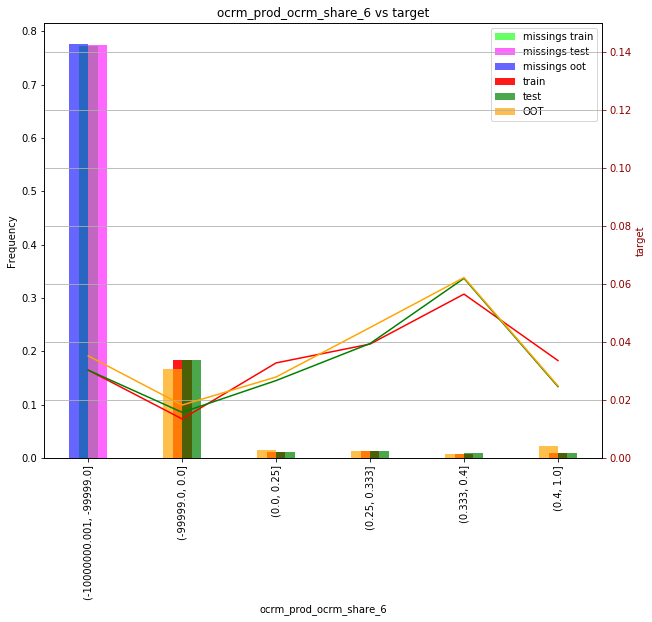

In [1004]:
#1
univariate_for_missing(X_train_final, y_train_final, X_test_final, y_test_final, X_OOT_final, y_OOT_final, 'ocrm_prod_ocrm_share_6', bins=20)

0.030321504005714532
0.030316963131124457
0.035244653609246314


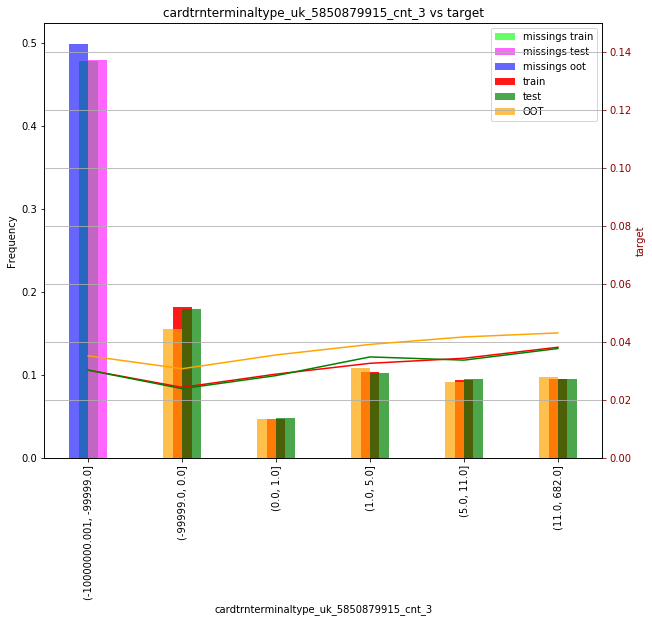

In [1003]:
#2
univariate_for_missing(X_train_final, y_train_final, X_test_final, y_test_final, X_OOT_final, y_OOT_final, 'cardtrnterminaltype_uk_5850879915_cnt_3', bins=5)

0.030321504005714532
0.030316963131124457
0.035244653609246314


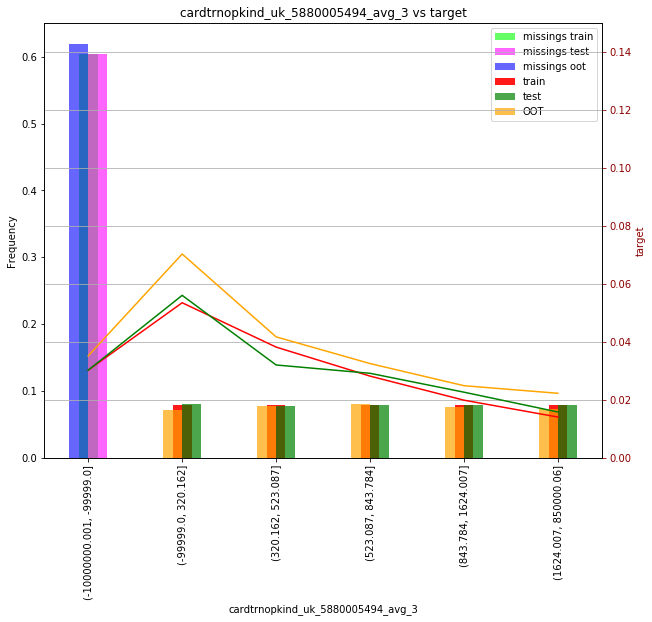

In [1002]:
#3
univariate_for_missing(X_train_final, y_train_final, X_test_final, y_test_final, X_OOT_final, y_OOT_final, 'cardtrnopkind_uk_5880005494_avg_3', bins=5)

0.030321504005714532
0.030316963131124457
0.035244653609246314


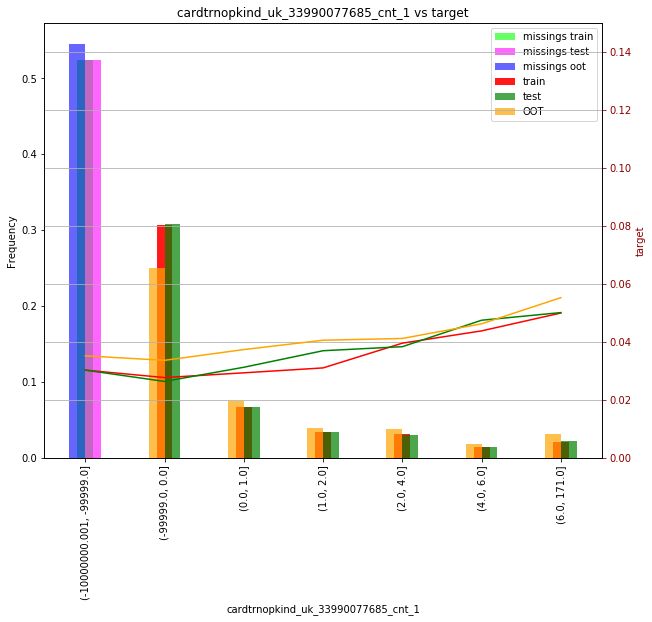

In [1001]:
#4
univariate_for_missing(X_train_final, y_train_final, X_test_final, y_test_final, X_OOT_final, y_OOT_final, 'cardtrnopkind_uk_33990077685_cnt_1', bins=20)

0.030321504005714532
0.030316963131124457
0.035244653609246314


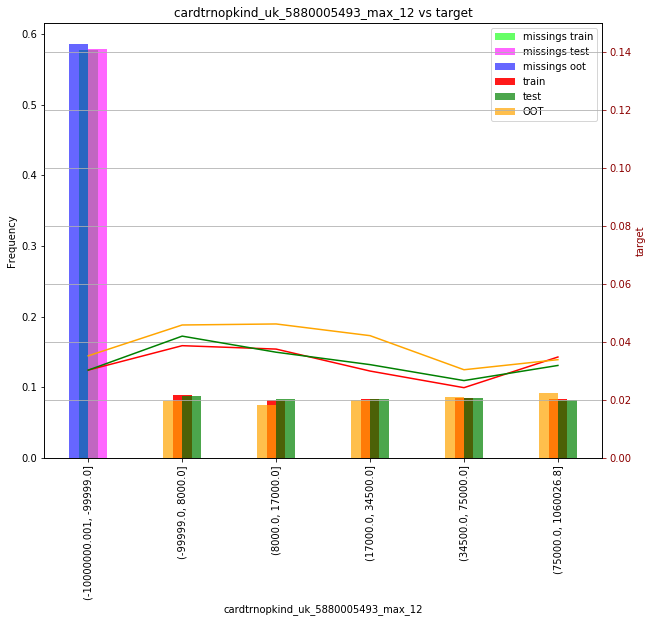

In [1000]:
#5
univariate_for_missing(X_train_final, y_train_final, X_test_final, y_test_final, X_OOT_final, y_OOT_final, 'cardtrnopkind_uk_5880005493_max_12', bins=5)

0.030321504005714532
0.030316963131124457
0.035244653609246314


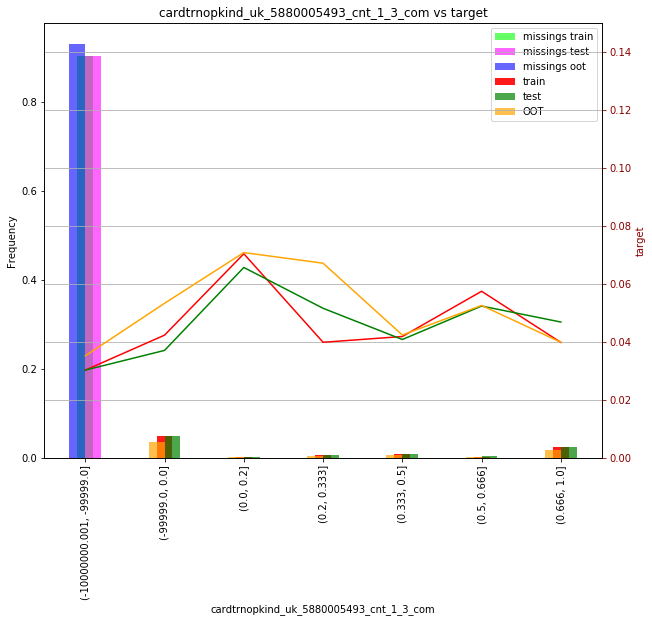

In [999]:
#6
univariate_for_missing(X_train_final, y_train_final, X_test_final, y_test_final, X_OOT_final, y_OOT_final, 'cardtrnopkind_uk_5880005493_cnt_1_3_com', bins=20)

0.030321504005714532
0.030316963131124457
0.035244653609246314


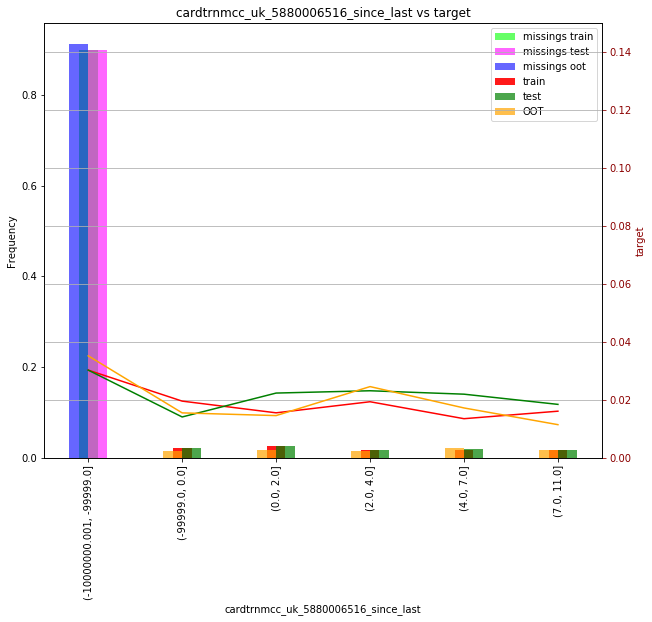

In [998]:
#7
univariate_for_missing(X_train_final, y_train_final, X_test_final, y_test_final, X_OOT_final, y_OOT_final, 'cardtrnmcc_uk_5880006516_since_last', bins=5)

0.030321504005714532
0.030316963131124457
0.035244653609246314


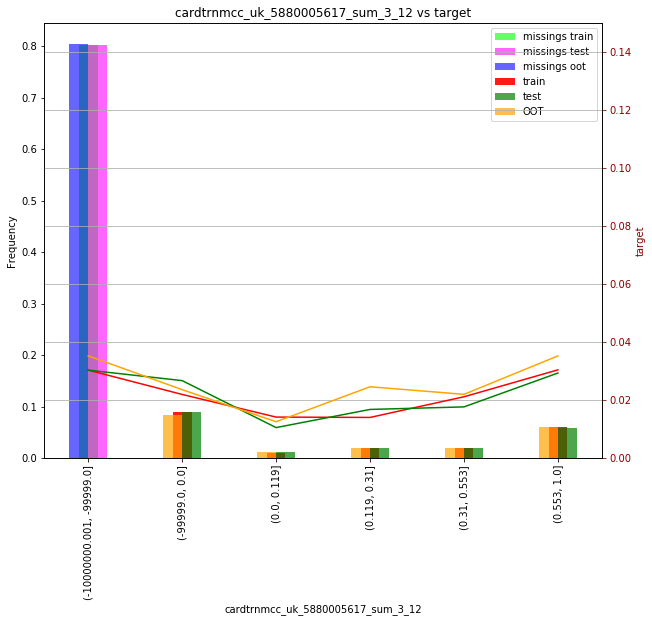

In [997]:
#8
univariate_for_missing(X_train_final, y_train_final, X_test_final, y_test_final, X_OOT_final, y_OOT_final, 'cardtrnmcc_uk_5880005617_sum_3_12', bins=10)

0.030321504005714532
0.030316963131124457
0.035244653609246314


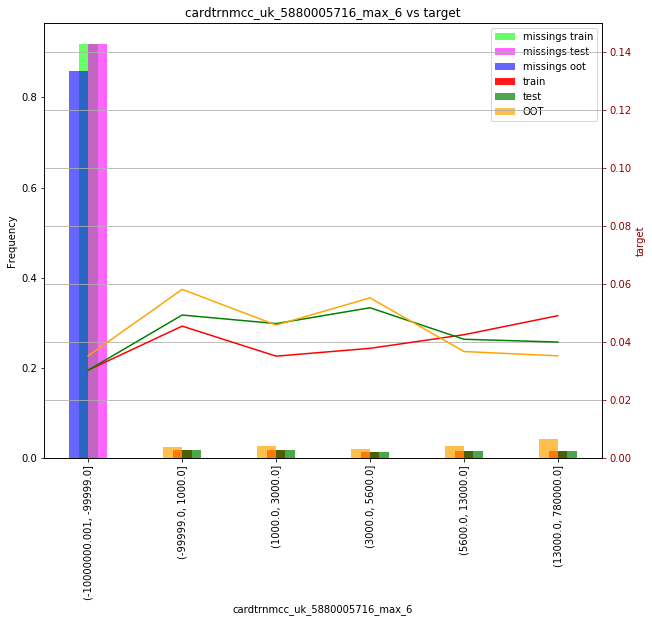

In [996]:
#9
univariate_for_missing(X_train_final, y_train_final, X_test_final, y_test_final, X_OOT_final, y_OOT_final, 'cardtrnmcc_uk_5880005716_max_6', bins=5)

0.030321504005714532
0.030316963131124457
0.035244653609246314


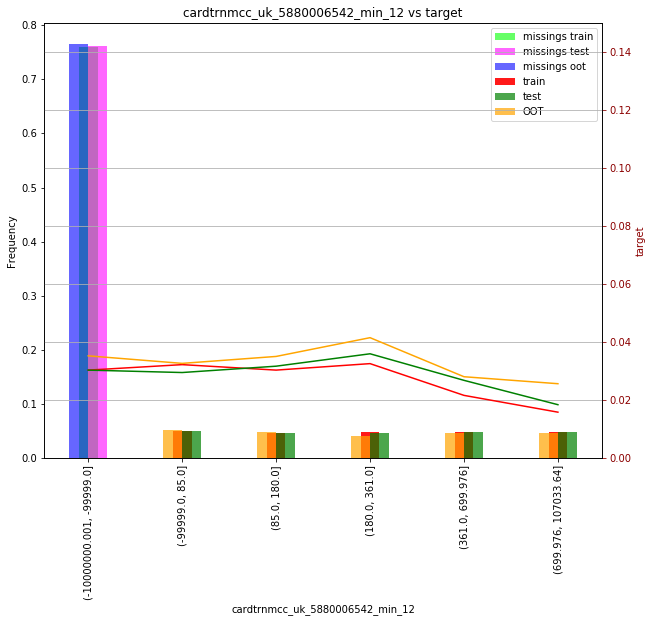

In [995]:
#10
univariate_for_missing(X_train_final, y_train_final, X_test_final, y_test_final, X_OOT_final, y_OOT_final, 'cardtrnmcc_uk_5880006542_min_12', bins=5)

0.030321504005714532
0.030316963131124457
0.035244653609246314


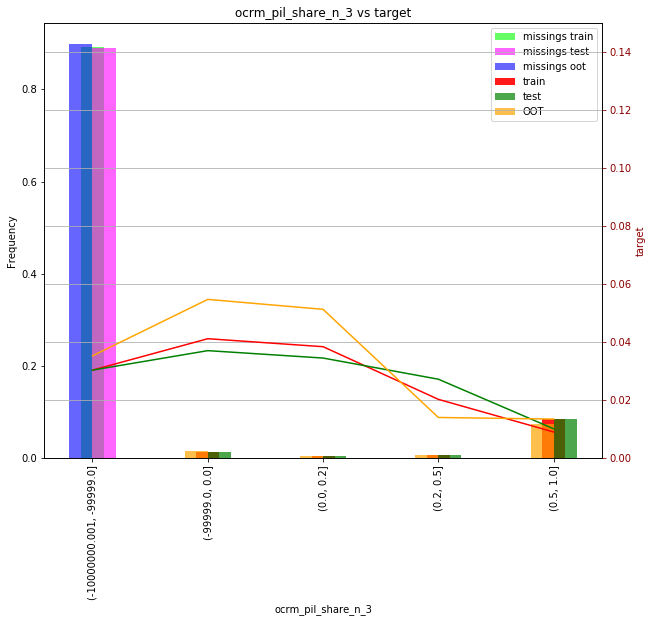

In [994]:
#11
univariate_for_missing(X_train_final, y_train_final, X_test_final, y_test_final, X_OOT_final, y_OOT_final, 'ocrm_pil_share_n_3', bins=20)

0.030321504005714532
0.030316963131124457
0.035244653609246314


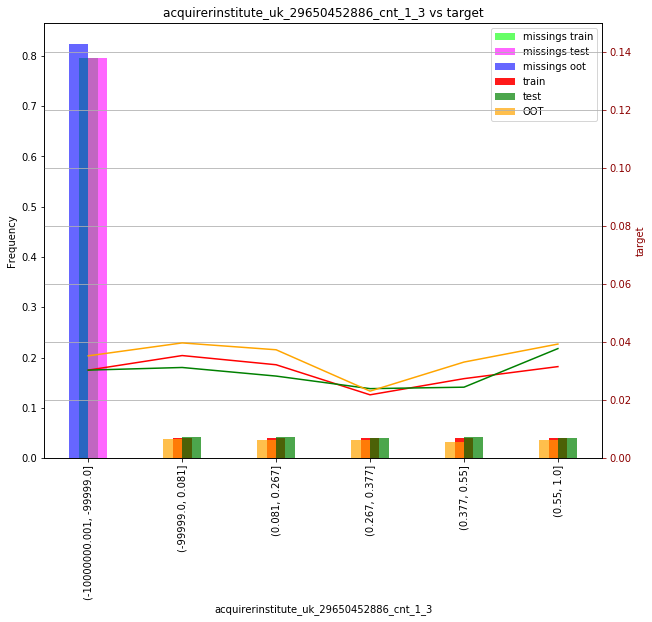

In [993]:
#12
univariate_for_missing(X_train_final, y_train_final, X_test_final, y_test_final, X_OOT_final, y_OOT_final, 'acquirerinstitute_uk_29650452886_cnt_1_3', bins=5)

0.030321504005714532
0.030316963131124457
0.035244653609246314


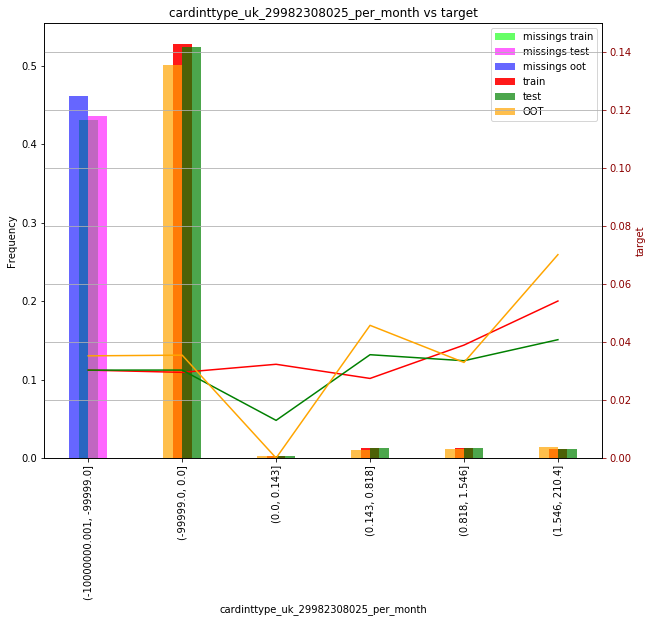

In [992]:
#13
univariate_for_missing(X_train_final, y_train_final, X_test_final, y_test_final, X_OOT_final, y_OOT_final, 'cardinttype_uk_29982308025_per_month', bins=45)

0.030321504005714532
0.030316963131124457
0.035244653609246314


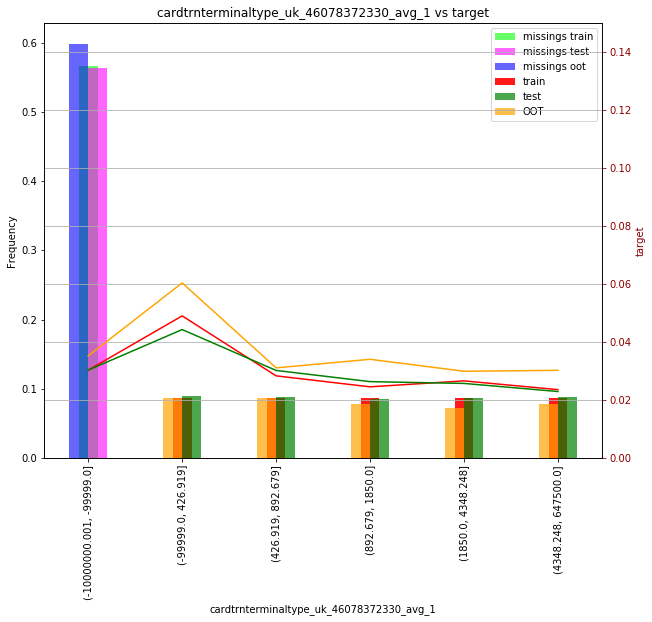

In [986]:
#14
univariate_for_missing(X_train_final, y_train_final, X_test_final, y_test_final, X_OOT_final, y_OOT_final, 'cardtrnterminaltype_uk_46078372330_avg_1', bins=5)

0.030321504005714532
0.030316963131124457
0.035244653609246314


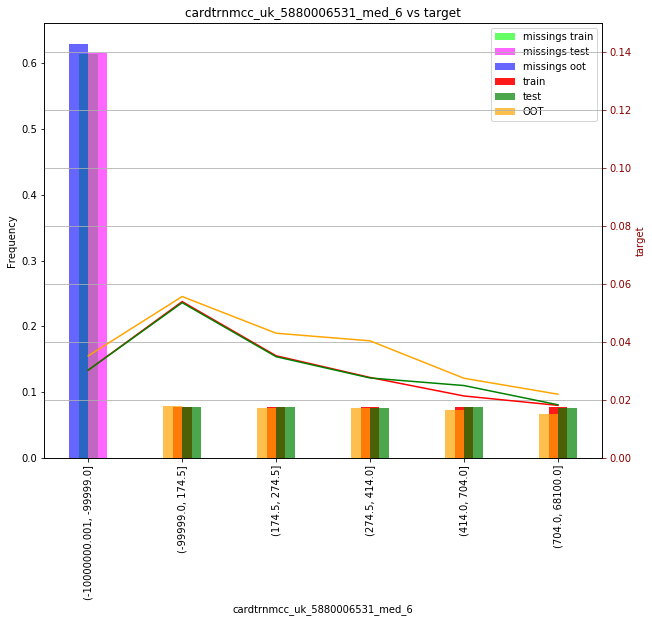

In [987]:
#15
univariate_for_missing(X_train_final, y_train_final, X_test_final, y_test_final, X_OOT_final, y_OOT_final, 'cardtrnmcc_uk_5880006531_med_6', bins=5)

0.030321504005714532
0.030316963131124457
0.035244653609246314


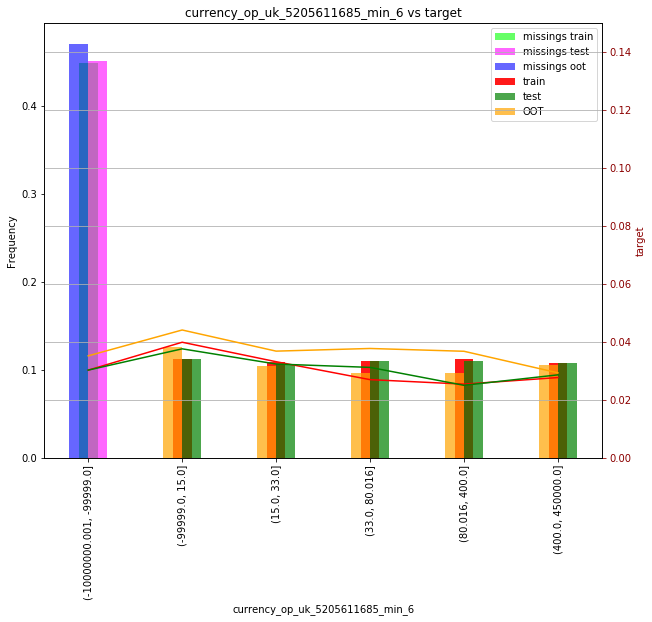

In [988]:
#16
univariate_for_missing(X_train_final, y_train_final, X_test_final, y_test_final, X_OOT_final, y_OOT_final, 'currency_op_uk_5205611685_min_6', bins=5)

0.030321504005714532
0.030316963131124457
0.035244653609246314


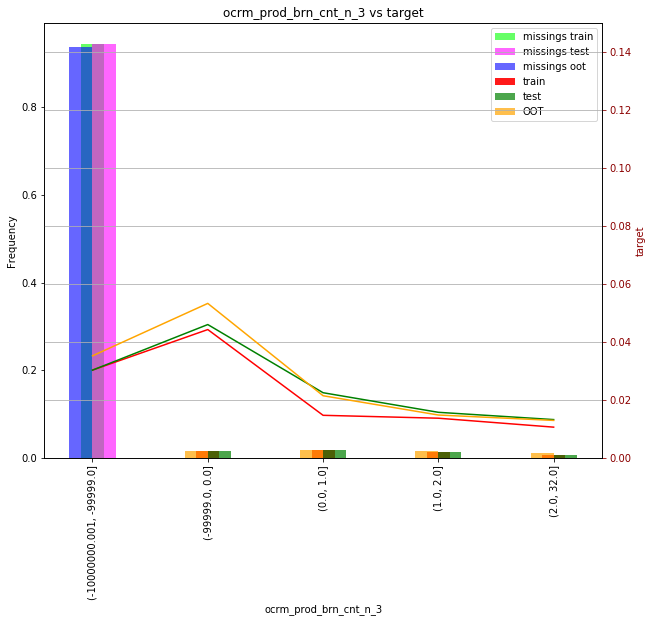

In [989]:
#17
univariate_for_missing(X_train_final, y_train_final, X_test_final, y_test_final, X_OOT_final, y_OOT_final, 'ocrm_prod_brn_cnt_n_3', bins=5)

0.030321504005714532
0.030316963131124457
0.035244653609246314


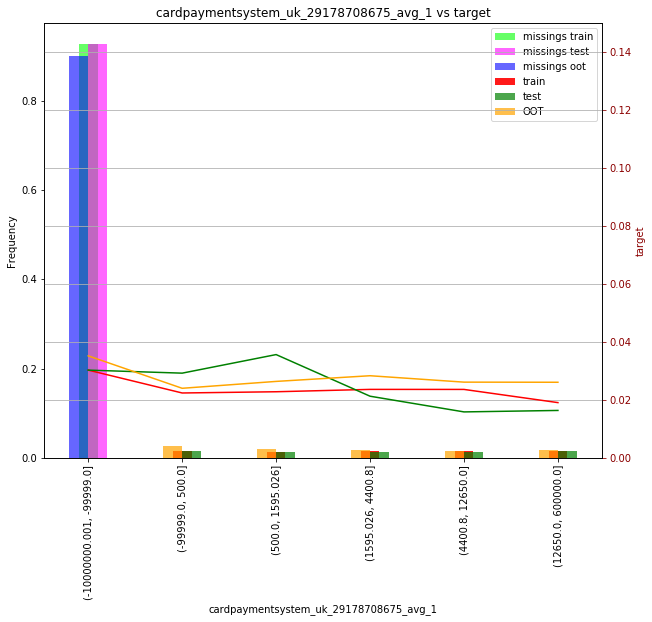

In [990]:
#18
univariate_for_missing(X_train_final, y_train_final, X_test_final, y_test_final, X_OOT_final, y_OOT_final, 'cardpaymentsystem_uk_29178708675_avg_1', bins=5)

0.030321504005714532
0.030316963131124457
0.035244653609246314


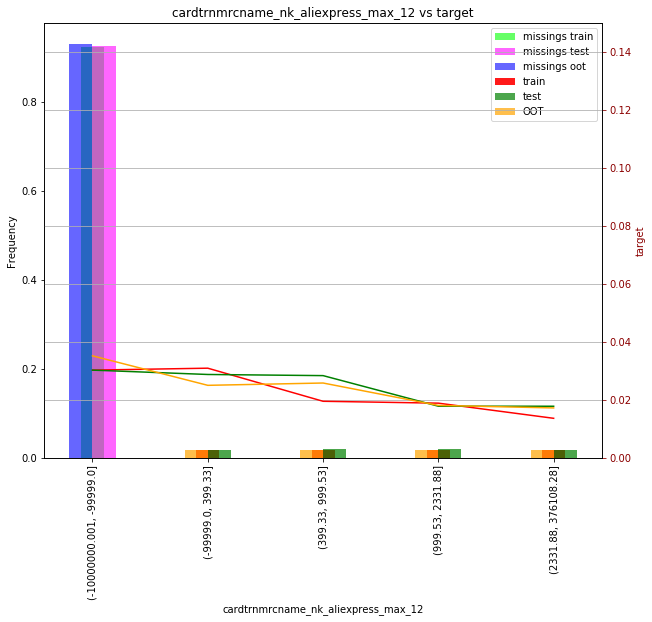

In [991]:
#19
univariate_for_missing(X_train_final, y_train_final, X_test_final, y_test_final, X_OOT_final, y_OOT_final, 'cardtrnmrcname_nk_aliexpress_max_12', bins=4)

# Forward к скору с отобранными фичами BI и фичами BI из модели PIL

In [1007]:
bi_features = ['ocrm_prod_ocrm_share_6',
'cardtrnterminaltype_uk_5850879915_cnt_3',
'cardtrnopkind_uk_5880005494_avg_3',
               
'cardtrnopkind_uk_33990077685_cnt_1',
'cardtrnopkind_uk_5880005493_max_12',
               
'cardtrnmcc_uk_5880005617_sum_3_12',
'cardtrnmcc_uk_5880006542_min_12',
'ocrm_pil_share_n_3',
'cardtrnterminaltype_uk_46078372330_avg_1',
'cardtrnmcc_uk_5880006531_med_6',
'currency_op_uk_5205611685_min_6',
'ocrm_prod_brn_cnt_n_3',
'cardtrnmrcname_nk_aliexpress_max_12']

pil_bi_features = ['ocrm_prod_share_n_6',
'cardtrnopkind_uk_33990077685_per_month',
'country_uk_5212617885_months',
'cardnum_ccode_nunique_6',
'other_sum_share_3',
'time_1_4_cnt_3',
'cardtrnoptype_uk_5880005597_sum_6',
'eoperationtype_uk_29178715243_cnt_1',
'min_12',
'ocrm_pil_cnt_6',
'cardtrnopkind_uk_5880005493_com_share_3']


hadoop = pd.read_csv('df_hdp.csv').set_index('app_id')

df_bi = hadoop[bi_features + pil_bi_features + ['prv_evtime_eom']]

In [1486]:
df_bi_scorecard = pd.merge(df_bi, df_sql.drop(['scoremarat'], axis=1), on=['app_id', 'prv_evtime_eom'], how='right').copy()
# df_bi_scorecard.drop(['pred_ml_score', 'pdscore18', 'eom'], axis=1, inplace=True)
df_bi_scorecard['MARITAL_STATUS'] = pd.to_numeric(df_bi_scorecard['MARITAL_STATUS'])
df_bi_scorecard['PRS_RELATIONSHIP'] = pd.to_numeric(df_bi_scorecard['PRS_RELATIONSHIP'])

In [1412]:
df_bi_score = pd.merge(df_bi, df_sql[['target','prv_evtime_eom','scoremarat']], on=['app_id', 'prv_evtime_eom'], how='right').copy()

In [1413]:
X, y, X_OOT, y_OOT = get_sample(df_bi_score)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.3, random_state=0)

In [1414]:
columns_forward = list(df_bi_score.columns.drop(['target', 'prv_evtime_eom']))

list_to_add = columns_forward.copy()
list_start = []
temp_df_bi = pd.DataFrame(columns=['feature', 'train', 'test', 'OOT'])


while len(list_to_add) != 0:
    forward_iteration = forward(list_start, columns_forward, X_train, X_test, y_train, y_test, X_OOT, y_OOT, best_params)
    temp_df_bi = temp_df_bi.append(forward_iteration, ignore_index=True)
    print(temp_df_bi)
    var = forward_iteration.values[0][0]
    list_start.append(var)
    list_to_add.remove(var)
    print(var)

1  feature:  cardtrnmrcname_nk_aliexpress_max_12 	train:  0.019 	test:  0.022 	oot:  0.021
2  feature:  scoremarat 	train:  0.535 	test:  0.532 	oot:  0.528
3  feature:  ocrm_pil_cnt_6 	train:  0.056 	test:  0.057 	oot:  0.047
4  feature:  ocrm_prod_brn_cnt_n_3 	train:  0.021 	test:  0.018 	oot:  0.023
5  feature:  cardtrnterminaltype_uk_46078372330_avg_1 	train:  0.066 	test:  0.068 	oot:  0.06
6  feature:  currency_op_uk_5205611685_min_6 	train:  0.052 	test:  0.032 	oot:  0.026
7  feature:  time_1_4_cnt_3 	train:  0.045 	test:  0.03 	oot:  0.038
8  feature:  eoperationtype_uk_29178715243_cnt_1 	train:  0.016 	test:  0.025 	oot:  0.023
9  feature:  cardtrnmcc_uk_5880006542_min_12 	train:  0.027 	test:  0.025 	oot:  0.02
10  feature:  cardtrnopkind_uk_33990077685_cnt_1 	train:  0.05 	test:  0.036 	oot:  0.033
11  feature:  cardtrnopkind_uk_5880005493_com_share_3 	train:  0.031 	test:  0.029 	oot:  0.027
12  feature:  cardnum_ccode_nunique_6 	train:  0.016 	test:  -0.002 	oot:  -0.0
13

20  feature:  cardtrnopkind_uk_33990077685_per_month 	train:  0.544 	test:  0.539 	oot:  0.531
21  feature:  min_12 	train:  0.543 	test:  0.538 	oot:  0.53
22  feature:  cardtrnmcc_uk_5880005617_sum_3_12 	train:  0.543 	test:  0.539 	oot:  0.53
                              feature     train      test       OOT
0                          scoremarat  0.535101  0.532448  0.527595
1                 ocrm_prod_share_n_6  0.539103  0.535316  0.529063
2  cardtrnopkind_uk_5880005493_max_12  0.542073  0.538570  0.530118
3   cardtrnopkind_uk_5880005494_avg_3  0.544657  0.539599  0.531410
cardtrnopkind_uk_5880005494_avg_3
1  feature:  cardtrnmrcname_nk_aliexpress_max_12 	train:  0.545 	test:  0.54 	oot:  0.532
2  feature:  ocrm_pil_cnt_6 	train:  0.545 	test:  0.539 	oot:  0.531
3  feature:  ocrm_prod_brn_cnt_n_3 	train:  0.544 	test:  0.54 	oot:  0.531
4  feature:  cardtrnterminaltype_uk_46078372330_avg_1 	train:  0.546 	test:  0.541 	oot:  0.532
5  feature:  currency_op_uk_5205611685_min_6 	tr

13  feature:  ocrm_pil_share_n_3 	train:  0.549 	test:  0.542 	oot:  0.533
14  feature:  eoperationtype_uk_29178715243_cnt_1 	train:  0.549 	test:  0.542 	oot:  0.534
15  feature:  cardtrnopkind_uk_33990077685_per_month 	train:  0.549 	test:  0.543 	oot:  0.534
16  feature:  cardnum_ccode_nunique_6 	train:  0.55 	test:  0.542 	oot:  0.534
17  feature:  cardtrnmcc_uk_5880006542_min_12 	train:  0.549 	test:  0.543 	oot:  0.532
18  feature:  cardtrnmcc_uk_5880005617_sum_3_12 	train:  0.549 	test:  0.544 	oot:  0.534
                                   feature     train      test       OOT
0                               scoremarat  0.535101  0.532448  0.527595
1                      ocrm_prod_share_n_6  0.539103  0.535316  0.529063
2       cardtrnopkind_uk_5880005493_max_12  0.542073  0.538570  0.530118
3        cardtrnopkind_uk_5880005494_avg_3  0.544657  0.539599  0.531410
4       cardtrnopkind_uk_33990077685_cnt_1  0.547280  0.541530  0.531759
5  cardtrnopkind_uk_5880005493_com_share_3 

8  feature:  time_1_4_cnt_3 	train:  0.551 	test:  0.542 	oot:  0.534
9  feature:  country_uk_5212617885_months 	train:  0.551 	test:  0.542 	oot:  0.534
10  feature:  ocrm_pil_share_n_3 	train:  0.551 	test:  0.541 	oot:  0.534
11  feature:  eoperationtype_uk_29178715243_cnt_1 	train:  0.551 	test:  0.541 	oot:  0.534
12  feature:  cardtrnopkind_uk_33990077685_per_month 	train:  0.551 	test:  0.542 	oot:  0.534
13  feature:  min_12 	train:  0.551 	test:  0.541 	oot:  0.534
14  feature:  cardtrnmcc_uk_5880005617_sum_3_12 	train:  0.551 	test:  0.542 	oot:  0.534
                                    feature     train      test       OOT
0                                scoremarat  0.535101  0.532448  0.527595
1                       ocrm_prod_share_n_6  0.539103  0.535316  0.529063
2        cardtrnopkind_uk_5880005493_max_12  0.542073  0.538570  0.530118
3         cardtrnopkind_uk_5880005494_avg_3  0.544657  0.539599  0.531410
4        cardtrnopkind_uk_33990077685_cnt_1  0.547280  0.5415

5  feature:  cardtrnterminaltype_uk_5850879915_cnt_3 	train:  0.552 	test:  0.543 	oot:  0.534
6  feature:  cardtrnmcc_uk_5880006531_med_6 	train:  0.552 	test:  0.543 	oot:  0.534
7  feature:  cardtrnopkind_uk_33990077685_per_month 	train:  0.552 	test:  0.543 	oot:  0.534
8  feature:  eoperationtype_uk_29178715243_cnt_1 	train:  0.552 	test:  0.543 	oot:  0.534
9  feature:  min_12 	train:  0.552 	test:  0.543 	oot:  0.535
10  feature:  cardtrnmcc_uk_5880005617_sum_3_12 	train:  0.552 	test:  0.544 	oot:  0.535
                                    feature     train      test       OOT
0                                scoremarat  0.535101  0.532448  0.527595
1                       ocrm_prod_share_n_6  0.539103  0.535316  0.529063
2        cardtrnopkind_uk_5880005493_max_12  0.542073  0.538570  0.530118
3         cardtrnopkind_uk_5880005494_avg_3  0.544657  0.539599  0.531410
4        cardtrnopkind_uk_33990077685_cnt_1  0.547280  0.541530  0.531759
5   cardtrnopkind_uk_5880005493_com_sh

2  feature:  ocrm_prod_brn_cnt_n_3 	train:  0.553 	test:  0.544 	oot:  0.536
3  feature:  cardtrnmcc_uk_5880006531_med_6 	train:  0.553 	test:  0.544 	oot:  0.536
4  feature:  cardtrnopkind_uk_33990077685_per_month 	train:  0.553 	test:  0.544 	oot:  0.536
5  feature:  eoperationtype_uk_29178715243_cnt_1 	train:  0.552 	test:  0.544 	oot:  0.536
6  feature:  cardtrnterminaltype_uk_5850879915_cnt_3 	train:  0.553 	test:  0.545 	oot:  0.536
                                     feature     train      test       OOT
0                                 scoremarat  0.535101  0.532448  0.527595
1                        ocrm_prod_share_n_6  0.539103  0.535316  0.529063
2         cardtrnopkind_uk_5880005493_max_12  0.542073  0.538570  0.530118
3          cardtrnopkind_uk_5880005494_avg_3  0.544657  0.539599  0.531410
4         cardtrnopkind_uk_33990077685_cnt_1  0.547280  0.541530  0.531759
5    cardtrnopkind_uk_5880005493_com_share_3  0.548995  0.541338  0.532494
6        cardtrnmrcname_nk_aliex

1  feature:  cardtrnterminaltype_uk_5850879915_cnt_3 	train:  0.552 	test:  0.543 	oot:  0.535
2  feature:  ocrm_prod_ocrm_share_6 	train:  0.553 	test:  0.543 	oot:  0.535
                                     feature     train      test       OOT
0                                 scoremarat  0.535101  0.532448  0.527595
1                        ocrm_prod_share_n_6  0.539103  0.535316  0.529063
2         cardtrnopkind_uk_5880005493_max_12  0.542073  0.538570  0.530118
3          cardtrnopkind_uk_5880005494_avg_3  0.544657  0.539599  0.531410
4         cardtrnopkind_uk_33990077685_cnt_1  0.547280  0.541530  0.531759
5    cardtrnopkind_uk_5880005493_com_share_3  0.548995  0.541338  0.532494
6        cardtrnmrcname_nk_aliexpress_max_12  0.549130  0.542868  0.533320
7                    cardnum_ccode_nunique_6  0.549645  0.542339  0.533607
8                          other_sum_share_3  0.548893  0.540500  0.531414
9          cardtrnoptype_uk_5880005597_sum_6  0.550760  0.542854  0.534250
10

In [1415]:
temp_df_bi

feature     train      test       OOT
0                                 scoremarat  0.535101  0.532448  0.527595
1                        ocrm_prod_share_n_6  0.539103  0.535316  0.529063
2         cardtrnopkind_uk_5880005493_max_12  0.542073  0.538570  0.530118
3          cardtrnopkind_uk_5880005494_avg_3  0.544657  0.539599  0.531410
4         cardtrnopkind_uk_33990077685_cnt_1  0.547280  0.541530  0.531759
5    cardtrnopkind_uk_5880005493_com_share_3  0.548995  0.541338  0.532494
6        cardtrnmrcname_nk_aliexpress_max_12  0.549130  0.542868  0.533320
7                    cardnum_ccode_nunique_6  0.549645  0.542339  0.533607
8                          other_sum_share_3  0.548893  0.540500  0.531414
9          cardtrnoptype_uk_5880005597_sum_6  0.550760  0.542854  0.534250
10           cardtrnmcc_uk_5880006542_min_12  0.550757  0.542341  0.534157
11              country_uk_5212617885_months  0.551299  0.542025  0.534233
12                        ocrm_pil_share_n_3  0.551601  0.542778  0.535311
13                            time_1_4_cnt_3  0.552212  0.543209  0.535866
14           currency_op_uk_5205611685_min_6  0.552285  0.543968  0.534517
15                                    min_12  0.552478  0.542896  0.534520
16         cardtrnmcc_uk_5880005617_sum_3_12  0.552660  0.544307  0.535644
17  cardtrnterminaltype_uk_46078372330_avg_1  0.552836  0.543661  0.534499
18                            ocrm_pil_cnt_6  0.552748  0.544269  0.536079
19    cardtrnopkind_uk_33990077685_per_month  0.553195  0.544053  0.535510
20                     ocrm_prod_brn_cnt_n_3  0.552525  0.544253  0.535656
21       eoperationtype_uk_29178715243_cnt_1  0.553328  0.543971  0.536861
22            cardtrnmcc_uk_5880006531_med_6  0.552888  0.544046  0.535683
23                    ocrm_prod_ocrm_share_6  0.552938  0.542801  0.535086
24   cardtrnterminaltype_uk_5850879915_cnt_3  0.552400  0.543818  0.535939

In [1418]:
df_bi_score_uplift = df_bi_score[temp_df_bi['feature'].tolist() + ['target', 'prv_evtime_eom']]

In [1421]:
X_final, y_final, X_OOT_final, y_OOT_final = get_sample(df_bi_score_uplift)
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_final, y_final, stratify = y_final, test_size = 0.3, random_state = 0)

In [1422]:
params = {
    'n_estimators': 200,
    'learning_rate': 0.1,
    'num_leaves': 20,
    'max_depth': 1,
    'min_child_weight': 10,
    'lambda_l1':2,
    'lambda_l2':3,
    'min_data_in_leaf' :10,
    'min_sum_hessian_in_leaf' : 0.0001,
    'bagging_fraction' : 0.8,
    'max_bin': 12,
    'feature_fraction' : 0.9,
    'bagging_freq' : 100,
    'min_gain_to_split': 0.1}
def objective(params):
    params = {
    'n_estimators': int(params['n_estimators']),
    'learning_rate': params['learning_rate'],
    'num_leaves': int(params['num_leaves']),
    'max_depth': 1,
    'min_child_weight': int(params['min_child_weight']),
    'lambda_l1':params['lambda_l1'],
    'lambda_l2':params['lambda_l2'],
    'min_data_in_leaf' :int(params['min_data_in_leaf']),
    'min_sum_hessian_in_leaf' : params['min_sum_hessian_in_leaf'],
    'bagging_fraction' : params['bagging_fraction'],
    'max_bin': int(params['max_bin']),
    'feature_fraction' : params['feature_fraction'],
    'bagging_freq' : int(params['bagging_freq']),
    'min_gain_to_split': params['min_gain_to_split']
    }

    gini_test = validate_hyperopt(X_final, y_final, X_OOT_final, y_OOT_final, 1, params)
    
    score = gini_test
    print("Gini ", round(score, 3) , '   params: ', params)
    return -score
space = {
    'n_estimators': hp.quniform('n_estimators', 190, 250, 1),
    'num_leaves': hp.quniform('num_leaves', 5, 80, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 70, 1),
    'learning_rate': hp.uniform('learning_rate', 0.1, 0.3),
    'max_bin': hp.quniform('max_bin', 9, 40, 1),
    'min_data_in_leaf': hp.quniform('min_data_in_leaf', 10, 50, 1), 
    'lambda_l1': hp.uniform('lambda_l1', 0, 3), 
    'lambda_l2': hp.uniform('lambda_l2', 0, 3),
    'min_data_in_leaf' :hp.quniform('min_data_in_leaf', 5, 50, 1),
    'min_sum_hessian_in_leaf' : hp.uniform('min_sum_hessian_in_leaf', 0, 0.01),
    'bagging_fraction' : hp.uniform('bagging_fraction', 0, 0.9),
    'max_bin': hp.quniform('max_bin', 10, 30, 1),
    'feature_fraction' : hp.uniform('feature_fraction', 0, 0.9),
    'bagging_freq' : hp.quniform('bagging_freq', 10, 1000, 10),
    'min_gain_to_split': hp.uniform('min_gain_to_split', 0.1, 1),     }

In [1423]:
best__ = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)

0.548 0.544 0.536
Gini  0.544    params:  {'n_estimators': 237, 'learning_rate': 0.21578636768832346, 'num_leaves': 62, 'max_depth': 1, 'min_child_weight': 51, 'lambda_l1': 1.7884046968503329, 'lambda_l2': 1.6950672899145527, 'min_data_in_leaf': 44, 'min_sum_hessian_in_leaf': 0.001215124459297451, 'bagging_fraction': 0.4593552729592073, 'max_bin': 18, 'feature_fraction': 0.44411916349529307, 'bagging_freq': 810, 'min_gain_to_split': 0.5441358209498709}
0.539 0.535 0.524
Gini  0.535    params:  {'n_estimators': 247, 'learning_rate': 0.15845015542791605, 'num_leaves': 64, 'max_depth': 1, 'min_child_weight': 28, 'lambda_l1': 1.0475616679499598, 'lambda_l2': 1.4403637317048252, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 2.2331724961377477e-06, 'bagging_fraction': 0.7079268769028149, 'max_bin': 25, 'feature_fraction': 0.0733033322383953, 'bagging_freq': 90, 'min_gain_to_split': 0.9668393787484688}
0.544 0.543 0.532
Gini  0.543    params:  {'n_estimators': 210, 'learning_rate': 0.133

0.546 0.543 0.533
Gini  0.543    params:  {'n_estimators': 235, 'learning_rate': 0.2749436105987574, 'num_leaves': 69, 'max_depth': 1, 'min_child_weight': 32, 'lambda_l1': 0.6727034187143791, 'lambda_l2': 2.417904889358216, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 0.008952727569038352, 'bagging_fraction': 0.22318708430715686, 'max_bin': 20, 'feature_fraction': 0.6968354567535995, 'bagging_freq': 110, 'min_gain_to_split': 0.2943381222477232}
0.53 0.533 0.52
Gini  0.533    params:  {'n_estimators': 202, 'learning_rate': 0.24640423171081607, 'num_leaves': 54, 'max_depth': 1, 'min_child_weight': 2, 'lambda_l1': 0.08875129508120372, 'lambda_l2': 0.7249735355512671, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 0.007776702146194902, 'bagging_fraction': 0.028798543460634707, 'max_bin': 18, 'feature_fraction': 0.32239412679878565, 'bagging_freq': 280, 'min_gain_to_split': 0.6956357420147118}
0.535 0.533 0.522
Gini  0.533    params:  {'n_estimators': 197, 'learning_rate': 0.247030

0.551 0.549 0.537
Gini  0.549    params:  {'n_estimators': 208, 'learning_rate': 0.21848386871307013, 'num_leaves': 31, 'max_depth': 1, 'min_child_weight': 55, 'lambda_l1': 2.8780471844688673, 'lambda_l2': 2.2473757173117646, 'min_data_in_leaf': 29, 'min_sum_hessian_in_leaf': 0.007089762612001381, 'bagging_fraction': 0.8399379932101466, 'max_bin': 25, 'feature_fraction': 0.34948683129349634, 'bagging_freq': 330, 'min_gain_to_split': 0.8257557973047471}
0.548 0.547 0.536
Gini  0.547    params:  {'n_estimators': 191, 'learning_rate': 0.20248698233553133, 'num_leaves': 76, 'max_depth': 1, 'min_child_weight': 21, 'lambda_l1': 0.25126776424871666, 'lambda_l2': 1.3698152000550574, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 0.005357390132623563, 'bagging_fraction': 0.6426128472504278, 'max_bin': 17, 'feature_fraction': 0.8972216590771499, 'bagging_freq': 520, 'min_gain_to_split': 0.9235567299465705}
0.541 0.541 0.527
Gini  0.541    params:  {'n_estimators': 226, 'learning_rate': 0.235

In [1424]:
best__

{'bagging_fraction': 0.8988929254629591,
 'bagging_freq': 30.0,
 'feature_fraction': 0.8475605624589264,
 'lambda_l1': 2.2167386652989207,
 'lambda_l2': 2.7673191979583516,
 'learning_rate': 0.2262822333079889,
 'max_bin': 13.0,
 'min_child_weight': 5.0,
 'min_data_in_leaf': 20.0,
 'min_gain_to_split': 0.869815228413259,
 'min_sum_hessian_in_leaf': 0.0013891063469162368,
 'n_estimators': 216.0,
 'num_leaves': 48.0}

In [1425]:
best_params = {'n_estimators': 216, 'learning_rate': 0.2262822333079889, 'num_leaves': 48, 'max_depth': 1, 'min_child_weight': 5, 'lambda_l1': 2.2167386652989207, 'lambda_l2': 2.7673191979583516, 'min_data_in_leaf': 20, 'min_sum_hessian_in_leaf': 0.0013891063469162368, 'bagging_fraction': 0.8988929254629591, 'max_bin': 13, 'feature_fraction': 0.8475605624589264, 'bagging_freq': 30, 'min_gain_to_split': 0.869815228413259}

In [1426]:
clf = lightgbm.LGBMClassifier(n_estimators=best_params['n_estimators'],
learning_rate=best_params['learning_rate'],
num_leaves=best_params['num_leaves'],
max_depth=best_params['max_depth'],
min_child_weight=best_params['min_child_weight'],
lambda_l1=best_params['lambda_l1'],
lambda_l2=best_params['lambda_l2'],
min_data_in_leaf=best_params['min_data_in_leaf'],
min_sum_hessian_in_leaf=best_params['min_sum_hessian_in_leaf'],
bagging_fraction=best_params['bagging_fraction'],
max_bin=best_params['max_bin'],
feature_fraction=best_params['feature_fraction'],
bagging_freq=best_params['bagging_freq'],
min_gain_to_split=best_params['min_gain_to_split'],                                                 
n_jobs=60)

clf.fit(X_final, y_final, 
         eval_metric='auc', verbose=False
       )

pred_train = clf.predict_proba(X_train_final, num_iteration=clf.best_iteration_)[:, 1]
pred_oot = clf.predict_proba(X_OOT_final, num_iteration=clf.best_iteration_)[:, 1]

gini_train = 2 * roc_auc_score(y_train_final, pred_train) - 1
gini_oot = 2 * roc_auc_score(y_OOT_final, pred_oot) - 1

print(gini_train, gini_oot)

X_marat, y_marat, X_OOT_marat, y_OOT_marat = get_sample(df_hdp_score)

print(roc_auc_score(y_marat, -X_marat['scoremarat']) * 2 - 1,    roc_auc_score(y_OOT_marat, -X_OOT_marat['scoremarat']) * 2 - 1)

0.5490201138934097 0.5347247351215985
0.5385116723959538 0.5417411806154375


In [1427]:
pred_train = clf.predict_proba(X_train_final, num_iteration=clf.best_iteration_)[:, 1]
pred_test = clf.predict_proba(X_test_final, num_iteration=clf.best_iteration_)[:, 1]
pred_oot = clf.predict_proba(X_OOT_final, num_iteration=clf.best_iteration_)[:, 1]

gini_train = 2 * roc_auc_score(y_train_final, pred_train) - 1
gini_test = 2 * roc_auc_score(y_test_final, pred_test) - 1
gini_oot = 2 * roc_auc_score(y_OOT_final, pred_oot) - 1

print(gini_train, gini_test, gini_oot)

0.5490201138934097 0.5473319341754643 0.5347247351215985


# Univariate BI PIL

In [ ]:
pil_bi_features = ['ocrm_prod_share_n_6',
'cardtrnopkind_uk_33990077685_per_month',
'country_uk_5212617885_months',
'cardnum_ccode_nunique_6',
'other_sum_share_3',
'time_1_4_cnt_3',
'cardtrnoptype_uk_5880005597_sum_6',
'eoperationtype_uk_29178715243_cnt_1',
'min_12',
'ocrm_pil_cnt_6',
'cardtrnopkind_uk_5880005493_com_share_3']

In [1639]:
df_bi_pil = pd.merge(df_bi, df_sql[['evtime', 'target']], on=['app_id'], how='left').copy()
df_bi_pil.dropna(subset=['evtime'], inplace=True)

In [1669]:
df_bi_pil.shape

(289787, 28)

In [1649]:
missing_values_table(df_bi_pil)

Your selected dataframe has 28 columns.
There are 24 columns that have missing values.


Missing Values  % of Total Values
ocrm_prod_brn_cnt_n_3                             273133               94.3
cardtrnmrcname_nk_aliexpress_max_12               268254               92.6
ocrm_pil_share_n_3                                258669               89.3
cardtrnmcc_uk_5880005617_sum_3_12                 232604               80.3
ocrm_prod_share_n_6                               224098               77.3
ocrm_prod_ocrm_share_6                            224098               77.3
cardtrnmcc_uk_5880006542_min_12                   220757               76.2
eoperationtype_uk_29178715243_cnt_1               220708               76.2
other_sum_share_3                                 206327               71.2
cardtrnopkind_uk_5880005493_com_share_3           192701               66.5
min_12                                            185799               64.1
cardtrnmcc_uk_5880006531_med_6                    178981               61.8
cardtrnopkind_uk_5880005494_avg_3                 175796               60.7
cardtrnopkind_uk_5880005493_max_12                167748               57.9
cardtrnterminaltype_uk_46078372330_avg_1          165630               57.2
ocrm_pil_cnt_6                                    161480               55.7
cardtrnopkind_uk_33990077685_cnt_1                153118               52.8
cardtrnterminaltype_uk_5850879915_cnt_3           139916               48.3
time_1_4_cnt_3                                    139916               48.3
currency_op_uk_5205611685_min_6                   131432               45.4
cardnum_ccode_nunique_6                           131273               45.3
cardtrnoptype_uk_5880005597_sum_6                 131273               45.3
cardtrnopkind_uk_33990077685_per_month            127054               43.8
country_uk_5212617885_months                      119643               41.3

In [1640]:
X_final, y_final, X_OOT_final, y_OOT_final = get_sample_evtime(df_bi_pil)
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_final, y_final, stratify = y_final, test_size = 0.3, random_state = 0)

0.030321504005714532
0.030316963131124457
0.03534846702193924


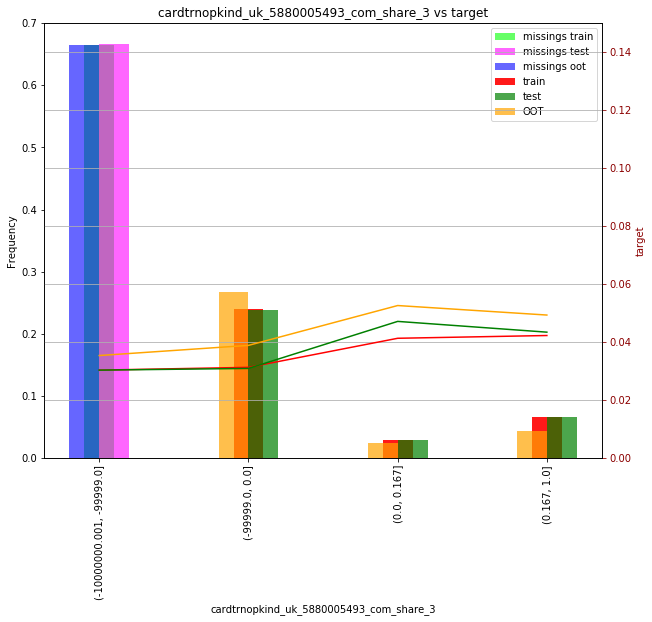

In [1642]:
#1
univariate_for_missing(X_train_final, y_train_final, X_test_final, y_test_final, X_OOT_final, y_OOT_final, 'cardtrnopkind_uk_5880005493_com_share_3', bins=5)

0.030321504005714532
0.030316963131124457
0.03534846702193924


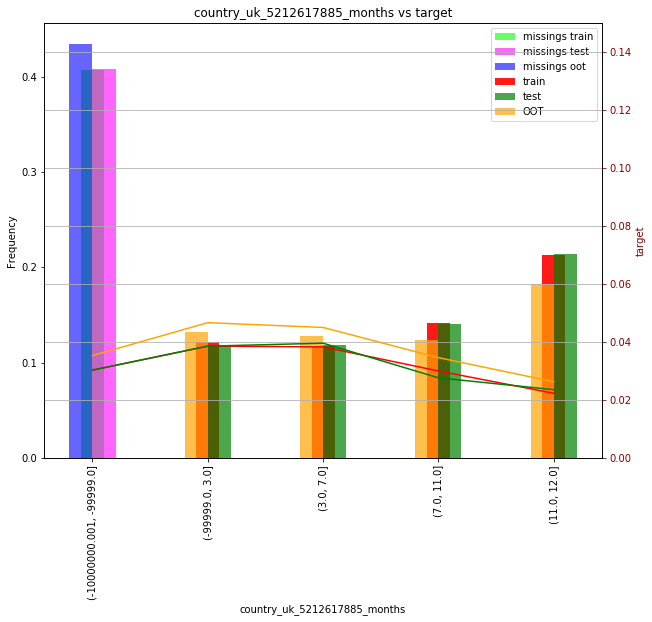

In [1643]:
#2
univariate_for_missing(X_train_final, y_train_final, X_test_final, y_test_final, X_OOT_final, y_OOT_final, 'country_uk_5212617885_months', bins=5)

0.030321504005714532
0.030316963131124457
0.03534846702193924


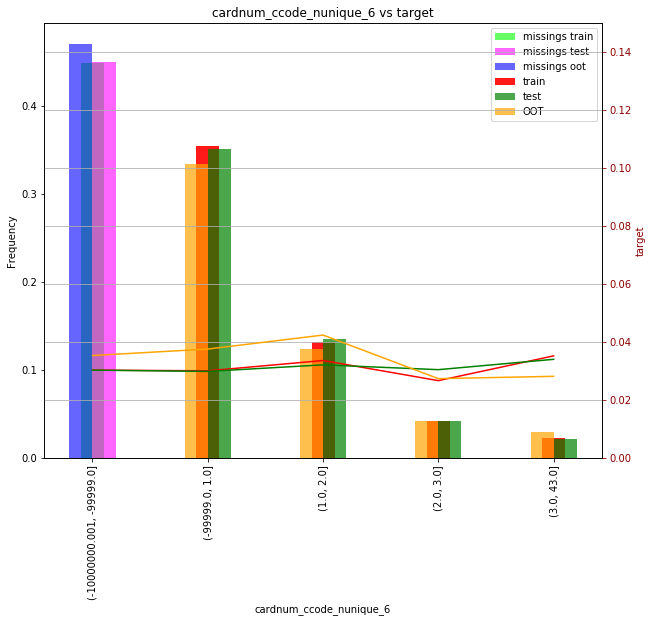

In [1647]:
#3
univariate_for_missing(X_train_final, y_train_final, X_test_final, y_test_final, X_OOT_final, y_OOT_final, 'cardnum_ccode_nunique_6', bins=16)

0.030321504005714532
0.030316963131124457
0.03534846702193924


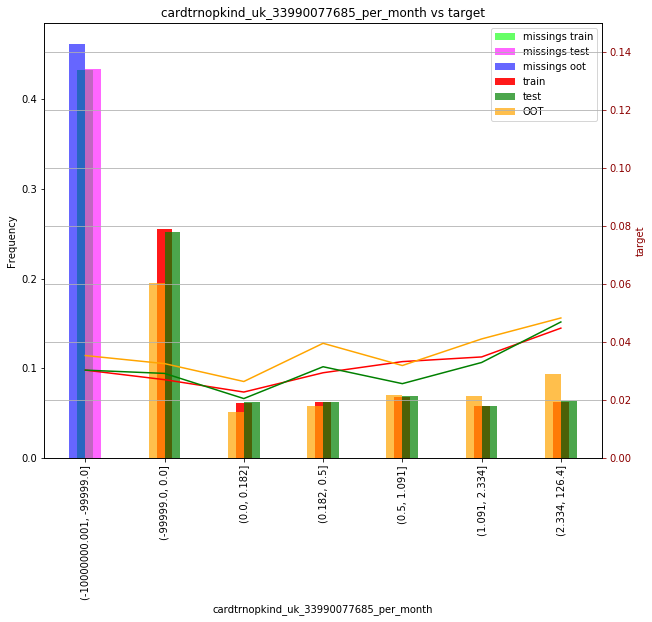

In [1653]:
#4
univariate_for_missing(X_train_final, y_train_final, X_test_final, y_test_final, X_OOT_final, y_OOT_final, 'cardtrnopkind_uk_33990077685_per_month', bins=9)

0.030321504005714532
0.030316963131124457
0.03534846702193924


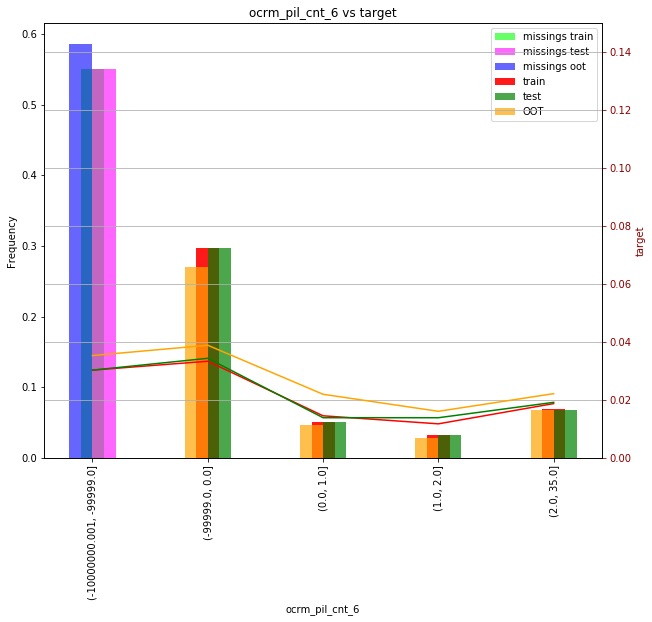

In [1670]:
#5
univariate_for_missing(X_train_final, y_train_final, X_test_final, y_test_final, X_OOT_final, y_OOT_final, 'ocrm_pil_cnt_6', bins=6)

0.030321504005714532
0.030316963131124457
0.03534846702193924


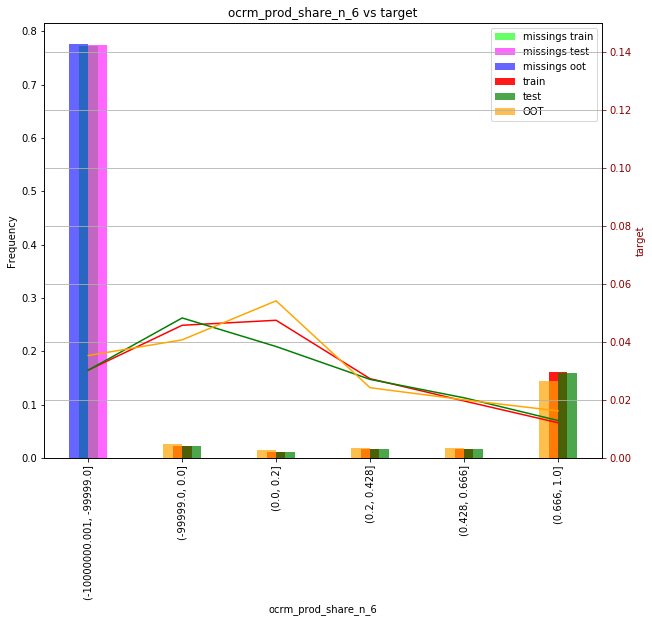

In [1656]:
#6
univariate_for_missing(X_train_final, y_train_final, X_test_final, y_test_final, X_OOT_final, y_OOT_final, 'ocrm_prod_share_n_6', bins=14)

0.030321504005714532
0.030316963131124457
0.03534846702193924


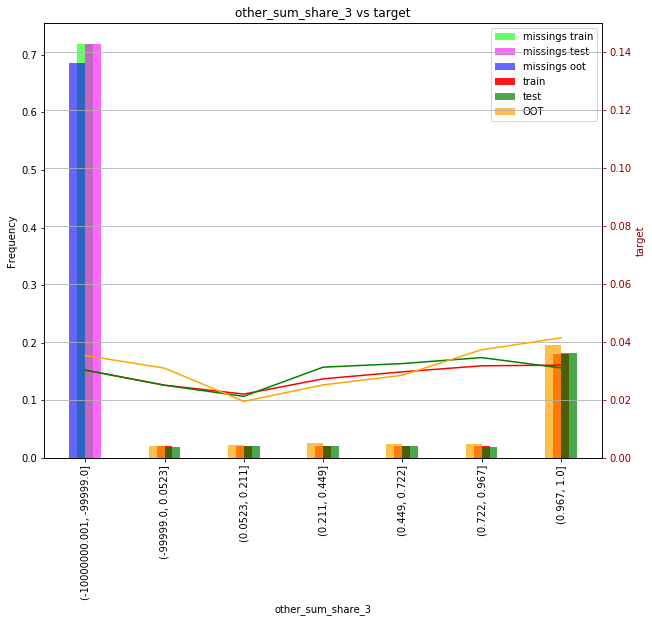

In [1659]:
#7
univariate_for_missing(X_train_final, y_train_final, X_test_final, y_test_final, X_OOT_final, y_OOT_final, 'other_sum_share_3', bins=14)

0.030321504005714532
0.030316963131124457
0.03534846702193924


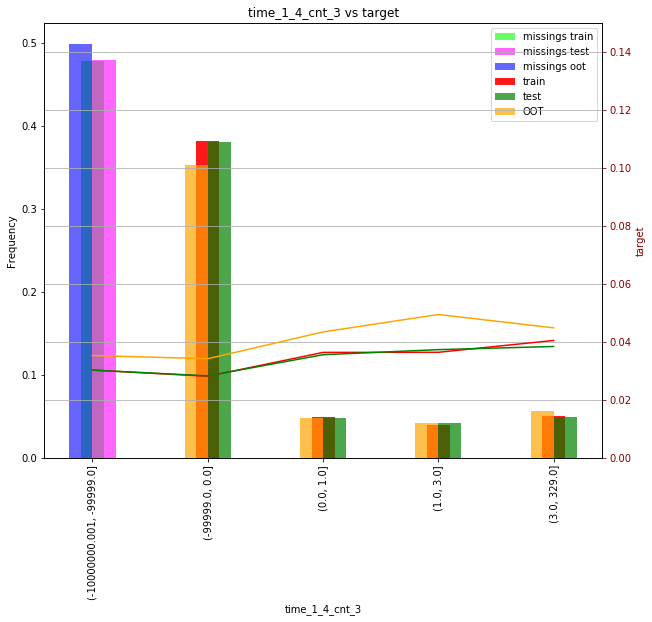

In [1663]:
#8
univariate_for_missing(X_train_final, y_train_final, X_test_final, y_test_final, X_OOT_final, y_OOT_final, 'time_1_4_cnt_3', bins=9)

0.030321504005714532
0.030316963131124457
0.03534846702193924


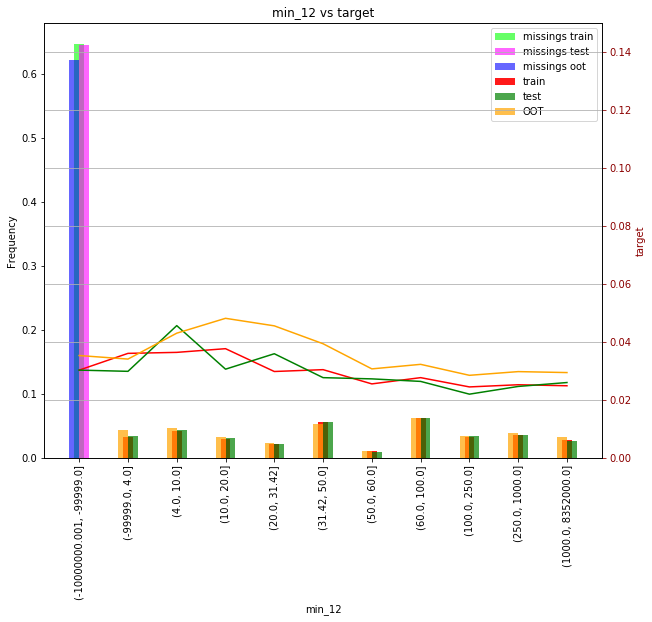

In [1667]:
#9
univariate_for_missing(X_train_final, y_train_final, X_test_final, y_test_final, X_OOT_final, y_OOT_final, 'min_12', bins=11)

0.030321504005714532
0.030316963131124457
0.03534846702193924


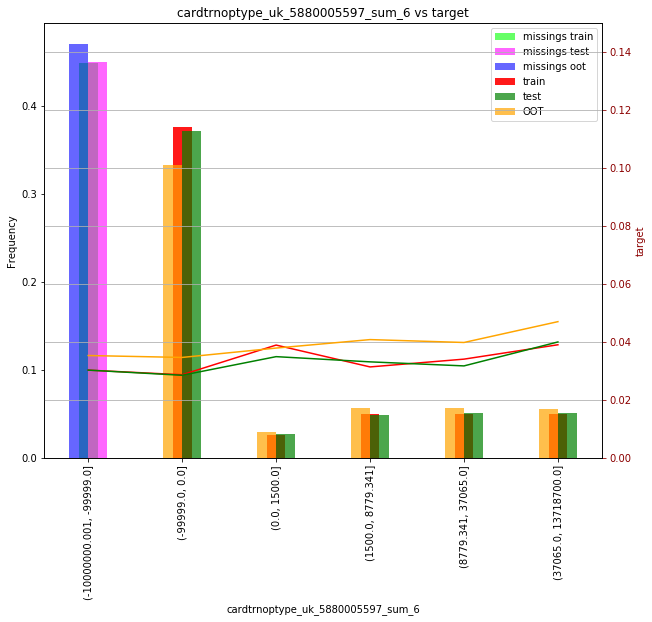

In [1668]:
#10
univariate_for_missing(X_train_final, y_train_final, X_test_final, y_test_final, X_OOT_final, y_OOT_final, 'cardtrnoptype_uk_5880005597_sum_6', bins=11)

# Подгрузим таблицы

На всякий случай подгрузим таблички еще раз

In [ ]:
hadoop = pd.read_csv('df_hdp.csv').set_index('app_id')

In [ ]:
sample = read('wrk_RSK_ANL.dbo.bay_ccbi_sample_all')
pdcc = read('wrk_rsk_anl.dbo.bay_ccbi_vars_pd')
antifraud = read('wrk_rsk_anl.dbo.bay_ccbi_vars_antifraud')

list_dataframes = [sample, pdcc, antifraud]
df_sql = merge(list_dataframes)
df_sql = df_sql.replace(-999999, np.nan)
df_sql = df_sql.replace('None', np.nan)

def drop_x_y(df):
    for item in df.columns:
        if item[-2:] == '_x':
            df[item[:-2]] = df[item]
            print(item)
            df.drop(item, axis=1, inplace=True)
        if item[-2:] == '_y':
            df.drop(item, axis=1, inplace=True)

drop_x_y(df_sql)

df_sql.drop(['eq_id', 'income', 'usd_rate', 'eur_rate', 'req_loan',
       'evnum', 'dt_start', 'dt_start_eom',
       'date_app_entry_eom', ], axis=1, inplace=True)
df_sql.drop(['pdscore18', 'pred_ml_score'],axis=1, inplace=True)

# df_sql = df_sql.dropna(subset=['scoremarat'])
df_sql['MARITAL_STATUS'] = pd.to_numeric(df_sql['MARITAL_STATUS'])
df_sql['PRS_RELATIONSHIP'] = pd.to_numeric(df_sql['PRS_RELATIONSHIP'])

In [367]:
df_bi_old = hadoop[['ocrm_prod_share_n_6','cardtrnopkind_uk_5880005493_com_share_3',
'cardtrnopkind_uk_5880005494_avg_3','cardtrnoptype_uk_5880005597_sum_6' ]]

df_bi_old = pd.merge(df_bi_old, df_sql.drop(['scoremarat'], axis=1), on=['app_id'], how='right').copy()

df_bi_old.drop(['prv_evtime_eom', 'eom'], axis=1, inplace=True)

curvars = ['JB85',
'max_recent_util',
'JB38',
'app_position_rank',
'JB_cards76_extra',
'UD2',
'app_educ_rank',
'ocrm_prod_share_n_6',
'app_n075_axtra',
'JB_cards15',
'JBB214',
'wrk_phone_start_79',
'JB1001_1_extra',
'CDXXU009',
'pass_ch2',
'JB65',
'surname_match',
'JB59_2',
'sh_posit_tot_over',
'app_n049',
'cardtrnopkind_uk_5880005493_com_share_3',
'cardtrnopkind_uk_5880005494_avg_3',
'cdjb_2_JB_notcards72',
'ami',
'cardtrnoptype_uk_5880005597_sum_6',
'sum_automort_outst',
'JB_cards26'
]

df = df_bi_old[curvars + ['target', 'evtime']].copy()
df['evtime'] = pd.to_datetime(df['evtime'])
df = df.replace(-999999, np.nan)
df = df.replace('None', np.nan)

df.to_csv('df_final.csv')

# Forward

In [9]:
best_params = {'n_estimators': 223, 'learning_rate': 0.28477967507891905, 'num_leaves': 38, 'max_depth': 1, 'min_child_weight': 49, 'lambda_l1': 2.679555137180483, 'lambda_l2': 0.5170757770197548, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 0.005309284076677927, 'bagging_fraction': 0.4261212150266244, 'max_bin': 16, 'feature_fraction': 0.26060473202652495, 'bagging_freq': 280, 'min_gain_to_split': 0.21085724893419308}

X_final, y_final, X_OOT_final, y_OOT_final = get_sample_evtime(df_bi_old)
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_final, y_final, 
                                                                            stratify = y_final, test_size = 0.3, 
                                                                            random_state = 0)

In [ ]:
def forward(vars_list, all_vars, X_train, X_test, y_train, y_test, X_OOT, y_OOT, best_params):
    
    res=[]

    for i in list(set(all_vars) - set(vars_list)):
        vars_stay = vars_list + [i]

        
        lgb = lightgbm.LGBMClassifier(n_estimators=best_params['n_estimators'],
                              learning_rate=best_params['learning_rate'],
                              num_leaves=best_params['num_leaves'],max_depth=best_params['max_depth'],
                              min_child_weight=best_params['min_child_weight'],
                              lambda_l1=best_params['lambda_l1'],
                              lambda_l2=best_params['lambda_l2'],
                              min_data_in_leaf=best_params['min_data_in_leaf'],
                              min_sum_hessian_in_leaf=best_params['min_sum_hessian_in_leaf'],
                              bagging_fraction=best_params['bagging_fraction'],
                              max_bin=best_params['max_bin'],
                              feature_fraction=best_params['feature_fraction'],
                              bagging_freq=best_params['bagging_freq']
                              ,min_gain_to_split=best_params['min_gain_to_split'],
                              n_jobs=40, random_state=0)
        lgb.fit(X_train[vars_stay], y_train,
                        eval_metric='auc', verbose=False,) 
        tr = roc_auc_score(y_train, lgb.predict_proba(X_train[vars_stay])[:,1]) * 2 - 1
        te = roc_auc_score(y_test, lgb.predict_proba(X_test[vars_stay])[:,1]) * 2 - 1
        oot = roc_auc_score(y_OOT, lgb.predict_proba(X_OOT[vars_stay])[:,1]) * 2 - 1
        res.append([i,tr,te,oot])
        print('feature: ', i,  '\ttrain: ', round(tr, 3),  '\ttest: ', round(te, 3),  '\toot: ', round(oot, 3))

    forw = pd.DataFrame(res, columns = ['feature', 'train', 'test', 'OOT'])
    forw['train_test_mean'] = forw['train']

    return forw.sort_values(by='train_test_mean', ascending=False)[['feature', 'train', 'test', 'OOT']].reset_index(drop=True).loc[:0, :]

In [ ]:
columns_forward = list(df_bi_old.drop(['target', 'evtime'], axis=1).columns)

list_to_add = columns_forward.copy()
list_start = []
temp_df_bi = pd.DataFrame(columns=['feature', 'train', 'test', 'OOT'])



while len(list_to_add) != 0:
    forward_iteration = forward(list_start, columns_forward, X_train_final, X_test_final, y_train_final, y_test_final, X_OOT_final, y_OOT_final, best_params)
    temp_df_bi = temp_df_bi.append(forward_iteration, ignore_index=True)
    print(temp_df_bi)
    
    var = forward_iteration.values[0][0]

    list_start.append(var)
    list_to_add.remove(var)
    print(var)

# Backward

In [ ]:
var_list_final = temp_df_bi['feature'].loc[:28].tolist()

In [ ]:
def backward(vars_list, X_train, X_test, y_train, y_test, X_OOT, y_OOT,  best_params):
    res=[]
    q=0

    for item in vars_list:
    
        vars_stay = list(set(vars_list) - set([item]))
        q+=1
#         print('\n', vars_stay)
        lgb = lightgbm.LGBMClassifier(n_estimators=best_params['n_estimators'],
                                      learning_rate=best_params['learning_rate'],
                                      num_leaves=best_params['num_leaves'],max_depth=best_params['max_depth'],
                                      min_child_weight=best_params['min_child_weight'],
                                      lambda_l1=best_params['lambda_l1'],
                                      lambda_l2=best_params['lambda_l2'],
                                      min_data_in_leaf=best_params['min_data_in_leaf'],
                                      min_sum_hessian_in_leaf=best_params['min_sum_hessian_in_leaf'],
                                      bagging_fraction=best_params['bagging_fraction'],
                                      max_bin=best_params['max_bin'],
                                      feature_fraction=best_params['feature_fraction'],
                                      bagging_freq=best_params['bagging_freq']
                                      ,min_gain_to_split=best_params['min_gain_to_split'],
                                      n_jobs=40, random_state=0)
        lgb.fit(X_train[vars_stay], y_train, eval_metric='auc', verbose=False)

        
        tr =  roc_auc_score(y_train, lgb.predict_proba(X_train[vars_stay])[:,1]) * 2 - 1        
        te = roc_auc_score(y_test, lgb.predict_proba(X_test[vars_stay])[:,1]) * 2 - 1
        oot = roc_auc_score(y_OOT, lgb.predict_proba(X_OOT[vars_stay])[:,1]) * 2 - 1
        
        res.append([item, tr, te, oot])
        
        print(q, ' feature: ', item, '\ttrain: ', round(tr, 3),  '\ttest: ', round(te, 3), '\toot:', round(oot, 3))
    backw = pd.DataFrame(res, columns = ['var', 'train', 'test', 'OOT'])
    return backw.sort_values(by='train', ascending=False)[['var', 'train', 'test', 'OOT']].reset_index(drop=True).loc[:0, :]

In [ ]:
X_final, y_final, X_OOT_final, y_OOT_final = get_sample_evtime(df_bi_old[var_list_final + ['target', 'evtime']])
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_final, y_final, 
                                                                            stratify = y_final, test_size = 0.3, 
                                                                            random_state = 0)

list_start = list(var_list_final)
temp_df_new = pd.DataFrame(columns=['var', 'train', 'test', 'OOT'])

lgb = lightgbm.LGBMClassifier(n_estimators=best_params['n_estimators'],
                              learning_rate=best_params['learning_rate'],
                              num_leaves=best_params['num_leaves'],max_depth=best_params['max_depth'],
                              min_child_weight=best_params['min_child_weight'],
                              lambda_l1=best_params['lambda_l1'],
                              lambda_l2=best_params['lambda_l2'],
                              min_data_in_leaf=best_params['min_data_in_leaf'],
                              min_sum_hessian_in_leaf=best_params['min_sum_hessian_in_leaf'],
                              bagging_fraction=best_params['bagging_fraction'],
                              max_bin=best_params['max_bin'],
                              feature_fraction=best_params['feature_fraction'],
                              bagging_freq=best_params['bagging_freq']
                              ,min_gain_to_split=best_params['min_gain_to_split'],
                              n_jobs=40, random_state=0)
lgb.fit(X_train_final, y_train_final, eval_metric='auc', verbose=False)

tr =  roc_auc_score(y_train_final, lgb.predict_proba(X_train_final)[:,1]) * 2 - 1        
te = roc_auc_score(y_test_final, lgb.predict_proba(X_test_final)[:,1]) * 2 - 1
oot = roc_auc_score(y_OOT_final, lgb.predict_proba(X_OOT_final)[:,1]) * 2 - 1
res=[]
res.append(['all', tr, te, oot])
print(0, ' all    \ttrain: ', round(tr, 3),  '\ttest: ', round(te, 3), '\toot:', round(oot, 3)) 


bw = pd.DataFrame(res, columns = ['var', 'train', 'test', 'OOT']).sort_values(by='train', ascending=False)[['var', 'train', 'test', 'OOT']].reset_index(drop=True).loc[:0, :]
temp_df_new = temp_df_new.append(bw, ignore_index=True)

for i in range(len(var_list_final)):


    bw = backward(list_start, X_train_final[var_list_final], X_test_final[var_list_final], y_train_final, y_test_final, 
                 X_OOT_final[var_list_final], y_OOT_final,  best_params)
    temp_df_new = temp_df_new.append(bw, ignore_index=True)
    print(temp_df_new)
    var = bw.values[0][0]
    
    list_start.remove(var)

# Downlifts

In [ ]:
lgb = lightgbm.LGBMClassifier(n_estimators=best_params['n_estimators'],
                              learning_rate=best_params['learning_rate'],
                              num_leaves=best_params['num_leaves'],max_depth=best_params['max_depth'],
                              min_child_weight=best_params['min_child_weight'],
                              lambda_l1=best_params['lambda_l1'],
                              lambda_l2=best_params['lambda_l2'],
                              min_data_in_leaf=best_params['min_data_in_leaf'],
                              min_sum_hessian_in_leaf=best_params['min_sum_hessian_in_leaf'],
                              bagging_fraction=best_params['bagging_fraction'],
                              max_bin=best_params['max_bin'],
                              feature_fraction=best_params['feature_fraction'],
                              bagging_freq=best_params['bagging_freq']
                              ,min_gain_to_split=best_params['min_gain_to_split'],
                              n_jobs=40, random_state=0)

lgb.fit(X_train_final[var_list_final], y_train_final)

a, b, c = roc_auc_score(y_train_final, lgb.predict_proba(X_train_final[var_list_final])[:,1]) * 2 - 1, \
           roc_auc_score(y_test_final, lgb.predict_proba(X_test_final[var_list_final])[:,1]) * 2 - 1, \
           roc_auc_score(y_OOT_final, lgb.predict_proba(X_OOT_final[var_list_final])[:,1]) * 2 - 1

res=[['all',roc_auc_score(y_train_final, lgb.predict_proba(X_train_final[var_list_final])[:,1]) * 2 - 1,
           roc_auc_score(y_test_final, lgb.predict_proba(X_test_final[var_list_final])[:,1]) * 2 - 1,
           roc_auc_score(y_OOT_final, lgb.predict_proba(X_OOT_final[var_list_final])[:,1]) * 2 - 1]]


for i in var_list_final:
    vars_stay = list(set(var_list_final) - set([i]))


    lgb = lightgbm.LGBMClassifier(n_estimators=best_params['n_estimators'],
                              learning_rate=best_params['learning_rate'],
                              num_leaves=best_params['num_leaves'],max_depth=best_params['max_depth'],
                              min_child_weight=best_params['min_child_weight'],
                              lambda_l1=best_params['lambda_l1'],
                              lambda_l2=best_params['lambda_l2'],
                              min_data_in_leaf=best_params['min_data_in_leaf'],
                              min_sum_hessian_in_leaf=best_params['min_sum_hessian_in_leaf'],
                              bagging_fraction=best_params['bagging_fraction'],
                              max_bin=best_params['max_bin'],
                              feature_fraction=best_params['feature_fraction'],
                              bagging_freq=best_params['bagging_freq']
                              ,min_gain_to_split=best_params['min_gain_to_split'],
                              n_jobs=40, random_state=0)
    
    lgb.fit(X_train_final[vars_stay], y_train_final)
    res.append([i,
               roc_auc_score(y_train_final, lgb.predict_proba(X_train_final[vars_stay])[:,1]) * 2 - 1,
               roc_auc_score(y_test_final, lgb.predict_proba(X_test_final[vars_stay])[:,1]) * 2 - 1,
               roc_auc_score(y_OOT_final, lgb.predict_proba(X_OOT_final[vars_stay])[:,1]) * 2 - 1])
    
forw = pd.DataFrame(res, columns = ['var', 'train', 'test', 'OOT'])
forw['train_downlift, %'] = (forw['train'] - a)
forw['test_downlift, %'] = (forw['test'] - b)
forw['OOT_downlift, %'] = (forw['OOT'] - c)

In [ ]:
forw

# Выкидываем фичи и тестим

In [ ]:
def get_result(X_train_final, y_train_final, X_test_final,y_test_final,  X_OOT_final, y_OOT_final, best_params):

    clf = lightgbm.LGBMClassifier(n_estimators=best_params['n_estimators'],
                                  learning_rate=best_params['learning_rate'],
                                  num_leaves=best_params['num_leaves'],max_depth=best_params['max_depth'],
                                  min_child_weight=best_params['min_child_weight'],
                                  lambda_l1=best_params['lambda_l1'],
                                  lambda_l2=best_params['lambda_l2'],
                                  min_data_in_leaf=best_params['min_data_in_leaf'],
                                  min_sum_hessian_in_leaf=best_params['min_sum_hessian_in_leaf'],
                                  bagging_fraction=best_params['bagging_fraction'],
                                  max_bin=best_params['max_bin'],
                                  feature_fraction= best_params['feature_fraction'],
                                  bagging_freq= best_params['bagging_freq'],
                                  min_gain_to_split=best_params['min_gain_to_split'],                             
                                  n_jobs=40, random_state=0)
    
    clf.fit(X_train_final, y_train_final, eval_metric='auc', verbose=False)

    pred_train = clf.predict_proba(X_train_final, num_iteration=clf.best_iteration_)[:, 1]
    pred_test = clf.predict_proba(X_test_final, num_iteration=clf.best_iteration_)[:, 1]
    pred_oot = clf.predict_proba(X_OOT_final, num_iteration=clf.best_iteration_)[:, 1]

    gini_train = 2 * roc_auc_score(y_train_final, pred_train) - 1
    gini_test = 2 * roc_auc_score(y_test_final, pred_test) - 1
    gini_oot = 2 * roc_auc_score(y_OOT_final, pred_oot) - 1

    print(round(100*gini_train, 2), round(100*gini_test, 2), round(100*gini_oot, 2))
    return round(100*gini_train, 3), round(100*gini_test, 3), round(100*gini_oot, 3)

In [ ]:
def test_samples(curvars_, k, params):
    res = []
    for i in range(k):
        X_final, y_final, X_OOT_final, y_OOT_final = get_sample_evtime(df_bi_old[curvars_ + ['target', 'evtime']])
        X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_final, y_final, stratify = y_final, test_size = 0.3,  random_state = i)

        tr, te, oot = get_result(X_train_final, y_train_final, X_test_final,y_test_final,  X_OOT_final, y_OOT_final, params)
        res.append([tr, te, oot])
    print(np.median(res, axis=0))
    return np.median(res, axis=0)

In [ ]:
curvars = [x for x in var_list_final]
res = test_samples(curvars, 50)

In [ ]:
curvars = [x for x in var_list_final if x not in ['JB85']]
res = test_samples(curvars, 50)

In [ ]:
curvars = [x for x in var_list_final if x not in ['LOANS_AT_TIME_84_MONTH_bad_symbols_sh_0_avg']]
res = test_samples(curvars, 50)

In [ ]:
curvars = [x for x in var_list_final if x not in ['sum_automort_outst']]
res = test_samples(curvars, 50)

In [ ]:
curvars = [x for x in var_list_final if x not in ['sum_automort_outst','LOANS_AT_TIME_84_MONTH_bad_symbols_sh_0_avg', 'cardnum_ccode_nunique_6' ]]
res = test_samples(curvars, 50)

In [ ]:
curvars = [x for x in var_list_final if x not in ['LOANS_AT_TIME_84_MONTH_bad_symbols_sh_0_avg', 'cardnum_ccode_nunique_6' ]]
res = test_samples(curvars, 50)

In [ ]:
curvars = ['JB85',
'max_recent_util',
'JB38',
'app_position_rank',
'JB_cards76_extra',
'UD2',
'app_educ_rank',
'ocrm_prod_share_n_6',
'app_n075_axtra',
'JB_cards15',
'JBB214',
'wrk_phone_start_79',
'JB1001_1_extra',
'CDXXU009',
'pass_ch2',
'JB65',
'surname_match',
'JB59_2',
'sh_posit_tot_over',
'app_n049',
'cardtrnopkind_uk_5880005493_com_share_3',
'cardtrnopkind_uk_5880005494_avg_3',
'cdjb_2_JB_notcards72',
'ami',
'cardtrnoptype_uk_5880005597_sum_6',
'sum_automort_outst',
'JB_cards26']

# Еще раз backward, после выбрасывания фичи

In [ ]:
curvars_final = curvars.copy()

In [ ]:
X_final, y_final, X_OOT_final, y_OOT_final = get_sample_evtime(df_bi_old[curvars_final + ['target', 'evtime']])
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_final, y_final, 
                                                                            stratify = y_final, test_size = 0.3, 
                                                                            random_state = 0)

list_start = list(curvars_final)
temp_df_new = pd.DataFrame(columns=['var', 'train', 'test', 'OOT'])

lgb = lightgbm.LGBMClassifier(n_estimators=best_params['n_estimators'],
                              learning_rate=best_params['learning_rate'],
                              num_leaves=best_params['num_leaves'],max_depth=best_params['max_depth'],
                              min_child_weight=best_params['min_child_weight'],
                              lambda_l1=best_params['lambda_l1'],
                              lambda_l2=best_params['lambda_l2'],
                              min_data_in_leaf=best_params['min_data_in_leaf'],
                              min_sum_hessian_in_leaf=best_params['min_sum_hessian_in_leaf'],
                              bagging_fraction=best_params['bagging_fraction'],
                              max_bin=best_params['max_bin'],
                              feature_fraction=best_params['feature_fraction'],
                              bagging_freq=best_params['bagging_freq']
                              ,min_gain_to_split=best_params['min_gain_to_split'],
                              n_jobs=40, random_state=0)
lgb.fit(X_train_final, y_train_final, eval_metric='auc', verbose=False)

tr =  roc_auc_score(y_train_final, lgb.predict_proba(X_train_final)[:,1]) * 2 - 1        
te = roc_auc_score(y_test_final, lgb.predict_proba(X_test_final)[:,1]) * 2 - 1
oot = roc_auc_score(y_OOT_final, lgb.predict_proba(X_OOT_final)[:,1]) * 2 - 1

res=[]
res.append(['all', tr, te, oot])
print(0, ' all    \ttrain: ', round(tr, 3),  '\ttest: ', round(te, 3), '\toot:', round(oot, 3)) 


bw = pd.DataFrame(res, columns = ['var', 'train', 'test', 'OOT']).sort_values(by='train', ascending=False)[['var', 'train', 'test', 'OOT']].reset_index(drop=True).loc[:0, :]
temp_df_new = temp_df_new.append(bw, ignore_index=True)

for i in range(len(curvars_final)):


    bw = backward(list_start, X_train_final[curvars_final], X_test_final[curvars_final], y_train_final, y_test_final, 
                 X_OOT_final[curvars_final], y_OOT_final,  best_params)
    temp_df_new = temp_df_new.append(bw, ignore_index=True)
    print(temp_df_new)
    var = bw.values[0][0]
    
    list_start.remove(var)

# Downlifts

In [ ]:
X_final, y_final, X_OOT_final, y_OOT_final = get_sample_evtime(df_bi_old[curvars_final + ['target', 'evtime']])
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_final, y_final, 
                                                                            stratify = y_final, test_size = 0.3, 
                                                                            random_state = 0)

In [ ]:
lgb = lightgbm.LGBMClassifier(n_estimators=best_params['n_estimators'],
                              learning_rate=best_params['learning_rate'],
                              num_leaves=best_params['num_leaves'],max_depth=best_params['max_depth'],
                              min_child_weight=best_params['min_child_weight'],
                              lambda_l1=best_params['lambda_l1'],
                              lambda_l2=best_params['lambda_l2'],
                              min_data_in_leaf=best_params['min_data_in_leaf'],
                              min_sum_hessian_in_leaf=best_params['min_sum_hessian_in_leaf'],
                              bagging_fraction=best_params['bagging_fraction'],
                              max_bin=best_params['max_bin'],
                              feature_fraction=best_params['feature_fraction'],
                              bagging_freq=best_params['bagging_freq']
                              ,min_gain_to_split=best_params['min_gain_to_split'],
                              n_jobs=40, random_state=0)

lgb.fit(X_train_final[curvars_final], y_train_final)

a, b, c = roc_auc_score(y_train_final, lgb.predict_proba(X_train_final[curvars_final])[:,1]) * 2 - 1, \
           roc_auc_score(y_test_final, lgb.predict_proba(X_test_final[curvars_final])[:,1]) * 2 - 1, \
           roc_auc_score(y_OOT_final, lgb.predict_proba(X_OOT_final[curvars_final])[:,1]) * 2 - 1

res=[['all',roc_auc_score(y_train_final, lgb.predict_proba(X_train_final[curvars_final])[:,1]) * 2 - 1,
           roc_auc_score(y_test_final, lgb.predict_proba(X_test_final[curvars_final])[:,1]) * 2 - 1,
           roc_auc_score(y_OOT_final, lgb.predict_proba(X_OOT_final[curvars_final])[:,1]) * 2 - 1]]


for i in curvars_final:
    vars_stay = list(set(curvars_final) - set([i]))


    lgb = lightgbm.LGBMClassifier(n_estimators=best_params['n_estimators'],
                              learning_rate=best_params['learning_rate'],
                              num_leaves=best_params['num_leaves'],max_depth=best_params['max_depth'],
                              min_child_weight=best_params['min_child_weight'],
                              lambda_l1=best_params['lambda_l1'],
                              lambda_l2=best_params['lambda_l2'],
                              min_data_in_leaf=best_params['min_data_in_leaf'],
                              min_sum_hessian_in_leaf=best_params['min_sum_hessian_in_leaf'],
                              bagging_fraction=best_params['bagging_fraction'],
                              max_bin=best_params['max_bin'],
                              feature_fraction=best_params['feature_fraction'],
                              bagging_freq=best_params['bagging_freq']
                              ,min_gain_to_split=best_params['min_gain_to_split'],
                              n_jobs=40, random_state=0)
    
    lgb.fit(X_train_final[vars_stay], y_train_final)
    res.append([i,
               roc_auc_score(y_train_final, lgb.predict_proba(X_train_final[vars_stay])[:,1]) * 2 - 1,
               roc_auc_score(y_test_final, lgb.predict_proba(X_test_final[vars_stay])[:,1]) * 2 - 1,
               roc_auc_score(y_OOT_final, lgb.predict_proba(X_OOT_final[vars_stay])[:,1]) * 2 - 1])
    
forw = pd.DataFrame(res, columns = ['var', 'train', 'test', 'OOT'])
forw['train_downlift'] = (forw['train'] - a)
forw['test_downlift'] = (forw['test'] - b)
forw['OOT_downlift'] = (forw['OOT'] - c)

In [ ]:
forw

# Hyperopt

In [ ]:
X_final, y_final, X_OOT_final, y_OOT_final = get_sample_evtime(df_bi_old[curvars_final + ['target', 'evtime']])
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_final, y_final, 
                                                                            stratify = y_final, test_size = 0.3, 
                                                                            random_state = 0)

In [ ]:
params = {
    'n_estimators': 200,
    'learning_rate': 0.1,
    'num_leaves': 20,
    'max_depth': 1,
    'min_child_weight': 10,
    'lambda_l1':2,
    'lambda_l2':3,
    'min_data_in_leaf' :10,
    'min_sum_hessian_in_leaf' : 0.0001,
    'bagging_fraction' : 0.8,
    'max_bin': 12,
    'feature_fraction' : 0.9,
    'bagging_freq' : 100,
    'min_gain_to_split': 0.1}

def objective(params):
    params = {
    'n_estimators': int(params['n_estimators']),
    'learning_rate': params['learning_rate'],
    'num_leaves': int(params['num_leaves']),
    'max_depth': 1,
    'min_child_weight': int(params['min_child_weight']),
    'lambda_l1':params['lambda_l1'],
    'lambda_l2':params['lambda_l2'],
    'min_data_in_leaf' :int(params['min_data_in_leaf']),
    'min_sum_hessian_in_leaf' : params['min_sum_hessian_in_leaf'],
    'bagging_fraction' : params['bagging_fraction'],
    'max_bin': int(params['max_bin']),
    'feature_fraction' : params['feature_fraction'],
    'bagging_freq' : int(params['bagging_freq']),
    'min_gain_to_split': params['min_gain_to_split']
    }

    gini_test = validate_hyperopt(X_final, y_final, X_OOT_final, y_OOT_final, 1, params)
    
    score = gini_test
    print("Gini ", round(score, 3) , '   params: ', params)
    return -score
space = {
    'n_estimators': hp.quniform('n_estimators', 190, 250, 1),
    'num_leaves': hp.quniform('num_leaves', 5, 80, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 70, 1),
    'learning_rate': hp.uniform('learning_rate', 0.1, 0.3),
    'max_bin': hp.quniform('max_bin', 9, 40, 1),
    'min_data_in_leaf': hp.quniform('min_data_in_leaf', 10, 50, 1), 
    'lambda_l1': hp.uniform('lambda_l1', 0, 3), 
    'lambda_l2': hp.uniform('lambda_l2', 0, 3),
    'min_data_in_leaf' :hp.quniform('min_data_in_leaf', 5, 50, 1),
    'min_sum_hessian_in_leaf' : hp.uniform('min_sum_hessian_in_leaf', 0, 0.01),
    'bagging_fraction' : hp.uniform('bagging_fraction', 0, 0.9),
    'max_bin': hp.quniform('max_bin', 10, 30, 1),
    'feature_fraction' : hp.uniform('feature_fraction', 0, 0.9),
    'bagging_freq' : hp.quniform('bagging_freq', 10, 1000, 10),
    'min_gain_to_split': hp.uniform('min_gain_to_split', 0.1, 1),     
}

In [ ]:
best_ = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=300)

In [ ]:
best_params_ = {'n_estimators': 243, 'learning_rate': 0.2936227550391265, 'num_leaves': 67, 'max_depth': 1, 'min_child_weight': 42, 'lambda_l1': 2.428267090549855, 'lambda_l2': 1.3636755814582469, 'min_data_in_leaf': 29, 'min_sum_hessian_in_leaf': 0.0011724709264034467, 'bagging_fraction': 0.7081297990084958, 'max_bin': 24, 'feature_fraction': 0.3874852443340638, 'bagging_freq': 470, 'min_gain_to_split': 0.4660420834956889}

In [ ]:

curvars = ['JB85',
'max_recent_util',
'JB38',
'app_position_rank',
'JB_cards76_extra',
'UD2',
'app_educ_rank',
'ocrm_prod_share_n_6',
'app_n075_axtra',
'JB_cards15',
'JBB214',
'wrk_phone_start_79',
'JB1001_1_extra',
'CDXXU009',
'pass_ch2',
'JB65',
'surname_match',
'JB59_2',
'sh_posit_tot_over',
'app_n049',
'cardtrnopkind_uk_5880005493_com_share_3',
'cardtrnopkind_uk_5880005494_avg_3',
'cdjb_2_JB_notcards72',
'ami',
'cardtrnoptype_uk_5880005597_sum_6',
'sum_automort_outst',
'JB_cards26'
]

X_final, y_final, X_OOT_final, y_OOT_final = get_sample_evtime(df_bi_old[curvars + ['target', 'evtime']])
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_final, y_final, stratify = y_final, test_size = 0.3,  random_state = 6)

get_result(X_train_final, y_train_final, X_test_final,y_test_final,  X_OOT_final, y_OOT_final, best_params_)

# Обучение модели на блоках переменных

In [ ]:
bi = ['ocrm_prod_share_n_6', 
      'cardtrnopkind_uk_5880005494_avg_3',
      'cardtrnopkind_uk_5880005493_com_share_3',
      'cardtrnoptype_uk_5880005597_sum_6']

katya = ['max_recent_util', 
        'JB_cards76_extra',
        'app_n075_axtra' ,
         'wrk_phone_start_79',
         'JB1001_1_extra',
         'JB59_2',
         'pass_ch2',
         'sum_automort_outst',
         'sh_posit_tot_over',
         'surname_match',
         'cdjb_2_JB_notcards72'
        ]

marat = ['JB85', 
        'JB38',
        'app_position_rank',
        'UD2' ,
        'app_educ_rank' ,
         'JB_cards15',
         'CDXXU009',
         'JBB214',
         'JB65',
         'app_n049',
         'JB_cards26',
         'ami'         
        ]

In [ ]:
curvars = marat
# print(curvars)
X_final, y_final, X_OOT_final, y_OOT_final = get_sample_evtime(df_bi_old[curvars + ['target', 'evtime']])
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_final, y_final, stratify = y_final, test_size = 0.3,  random_state = 6)

get_result(X_train_final, y_train_final, X_test_final,y_test_final,  X_OOT_final, y_OOT_final, best_params_)

In [ ]:
curvars = katya
# print(curvars)
X_final, y_final, X_OOT_final, y_OOT_final = get_sample_evtime(df_bi_old[curvars + ['target', 'evtime']])
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_final, y_final, stratify = y_final, test_size = 0.3,  random_state = 6)

get_result(X_train_final, y_train_final, X_test_final,y_test_final,  X_OOT_final, y_OOT_final, best_params_)

In [ ]:
curvars = bi + marat
# print(curvars)
X_final, y_final, X_OOT_final, y_OOT_final = get_sample_evtime(df_bi_old[curvars + ['target', 'evtime']])
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_final, y_final, stratify = y_final, test_size = 0.3,  random_state = 6)

get_result(X_train_final, y_train_final, X_test_final,y_test_final,  X_OOT_final, y_OOT_final, best_params_)

In [ ]:
curvars = bi + katya
# print(curvars)
X_final, y_final, X_OOT_final, y_OOT_final = get_sample_evtime(df_bi_old[curvars + ['target', 'evtime']])
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_final, y_final, stratify = y_final, test_size = 0.3,  random_state = 6)

get_result(X_train_final, y_train_final, X_test_final,y_test_final,  X_OOT_final, y_OOT_final, best_params_)

In [ ]:
curvars = bi + marat + katya
# print(curvars)
X_final, y_final, X_OOT_final, y_OOT_final = get_sample_evtime(df_bi_old[curvars + ['target', 'evtime']])
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_final, y_final, stratify = y_final, test_size = 0.3,  random_state = 6)

get_result(X_train_final, y_train_final, X_test_final,y_test_final,  X_OOT_final, y_OOT_final, best_params_)

In [ ]:
curvars = marat + katya
# print(curvars)
X_final, y_final, X_OOT_final, y_OOT_final = get_sample_evtime(df_bi_old[curvars + ['target', 'evtime']])
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_final, y_final, stratify = y_final, test_size = 0.3,  random_state = 6)

get_result(X_train_final, y_train_final, X_test_final,y_test_final,  X_OOT_final, y_OOT_final, best_params_)

In [ ]:
X_marat, y_marat, X_OOT_marat, y_OOT_marat = get_sample_evtime(df_sql[['scoremarat', 'evtime', 'target']])

X_train_marat, X_test_marat, y_train_marat, y_test_marat = train_test_split(X_marat, y_marat, stratify = y_marat, test_size = 0.3,  random_state = 6)

print(roc_auc_score(y_train_marat, -X_train_marat['scoremarat']) * 2 - 1,
    roc_auc_score(y_test_marat, -X_test_marat['scoremarat']) * 2 - 1,
    roc_auc_score(y_OOT_marat, -X_OOT_marat['scoremarat']) * 2 - 1)

# Саша Копнышев переменные

In [ ]:
kop = read('wrk_RSK_ANL.dbo.bay_ccbi_kop_bi_flags')
kop = kop.replace(-999999, np.nan)
kop = kop.replace('None', np.nan)

df = df_bi_old[curvars].copy()

df_kop = pd.merge(df, kop, on=['app_id'], how='left')

X_kop, y_kop, X_OOT_kop, y_OOT_kop = get_sample_evtime(df_kop)
X_train_kop, X_test_kop, y_train_kop, y_test_kop = train_test_split(X_kop, y_kop, stratify = y_kop, test_size = 0.3,random_state = 6)

get_result(X_train_kop, y_train_kop, X_test_kop, y_test_kop, X_OOT_kop, y_OOT_kop, best_params_)

columns_forward = list(df_kop.drop(['target', 'evtime'], axis=1).columns)

list_to_add = columns_forward.copy()
list_start = []
temp_df_kop = pd.DataFrame(columns=['feature', 'train', 'test', 'OOT'])

while len(list_to_add) != 0:
    forward_iteration = forward(list_start, columns_forward, X_train_kop, X_test_kop, y_train_kop, y_test_kop, X_OOT_kop, y_OOT_kop, best_params_)
    temp_df_kop = temp_df_kop.append(forward_iteration, ignore_index=True)
    print(temp_df_kop)
    
    var = forward_iteration.values[0][0]

    list_start.append(var)
    list_to_add.remove(var)
    print(var)

temp_df_kop

In [ ]:
df = df_bi_old[curvars + ['target', 'evtime']].copy()

X_kop, y_kop, X_OOT_kop, y_OOT_kop = get_sample_evtime(df)
X_train_kop, X_test_kop, y_train_kop, y_test_kop = train_test_split(X_kop, y_kop, stratify = y_kop, test_size = 0.3,random_state = 6)

get_result(X_train_kop, y_train_kop, X_test_kop, y_test_kop, X_OOT_kop, y_OOT_kop, best_params_)

columns_forward = list(df.drop(['target', 'evtime'], axis=1).columns)

list_to_add = columns_forward.copy()
list_start = []
temp_df_kop = pd.DataFrame(columns=['feature', 'train', 'test', 'OOT'])

while len(list_to_add) != 0:
    forward_iteration = forward(list_start, columns_forward, X_train_kop, X_test_kop, y_train_kop, y_test_kop, X_OOT_kop, y_OOT_kop, best_params_)
    temp_df_kop = temp_df_kop.append(forward_iteration, ignore_index=True)
    print(temp_df_kop)
    
    var = forward_iteration.values[0][0]

    list_start.append(var)
    list_to_add.remove(var)
    print(var)

temp_df_kop

#1
univariate_for_missing(X_train_kop, y_train_kop, X_test_kop, y_test_kop, X_OOT_kop, y_OOT_kop, 'flag_05', bins=5)

X_train_kop['flag_14'].hist()

missing_values_table(X_train_kop[['flag_14']])

# Final univariates

In [ ]:
def uni_values_for_missing(X, y, col_name, bins, categ_arr):
    if len(X[col_name].value_counts()) == 2:
        categ_arr = np.array([0, 1, 2])
    X['target'] = y
    uni_df = X.copy()    
    if categ_arr is None:
        categ_arr = np.hstack((np.array([-10000000, -99999]), np.unique(uni_df[[col_name]].quantile(np.arange(0, 1000+1e-12, 1000/bins)/1000).values[1:])))
    uni_df['categ'] =  pd.cut(uni_df[col_name], categ_arr, include_lowest=True).values
#     print(uni_df['categ'] )
    grouped = uni_df.groupby('categ')[['target', col_name]].agg({'target':['mean'], col_name:['count']}).copy()
    grouped[col_name] = grouped[col_name] / len(y)
    grouped.reset_index(inplace=True)
    grouped['categ'] = grouped['categ'].astype(str)
    
   
    
    
    mis = uni_df[col_name].isnull().sum()/len(y)
    mis_badrate = y[uni_df[col_name].isnull().index].mean()
    print(mis_badrate) 

    return grouped, categ_arr, mis, mis_badrate
def univariate_for_missing(X_train, y_train, X_test, y_test, X_OOT, y_OOT, col, bins): 

    train, categ_arr, mis_train, br_train = uni_values_for_missing(X_train, y_train, col, bins, categ_arr=None)
    test, c, mis_test, br_test = uni_values_for_missing(X_test, y_test, col, bins, categ_arr)
    oot, c, mis_oot, br_oot = uni_values_for_missing(X_OOT, y_OOT, col, bins, categ_arr)
    
    train_ = train.copy()
    test_ = test.copy()
    oot_ = oot.copy()
    
    train_['categ_train'] = train[train.columns[0]]
    train_.drop('categ', axis=1, inplace=True)
    train_[col + '_train'] = train[train.columns[2]]
    train_.drop(col, axis=1, inplace=True)
    train_['target_train'] = train[train.columns[1]]
    train_.drop('target', axis=1, inplace=True)
    
    
    test_['categ_test'] = test[test.columns[0]]
    test_.drop('categ', axis=1, inplace=True)
    test_[col + '_test'] = test[test.columns[2]]
    test_.drop(col, axis=1, inplace=True)
    test_['target_test'] = test[test.columns[1]]
    test_.drop('target', axis=1, inplace=True)
    
    oot_['categ_oot'] = oot[oot.columns[0]]
    oot_.drop('categ', axis=1, inplace=True)
    oot_[col + '_oot'] = oot[oot.columns[2]]
    oot_.drop(col, axis=1, inplace=True)
    oot_['target_oot'] = oot[oot.columns[1]]
    oot_.drop('target', axis=1, inplace=True)
    
    
    
    mis = [mis_train, mis_test, mis_oot]  
    br = [br_train, br_test, br_oot]
    grouped = pd.concat([train_, test_, oot_], axis=1)
    
    ind = np.arange(len(grouped[col + '_train'].values.ravel())) 
    width = 0.2
   
    fig, ax1 = plt.subplots(figsize=(10, 8))
    ax1.bar(x=grouped['categ_train'].values[0], 
       height = mis_train, width=width, color='lime', label='missings train', alpha=0.6,align='center')
    ax1.bar(x=grouped['categ_train'].values[0], 
       height = mis_test, width=width, color='magenta', label='missings test', alpha=0.6, align='edge')
    ax1.bar(x=grouped['categ_train'].values[0], 
       height = mis_oot, width=-width, color='blue', label='missings oot', alpha=0.6, align='edge')
    ax1.bar(
            x =  grouped['categ_train'].values, 
            height = grouped[col + '_train'].values.ravel(), 
            width=width, align='center', label='train', color='red', alpha=0.9)
    ax1.bar(
        x = grouped['categ_test'].values , 
        height = grouped[col + '_test'].values.ravel(),
        width=width, align='edge', label='test', color='green', alpha=0.7)
    ax1.bar(
        x = grouped['categ_oot'].values , 
        height = grouped[col + '_oot'].values.ravel(),
        width=-width, align='edge', label='OOT', color='orange', alpha=0.7)
    
    ax1.set_title('{} vs target'.format(col))
    ax1.set_xlabel(col)
    ax1.set_xticks(range(bins))
    ax1.set_xticklabels(grouped['categ_train'].values, rotation='vertical')
    ax1.set_ylabel('Frequency')
    ax1.legend()
    ax1.tick_params('y')
    
    
    ax2 = ax1.twinx()
    
    a = grouped['target_train'].values.ravel()
    b = grouped['target_test'].values.ravel()
    c = grouped['target_oot'].values.ravel()
    a[0] = br_train
    b[0] = br_test
    c[0] = br_oot
    
    
    ax2.plot( grouped['categ_train'].values, a, color='red')
    ax2.plot(grouped['categ_test'].values, b, color='green')
    ax2.plot(grouped['categ_oot'].values, c, color='orange')
    
#     ax2.plot( grouped['categ_train'].values, np.hstack((br_train,grouped['target_train'].values.ravel())), color='red')
#     ax2.plot(grouped['categ_test'].values, np.hstack((br_test,grouped['target_test'].values.ravel())), color='green')
#     ax2.plot(grouped['categ_oot'].values, np.hstack((br_oot,grouped['target_oot'].values.ravel())), color='orange')
    
    ax2.set_ylabel('target', color='darkred')
    ax2.tick_params('y', colors='darkred')
    ax2.set_ylim(0, 0.15)

    plt.grid()
#     fig.tight_layout()
    plt.show()

In [ ]:
curvars = ['JB85',
'max_recent_util',
'JB38',
'app_position_rank',
'JB_cards76_extra',
'UD2',
'app_educ_rank',
'ocrm_prod_share_n_6',
'app_n075_axtra',
'JB_cards15',
'JBB214',
'wrk_phone_start_79',
'JB1001_1_extra',
'CDXXU009',
'pass_ch2',
'JB65',
'surname_match',
'JB59_2',
'sh_posit_tot_over',
'app_n049',
'cardtrnopkind_uk_5880005493_com_share_3',
'cardtrnopkind_uk_5880005494_avg_3',
'cdjb_2_JB_notcards72',
'ami',
'cardtrnoptype_uk_5880005597_sum_6',
'sum_automort_outst',
'JB_cards26'
]

# print(curvars)
X_final, y_final, X_OOT_final, y_OOT_final = get_sample_evtime(df_bi_old[curvars + ['target', 'evtime']])
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_final, y_final, stratify = y_final, test_size = 0.3,  random_state = 6)

In [ ]:
#1
univariate_for_missing(X_train_final, y_train_final, X_test_final, y_test_final, X_OOT_final, y_OOT_final, 'JB85', bins=5)

In [ ]:
#2
univariate_for_missing(X_train_final, y_train_final, X_test_final, y_test_final, X_OOT_final, y_OOT_final, 'max_recent_util', bins=5)

In [ ]:
#3
univariate_for_missing(X_train_final, y_train_final, X_test_final, y_test_final, X_OOT_final, y_OOT_final, 'JB38', bins=5)

In [ ]:
#4
univariate_for_missing(X_train_final, y_train_final, X_test_final, y_test_final, X_OOT_final, y_OOT_final, 'app_position_rank', bins=72)

In [ ]:
#5
univariate_for_missing(X_train_final, y_train_final, X_test_final, y_test_final, X_OOT_final, y_OOT_final, 'JB_cards76_extra', bins=5)

In [ ]:
#6
univariate_for_missing(X_train_final, y_train_final, X_test_final, y_test_final, X_OOT_final, y_OOT_final, 'UD2', bins=6)

In [ ]:
#7
univariate_for_missing(X_train_final, y_train_final, X_test_final, y_test_final, X_OOT_final, y_OOT_final, 'app_educ_rank', bins=65)

In [ ]:
#8
univariate_for_missing(X_train_final, y_train_final, X_test_final, y_test_final, X_OOT_final, y_OOT_final, 'ocrm_prod_share_n_6', bins=12)

In [ ]:
#9
univariate_for_missing(X_train_final, y_train_final, X_test_final, y_test_final, X_OOT_final, y_OOT_final, 'app_n075_axtra', bins=14)

In [ ]:
#10
univariate_for_missing(X_train_final, y_train_final, X_test_final, y_test_final, X_OOT_final, y_OOT_final, 'JB_cards15', bins=5)

In [ ]:
#11
univariate_for_missing(X_train_final, y_train_final, X_test_final, y_test_final, X_OOT_final, y_OOT_final, 'JBB214', bins=5)

In [ ]:
df['wrk_phone_start_79_'] = df['wrk_phone_start_79'] +1

df['pass_ch2_'] = df['pass_ch2'] +1
df['surname_match_'] = df['surname_match'] +1

In [ ]:
X_final, y_final, X_OOT_final, y_OOT_final = get_sample_evtime(df)
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_final, y_final, stratify = y_final, test_size = 0.3,  random_state = 6)

In [ ]:
#12
univariate_for_missing(X_train_final, y_train_final, X_test_final, y_test_final, X_OOT_final, y_OOT_final, 'wrk_phone_start_79_', bins=105)

In [ ]:
#13
univariate_for_missing(X_train_final, y_train_final, X_test_final, y_test_final, X_OOT_final, y_OOT_final, 'JB1001_1_extra', bins=5)

In [ ]:
#14
univariate_for_missing(X_train_final, y_train_final, X_test_final, y_test_final, X_OOT_final, y_OOT_final, 'CDXXU009', bins=5)

In [ ]:
#15
univariate_for_missing(X_train_final, y_train_final, X_test_final, y_test_final, X_OOT_final, y_OOT_final, 'pass_ch2_', bins=15)

In [ ]:
#16
univariate_for_missing(X_train_final, y_train_final, X_test_final, y_test_final, X_OOT_final, y_OOT_final, 'JB65', bins=5)

In [ ]:
#17
univariate_for_missing(X_train_final, y_train_final, X_test_final, y_test_final, X_OOT_final, y_OOT_final, 'surname_match_', bins=5)

In [ ]:
#18
univariate_for_missing(X_train_final, y_train_final, X_test_final, y_test_final, X_OOT_final, y_OOT_final, 'JB59_2', bins=5)

In [ ]:
#19
univariate_for_missing(X_train_final, y_train_final, X_test_final, y_test_final, X_OOT_final, y_OOT_final, 'sh_posit_tot_over', bins=50)

In [ ]:
#20
univariate_for_missing(X_train_final, y_train_final, X_test_final, y_test_final, X_OOT_final, y_OOT_final, 'app_n049', bins=5)

In [ ]:
#21
univariate_for_missing(X_train_final, y_train_final, X_test_final, y_test_final, X_OOT_final, y_OOT_final, 'cardtrnopkind_uk_5880005493_com_share_3', bins=5)

In [ ]:
#22
univariate_for_missing(X_train_final, y_train_final, X_test_final, y_test_final, X_OOT_final, y_OOT_final, 'cardtrnopkind_uk_5880005494_avg_3', bins=5)

In [ ]:
#23
univariate_for_missing(X_train_final, y_train_final, X_test_final, y_test_final, X_OOT_final, y_OOT_final, 'cdjb_2_JB_notcards72', bins=5)

In [ ]:
#24
univariate_for_missing(X_train_final, y_train_final, X_test_final, y_test_final, X_OOT_final, y_OOT_final, 'ami', bins=4)

In [ ]:
#25
univariate_for_missing(X_train_final, y_train_final, X_test_final, y_test_final, X_OOT_final, y_OOT_final, 'cardtrnoptype_uk_5880005597_sum_6', bins=5)

In [ ]:
#26
univariate_for_missing(X_train_final, y_train_final, X_test_final, y_test_final, X_OOT_final, y_OOT_final, 'sum_automort_outst', bins=9)

In [ ]:
#27
univariate_for_missing(X_train_final, y_train_final, X_test_final, y_test_final, X_OOT_final, y_OOT_final, 'JB_cards26', bins=5)

# Скоры и финальная модель

In [ ]:
best_params_ = {'n_estimators': 243, 'learning_rate': 0.2936227550391265, 'num_leaves': 67, 
                'max_depth': 1, 'min_child_weight': 42, 'lambda_l1': 2.428267090549855, 
                'lambda_l2': 1.3636755814582469, 'min_data_in_leaf': 29, 
                'min_sum_hessian_in_leaf': 0.0011724709264034467, 
                'bagging_fraction': 0.7081297990084958, 'max_bin': 24, 
                'feature_fraction': 0.3874852443340638, 'bagging_freq': 470, 
                'min_gain_to_split': 0.4660420834956889}


X_final, y_final, X_OOT_final, y_OOT_final = get_sample_evtime(df)
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_final, y_final, stratify = y_final, 
                                                                            test_size = 0.3,  random_state = 3)



clf_ = lightgbm.LGBMClassifier(n_estimators=best_params_['n_estimators'],
                              learning_rate=best_params_['learning_rate'],
                              num_leaves=best_params_['num_leaves'],
                              max_depth=best_params_['max_depth'],
                              min_child_weight=best_params_['min_child_weight'],
                              lambda_l1=best_params_['lambda_l1'],
                              lambda_l2=best_params_['lambda_l2'],
                              min_data_in_leaf=best_params_['min_data_in_leaf'],
                              min_sum_hessian_in_leaf=best_params_['min_sum_hessian_in_leaf'],
                              bagging_fraction=best_params_['bagging_fraction'],
                              max_bin=best_params_['max_bin'],
                              feature_fraction= best_params_['feature_fraction'],
                              bagging_freq= best_params_['bagging_freq'],
                              min_gain_to_split=best_params_['min_gain_to_split'],                             
                              n_jobs=42, random_state=0)

clf_.fit(X_train_final, y_train_final, eval_metric='auc', verbose=False)

In [397]:
pred_train = clf_.predict_proba(X_train_final)[:, 1]
pred_test = clf_.predict_proba(X_test_final)[:, 1]
pred_oot = clf_.predict_proba(X_OOT_final)[:, 1]


gini_test = 2 * roc_auc_score(y_test_final, pred_test) - 1
gini_oot = 2 * roc_auc_score(y_OOT_final, pred_oot) - 1
gini_train = 2 * roc_auc_score(y_train_final, pred_train) - 1

print(gini_train, gini_test, gini_oot)

0.5765137060488907 0.5739599367888752 0.5686134024987315


##### Сохраняем финальную выборку

In [399]:
X_train_final.to_csv('X_train.csv')
X_test_final.to_csv('X_test.csv')
X_OOT_final.to_csv('X_OOT.csv')

In [400]:
y_train_final.to_csv('y_train.csv')
y_test_final.to_csv('y_test.csv')
y_OOT_final.to_csv('y_OOT.csv')

##### Сохраняем финальную модель

In [370]:
with open('clf_best.pickle', 'wb') as handle:
    b = pickle.dump(clf_,handle)

In [371]:
with open('clf_best.pickle', 'rb') as handle:
    clf_ = pickle.load(handle)

In [373]:
df.replace(-999999, np.nan, inplace=True)
df = df.replace('None', np.nan)

X = df[df.drop(['target', 'evtime', 'evtime_month'], axis=1).columns].round(8)
y = df['target']

score_python = pd.DataFrame(X.index, clf_.predict_proba(X)[:, 1]).reset_index().set_index('app_id')
score_python['score'] = score_python['index']
score_python.drop('index', axis=1, inplace=True)
score_python['score_python'] = 28.85 * np.log((1 - score_python['score'])/score_python['score']) + 133.57
score_python.drop('score', axis=1, inplace=True)
score_python.sort_index()

score_python
app_id                            
F0GARC20S17030100307    284.622042
F0GARC20S17030102119    283.075657
F0GARC20S17030102437    271.648023
F0GARC20S17030104803    246.915546
F0GARC20S17030202538    288.726013
F0GARC20S17030204156    254.960080
F0GARC20S17030300253    300.297111
F0GARC20S17030300911    265.114150
F0GARC20S17030303423    283.730738
F0GARC20S17030400120    244.238837
F0GARC20S17030401212    293.934325
F0GARC20S17030401276    202.524470
F0GARC20S17030401749    246.309300
F0GARC20S17030500754    239.859523
F0GARC20S17030501073    197.105419
F0GARC20S17030600216    322.266188
F0GARC20S17030600649    267.290156
F0GARC20S17030602220    281.618540
F0GARC20S17030602740    281.129064
F0GARC20S17030602846    284.252058
F0GARC20S17030603063    218.005339
F0GARC20S17030603519    277.507226
F0GARC20S17030603544    262.188887
F0GARC20S17030603836    289.496513
F0GARC20S17030700159    162.873853
F0GARC20S17030701355    213.611817
F0GARC20S17030701562    338.089227
F0GARC20S17030702197    212.123195
F0GARC20S17030702556    276.243634
F0GARC20S17030703773    274.836442
...                            ...
F0VDII20S18041403365    251.527955
F0VDII20S18041403387    219.272152
F0VDII20S18041403465    301.603839
F0VDII20S18041403478    305.728712
F0VDII20S18041403484    291.119648
F0VDII20S18041403499    298.914349
F0VDII20S18041403633    274.443033
F0VDII20S18041403735    258.572975
F0VDII20S18041403791    251.426683
F0VDII20S18041403854    238.166127
F0VDII20S18041403866    310.522014
F0VDII20S18041403867    248.989206
F0VDII20S18041404091    255.569704
F0VDII20S18041404102    208.271782
F0VDII20S18041404182    272.376978
F0VDII20S18041404183    249.841998
F0VDII20S18041404290    250.615083
F0VDII20S18041404312    312.966277
F0VDII20S18041404342    237.662652
F0VDII20S18041404352    249.391399
F0VDII20S18041404510    192.619586
F0VDII20S18041404562    235.281325
F0VDII20S18041404676    228.484662
F0VDII20S18041500610    258.300273
F0VDII20S18041500825    266.518002
F0VDII20S18041501577    272.907245
F0VDII20S18041501676    233.680798
F0VDII20S18041502019    316.308486
F0VDII20S18041502621    202.088268
F0VDII20S18041503523    226.095918

[406575 rows x 1 columns]

# Отдать валидаторам скоры на всей выборке и date_app_entry

In [541]:
df_val = pd.read_csv('df_final.csv').set_index('app_id')

with open('clf_best.pickle', 'rb') as handle:
    clf_ = pickle.load(handle)

df_val.replace(-999999, np.nan, inplace=True)
df_val = df_val.replace('None', np.nan)

X = df_val[df_val.drop(['target', 'evtime'], axis=1).columns].round(8)
y = df_val['target']

score_val = pd.DataFrame(X.index, clf_.predict_proba(X)[:, 1]).reset_index().set_index('app_id')
score_val['score'] = score_val['index']
score_val.drop('index', axis=1, inplace=True)
score_val['score_python'] = 28.85 * np.log((1 - score_val['score'])/score_val['score']) + 133.57
score_val.drop('score', axis=1, inplace=True)
score_val.sort_index()

In [548]:
score_val = score_val.join(df_val[['evtime']])
score_val['prv_evtime'] = score_val['evtime']
score_val.drop(['evtime'], axis=1, inplace=True)

In [549]:
score_val

score_python  prv_evtime
app_id                                        
F0GERC20S18012400519    256.802774  2018-02-02
F0GGRC20S17122806266    262.965728  2017-12-30
F0GERC20S18030501381    224.185849  2018-03-05
F0GERC20S17120203072    297.837019  2017-12-09
F0GGRC20S18022103105    284.726253  2018-02-26
F0GGRC20S17081604147    260.022326  2017-08-16
F0SGRP20S17032401775    285.520113  2017-03-28
F0GERC20S18020901910    267.494369  2018-02-12
F0GERC20S18030702274    248.594472  2018-03-12
F0GERC20S17101802482    277.439834  2017-10-20
F0GERC20S17092502964    342.668677  2017-09-25
F0SDRC20S17051601844    302.466712  2017-06-01
F0GCRC20S17070704877    312.113460  2017-07-12
F0GDRC20S17103101186    288.391841  2017-11-07
F0GGRC20S17060803913    306.510103  2017-06-14
F0GERC20S17102001400    275.799046  2017-10-26
F0GERC20S17081201843    206.530117  2017-08-17
F0GERG20S17112205320    230.381706  2017-11-27
F0GCRC20S17101804314    264.004168  2017-10-25
F0GGRC20S17082402910    255.018965  2017-08-28
F0SERG20S17081504446    245.875203  2017-08-17
F0SERP20S17031502850    256.603128  2017-03-18
F0GERC20S17060604860    229.572665  2017-06-16
F0GDRC20S17111404339    301.951621  2017-11-14
F0GERC20S17111701004    319.539309  2017-11-22
F0GGRC20S17082506298    294.116514  2017-08-29
F0GERC20S17112106796    276.936546  2017-11-25
F0GERC20S17091204015    315.937711  2017-09-26
F0SDRG20S18020602918    224.441780  2018-02-13
F0GERC20S18012503805    270.785321  2018-01-25
...                            ...         ...
F0GERC20S17112704546    258.813037  2017-12-07
F0GERC20S17112905089    229.725253  2017-12-07
F0GERC20S17120101610    227.938208  2017-12-08
F0GERC20S17112805355    202.114024  2017-12-08
F0GERC20S17120600779    216.066217  2017-12-08
F0GERC20S17120503438    249.485095  2017-12-08
F0GERC20S17113003089    274.961614  2017-12-08
F0GCRC20S17120802303    266.235529  2017-12-08
F0GCRC20S17120802318    215.118881  2017-12-08
F0GERC20S17113003450    244.936676  2017-12-08
F0GERC20S17120507584    220.234395  2017-12-08
F0GERC20S17120501289    261.330685  2017-12-08
F0GWRC20S17120302975    240.513264  2017-12-11
F0GERC20S17120802450    225.983147  2017-12-08
F0GERC20S17120802155    207.376257  2017-12-08
F0GERC20S17120506608    188.593865  2017-12-08
F0GERC20S17120800321    250.984824  2017-12-08
F0GERC20S17120703036    217.562859  2017-12-08
F0GDRC20S17120504274    303.914425  2017-12-11
F0GGRC20S17112400660    256.146584  2017-12-08
F0GERC20S17120801279    246.427119  2017-12-08
F0GERC20S17120704269    205.935942  2017-12-08
F0GERC20S17120404012    246.759079  2017-12-08
F0GDRC20S17120502182    213.944682  2017-12-08
F0GERC20S17120605933    231.968100  2017-12-11
F0GERC20S17120201500    256.891952  2017-12-08
F0GERC20S17120502186    238.870508  2017-12-08
F0SFRG20S17120507959    279.013690  2017-12-08
F0GERC20S17120506767    211.842422  2017-12-08
F0GERC20S17121103341    209.955652  2017-12-11

[406575 rows x 2 columns]

In [550]:
score_val.to_csv('scores_development_sample+evtime.csv', sep=';')

# Свежая выборка

In [ ]:
sample = read('wrk_RSK_ANL.dbo.bay_ccbi_actual_sample_all')
pdcc = read('wrk_rsk_anl.dbo.bay_ccbi_actual_vars_pd')
antifraud = read('wrk_rsk_anl.dbo.bay_ccbi_actual_vars_antifraud')

list_dataframes = [sample, pdcc, antifraud]
df_sql = merge(list_dataframes)
df_sql = df_sql.replace(-999999, np.nan)
df_sql = df_sql.replace('None', np.nan)

def drop_x_y(df):
    for item in df.columns:
        if item[-2:] == '_x':
            df[item[:-2]] = df[item]
            print(item)
            df.drop(item, axis=1, inplace=True)
        if item[-2:] == '_y':
            df.drop(item, axis=1, inplace=True)

drop_x_y(df_sql)

df_sql.drop([ 'eq_id', 'income', 'usd_rate', 'eur_rate', 'req_loan',
       'evnum', 'dt_start', 'dt_start_eom',
       'date_app_entry_eom', ], axis=1, inplace=True)
df_sql.drop(['pdscore18', 'pred_ml_score'],axis=1, inplace=True)
print(df_sql.shape)
df_sql = df_sql.dropna(subset=['scoremarat'])
print(df_sql.shape)

names_hdp = ['actual_ocrmvars6_prod',
             'actual_cardtrnopkind_uk_5880005493_cnt_1_3_com',
             'actual_ctrvars3_v4',
             'actual_ctrvars6_v4']

tables_hdp = []

for i, name in enumerate(names_hdp):
    start_time = timer(None)
    print(i, name)
    temp = read_hdp(name)
    tables_hdp.append(temp)
    print('Shape: (%d, %d)' %(temp.shape[0], temp.shape[1]))
    timer(start_time)


df_hdp = df_sql
for q in range(0, len(tables_hdp)):
    df_hdp = df_hdp.join(tables_hdp[q], rsuffix='_x')
    print(q, ' joined, shape: ', df_hdp.shape)
    

In [380]:
final_vars = ['JB85',
'max_recent_util',
'JB38',
'app_position_rank',
'JB_cards76_extra',
'UD2',
'app_educ_rank',
'ocrm_prod_share_n_6',
'app_n075_axtra',
'JB_cards15',
'JBB214',
'wrk_phone_start_79',
'JB1001_1_extra',
'CDXXU009',
'pass_ch2',
'JB65',
'surname_match',
'JB59_2',
'sh_posit_tot_over',
'app_n049',
'cardtrnopkind_uk_5880005493_com_share_3',
'cardtrnopkind_uk_5880005494_avg_3',
'cdjb_2_JB_notcards72',
'ami',
'cardtrnoptype_uk_5880005597_sum_6',
'sum_automort_outst',
'JB_cards26'
]

In [ ]:
df = df_hdp[final_vars + ['flag9012', 'flag304','date_app_entry', 'scoremarat', 'evtime']].copy()
df['target'] = df['flag9012']

In [ ]:
df.to_csv('df_final_actual.csv')

In [389]:
actual = pd.read_csv('df_final_actual.csv').set_index('app_id')

In [390]:
df_actual = actual[final_vars + ['target', 'evtime']]

In [391]:
with open('clf_best.pickle', 'rb') as handle:
    clf_ = pickle.load(handle)

df_actual.replace(-999999, np.nan, inplace=True)
df_actual = df_actual.replace('None', np.nan)

X = df_actual[df_actual.drop(['target', 'evtime'], axis=1).columns].round(8)
y = df_actual['target']

score_python_actual = pd.DataFrame(X.index, clf_.predict_proba(X)[:, 1]).reset_index().set_index('app_id')
score_python_actual['score'] = score_python_actual['index']
score_python_actual.drop('index', axis=1, inplace=True)
score_python_actual['score_python'] = 28.85 * np.log((1 - score_python_actual['score'])/score_python_actual['score']) + 133.57
score_python_actual.drop('score', axis=1, inplace=True)
score_python_actual.sort_index()

In [395]:
score_python_actual.to_csv('scores_actual.csv')

# Динамика Джини

In [ ]:
def gini(x):
    try:
        return np.abs(roc_auc_score(dyn_gini.loc[x[x.notnull()].index].target, x[x.notnull()])*2-1)
    except:
        return np.nan       
def gini_dynamics(df, df_base, scores):
    dyn_gini = pd.merge(df[['target', 'evtime', 'evtime_month']], df_base[['scoremarat']], on='app_id')

    dyn_gini = pd.merge(dyn_gini, scores[['score_actual']], on='app_id')

    dyn_gini['year'] = pd.to_datetime(dyn_gini['evtime']).dt.year
    dyn_gini['quartal'] = pd.to_datetime(dyn_gini['evtime']).dt.quarter
    dyn_gini['evtime_quartal'] = 100*dyn_gini['year'] + dyn_gini['quartal']



    X_dyn, y_dyn, X_OOT_dyn, y_OOT_dyn = get_sample_evtime_(dyn_gini)
    dyn_gini['evtime_month'] = dyn_gini['evtime'].apply(lambda x: x.strftime("%y-%m"))

    

#     X_train_dyn, X_test_dyn, y_train_dyn, y_test_dyn = X_dyn.iloc[trn[k]], X_dyn.iloc[tst[k]],y_dyn.iloc[trn[k]],y_dyn.iloc[tst[k]]

    X_train_dyn, X_test_dyn, y_train_dyn, y_test_dyn = train_test_split(X_dyn, y_dyn,
                                                    stratify = y_dyn, 
                                                    test_size = 0.3,
                                                    random_state = 6)
    
    X_train_dyn['target'] = y_train_dyn
    X_test_dyn['target'] = y_test_dyn
    X_OOT_dyn['target'] = y_OOT_dyn

    train_score = X_train_dyn.groupby(X_train_dyn.evtime_month).score_actual.agg(gini)
    test_score = X_test_dyn.groupby(X_test_dyn.evtime_month).score_actual.agg(gini)
    oot_score = X_OOT_dyn.groupby(X_OOT_dyn.evtime_month).score_actual.agg(gini)

    train_sc = X_train_dyn.groupby(X_train_dyn.evtime_month).scoremarat.agg(gini)
    test_sc = X_test_dyn.groupby(X_test_dyn.evtime_month).scoremarat.agg(gini)
    oot_sc = X_OOT_dyn.groupby(X_OOT_dyn.evtime_month).scoremarat.agg(gini)

    train_q = X_train_dyn.groupby(X_train_dyn.evtime_quartal).score_actual.agg(gini)
    test_q = X_test_dyn.groupby(X_test_dyn.evtime_quartal).score_actual.agg(gini)
    oot_q = X_OOT_dyn.groupby(X_OOT_dyn.evtime_quartal).score_actual.agg(gini)

    train_q_pd = X_train_dyn.groupby(X_train_dyn.evtime_quartal).scoremarat.agg(gini)
    test_q_pd = X_test_dyn.groupby(X_test_dyn.evtime_quartal).scoremarat.agg(gini)
    oot_q_pd = X_OOT_dyn.groupby(X_OOT_dyn.evtime_quartal).scoremarat.agg(gini)


    train_badrate = X_train_dyn.groupby(X_train_dyn.evtime_month).target.agg('sum')
    test_badrate = X_test_dyn.groupby(X_test_dyn.evtime_month).target.agg('sum')
    oot_badrate = X_OOT_dyn.groupby(X_OOT_dyn.evtime_month).target.agg('sum')
    
    

    fig, ax1 = plt.subplots(figsize=(17, 8))
    ax1.plot(train_score.values, label='train', linewidth=3, color='orange')
    ax1.plot(test_score.values, label='test', linewidth=3, color='red')
    ax1.plot(range(11, 14),oot_score.values, label='oot', linewidth=3, color='maroon')
    ax1.set_title('Gini dynamic PD CC + Probe BI')
    ax1.set_xticks(range(len(dyn_gini['evtime_month'].value_counts())))
    ax1.set_xticklabels(dyn_gini['evtime_month'].unique(), rotation='vertical')
    ax1.set_ylabel('Gini')
    ax1.vlines(10.5,0,1,linestyles='--')
    ax1.legend(loc='upper left')
    ax1.set_ylim(0, 0.8)
    ax1.tick_params('y')
    
       

    ax2 = ax1.twinx()
    ax2.bar(train_badrate.index, train_badrate.values, align='center', label='train bad', color='royalblue', alpha=0.7)
    ax2.bar(test_badrate.index, test_badrate.values, align='center', label='test bad', color='yellow', alpha=0.7)
    ax2.bar(oot_badrate.index, oot_badrate.values, align='center', label='oot bad', color='navy', alpha=0.7)

    # ax2.set_xticks(range(bins))
    # ax2.set_xticklabels(grouped['categ_train'].values, rotation='vertical')
    ax2.tick_params('y', colors='darkred')
    ax2.set_ylabel('Count')
#     ax2.set_ylim(0, 230)
    ax2.legend(loc='upper right')
    plt.grid()
    plt.show()
    
    fig, ax3 = plt.subplots(figsize=(17, 8))
    ax3.plot(train_sc.values, label='train', linewidth=3, color='orange')
    ax3.plot(test_sc.values, label='test', linewidth=3, color='red')
    ax3.plot(range(11, 14),oot_sc.values, label='oot', linewidth=3, color='maroon')
    ax3.set_title('Gini dynamic PD CC')
    ax3.set_xticks(range(len(dyn_gini['evtime_month'].value_counts())))
    ax3.set_xticklabels(np.unique(dyn_gini['evtime_month']), rotation='vertical')
    ax3.set_ylabel('Gini')
    ax3.vlines(10.5,0,1,linestyles='--')
    ax3.legend(loc='upper left')
    ax3.set_ylim(0, 0.8)
    ax3.tick_params('y')
    
    ax4 = ax3.twinx()
    ax4.bar(train_badrate.index, train_badrate.values, align='center', label='train bad', color='royalblue', alpha=0.7)
    ax4.bar(test_badrate.index, test_badrate.values, align='center', label='test bad', color='yellow', alpha=0.7)
    ax4.bar(oot_badrate.index, oot_badrate.values, align='center', label='oot bad', color='navy', alpha=0.7)
    ax4.tick_params('y', colors='darkred')
    ax4.set_ylabel('Count')
#     ax4.set_ylim(0, 230)
    ax4.legend(loc='upper right')
    plt.grid()
    plt.show()

def get_sample_evtime_(dataframe):
    dataframe['evtime'] = pd.to_datetime(dataframe['evtime'])
    dataframe['evtime_month'] = dataframe['evtime'].apply(lambda x: x.strftime("%y-%m"))

    OOT_sample = dataframe[dataframe['evtime_month'].isin(['18-02', '18-03', '18-04'])].copy()


    X_OOT = OOT_sample.iloc[:, ~OOT_sample.columns.isin(['target'])]
    y_OOT = OOT_sample.target

    intime_sample = dataframe[~dataframe['evtime_month'].isin(['18-02', '18-03', '18-04'])].copy()



    X = intime_sample.iloc[:, intime_sample.columns != 'target']
    y = intime_sample.target

    X.drop(['evtime'], axis=1, inplace=True)
    X_OOT.drop(['evtime'], axis=1, inplace=True)
    dataframe.drop(['evtime_month'], axis=1, inplace=True)
    return X, y, X_OOT, y_OOT 

df['evtime_month'] = df['evtime'].apply(lambda x: x.strftime("%y-%m"))

df_actual = pd.read_csv('df_final_actual.csv').set_index('app_id')
df_actual['evtime'] = pd.to_datetime(df_actual['evtime'])
df_actual['evtime_month'] = df_actual['evtime'].apply(lambda x: x.strftime("%y-%m"))

df_a = df_actual.sort_values(by='evtime')[['target', 'scoremarat','flag304', 'score_actual','evtime', 'evtime_month']].copy()
df_a['evtime'] = pd.to_datetime(df_a['evtime'])
df_a = df_a[df_a['evtime'] < '2019-04-01']

df_ = pd.merge(df[['target', 'flag304', 'evtime', 'evtime_month']], df_sql[['scoremarat']], on='app_id')
df_ = pd.merge(df_, scores[['score_actual']], on='app_id').sort_values(by='evtime')
df_['evtime'] = pd.to_datetime(df_['evtime'])

df_full_final = df_.append(df_a).sort_values(by='evtime').copy()

# вычислим значения костылей

test_df = df_full_final[df_full_final['evtime_month'] == '18-04']
print(np.abs(roc_auc_score(test_df.flag304, test_df.score_actual)*2-1),
      np.abs(roc_auc_score(test_df.flag304, test_df.scoremarat)*2-1))


def gini(x):
    try:
        return np.abs(roc_auc_score(X_dyn.loc[x.index].flag304, x)*2-1)
    except:
        return np.nan    

def gini_dynamics_(df):
    dyn_gini = df[['flag304', 'evtime', 'evtime_month','scoremarat', 'score_actual']].copy()

    dyn_gini['year'] = pd.to_datetime(dyn_gini['evtime']).dt.year
    dyn_gini['quartal'] = pd.to_datetime(dyn_gini['evtime']).dt.quarter
    dyn_gini['evtime_quartal'] = 100*dyn_gini['year'] + dyn_gini['quartal']
    
    X_dyn = dyn_gini[['scoremarat','flag304', 'evtime_month','evtime_quartal','score_actual']].copy()

    train_score = X_dyn.groupby(X_dyn.evtime_month).score_actual.agg(gini)
    
    # осторожно костыли
    # агрегат почему-то считается как нан, заменим его принудительно на правильное значение
    
    train_score['18-04'] = 0.59448866
    train_sc = X_dyn.groupby(X_dyn.evtime_month).scoremarat.agg(gini)
    train_sc['18-04'] = 0.5483927
    train_q = X_dyn.groupby(X_dyn.evtime_quartal).score_actual.agg(gini)
    train_q_pd = X_dyn.groupby(X_dyn.evtime_quartal).scoremarat.agg(gini)
    train_badrate = X_dyn.groupby(X_dyn.evtime_month).flag304.agg('sum')

    

    fig, ax1 = plt.subplots(figsize=(17, 10))
    
    ax1.plot(train_score.values, label='score PD CC + Probe BI', linewidth=3, color='limegreen')
#     ax1.plot(train_sc.values, label='score PD CC Marat', linewidth=3, color='red')

    ax1.set_title('Gini dynamic PD CC + Probe BI 30+4')
    ax1.set_xticks(range(len(dyn_gini['evtime_month'].value_counts())))
    ax1.set_xticklabels(dyn_gini['evtime_month'].unique(), rotation='vertical')
    ax1.set_ylabel('Gini')
    ax1.legend(loc='upper left')
    ax1.set_ylim(0.4, 0.7)
    ax1.tick_params('y')
    
       
    ax2 = ax1.twinx()
    ax2.bar(train_badrate.index, train_badrate.values, width=0.7,align='center', label='train bad', color='royalblue', alpha=0.7)
   
    for i, v in enumerate(train_badrate):
        ax2.text(i-0.2, v + 3, str(round(v)), color='darkblue')
    
    ax2.tick_params('y', colors='darkred')
    ax2.set_ylabel('Count')
    ax2.set_ylim(0, 2500)
    ax2.legend(loc='upper right')
    plt.grid()
    plt.show()

gini_dynamics_(df_full_final)

def gini_dynamics_old(df, df_base, scores):
    dyn_gini = pd.merge(df[['target', 'evtime', 'evtime_month']], df_base[['scoremarat']], on='app_id')

    dyn_gini = pd.merge(dyn_gini, scores[['score_actual']], on='app_id')

    dyn_gini['year'] = pd.to_datetime(dyn_gini['evtime']).dt.year
    dyn_gini['quartal'] = pd.to_datetime(dyn_gini['evtime']).dt.quarter
    dyn_gini['evtime_quartal'] = 100*dyn_gini['year'] + dyn_gini['quartal']



    X_dyn, y_dyn, X_OOT_dyn, y_OOT_dyn = get_sample_evtime_(dyn_gini)
    dyn_gini['evtime_month'] = dyn_gini['evtime'].apply(lambda x: x.strftime("%y-%m"))

    X_train_dyn, X_test_dyn, y_train_dyn, y_test_dyn = train_test_split(X_dyn, y_dyn,
                                                    stratify = y_dyn, 
                                                    test_size = 0.3,
                                                    random_state = 6)
    X_dyn['target'] = y_train_dyn
    X_OOT_dyn['target'] = y_OOT_dyn

    train_score = X_train_dyn.groupby(X_dyn.evtime_month).score_actual.agg(gini)
    oot_score = X_OOT_dyn.groupby(X_OOT_dyn.evtime_month).score_actual.agg(gini)

    train_sc = X_train_dyn.groupby(X_dyn.evtime_month).scoremarat.agg(gini)
    oot_sc = X_OOT_dyn.groupby(X_OOT_dyn.evtime_month).scoremarat.agg(gini)

    train_q = X_dyn.groupby(X_dyn.evtime_quartal).score_actual.agg(gini)
    oot_q = X_OOT_dyn.groupby(X_OOT_dyn.evtime_quartal).score_actual.agg(gini)

    train_q_pd = X_dyn.groupby(X_dyn.evtime_quartal).scoremarat.agg(gini)
    oot_q_pd = X_OOT_dyn.groupby(X_OOT_dyn.evtime_quartal).scoremarat.agg(gini)


    train_badrate = X_dyn.groupby(X_dyn.evtime_month).target.agg('sum')
    oot_badrate = X_OOT_dyn.groupby(X_OOT_dyn.evtime_month).target.agg('sum')
    
    

    fig, ax1 = plt.subplots(figsize=(17, 10))
    
    ax1.plot(train_score.values, label='score PD CC + Probe BI', linewidth=3, color='limegreen')
    ax1.plot(range(11, 14),oot_score.values, label='score PD CC + Probe BI OOT', linewidth=3, color='g')
    ax1.plot(train_sc.values, label='score PD CC Marat', linewidth=3, color='red')
    ax1.plot(range(11, 14),oot_sc.values, label='score PD CC Marat OOT', linewidth=3, color='firebrick')
    
    ax1.set_title('Gini dynamic PD CC + Probe BI')
    ax1.set_xticks(range(len(dyn_gini['evtime_month'].value_counts())))
    ax1.set_xticklabels(dyn_gini['evtime_month'].unique(), rotation='vertical')
    ax1.set_ylabel('Gini')
    ax1.vlines(10.5,0,1,linestyles='--')
    ax1.legend(loc='upper left')
    ax1.set_ylim(0.25, 0.7)
    ax1.tick_params('y')
    
       
    ax2 = ax1.twinx()
    ax2.bar(train_badrate.index, train_badrate.values, width=0.7,align='center', label='train bad', color='royalblue', alpha=0.7)
    ax2.bar(oot_badrate.index, oot_badrate.values, width=0.7,align='center', label='oot bad', color='navy', alpha=0.7)
    
    for i, v in enumerate(train_badrate):
        ax2.text(i-0.2, v + 3, str(round(v)), color='darkblue')
    for i, v in enumerate(oot_badrate):
        ax2.text(i + 11 -0.3, v, str(round(v)), color='darkblue')
    
    ax2.tick_params('y', colors='darkred')
    ax2.set_ylabel('Count')
    ax2.set_ylim(0, 2500)
    ax2.legend(loc='upper right')
    plt.grid()
    plt.show()  

gini_dynamics_old(df_full_final,df_base, scores)

In [ ]:
a = df_actual[['date_app_entry', 'flag304']].sort_values(by='date_app_entry')
a['date_app_entry'] = pd.to_datetime(a['date_app_entry'])

b = df_sql[['date_app_entry', 'flag304']].sort_values(by='date_app_entry')
b['date_app_entry'] = pd.to_datetime(b['date_app_entry'])

df_badrate_full = b.append(a)

df_badrate_full['target'] = df_badrate_full['flag304']

a = badrate_month(df_badrate_full)
a['evtime_month'] = 100*a['year'] + a['month']
a

fig, ax1 = plt.subplots(figsize=(21, 11))

ax1.set_title('Badrate dynamic CC+Probe BI month')
ax1.set_ylabel('Frequency')
ax1.plot(a.badrate, label='badrate', linewidth=3, color='red')
# ax1.vlines(10.5,0,1,linestyles='--')
ax1.legend(loc='upper left')
ax1.set_ylim(0, 0.035)

ax2 = ax1.twinx()
ax2.bar(a.good.index, a.good.values, width=0.7, align='center', label='goods', color='royalblue', alpha=0.7)
ax2.bar(a.bad.index, a.bad.values, width=0.7, align='center', label='bads', color='blue', alpha=0.7)
ax2.set_xticks(range(len(a['evtime_month'].value_counts())));
ax2.set_xticklabels(np.unique(a['evtime_month']), rotation=90);

for i, v in enumerate(a['good']):
    ax2.text(i-0.35, v + 3, str(round(v)), color='darkblue')
for i, v in enumerate(a['bad']):
    ax2.text(i-0.2, v + 3, str(round(v)), color='darkblue')

ax2.set_ylabel('Quantity')
ax2.legend(loc='upper right')

## Бэдрейт на длинном определении

In [ ]:
a = badrate_month(dfbadrate)
a['evtime_month'] = 100*a['year'] + a['month']
a

fig, ax1 = plt.subplots(figsize=(19, 11))

ax1.set_title('Badrate dynamic CC+Probe BI month')
ax1.set_ylabel('Frequency')
ax1.plot(a.badrate, label='badrate', linewidth=3, color='red')
ax1.vlines(10.5,0,1,linestyles='--')
ax1.legend(loc='upper left')
ax1.set_ylim(0, 0.06)

ax2 = ax1.twinx()
ax2.bar(a.good.index, a.good.values, width=0.7, align='center', label='goods', color='royalblue', alpha=0.7)
ax2.bar(a.bad.index, a.bad.values, width=0.7, align='center', label='bads', color='blue', alpha=0.7)
ax2.set_xticks(range(len(a['evtime_month'].value_counts())));
ax2.set_xticklabels(np.unique(a['evtime_month']), rotation='vertical');
for i, v in enumerate(a['good']):
    ax2.text(i-0.35, v + 3, str(round(v)), color='darkblue')
for i, v in enumerate(a['bad']):
    ax2.text(i-0.2, v + 3, str(round(v)), color='darkblue')

ax2.set_ylabel('Quantity')
ax2.legend(loc='upper right')

## Бэдрейт на коротком определении

In [ ]:
def badrate_month(df_base):
    a = []
    for year in [ 2017]:
        for month in range(3, 13):
            bad = df_base[(df_base['date_app_entry'].dt.year == year) & (df_base['date_app_entry'].dt.month == month)]['target'].sum()
            good = df_base[(df_base['date_app_entry'].dt.year == year) & (df_base['date_app_entry'].dt.month == month)]['target'].shape[0] - bad
            badrate = bad/(good+bad) 
            a.append((year, month, good, bad, badrate))
    for year in [2018]:
        for month in range(1, 13):
            bad = df_base[(df_base['date_app_entry'].dt.year == year) & (df_base['date_app_entry'].dt.month == month)]['target'].sum()
            good = df_base[(df_base['date_app_entry'].dt.year == year) & (df_base['date_app_entry'].dt.month == month)]['target'].shape[0] - bad
            badrate = bad/(good+bad) 
            a.append((year, month, good, bad, badrate))
        
    for year in [2019]:
        for month in range(1, 4):
            bad = df_base[(df_base['date_app_entry'].dt.year == year) & (df_base['date_app_entry'].dt.month == month)]['target'].sum()
            good = df_base[(df_base['date_app_entry'].dt.year == year) & (df_base['date_app_entry'].dt.month == month)]['target'].shape[0] - bad
            badrate = bad/(good+bad) 
            a.append((year, month, good, bad, badrate))
    return pd.DataFrame(a, columns=['year', 'month',  'good', 'bad', 'badrate'])

# Парсинг в SQL

In [396]:
with open('clf_best.pickle', 'rb') as handle:
    clf_ = pickle.load(handle)

In [509]:
class node:
    def __init__(self, tree,colnames,isnull=' is null',notnull=' is not null'):
        self.isnull = isnull
        self.notnull = notnull        
        if 'leaf_value' in tree:
            self.leave = True
            self.value = tree['leaf_value']
        else:
            self.leave = False
            self.var = colnames[tree['split_feature']]
            if tree['decision_type'] == '==':
                self.cat = True
                self.thres = '('+tree['threshold'].replace('||', ',')+')'
            else:
                self.cat = False
                self.thres = tree['threshold']
                self.thres = round(tree['threshold'],10)
            self.missing_is_yes = tree['default_left']
            self.yes = node(tree['left_child'],colnames,isnull,notnull)
            self.no = node(tree['right_child'],colnames,isnull,notnull)
    def yes_condition(self):
        return "('%s'<=%.10f%s)"%(self.var,self.thres," or '%s'%s"%(self.var,self.isnull) if self.missing_is_yes else " and '%s'%s"%(self.var,self.notnull))
    def no_condition(self):
        return "('%s'>%.10f%s)"%(self.var,self.thres," and '%s'%s"%(self.var,self.notnull) if self.missing_is_yes else " or '%s'%s"%(self.var,self.isnull))
    def cat_condition(self):
        return "('%s' in '%s' %s)"%(self.var, self.thres, " or '%s'%s"%(self.var,self.isnull) if self.missing_is_yes else " and '%s'%s"%(self.var,self.notnull))
def tree_to_sql(tree,t=0):
    if tree.leave:
        return ('\t' * t) + "%.10f" % tree.value
    else:
        if tree.cat:
            str1 = '\t' * t + 'case when %s\n' % (tree.cat_condition())
        else:
            str1 = '\t' * t + 'case when %s\n' % (tree.yes_condition())
        str2 = '\t' * t + 'then'
        str3 = '\n%s\n' % (tree_to_sql(tree.yes, t + 1))
        str4 = '\t' * t + 'else\n'
        str5 = '%s\n' % (tree_to_sql(tree.no, t + 1)) + '\t' * t + 'end'
        return str1 + str2 + str3 + str4 + str5
code = []
b = clf_.booster_
for i in b.dump_model()['tree_info']:
    code.append(tree_to_sql(node(i['tree_structure'], curvars)).replace('\t','').replace('\n',' ').replace('\'','')+' +')
code_renew = []
for i in sorted(code):
    i = i.replace('=0.0000000000', '=0.000000001')
    i = i.replace('=-0.0000000000', '=-0.000000001')
    i = i[:-2]   
    print(i, '+')
    code_renew.append(i)

case when (CDXXU009<=-1034.5000000000 and CDXXU009 is not null) then 0.0426448043 else -0.0011338138 end +
case when (CDXXU009<=-1034.5000000000 and CDXXU009 is not null) then 0.0537570309 else -0.0013979876 end +
case when (CDXXU009<=-1034.5000000000 and CDXXU009 is not null) then 0.0713199745 else -0.0017939145 end +
case when (CDXXU009<=-197.5000000000 or CDXXU009 is null) then 0.0145573048 else -0.0335354150 end +
case when (CDXXU009<=-364.5000000000 and CDXXU009 is not null) then 0.0467496904 else -0.0038521980 end +
case when (CDXXU009<=-364.5000000000 and CDXXU009 is not null) then 0.1402431393 else -0.0094752975 end +
case when (CDXXU009<=-364.5000000000 or CDXXU009 is null) then 0.0067580051 else -0.0148879028 end +
case when (CDXXU009<=-643.5000000000 and CDXXU009 is not null) then 0.0758313697 else -0.0039753340 end +
case when (CDXXU009<=-643.5000000000 and CDXXU009 is not null) then 0.1031037042 else -0.0051845172 end +
case when (CDXXU009<=242.5000000000 or CDXXU009 is nu

In [350]:
def find_str(s, char):
    index = 0
    if char in s:
        c = char[0]
        for ch in s:
            if ch == c:
                if s[index:index+len(char)] == char:
                    return index
            index += 1
    return -1

##### Сверимся на данных из скрипта создания скоркарты

In [353]:
score_bi = read_hdp('scorecard')
score_sql = read('wrk_rsk_anl.dbo.bay_ccbi_scorecard')

df_ = pd.merge(score_sql, score_bi, on='app_id', how='left')
df__ = df_[curvars + ['target', 'evtime']]

df__ = df__.replace(-999999, np.nan)
df__ = df__.replace('None', np.nan)

In [354]:
X = df__[df__.drop(['target', 'evtime'], axis=1).columns].round(8)
y = df__['target']

score_python = pd.DataFrame(X.index, clf_.predict_proba(X)[:, 1]).reset_index().set_index('app_id')
score_python['score'] = score_python['index']
score_python.drop('index', axis=1, inplace=True)
score_python['score_python'] = 28.85 * np.log((1 - score_python['score'])/score_python['score']) + 133.57
score_python.drop('score', axis=1, inplace=True)
score_python


score_python
app_id                            
F0GERG20S17051600099    257.576370
F0GCRC20S17120100234    242.484822
F0GGRC20S18010905827    264.915571
F0GGRC20S18010901513    235.736434
F0GERC20S17042801279    237.502289
F0GERC20S17071203379    212.992385
F0GGRP20S17042804990    247.177951
F0GERC20S18013104228    240.724069
F0SERG20S18031501698    240.092992
F0SERG20S17071404996    225.969276
F0SERG20S17110202317    273.982485
F0SERG20S17041701742    193.606709
F0GGRC20S18030506072    244.303332
F0GERC20S17090903111    226.496225
F0GGRC20S17100303411    321.431620
F0GERC20S17112405202    208.598277
F0GERC20S17071406665    243.374540
F0GDRC20S18012100948    212.408910
F0GERC20S17122500402    230.377199
F0GERC20S17081104099    280.618725
F0GERC20S17101900365    200.976052
F0GBRC20S18021700278    231.518577
F0GERC20S17121504871    255.554082
F0GBRC20S18012304981    203.333241
F0GERC20S17081802355    205.533373
F0VDII20S18040204959    288.388036
F0GERC20S17051300544    239.963212
F0GDRC20S17063001501    254.908330
F0GERC20S17072606604    251.231857
F0GERC20S17121904418    214.215335
...                            ...
F0GERC20S17122801913    248.200485
F0SERC20S17050403840    225.093030
F0GERC20S18022104891    256.985711
F0GERG20S17051902673    273.383104
F0GGRC20S18011102573    277.966978
F0GGRC20S17092700803    261.516411
F0SERP20S17070403827    255.521994
F0GWRC20S18022403515    271.922700
F0GERC20S17112106972    239.228416
F0GERC20S18021102289    254.885244
F0GERC20S18021300309    249.812028
F0GERC20S17102501122    307.044511
F0GERC20S17080700291    272.934910
F0GERC20S17090104623    176.221822
F0GERC20S17122801772    211.621153
F0GERC20S18020903864    275.649888
F0GERC20S17122205317    237.681319
F0GERC20S17113005986    258.180275
F0GERC20S17122000849    255.221769
F0GERC20S17122000545    271.009569
F0GERC20S17072701627    255.539451
F0GGRC20S17080702741    202.801233
F0GERC20S17101202827    237.289087
F0GERC20S17102300427    238.531623
F0GERC20S17101202525    260.249935
F0GBRC20S17051502401    215.249200
F0GERC20S17100201281    240.850655
F0GERC20S17100902682    254.575007
F0GERC20S17120801278    264.925167
F0GBRC20S17080302475    298.195331

[406575 rows x 1 columns]

               diff
count  4.065750e+05
mean   1.475680e-03
std    1.289100e-03
min    1.782041e-11
25%    4.613431e-07
50%    1.549224e-03
75%    2.049866e-03
max    4.992896e-03


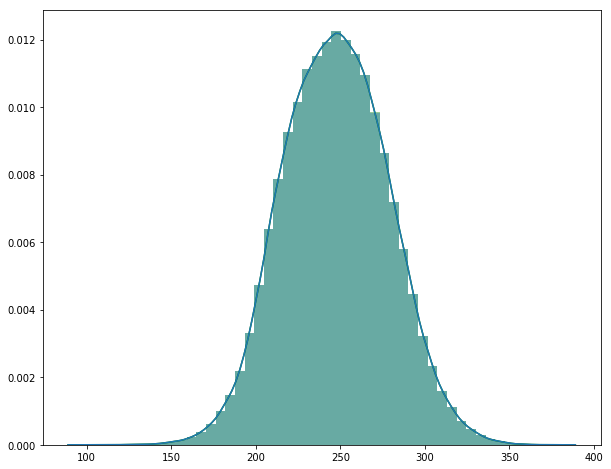

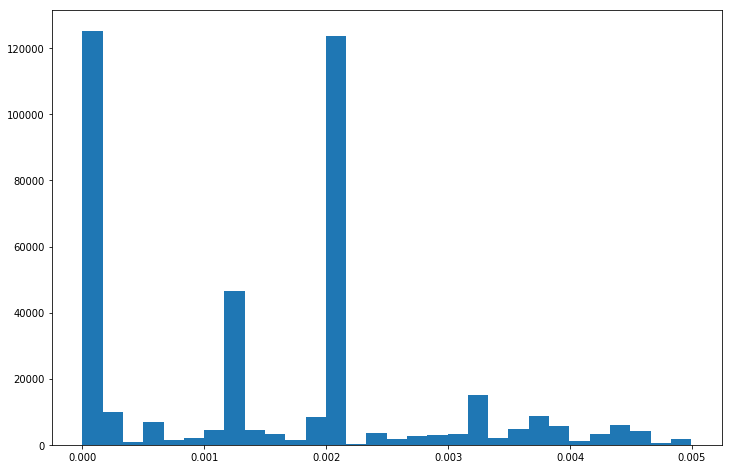

In [357]:
score_bi = read_hdp('scorecard')

score_sql = read('wrk_rsk_anl.dbo.bay_ccbi_scorecard')

final_score = pd.merge(score_sql[['score19']], score_bi[['eq_id' ,'score19_bi_part']], on='app_id', how='left').sort_index()

# значение скора BI по умоланию (если клиент не наш  - прогоняем распарсенную модель при учете того, что 
# фичи BI нуллы. Получаем -2885 * (коэффициент) = -34.7950416):
final_score['score19_bi_part'].fillna(-34.7950416, inplace=True)
final_score['score_final'] = final_score['score19'] + (final_score['score19_bi_part'] / 100)

compare_score = pd.merge(score_python[['score_python']], final_score[['eq_id','score19_bi_part','score_final']], on='app_id')
compare_score.sort_index()

plt.figure(figsize=(10, 8))
sns.distplot(score_python[['score_python']], color='green')
sns.distplot(final_score[['score_final']])

s = pd.merge(score_python[['score_python']], final_score[['score19_bi_part','score_final']], on=['app_id'], suffixes=['_python', '_sql'])
s['diff'] = abs(s['score_python'] - s['score_final'])
print(s[['diff']].describe())

plt.figure(figsize=(12, 8))
plt.hist(s['diff'], bins=30);

# Парсинг в SDS

In [516]:
class node:
    def __init__(self, tree,colnames,isnull=' = -999999',notnull=' <> -999999'):
        self.isnull = isnull
        self.notnull = notnull        
        if 'leaf_value' in tree:
            self.leave = True
            self.value = tree['leaf_value']
        else:
            self.leave = False
            self.var = colnames[tree['split_feature']]
            if tree['decision_type'] == '==':
                self.cat = True
                self.thres = '('+tree['threshold'].replace('||', ',')+')'
            else:
                self.cat = False
                self.thres = tree['threshold']
                self.thres = round(tree['threshold'],9)
            self.missing_is_yes = tree['default_left']
            self.yes = node(tree['left_child'],colnames,isnull,notnull)
            self.no = node(tree['right_child'],colnames,isnull,notnull)
    def yes_condition(self):
        return "('%s'<=%.9f%s)"%(self.var,self.thres," or '%s'%s"%(self.var,self.isnull) if self.missing_is_yes else " and '%s'%s"%(self.var,self.notnull))
    def no_condition(self):
        return "('%s'>%.9f%s)"%(self.var,self.thres," and '%s'%s"%(self.var,self.notnull) if self.missing_is_yes else " or '%s'%s"%(self.var,self.isnull))
    def cat_condition(self):
        return "('%s' in '%s' %s)"%(self.var, self.thres, " or '%s'%s"%(self.var,self.isnull) if self.missing_is_yes else " and '%s'%s"%(self.var,self.notnull))

def tree_to_sql(tree,t=0):
    if tree.leave:
        return ('\t' * t) + "%.9f" % tree.value
    else:
        if tree.cat:
            str1 = '\t' * t + 'case when %s\n' % (tree.cat_condition())
        else:
            str1 = '\t' * t + 'case when %s\n' % (tree.yes_condition())
        str2 = '\t' * t + 'then'
        str3 = '\n%s\n' % (tree_to_sql(tree.yes, t + 1))
        str4 = '\t' * t + 'else\n'
        str5 = '%s\n' % (tree_to_sql(tree.no, t + 1)) + '\t' * t + 'end'
        return str1 + str2 + str3 + str4 + str5
    
def tree_to_sds(tree,t=0):
    if tree.leave:
        return ('\t' * t) + "'SCORE' = 'SCORE' + %.9f" % tree.value
    else:
        if tree.cat:
            str1 = '\t' * t + 'IF %s\n' % (tree.cat_condition())
        else:
            str1 = '\t' * t + 'IF %s\n' % (tree.yes_condition())
        str2 = '\t' * t + 'THEN'
        str3 = '\n%s\n' % (tree_to_sds(tree.yes, t + 1))
        str4 = '\t' * t + 'ELSE\n'
        str5 = '%s\n' % (tree_to_sds(tree.no, t + 1)) + '\t' * t + 'ENDIF'
        return str1 + str2 + str3 + str4 + str5

# применение
code = []
code_sds = []
b = clf_.booster_

for i in b.dump_model()['tree_info']:
    code.append(tree_to_sql(node(i['tree_structure'], final_var_list)).replace('\t','').replace('\n',' ').replace('\'','')+' +')
    code_sds.append(tree_to_sds(node(i['tree_structure'], final_var_list)).replace('\t','').replace('\n',' ').replace('\'','')+' +')

# for i in sorted(code):
#     print(i) 
    
for i in sorted(code_sds):
    print(i) 

IF (CDXXU009<=-1034.500000000 and CDXXU009 <> -999999) THEN SCORE = SCORE + 0.042644804 ELSE SCORE = SCORE + -0.001133814 ENDIF +
IF (CDXXU009<=-1034.500000000 and CDXXU009 <> -999999) THEN SCORE = SCORE + 0.053757031 ELSE SCORE = SCORE + -0.001397988 ENDIF +
IF (CDXXU009<=-1034.500000000 and CDXXU009 <> -999999) THEN SCORE = SCORE + 0.071319975 ELSE SCORE = SCORE + -0.001793914 ENDIF +
IF (CDXXU009<=-197.500000000 or CDXXU009 = -999999) THEN SCORE = SCORE + 0.014557305 ELSE SCORE = SCORE + -0.033535415 ENDIF +
IF (CDXXU009<=-364.500000000 and CDXXU009 <> -999999) THEN SCORE = SCORE + 0.046749690 ELSE SCORE = SCORE + -0.003852198 ENDIF +
IF (CDXXU009<=-364.500000000 and CDXXU009 <> -999999) THEN SCORE = SCORE + 0.140243139 ELSE SCORE = SCORE + -0.009475297 ENDIF +
IF (CDXXU009<=-364.500000000 or CDXXU009 = -999999) THEN SCORE = SCORE + 0.006758005 ELSE SCORE = SCORE + -0.014887903 ENDIF +
IF (CDXXU009<=-643.500000000 and CDXXU009 <> -999999) THEN SCORE = SCORE + 0.075831370 ELSE SCORE 

In [521]:
code_sds_renew = []
for i in sorted(code_sds):
    i = i.replace('=0.00000000', '=0.00000001')
    i = i.replace('=-0.00000000', '=-0.00000001')
    i = i.replace('.500000000', '.500000001')
    i = i[:-2]   
    code_sds_renew.append(i)
    print(i)

IF (CDXXU009<=-1034.500000001 and CDXXU009 <> -999999) THEN SCORE = SCORE + 0.042644804 ELSE SCORE = SCORE + -0.001133814 ENDIF
IF (CDXXU009<=-1034.500000001 and CDXXU009 <> -999999) THEN SCORE = SCORE + 0.053757031 ELSE SCORE = SCORE + -0.001397988 ENDIF
IF (CDXXU009<=-1034.500000001 and CDXXU009 <> -999999) THEN SCORE = SCORE + 0.071319975 ELSE SCORE = SCORE + -0.001793914 ENDIF
IF (CDXXU009<=-197.500000001 or CDXXU009 = -999999) THEN SCORE = SCORE + 0.014557305 ELSE SCORE = SCORE + -0.033535415 ENDIF
IF (CDXXU009<=-364.500000001 and CDXXU009 <> -999999) THEN SCORE = SCORE + 0.046749690 ELSE SCORE = SCORE + -0.003852198 ENDIF
IF (CDXXU009<=-364.500000001 and CDXXU009 <> -999999) THEN SCORE = SCORE + 0.140243139 ELSE SCORE = SCORE + -0.009475297 ENDIF
IF (CDXXU009<=-364.500000001 or CDXXU009 = -999999) THEN SCORE = SCORE + 0.006758005 ELSE SCORE = SCORE + -0.014887903 ENDIF
IF (CDXXU009<=-643.500000001 and CDXXU009 <> -999999) THEN SCORE = SCORE + 0.075831370 ELSE SCORE = SCORE + -0.0

# Качество на наших и не наших клиентах

In [403]:
alpha = read('bay_ccbi_sample_alpha')

whole_df = df.join(alpha[['eq_id']], how='left')

df_alpha = whole_df[whole_df['eq_id'].notnull()]

df_not_alpha = whole_df[whole_df['eq_id'].isnull()]

In [415]:
df_alpha.drop('eq_id', axis=1, inplace=True)
df_not_alpha.drop('eq_id', axis=1, inplace=True)

In [413]:
with open('clf_best.pickle', 'rb') as handle:
    clf_ = pickle.load(handle)

In [421]:
for i in range(5):
    X_final, y_final, X_OOT_final, y_OOT_final = get_sample_evtime(df_not_alpha)
    X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_final, y_final, stratify = y_final, 
                                                                                test_size = 0.3,  random_state = i)


    pred_train = clf_.predict_proba(X_train_final)[:, 1]
    pred_test = clf_.predict_proba(X_test_final)[:, 1]
    pred_oot = clf_.predict_proba(X_OOT_final)[:, 1]


    gini_test = 2 * roc_auc_score(y_test_final, pred_test) - 1
    gini_oot = 2 * roc_auc_score(y_OOT_final, pred_oot) - 1
    gini_train = 2 * roc_auc_score(y_train_final, pred_train) - 1

    print(gini_train, gini_test, gini_oot)

0.5753104913159199 0.5729703254380758 0.5472663840624474
0.5784095170187484 0.5658324170507418 0.5472663840624474
0.5731287148991568 0.5781766703285482 0.5472663840624474
0.57107661176095 0.5829099104783988 0.5472663840624474
0.5752910828570912 0.5731079810101904 0.5472663840624474


In [423]:
for i in range(15):
    X_final, y_final, X_OOT_final, y_OOT_final = get_sample_evtime(df_alpha)
    X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_final, y_final, stratify = y_final, 
                                                                                test_size = 0.3,  random_state = i)


    pred_train = clf_.predict_proba(X_train_final)[:, 1]
    pred_test = clf_.predict_proba(X_test_final)[:, 1]
    pred_oot = clf_.predict_proba(X_OOT_final)[:, 1]


    gini_test = 2 * roc_auc_score(y_test_final, pred_test) - 1
    gini_oot = 2 * roc_auc_score(y_OOT_final, pred_oot) - 1
    gini_train = 2 * roc_auc_score(y_train_final, pred_train) - 1

    print(gini_train, gini_test, gini_oot)

0.5712145304636056 0.5886395039651777 0.5771002113835308
0.570102736936418 0.5911673888593008 0.5771002113835308
0.5758364777178038 0.5777320777687138 0.5771002113835308
0.5758360108513183 0.5777807576533882 0.5771002113835308
0.5723147464757639 0.5860099966516781 0.5771002113835308
0.5840811451094805 0.5584499066290036 0.5771002113835308
0.5811933514910863 0.5653445639765482 0.5771002113835308
0.5779174873586226 0.5730004589897952 0.5771002113835308
0.5732293611352581 0.5838973795446729 0.5771002113835308
0.5797610038238172 0.5685986864577224 0.5771002113835308
0.5744495076673664 0.581017541612453 0.5771002113835308
0.5765268958687062 0.5762059226537588 0.5771002113835308
0.5804666983104128 0.5669853612030589 0.5771002113835308
0.5726795923167085 0.5852172701511691 0.5771002113835308
0.576095722744657 0.5772231089283346 0.5771002113835308


# Проскорить реджекты

In [454]:
score_kop_bi = read_hdp('kop_rejects_scorecard')
score_kop_sql = read('wrk_rsk_anl.dbo.bay_ccbi_kop_rejects_scorecard')

df_kop = pd.merge(score_kop_sql, score_kop_bi, on='app_id', how='left')
df_kop = df_kop[curvars + ['score19', 'score19_bi_part', 'evtime']]

df_kop = df_kop.replace(-999999, np.nan)
df_kop = df_kop.replace('None', np.nan)

final_kop_score = pd.merge(score_kop_sql[['score19']], score_kop_bi[['eq_id' ,'score19_bi_part']], on='app_id', how='left').sort_index()

# значение скора BI по умоланию (если клиент не наш  - прогоняем распарсенную модель при учете того, что 
# фичи BI нуллы. Получаем -2885 * (коэффициент) = -34.7950416):

final_kop_score['score19_bi_part'].fillna(-34.7950416, inplace=True)
final_kop_score['score_final'] = final_kop_score['score19'] + (final_kop_score['score19_bi_part'] / 100)

final_kop_score[['score_final']].to_csv('scores_rejects.csv')

# Проскорить реджекты по которым есть скоры мегафон и эквифакс

In [485]:
score_nds_bi = read_hadoop('bay_scorecard_for_nds_scorecard')
score_nds_sql = read('wrk_rsk_anl.dbo.bay_scorecard_for_nds_scorecard')

score_nds_sql = score_nds_sql.replace(-999999, np.nan)
score_nds_sql = score_nds_sql.replace('None', np.nan)

score_nds_bi = score_nds_bi.replace(-999999, np.nan)
score_nds_bi = score_nds_bi.replace('None', np.nan)

final_nds_score = pd.merge(score_nds_sql[['score19']], score_nds_bi[['eq_id' ,'score19_bi_part']], on='app_id', how='left').sort_index()

# значение скора BI по умоланию (если клиент не наш  - прогоняем распарсенную модель при учете того, что 
# фичи BI нуллы. Получаем -2885 * (коэффициент) = -34.7950416):

final_nds_score['score19_bi_part'].fillna(-34.7950416, inplace=True)
final_nds_score['score_final'] = final_nds_score['score19'] + (final_nds_score['score19_bi_part'] / 100)

final_nds_score[['score_final']].to_csv('scores_nds.csv')

# Проскорить выдачи и реджекты за 2 года

In [5]:
bi = read_hadoop('bay_scorecard_2years_scorecard')

bi[bi['score19_bi_part'] != -35]['score19_bi_part'].hist(bins=40)
plt.title('score19_bi_part')

pd.DataFrame(bi['prv_evtime_eom'].value_counts().sort_index)

bi['ocrm_prod_share_n_6'].hist(bins=20)
plt.title('ocrm_prod_share_n_6')

bi['cardtrnopkind_uk_5880005493_com_share_3'].hist(bins=20)
plt.title('cardtrnopkind_uk_5880005493_com_share_3')

np.log(bi['cardtrnopkind_uk_5880005494_avg_3']).hist(bins=100)
plt.title('log(cardtrnopkind_uk_5880005494_avg_3)')

np.log(bi[bi['cardtrnoptype_uk_5880005597_sum_6'] > 0]['cardtrnoptype_uk_5880005597_sum_6']).hist(bins=100)
plt.title('log(cardtrnoptype_uk_5880005597_sum_6)')

bi[['prv_evtime_eom', 'cardtrnoptype_uk_5880005597_sum_6']].groupby('prv_evtime_eom')['cardtrnoptype_uk_5880005597_sum_6'].agg('mean').plot()
plt.title('cardtrnoptype_uk_5880005597_sum_6')

bi[['prv_evtime_eom', 'cardtrnopkind_uk_5880005493_com_share_3']].groupby('prv_evtime_eom')['cardtrnopkind_uk_5880005493_com_share_3'].agg('mean').plot()
plt.title('cardtrnopkind_uk_5880005493_com_share_3')

bi[['prv_evtime_eom', 'cardtrnopkind_uk_5880005494_avg_3']].groupby('prv_evtime_eom')['cardtrnopkind_uk_5880005494_avg_3'].agg('mean').plot()
plt.title('cardtrnopkind_uk_5880005494_avg_3')

bi[['prv_evtime_eom', 'ocrm_prod_share_n_6']].groupby('prv_evtime_eom')['ocrm_prod_share_n_6'].agg('mean').plot()
plt.title('ocrm_prod_share_n_6')

def get_nan_stat(x):
    d = {}
    names = []
    for i in x.columns:
        d['{}'.format(i)] = x[i].isnull().sum()/x[i].shape[0]
        names.append('{}'.format(i))
    return pd.Series(d, index=names) 

df_nan_stat = bi.groupby('prv_evtime_eom').apply(get_nan_stat) 
for i in df_nan_stat.columns:
    plt.title(i)
    df_nan_stat[i].plot()
    plt.show() 

In [152]:
score_2years_sql = read('wrk_rsk_anl.dbo.bay_2years_scorecard')

score_2years_sql = score_2years_sql.replace(-999999, np.nan)
score_2years_sql = score_2years_sql.replace('None', np.nan)

score_2years_bi = score_2years_bi.replace(-999999, np.nan)
score_2years_bi = score_2years_bi.replace('None', np.nan)

In [153]:
tf_ex = pd.read_sql("""select a.*, b.tf_exists_id from
bay_2years_sample a
left join wbi_dw2.dbo.dim_submission b 
on a.app_id=b.appid
""", engine)

tf_ex1 = pd.merge(score_2years_bi.reset_index(), tf_ex, how='left', on=['eq_id', 'prv_evtime_eom', 'app_id'])

df_tf = tf_ex1[tf_ex1['tf_exists_id'] == 1][['app_id','eq_id', 'prv_evtime_eom', 'cardtrnoptype_uk_5880005597_sum_6', 'cardtrnopkind_uk_5880005493_com_share_3', 'cardtrnopkind_uk_5880005494_avg_3', 'ocrm_prod_share_n_6', 'score19_bi_part']]

In [165]:
final_2years_score = pd.merge(score_2years_sql.reset_index()[['app_id', 'evtime', 'score19']], df_tf[['app_id', 'eq_id' ,'score19_bi_part']], on='app_id', how='left').sort_index()

# значение скора BI по умоланию (если клиент не наш  - прогоняем распарсенную модель при учете того, что 
# фичи BI нуллы. Получаем -2885 * (коэффициент) = -34.7950416):

final_2years_score['score19_bi_part'].fillna(-34.7950416, inplace=True)
final_2years_score['score_final'] = final_2years_score['score19'] + (final_2years_score['score19_bi_part'] / 100)

final_2years_score.set_index('app_id', inplace=True)

In [508]:
# final_2years_score[['score_final']].to_csv('scores_2years.csv')

In [188]:
final_2years_score['evtime'] = pd.to_datetime(final_2years_score['evtime'])
final_2years_score['year'] = pd.to_datetime(final_2years_score['evtime']).dt.year
final_2years_score['evtime_month'] = final_2years_score['evtime'].apply(lambda x: x.strftime("%y-%m"))
final_2years_score['quartal'] = pd.to_datetime(final_2years_score['evtime']).dt.quarter
final_2years_score['evtime_quartal'] = 100*final_2years_score['year'] + final_2years_score['quartal']

In [ ]:
par = pd.read_sql('select deal_no as app_id, deal_date, score_18, score_1805, score_16 from par_scores_cc', engine)

In [198]:
missing_values_table(df_par)

Your selected dataframe has 8 columns.
There are 6 columns that have missing values.


Missing Values  % of Total Values
score_18            200683               16.8
score_16            200683               16.8
score_1805          126257               10.6
deal_date           125402               10.5
year                125402               10.5
quartal             125402               10.5

In [203]:
df_par = pd.merge(final_2years_score.reset_index()[['app_id', 'score_final']], par, on='app_id', how='left')

In [205]:
df_par.dropna(subset=['deal_date'], inplace=True)

In [208]:
df_par['deal_date'] = pd.to_datetime(df_par['deal_date'])
df_par['year'] = pd.to_datetime(df_par['deal_date']).dt.year
df_par['quartal'] = pd.to_datetime(df_par['deal_date']).dt.quarter
df_par['deal_date_month'] = df_par['deal_date'].apply(lambda x: x.strftime("%y-%m"))
df_par['deal_date_quartal'] = 100*df_par['year'] + df_par['quartal']

par_an = df_par[['deal_date_month', 'score_final','score_18','score_16', 'score_1805']].groupby('deal_date_month').agg('mean')

par_an

score_final    score_18    score_16  score_1805
deal_date_month                                                 
18-01             246.321231  252.037288  222.048800  241.342369
18-02             245.081102  251.538643  220.077737  240.741281
18-03             247.657879  252.243755  217.734664  242.696993
18-04             247.912953  246.409396  216.540548  243.062166
18-05             247.173538  245.989997  215.132995  242.531893
18-06             247.529900  246.493227  215.248663  242.734544
18-07             246.927803  244.888640  212.359923  240.020396
18-08             246.587187  242.266348  210.858069  242.809394
18-09             245.211438  236.996033  208.882065  242.280573
18-10             244.510031  235.204051  208.153706  241.540912
18-11             246.078092  236.086383  208.520140  243.319835
18-12             241.250493  231.919162  204.093741  238.894917
19-01             238.351003  229.696128  202.380668  236.126787
19-02             239.037305  230.114484  202.338138  236.875824
19-03             239.929917  230.591849  202.894099  237.615074
19-04             241.795205  185.174597  162.763441  239.092099
19-05             243.203252    0.000000    0.000000  240.096910

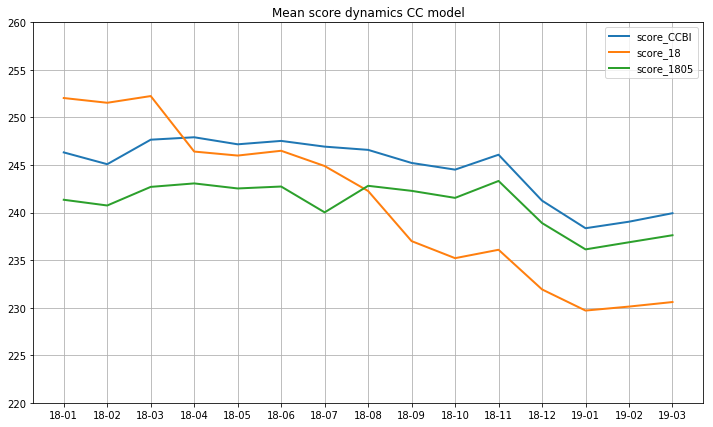

In [263]:
plt.figure(figsize=(12, 7))
ax1 = plt.plot(par_an.drop(['19-04', '19-05'])['score_final'], label='score_CCBI', linewidth=2)
ax1 = plt.plot(par_an.drop(['19-04', '19-05'])['score_18'], label='score_18', linewidth=2)
ax1 = plt.plot(par_an.drop(['19-04', '19-05'])['score_1805'], label='score_1805', linewidth=2)
plt.legend()
plt.grid()
plt.title('Mean score dynamics CC model')
plt.ylim(220, 260);

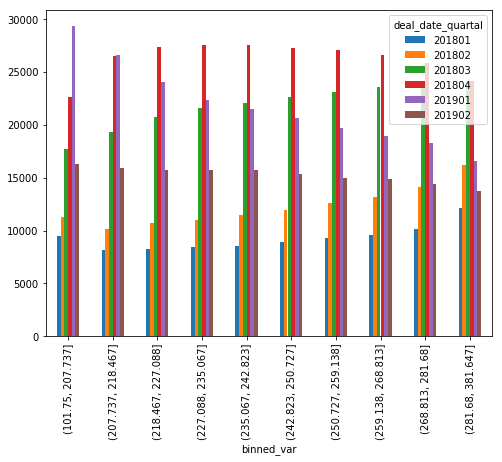

In [294]:
bins = pd.qcut(df_par['score_final'], 10, retbins = True, duplicates='drop')[1]
df_par['binned_var'] = pd.cut(df_par['score_final'], bins = bins)

psi = df_par.reset_index().groupby(['binned_var', 'deal_date_quartal']).deal_date_quartal.agg(len).unstack() 


# plt.figure()
psi.plot.bar(figsize=(8, 6))

In [282]:
bins_score_final = pd.cut(df_par.score_final,[0,170,180,190,200,210,220,230,240,250,260,270,280,290,300,310,320,330,100000])
bins_score_18 = pd.cut(df_par.score_18,[0,170,180,190,200,210,220,230,240,250,260,270,280,290,300,310,320,330,100000])
bins_score_1805 = pd.cut(df_par.score_1805,[0,170,180,190,200,210,220,230,240,250,260,270,280,290,300,310,320,330,100000])

bs1 = pd.concat([bins_score_final.value_counts().sort_index(), 
                 bins_score_18.value_counts().sort_index(),
                 bins_score_1805.value_counts().sort_index()
                
                ], axis=1)

bs1.plot.bar(figsize=(12,7), title='Score bands distribution');
# bs2.plot.bar(color='red', alpha=0.5)

In [ ]:
s = df.groupby([df.eomdate,pd.cut(df.mob,[0,18,36,72,999])]).deal_no.count().unstack()
ax = s.plot.area(figsize=(15,4),xlim=(s.index.values[0],s.index.values[-1]))
ax.axvline(pd.datetime(2013,1,4),linestyle='--',color='black')
ax.axvline(pd.datetime(2018,1,4),linestyle='--',color='black')
ax.axvline(pd.datetime(2018,3,4),linestyle='--',color='black')
ax.set_ylabel('Количество договоров')
ax.set_xlabel('')
ax1 = ax.twinx()
df.groupby(df.eomdate).flag.mean().plot(ax=ax1,ylim = (0,.04),color='black')
ax1.set_ylabel('Дефолт-рейт')

# Проскорить выдачи и реджекты по пилам с 2018

In [ ]:
score_2years_pil_bi = read_hadoop('bay_scorecard_2years_pil_scorecard')
score_2years_pil_sql = read('wrk_rsk_anl.dbo.bay_2years_pil_scorecard')

score_2years_pil_sql = score_2years_pil_sql.replace(-999999, np.nan)
score_2years_pil_sql = score_2years_pil_sql.replace('None', np.nan)

score_2years_pil_bi = score_2years_pil_bi.replace(-999999, np.nan)
score_2years_pil_bi = score_2years_pil_bi.replace('None', np.nan)

final_2years_pil_score = pd.merge(score_2years_pil_sql[['score19']], score_2years_pil_bi[['eq_id' ,'score19_bi_part']], on='app_id', how='left').sort_index()

# значение скора BI по умоланию (если клиент не наш  - прогоняем распарсенную модель при учете того, что 
# фичи BI нуллы. Получаем -2885 * (коэффициент) = -34.7950416):

In [530]:
final_2years_pil_score['score19_bi_part'].fillna(-34.7950416, inplace=True)
final_2years_pil_score['score_final'] = final_2years_pil_score['score19'] + (final_2years_pil_score['score19_bi_part'] / 100)

In [532]:
final_2years_pil_score

score19   eq_id  score19_bi_part  score_final
app_id                                                                
F010S18031600452      164.009641  AJRJX9       110.000000   165.109641
F010S18031601288      256.457957  AEF80Z       110.000000   257.557957
F010S18031700588      266.486758  AEROXY      -409.000000   262.396758
F010S18032001873      248.487841  AMMMEG      1876.000000   267.247841
F010S18032002115      220.823407  AHTQOS       110.000000   221.923407
F010S18040202063      223.842864  ADPIQP      -575.000000   218.092864
F020S18031302537      289.196925  AI0M73      1306.000000   302.256925
F020S18031402733      267.236059  AL7ZJ6     -1456.000000   252.676059
F020S18031500329      208.840805     NaN       -34.795042   208.492855
F020S18032000536      217.135843     NaN       -34.795042   216.787893
F0GERC20S18092514626  212.258177  ALHMGH       -35.000000   211.908177
F0PDP120S18010200025  223.180345  AMG5CD       246.000000   225.640345
F0PDP120S18010200099  203.543367  AN8P0T        61.000000   204.153367
F0PDP120S18010200103  203.543367  AN8P0T        61.000000   204.153367
F0PDP120S18010200190  163.794059  AN61BN       425.000000   168.044059
F0PDP120S18010300074  106.681794  AN0N99      -589.000000   100.791794
F0PDP120S18010300145  224.092180  AHF71K       486.000000   228.952180
F0PDP120S18010300185  220.107923  AN3AFT      -199.000000   218.117923
F0PDP120S18010300193  215.896087  AN17SS       734.000000   223.236087
F0PDP120S18010300285  201.044168  ANWL26      -589.000000   195.154168
F0PDP120S18010400336  243.838167  AE5F74       110.000000   244.938167
F0PDP120S18010400519  232.344584  AN1697      1441.000000   246.754584
F0PDP120S18010600441  163.630394  AN0N19       110.000000   164.730394
F0PDP120S18010600540  223.037557  AKV74B     -1622.000000   206.817557
F0PDP120S18010600573  262.495530  ALD7Y3      1266.000000   275.155530
F0PDP120S18010800088  217.741503  AN49NJ       110.000000   218.841503
F0PDP120S18010800450  147.591931  AN2D3T       546.000000   153.051931
F0PDP120S18010800661  217.158365  ANY1S1      -845.000000   208.708365
F0PDP120S18010900231  210.692930  ANWL26      -589.000000   204.802930
F0PDP120S18010900237  202.804364  AKMOWB       742.000000   210.224364
...                          ...     ...              ...          ...
IA2019060399458       126.660980     NaN       -34.795042   126.313030
IA2019060399486       215.524839  AGM7RS       -35.000000   215.174839
IA2019060399520       226.252839  J31347        14.000000   226.392839
IA2019060399561       166.322482  AHMI40       -35.000000   165.972482
IA2019060399615       191.906941  AE1TGB       546.000000   197.366941
IA2019060399619       225.771602  AFKRQF       607.000000   231.841602
IA2019060399623       131.634104     NaN       -34.795042   131.286154
IA2019060399636       230.062158  AQG4D8       546.000000   235.522158
IA2019060399646       214.240056     NaN       -34.795042   213.892106
IA2019060399652       167.744561  ANZHOM       -56.000000   167.184561
IA2019060399680       173.666950  ADW5EN      -810.000000   165.566950
IA2019060399698       148.804044  APV9YZ     -1640.000000   132.404044
IA2019060399715       230.917434  AE1TW9       -35.000000   230.567434
IA2019060399737       228.652674  APU0RP       110.000000   229.752674
IA2019060399753       221.422546  AM5N6F       110.000000   222.522546
IA2019060399758       199.525265     NaN       -34.795042   199.177315
IA2019060399780       285.392757  AAELNG      1392.000000   299.312757
IA2019060399791       174.947637  AFYVEB       110.000000   176.047637
IA2019060399795       202.648058  APQRRN       110.000000   203.748058
IA2019060399809       221.389132  AO5IPM        61.000000   221.999132
IA2019060399814       205.750011  AI3SAT       -56.000000   205.190011
IA2019060399816       148.835279  AIBHO4      -295.000000   145.885279
IA2019060399844       185.208075  AALOK0      -298.000000   182.228075
IA2019060399882       213.342426  AGY0LC       -5

In [551]:
final_2years_pil_score[['score_final']].to_csv('scores_2years_pil.csv', sep=';')

In [552]:
final_2years_pil_score[['score_final']]

score_final
app_id                           
F010S18031600452       165.109641
F010S18031601288       257.557957
F010S18031700588       262.396758
F010S18032001873       267.247841
F010S18032002115       221.923407
F010S18040202063       218.092864
F020S18031302537       302.256925
F020S18031402733       252.676059
F020S18031500329       208.492855
F020S18032000536       216.787893
F0GERC20S18092514626   211.908177
F0PDP120S18010200025   225.640345
F0PDP120S18010200099   204.153367
F0PDP120S18010200103   204.153367
F0PDP120S18010200190   168.044059
F0PDP120S18010300074   100.791794
F0PDP120S18010300145   228.952180
F0PDP120S18010300185   218.117923
F0PDP120S18010300193   223.236087
F0PDP120S18010300285   195.154168
F0PDP120S18010400336   244.938167
F0PDP120S18010400519   246.754584
F0PDP120S18010600441   164.730394
F0PDP120S18010600540   206.817557
F0PDP120S18010600573   275.155530
F0PDP120S18010800088   218.841503
F0PDP120S18010800450   153.051931
F0PDP120S18010800661   208.708365
F0PDP120S18010900231   204.802930
F0PDP120S18010900237   210.224364
...                           ...
IA2019060399458        126.313030
IA2019060399486        215.174839
IA2019060399520        226.392839
IA2019060399561        165.972482
IA2019060399615        197.366941
IA2019060399619        231.841602
IA2019060399623        131.286154
IA2019060399636        235.522158
IA2019060399646        213.892106
IA2019060399652        167.184561
IA2019060399680        165.566950
IA2019060399698        132.404044
IA2019060399715        230.567434
IA2019060399737        229.752674
IA2019060399753        222.522546
IA2019060399758        199.177315
IA2019060399780        299.312757
IA2019060399791        176.047637
IA2019060399795        203.748058
IA2019060399809        221.999132
IA2019060399814        205.190011
IA2019060399816        145.885279
IA2019060399844        182.228075
IA2019060399882        212.782426
IA2019060399897        245.686155
IA2019060399925        205.953511
IA2019060399957        213.496651
IA2019060399976        230.906433
IA2019060399978        193.528458
M0PBR220S07122800197   204.216297

[3286028 rows x 1 columns]

In [311]:
final_2years_pil_score = pd.read_csv('scores_2years_pil.csv', sep=';')

In [314]:
# final_2years_pil_score[['score_final']].to_sql('bay_scorecard_pil_2years',engine,chunksize=1000) 

# Сохранить большую выборку из скуля в .csv, чтобы доставить в hadoop

In [295]:
sample_nds_cc = pd.read_sql("""select 
app_id, eq_id, prv_evtime_eom 
from bay_2years_sample where eq_id<>''""", engine)



In [302]:
sample_nds_cc.set_index('app_id', inplace=True)

In [303]:
sample_nds_cc['prv_evtime_eom'].value_counts().sort_index()

165     2191
166     3850
167     4601
168     5371
169     6064
170     7421
171     8488
172    10955
173    10468
174    10623
175    11495
176    13906
177     8579
178    11318
179    13829
180    14558
181    16240
182    16020
183    24153
184    30491
185    24723
186    21540
187    21007
188    32093
189    20431
190    18984
191    25105
192    28659
193    28095
194    30083
195    38144
196    55035
197    47201
198    53445
199    57655
200    53091
201    35158
202    41650
203    45416
204    47517
205    46883
206    48932
207    21618
Name: prv_evtime_eom, dtype: int64

In [304]:
sample_nds_cc.to_csv('bay_2years_sample.csv')